# Fitting Sigmoids to Empirical Nearest Neighbour CDF

In [1]:
# Author: Shiqi Jiang
# Last modified: 5/1/2022

# This notebook is the readable working version of fitting sigmoids to empirical NN-CDFs

In [2]:
# 9 total Species: AT, CE, DM, ...
# each has 8 Classes: ER, ERDD, GEO, GEOGD ...(each with ~500 data points)
# normalization is done on each species seperetaly.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.special import erf
from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import FormatStrFormatter
import decimal
import scipy

In [4]:
# All Species and Classes
Species = ["AT", "CE", "DM", "EC", "HS", "MM", "RN", "SC", "SP"]
Classes = ['ER', 'ERDD', 'GEO', 'GEOGD', 'HGG', 'SF', 'SFDD', 'Sticky','Original']

## Normalization

In [5]:
# combine all classes for one species into one dataframe.
def combine_data(data_location,classes):
    """
    data_location: list containing locations for all classes under one species
    classes: list containing all classes
    
    return: a dataframe for one species with all classes
    """
    df_comb = pd.DataFrame()
    i = 0
    for protein in data_location:
        df = pd.read_csv(protein, header = None, sep = ' ')
        df['class'] = classes[i]
        df_comb = pd.concat([df, df_comb])
        i += 1
    return df_comb


# return Normalized data_frame for specified species 
def data_frame(species):
    loc = [r"D:\file\Research\P-value\data\{}".format(species) + c for c in Classes]
    df_comb = combine_data(loc,Classes)
    df_class = df_comb['class']
    df_comb = df_comb.drop("class", axis = 1)
    df_comb = pd.DataFrame(MinMaxScaler().fit_transform(df_comb))
    df_comb['class'] = df_class.reset_index(drop = True)
    return df_comb


# calling data(data_frame, class_name) return Species-Class empirical data as an array, e.g data(df_AT, "ER") -> empirical data: ATER
def data(dataframe, class_name):
    return dataframe[dataframe['class']==class_name].drop("class",axis=1).to_numpy()

## Helper Functions

In [6]:
# calculating empirical data's Nearest Neighbour(NN) distance 
# real data is high-dimensional data points
def data_distance(data):
    """
    data: species-class data, e.g. CEGEO
    
    return: array of Nearest Neighbour distances
    """
    shortest_distance = [0]*len(data)
    for i in range(len(data)):
        x = np.delete(data,i,0)
        temp = (x-data[i])**2
        d = np.sqrt(np.sum(temp,axis=1))
        shortest_distance[i] = d.min()
    
    return np.array(shortest_distance)   # return an array of real data's NN distance


# plotting empirical data's NN hist
def plot_data_distance(D, title):
    """
    D: an array of real data' NN distance
    """
    f, ax = plt.subplots(1,1, figsize = (6,4))
    ax.hist(D,edgecolor='white',bins=100)   ## consider specifying <bins>
    ax.set_title(title)
    plt.show()
    return


# get factor for this specific empirical data
def get_factor(D):
    """
    D: an array of real data' NN distance
    
    return: factor used in fitting
    """
    f,ax = plt.subplots(1,1)
    ax.hist(D,bins=100)
    ticks = ax.get_xticks()
    d = min([decimal.Decimal('{:.6g}'.format(t)).as_tuple().exponent for t in ticks])    # temporarily set to 6: max decimal places
    plt.close(f)
    
    return 10**d
    

# generate empirical CDF manually, satisfying:
# 1. F(x<=0) = 0
# 2. F(x_1) = 1/(n+1)
# 3. F(x_n/2) = 0.5
# 4. F(x_n) = n/(n+1)
# 5. F(x) < 1 for all x.
def empirical_CDF(data,title):
    '''
    return x,y data of CDF 
    '''    
    sort_data = np.sort(data)
    #print("data len: ",len(sort_data))
    x = np.concatenate(([0],sort_data))
    #print("x len : ",len(x))
    #print("first: ", x[0], "\nlast: ",x[-1])
    
    y = np.zeros((x.shape))
    for i in range(1,len(x)):
        y[i] = i/len(x)
    
    return x,y


# curve_fit()
def auto_curve_fit(data_NN, x, y, x_scale_factor, func,s=None, p_control=None):
    '''
    data_NN: array empirical data_distance for calculating median
    x,y: from CDF
    s: sigma in curve_fit(), for weighting. Disabled for fitting with binning
    need to scale Xdata with factor so that no erro in np.exp() for small value
    scale back after getting the popt.
    '''
    if p_control == "Gompertz":
        p0 = [1,1]
    elif p_control == "Weight":
        p0 = [np.median(data_NN)/x_scale_factor,1,0.5]
    else:
        p0 = [np.median(data_NN)/x_scale_factor,1] # this is initial guess for sigmoid parameters
    
    popt, pcov = curve_fit(f=func, xdata=x/x_scale_factor, ydata=y, p0=p0,method='lm')

    # parameters yielded by Curve_fit: x0, k
    print("curve_fit parameter on "+str(func)[9:-22]+": ", popt)
    return popt


# plot fitted sigmoid and empirical curve in 1-y and y: i.e. y-axis = p-value and CDF
def sigmoids_for_class(data, name, factor, func_list, color_list, binning=False):
    if binning:
        x,y = binning_xy(data_binning(data))
    else:
        x,y = empirical_CDF(data, name)
    
    # axis[0] = 1-y = p_value (on log space)
    # axis[1] = y = CDF
    f,ax = plt.subplots(1,2,figsize=(16,6))
    ax[0].set_title('1-y(p_value) of '+name)
    ax[0].set_yscale('log')
    ax[0].scatter(x,1-y, color='b',s=10)
    ax[0].set_xscale('log')
    ax[1].set_xscale('log')                 # xscale log also
    ax[1].set_title('y of '+name)
    ax[1].scatter(x,y, color='b',s=10)
    
    print("For ",name," :")
    for i in range(len(func_list)):
        try:
            if i == 6:
                p = auto_curve_fit(data,x,y,factor,func_list[i],s=y,p_control="Gompertz")       # 4.26: weighted s=y disabled for binning
            elif i == 5:
                p = auto_curve_fit(data,x,y,factor,func_list[i],s=y,p_control="Weight")
            else:
                p = auto_curve_fit(data,x,y,factor,func_list[i],s=y)
        except RuntimeError:
            print("error in ",str(func_list[i])[9:-22])
            continue
        y2 = func_list[i](x/factor, *p)         
        ax[0].plot(x, 1-y2, color=color_list[i], label=str(func_list[i])[9:-22])
        ax[1].plot(x, y2, color=color_list[i], label=str(func_list[i])[9:-22])
    
    ax[0].legend(loc='lower left')
    ax[1].legend(loc='lower left')
    plt.show()
    
    # need to decide best fitted sigmoid, using its parameters to construct predictor.
    # return best_func, best_p
    
    

def predict(func, popt, factor, data, point, name):
    """
    func: sigmoid to be used in prediction
    popt: parameters for func
    factor: factor for this class
    data: empirical data of a certain class
    point: new data point to be classfied
    name: Species-Class
    
    return: P-value for point belonging to this class
    """
    distances = np.zeros(len(data))
    for i in len(data):
        distances[i] = np.sqrt(np.sum((point-data[i])**2,axis=1))
    
    x = np.min(distances)
    p = 1-func(x/factor, *popt)
    print("Probability for this point belonging to {} = {}".format(name, p))
    
    return p

## Sigmoid Functions

In [7]:
# All Sigmoid functions are rescaled so that range is (0,1)

def logistic(x,x0, k):
    m = (1/ (1 + np.exp(-k*(x-x0))))      
    return m

def tanh(x, x0, k): 
    m = (1+np.tanh(k*(x-x0)))/2
    return m

def arctan(x, x0, k):
    m = (1+(2/np.pi)*np.arctan(k*(x-x0)))/2
    return m

def GD(x, x0, k):
    m = (1+(4/np.pi)*np.arctan(np.tanh(k*(x-x0))))/2
    return m

def ERF(x, x0, k):
    m = (1+erf(k*(x-x0)))/2
    return m

def algebra(x, x0, k):
    m = (1+x/((1+abs(x)**k)**(1/k)))/2
    return m

def arctan_GD(x,x0,k, w):                  # a weighted combination of arctan and GD
    m = w*GD(x,x0,k)+(1-w)*arctan(x,x0,k)
    return m

def Gompertz(x,b,c):
    m = np.e**(-np.e**(b-c*x))
    return m

In [8]:
functions = [logistic, tanh, arctan, GD, ERF,arctan_GD, Gompertz]      # algebra removed

## Binning

In [23]:
# generate binned xdata
def data_binning(data, gmean=False):
    
    x = np.sort(data) 
    N = len(x)                   # e.g N = 500, sqrt(500)=22.3
    lower = int(np.floor(np.sqrt(N))) # 22
    upper = int(np.ceil(np.sqrt(N)))  # 23 as total #of bin
    
    if lower*upper >= N:
        small_bin_num = int(lower*upper - N)  # 22*23 - 500 = 6
        small_bin_size = int(lower - 1)  # 21
        large_bin_size = lower
    else: # HGG -> sqrt(252) = 15.8
        small_bin_num = int(upper**2 - N) # 16*16-252 =4
        small_bin_size = lower  # 15
        large_bin_size = upper
    
    large_bin_num = int(upper - small_bin_num) # 23-6 = 17

    # small_bin_size*small_bin_num + lower*large_bin_num = N

    bin_count = [large_bin_size]*large_bin_num + [small_bin_size]*small_bin_num  # [22..*17, 21..*6,]
    print("items in each bin: ", bin_count)
    binned_data = []
    i = 0
    for count in bin_count:
        if gmean:
            binned_data.append(scipy.stats.mstats.gmean(x[i:i+count]))
        else:
            binned_data.append(np.mean(x[i:i+count]))
        i += count
    print("binned_data: ",binned_data)
    return binned_data


# binning first, add (0,0) at the front later when calculate y
# generate binned x,y
def binning_xy(binned_data):
    x = np.concatenate(([0],binned_data))
    y = np.zeros((x.shape))
    
    for i in range(1,len(x)):
        y[i] = i/len(x)
        
    return x,y

## Fitting with Binning

In [10]:
colors = ['g','r','c','m','y','k','brown','gray']

Factor for AT-ER: 1e-05
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [1.086280590305347e-05, 1.5485703526428142e-05, 2.019659334544122e-05, 2.462750241359776e-05, 2.917611446615245e-05, 3.3463621430509686e-05, 3.873844532887376e-05, 4.0488722814818385e-05, 4.2648937666230734e-05, 4.4673570655667445e-05, 4.6117281099309485e-05, 4.783421621912026e-05, 5.0339253508758155e-05, 5.3522389455066104e-05, 5.6875205240236556e-05, 6.130537583390435e-05, 6.675036295774041e-05, 7.296061821094876e-05, 7.799883418996967e-05, 8.409752614755949e-05, 9.908389854174012e-05, 0.0001299936777736, 0.00041906947798248757]
For  ER  :
curve_fit parameter on  logistic :  [5.07797398 0.59115369]
curve_fit parameter on  tanh :  [5.07796948 0.29557785]
curve_fit parameter on  arctan :  [4.99318686 0.60992837]
curve_fit parameter on  GD :  [5.06607858 0.24153901]
curve_fit parameter on  ERF :  [5.09204204 0.25064859]
curve_fit paramete

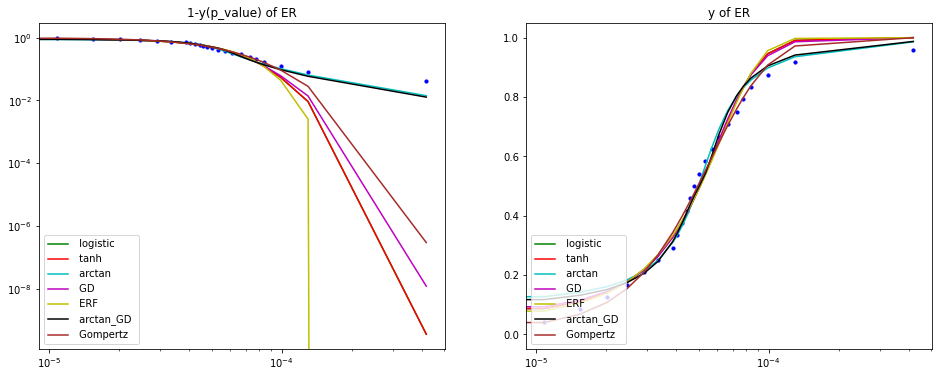

Factor for AT-ERDD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0031758847545208854, 0.004277816744535443, 0.004769437448824761, 0.005154322811140677, 0.0058010958801809846, 0.006329436475444272, 0.006798499621501558, 0.007373610651193811, 0.008218845248584152, 0.008800658796488456, 0.009611257806046157, 0.010229884291325448, 0.010886993077526436, 0.011707851269802323, 0.012454102000309825, 0.013263480998779144, 0.01464427810126265, 0.015806992687822156, 0.01744210301399909, 0.018827708294642722, 0.020774941720771756, 0.025159192011062436, 0.04690535407386832]
For  ERDD  :
curve_fit parameter on  logistic :  [1.07512038 2.53863779]
curve_fit parameter on  tanh :  [1.07512033 1.26931841]
curve_fit parameter on  arctan :  [1.05559788 2.51593788]
curve_fit parameter on  GD :  [1.07188823 1.03250419]
curve_fit parameter on  ERF :  [1.07969008 1.08162588]
curve_fit parameter on  arctan_GD :  [1.070074

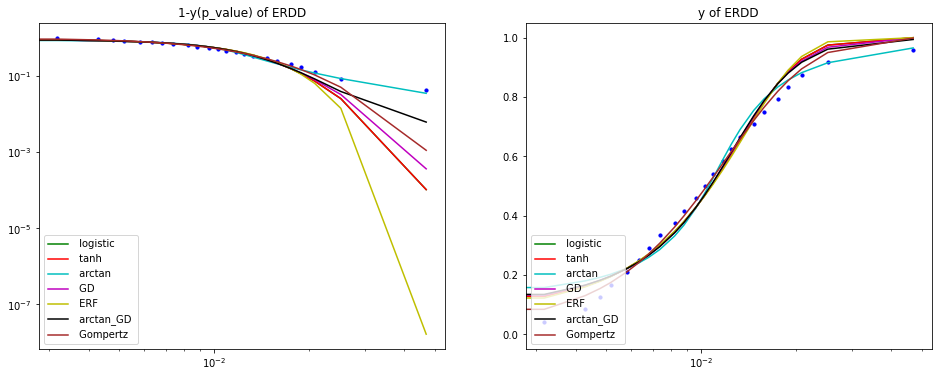

Factor for AT-GEO: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [8.450032232475552e-05, 9.88869936927653e-05, 0.00011685175573471299, 0.00012709750993083696, 0.00013415832835594226, 0.0001455399118505989, 0.00015806430473986298, 0.00016855401968514413, 0.00017973441356335776, 0.0001903489515646219, 0.00020189044764912356, 0.0002098764275920204, 0.000225541420781397, 0.00023927330896674796, 0.0002599857410730945, 0.00028006206295256474, 0.0003006528551292089, 0.00032143025118592405, 0.00035503764104818713, 0.0003999429319586306, 0.0004703123065254638, 0.0005748502051889289, 0.001137363402920848]
For  GEO  :
curve_fit parameter on  logistic :  [2.26613235 1.33951129]
curve_fit parameter on  tanh :  [2.26612946 0.66975909]
curve_fit parameter on  arctan :  [2.21920906 1.32532057]
curve_fit parameter on  GD :  [2.2596074  0.54340802]
curve_fit parameter on  ERF :  [2.27449656 0.57284214]
curve_fit para

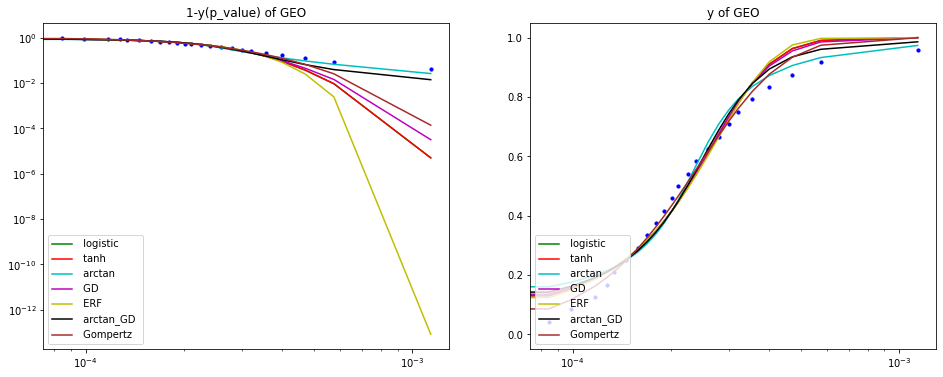

Factor for AT-GEOGD: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.00010170984419168844, 0.00012211584894140554, 0.00013489003085871037, 0.00015158008927764122, 0.00016517057652412842, 0.00018165915019925674, 0.0002005030969313127, 0.00022902772628199865, 0.00025639601359769956, 0.00028666045588759265, 0.0003176723452757374, 0.0003598727153482594, 0.0004034171234033893, 0.00044903822993352596, 0.0005200670626162152, 0.0006010677498253293, 0.0007277938876395159, 0.0008817744860812784, 0.0011856590955835365, 0.0017841903358115317, 0.0023869955601130747, 0.004574626686315653, 0.011639141227660271]
For  GEOGD  :
curve_fit parameter on  logistic :  [0.42812433 4.533013  ]
curve_fit parameter on  tanh :  [0.42812349 2.26651672]
curve_fit parameter on  arctan :  [0.40922295 4.32666737]
curve_fit parameter on  GD :  [0.42569694 1.82663962]
curve_fit parameter on  ERF :  [0.43140924 1.95184289]
curve_fit p

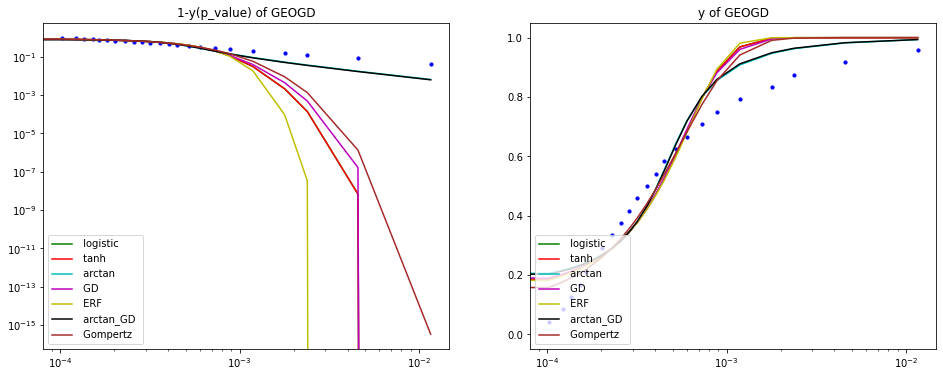

Factor for AT-HGG: 0.1
items in each bin:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15]
binned_data:  [0.03181400251572308, 0.041282381551055104, 0.04868783238603909, 0.0548837807392126, 0.06300482717178135, 0.06873587424314495, 0.07568462094077491, 0.08580076464317891, 0.09518293192296415, 0.10867444524706318, 0.12263366188866756, 0.1489658932464197, 0.17799054260056998, 0.21297991809134195, 0.253896845468488, 0.44735094218427557]
For  HGG  :
curve_fit parameter on  logistic :  [1.02096356 2.29991409]
curve_fit parameter on  tanh :  [1.02096238 1.14996084]
curve_fit parameter on  arctan :  [0.97574538 2.35623172]
curve_fit parameter on  GD :  [1.01386737 0.93829884]
curve_fit parameter on  ERF :  [1.03112582 0.97346607]
curve_fit parameter on  arctan_GD :  [ 0.99103203  5.56881735 -1.00435939]
curve_fit parameter on  Gompertz :  [1.23252689 1.62021754]


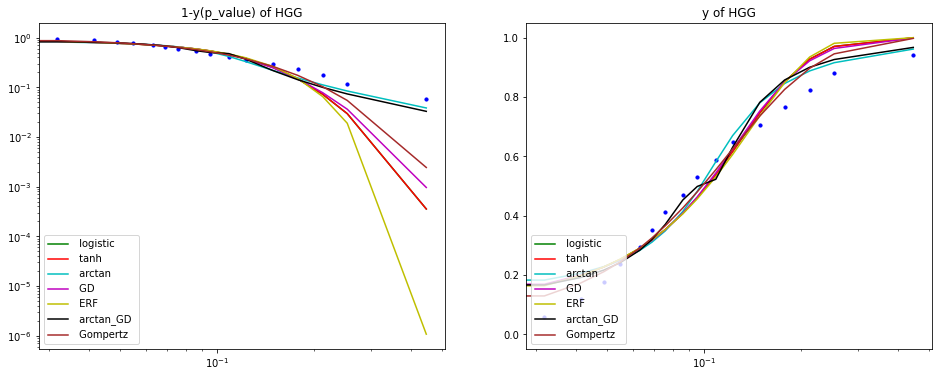

Factor for AT-SF: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [0.00013566339222981016, 0.00017486931119427187, 0.0001884638925695141, 0.00020110050632290118, 0.0002123618582219867, 0.00022045409346387013, 0.0002266659483870964, 0.00023643132834012023, 0.0002487169655125159, 0.0002616653617936598, 0.00027506415474923225, 0.00028392086884787077, 0.00029568028600073995, 0.00030885965481052766, 0.00032648536601931935, 0.00034696017051109716, 0.00036250953343718956, 0.00038062702639646376, 0.00040207696297742297, 0.0004315542455461374, 0.0004695646373727145, 0.0005406974275502944, 0.0008234153213515486]
For  SF  :
curve_fit parameter on  logistic :  [2.94451734 1.42403876]
curve_fit parameter on  tanh :  [2.94451701 0.71201998]
curve_fit parameter on  arctan :  [2.90944193 1.40479058]
curve_fit parameter on  GD :  [2.93918755 0.57791483]
curve_fit parameter on  ERF :  [2.95158669 0.60839849]
curve_fit 

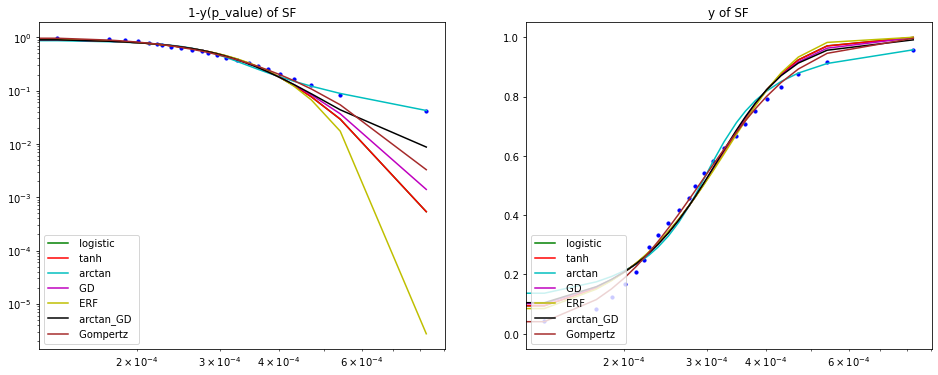

Factor for AT-SFDD: 0.1
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.005276547428645904, 0.0070606054044205745, 0.00789459835185334, 0.008760942029645268, 0.00968871081234932, 0.010754779983763516, 0.01180025628540614, 0.012610484317537118, 0.013214011290848104, 0.013881083387259557, 0.014749492710883456, 0.015645128726620047, 0.016383814132220606, 0.01774924387801238, 0.019138524702792196, 0.02117512858020939, 0.023699066647229306, 0.026701363898755204, 0.02932260806076719, 0.03363465426653322, 0.04479633179320766, 0.06398694163190759, 0.16837525556586916]
For  SFDD  :
curve_fit parameter on  logistic :  [ 0.17042892 16.18224219]
curve_fit parameter on  tanh :  [0.17042905 8.09109951]
curve_fit parameter on  arctan :  [ 0.16505616 16.36330446]
curve_fit parameter on  GD :  [0.16962243 6.58620851]
curve_fit parameter on  ERF :  [0.17147556 6.88942264]
curve_fit parameter on  arctan_GD :  [ 0.16647871 1

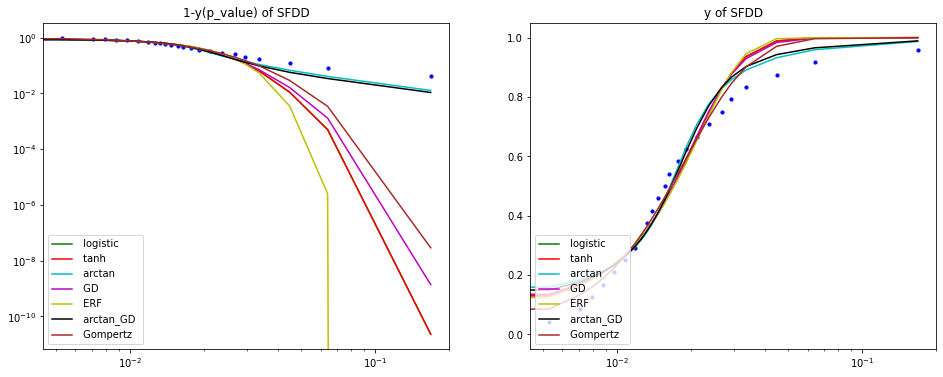

Factor for AT-Sticky: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0032016844168821098, 0.0037345978045930715, 0.0040742602262939095, 0.004291273391973335, 0.0043973935681283416, 0.004547449158754947, 0.004743289737624017, 0.004895883820022594, 0.005054969755190115, 0.005246783749164899, 0.005424913581729261, 0.005539414804983166, 0.005780802083311756, 0.00603490679314948, 0.006257775792045739, 0.006646340880037335, 0.006886301116030353, 0.007200831661630905, 0.007550906308645545, 0.007989378725275149, 0.00870913181691955, 0.009734908902017536, 0.012560304649351664]
For  Sticky  :
curve_fit parameter on  logistic :  [5.77496183 0.87224034]
curve_fit parameter on  tanh :  [5.77496269 0.43611979]
curve_fit parameter on  arctan :  [5.71007098 0.86372475]
curve_fit parameter on  GD :  [5.76554603 0.35385547]
curve_fit parameter on  ERF :  [5.78707774 0.37286559]
curve_fit parameter on  arctan_GD :  [

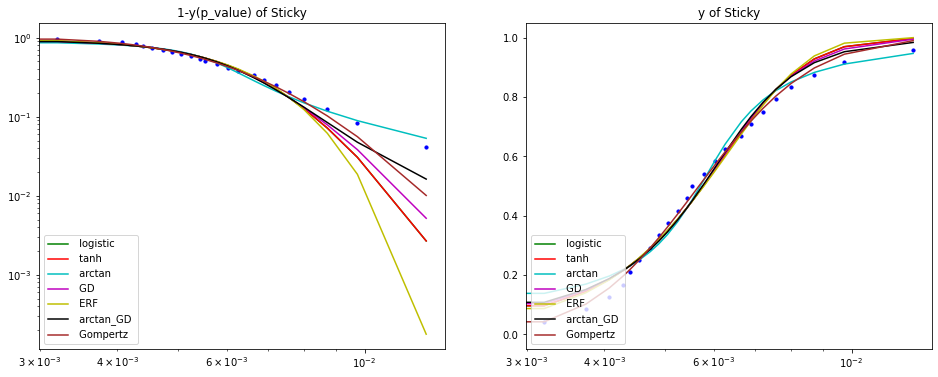

Factor for CE-ER: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [5.467544019904848e-05, 8.047458050544976e-05, 9.369292105546995e-05, 0.00010773837679965295, 0.00011843326379607184, 0.00013521232300196738, 0.00014583951143746964, 0.0001566244126099535, 0.0001681436656643695, 0.00017493108986922024, 0.0001804028083939712, 0.000188643928279529, 0.00020011076179041407, 0.00021105332583730107, 0.00021902760243218238, 0.0002300054924208689, 0.00025228439103701513, 0.00026944404045572734, 0.0002982289937437145, 0.0003199673007562195, 0.00034732856115955095, 0.00045333334358253763, 0.0009606517445608706]
For  ER  :
curve_fit parameter on  logistic :  [1.96797417 1.67376812]
curve_fit parameter on  tanh :  [1.96797303 0.83688634]
curve_fit parameter on  arctan :  [1.94403202 1.70710855]
curve_fit parameter on  GD :  [1.964117   0.68344306]
curve_fit parameter on  ERF :  [1.97314393 0.70980898]
curve_fit par

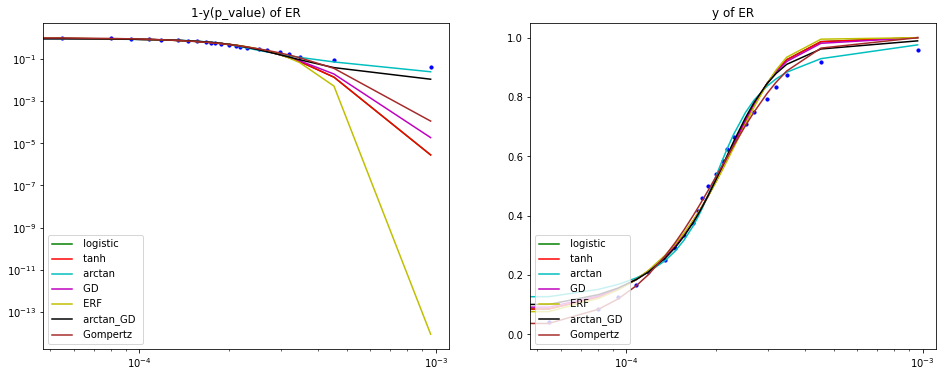

Factor for CE-ERDD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.005450885635041624, 0.0065276215090261875, 0.007292907484637608, 0.007725036175740885, 0.008055040720727023, 0.00852610572588208, 0.009020720610437665, 0.009365690607631007, 0.009783321607125419, 0.01007549211466997, 0.010411793588761197, 0.010906535975075859, 0.011307588913135286, 0.011930178604625431, 0.012581210358660304, 0.013209578303543579, 0.013819207654841893, 0.014965812168814136, 0.015966993492981616, 0.01752647479347353, 0.01948639045599876, 0.023378783868690557, 0.04925476266896397]
For  ERDD  :
curve_fit parameter on  logistic :  [1.13746416 3.65241728]
curve_fit parameter on  tanh :  [1.13746436 1.82620707]
curve_fit parameter on  arctan :  [1.12137361 3.63648897]
curve_fit parameter on  GD :  [1.13507385 1.48355731]
curve_fit parameter on  ERF :  [1.14063739 1.55858245]
curve_fit parameter on  arctan_GD :  [ 1.1314702 

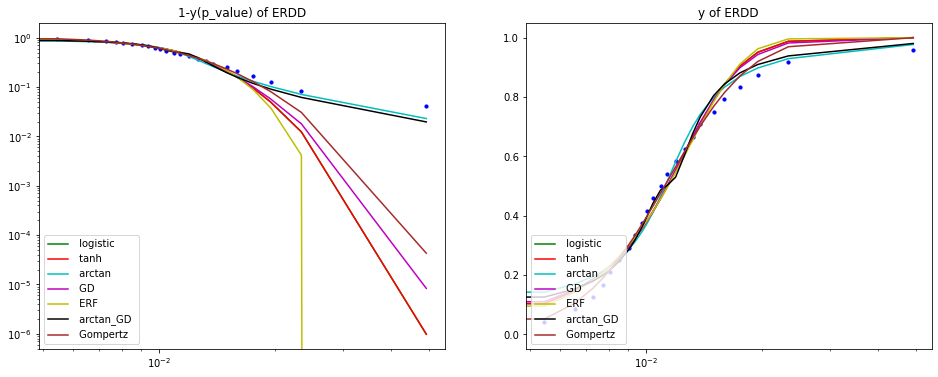

Factor for CE-GEO: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [0.000687734354034566, 0.0009271618516108324, 0.001041454396356254, 0.0011473707120883024, 0.0012262318459194163, 0.0012851538397946826, 0.0013274330740212375, 0.0014036614551506436, 0.0014635700362012978, 0.0015297967270057264, 0.0015869970590134562, 0.0016330234763147814, 0.001702395035677657, 0.0017798239768957323, 0.001892721647368925, 0.001983174317720202, 0.0020289700526720557, 0.0021071546596590626, 0.0022661770265868845, 0.002471588537721014, 0.002693489917082002, 0.0032419072831852904, 0.004462816772607084]
For  GEO  :
curve_fit parameter on  logistic :  [1.68812428 2.56283689]
curve_fit parameter on  tanh :  [1.68812428 1.28141839]
curve_fit parameter on  arctan :  [1.67447049 2.52818326]
curve_fit parameter on  GD :  [1.68626277 1.03980378]
curve_fit parameter on  ERF :  [1.69059328 1.09486009]
curve_fit parameter on  arctan_

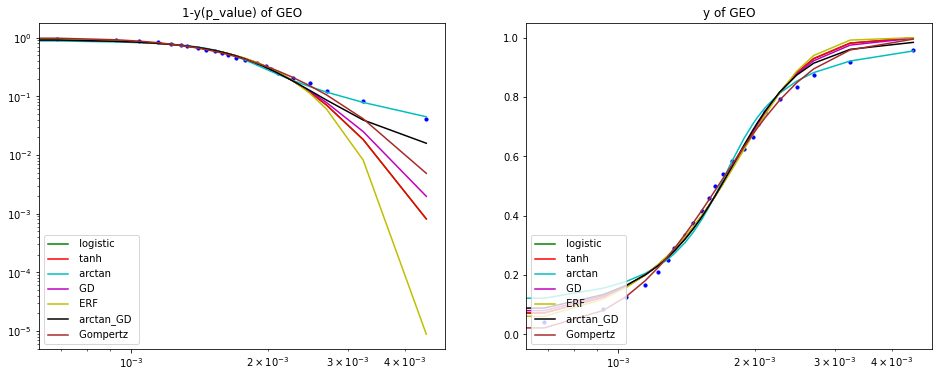

Factor for CE-GEOGD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0008973894874257128, 0.0011457798260232147, 0.001289463291765579, 0.0014217175696829105, 0.0015391803756615882, 0.0016349326828040494, 0.0017339838661736236, 0.001825783088560944, 0.0020028568377920522, 0.002179849904529667, 0.002342885422362477, 0.0025246712656795942, 0.0027674292661614085, 0.0030632635832616197, 0.0035676427453040097, 0.004019916761637601, 0.004603214235840629, 0.005489083121721927, 0.006271124711426189, 0.007364324876868316, 0.009178123173825008, 0.011852196354428038, 0.03623925148886926]
For  GEOGD  :
curve_fit parameter on  logistic :  [0.30373585 7.21898731]
curve_fit parameter on  tanh :  [0.30373522 3.6095142 ]
curve_fit parameter on  arctan :  [0.28638781 7.35621265]
curve_fit parameter on  GD :  [0.30146199 2.92926228]
curve_fit parameter on  ERF :  [0.30681001 3.0794497 ]
curve_fit parameter on  arctan_GD

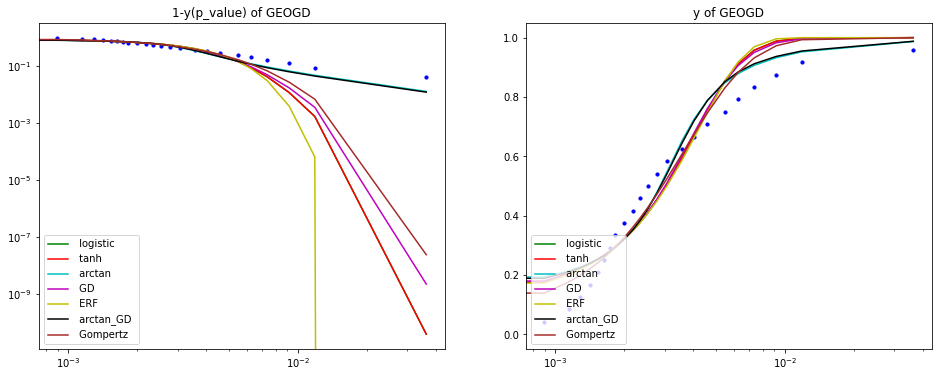

Factor for CE-HGG: 0.01
items in each bin:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15]
binned_data:  [0.015969918876409153, 0.02086786314515343, 0.02388263054617101, 0.026293836873475886, 0.02906286205172634, 0.03125958256699789, 0.034565076386872486, 0.03825631266425719, 0.04370928802656177, 0.05251654325738006, 0.06567948390398873, 0.0808409709406106, 0.10182156542097726, 0.1299305856772495, 0.18476185980382648, 0.45768877484051035]
For  HGG  :
curve_fit parameter on  logistic :  [5.14559326 0.40368373]
curve_fit parameter on  tanh :  [5.14558677 0.2018425 ]
curve_fit parameter on  arctan :  [4.80252394 0.41307615]
curve_fit parameter on  GD :  [5.10262578 0.16373985]
curve_fit parameter on  ERF :  [5.20231142 0.17236596]
curve_fit parameter on  arctan_GD :  [ 5.31104001  1.51273211 -2.16841937]
curve_fit parameter on  Gompertz :  [1.06478672 0.28954134]


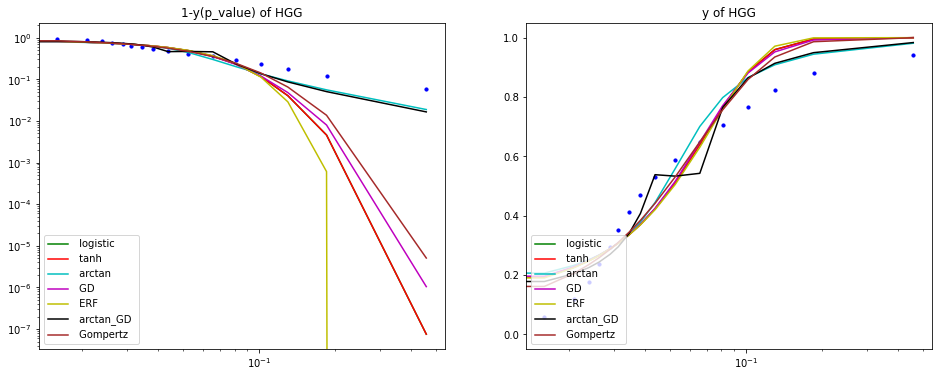

Factor for CE-SF: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0004590960188074009, 0.0005637363427591436, 0.000609598960095452, 0.0006800502287594257, 0.0007277077820856833, 0.0007604911314325446, 0.0007901297440982094, 0.000823400049245684, 0.0008423057981285031, 0.000867978605410678, 0.0008959962916479674, 0.0009255273888473161, 0.000952368873546437, 0.000995993612779888, 0.0010380940480022047, 0.0010825612333744093, 0.0011256722899137708, 0.001185702616267614, 0.0012593639020305667, 0.001345548297554033, 0.0015094100736265533, 0.0017993151812095206, 0.0024379212205331703]
For  SF  :
curve_fit parameter on  logistic :  [9.52245516 0.51248981]
curve_fit parameter on  tanh :  [9.52245395 0.25624497]
curve_fit parameter on  arctan :  [9.43662909 0.5117897 ]
curve_fit parameter on  GD :  [9.51053361 0.2081854 ]
curve_fit parameter on  ERF :  [9.53743344 0.2186391 ]
curve_fit parameter on  arctan_

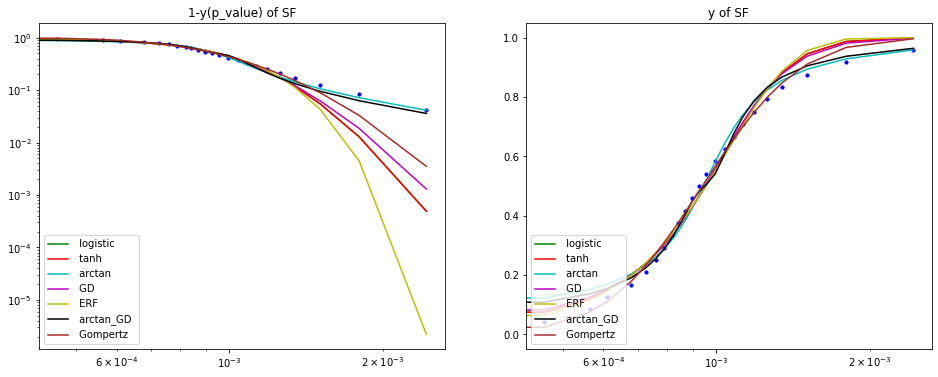

Factor for CE-SFDD: 0.1
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21]
binned_data:  [0.00930020151666805, 0.010363285525378635, 0.011282057522512238, 0.012524082426844779, 0.013597422646395513, 0.014285608440251145, 0.015430116695504682, 0.016492754951954593, 0.01762232649754401, 0.01852134400078224, 0.019964053832317898, 0.021877238662279582, 0.023734222879586972, 0.02511208765105848, 0.02708190627430849, 0.02969150646346437, 0.03475289811885764, 0.04069011668995651, 0.04568218870278803, 0.05232014211900216, 0.06388087398747283, 0.08650706070711517, 0.26307080708219427]
For  SFDD  :
curve_fit parameter on  logistic :  [ 0.24178617 10.6374299 ]
curve_fit parameter on  tanh :  [0.24178602 5.31872607]
curve_fit parameter on  arctan :  [ 0.23234197 10.83208823]
curve_fit parameter on  GD :  [0.24032046 4.33071433]
curve_fit parameter on  ERF :  [0.2439     4.51372413]
curve_fit parameter on  arctan_GD :  [0.23322566 7.8933

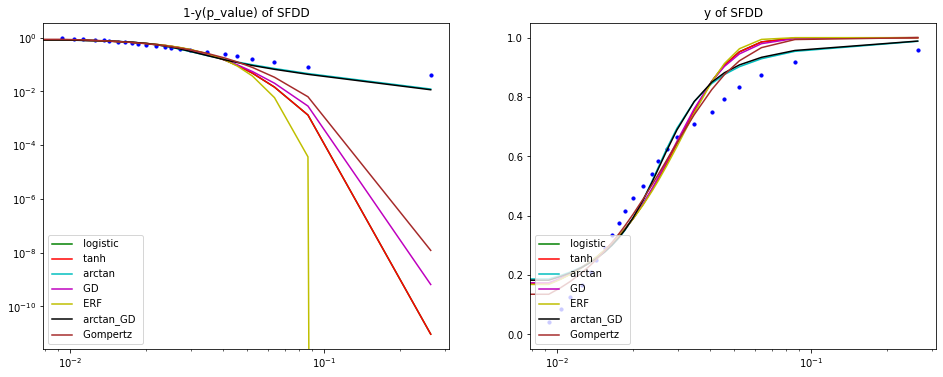

Factor for CE-Sticky: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [0.004506913996926661, 0.005160342833521333, 0.005650946631711933, 0.005921372643429166, 0.00614740423314416, 0.0065638699924136035, 0.006792928873610899, 0.0069932905874009335, 0.0072025404796388255, 0.007483896226542122, 0.007693390655254189, 0.007910555908058125, 0.00818527266931838, 0.008420621774086963, 0.008736235749199982, 0.009072560906296644, 0.009321335987737604, 0.009685171553279066, 0.010127633512691938, 0.010572837771755418, 0.011431617877834935, 0.012818339098981845, 0.015568335902638926]
For  Sticky  :
curve_fit parameter on  logistic :  [8.04472028e+01 6.96846991e-02]
curve_fit parameter on  tanh :  [8.04471967e+01 3.48423648e-02]
curve_fit parameter on  arctan :  [8.00698713e+01 6.89045920e-02]
curve_fit parameter on  GD :  [8.03948308e+01 2.82864018e-02]
curve_fit parameter on  ERF :  [8.05156035e+01 2.97704672e-02

D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


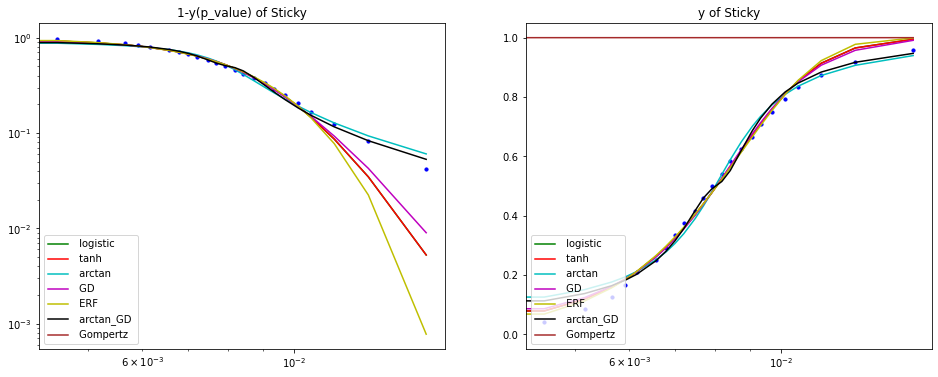

Factor for DM-ER: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [3.673097115004504e-05, 5.1843991582398254e-05, 5.893561122949209e-05, 6.986155667799493e-05, 7.530091126436087e-05, 7.968907769972812e-05, 8.507854485233822e-05, 8.927319621284304e-05, 9.42982335672369e-05, 0.00010124743826312745, 0.00010637499153204306, 0.0001108692641058695, 0.00011428043294763163, 0.00011895981053924863, 0.00012527212264270887, 0.0001329774339316897, 0.0001410583486477137, 0.00014967533644438913, 0.00016022956305038598, 0.00017567149647954925, 0.0001932789172496633, 0.00022473828225678857, 0.0006651030746132734]
For  ER  :
curve_fit parameter on  logistic :  [ 0.11277759 32.19026694]
curve_fit parameter on  tanh :  [ 0.11277759 16.09513093]
curve_fit parameter on  arctan :  [ 0.11172677 32.38521556]
curve_fit parameter on  GD :  [ 0.11260561 13.1165316 ]
curve_fit parameter on  ERF :  [ 0.11301949 13.67454065]
curve_

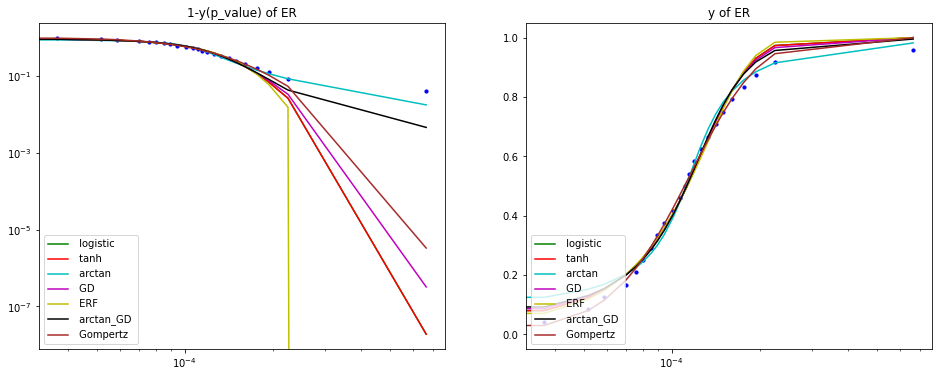

Factor for DM-ERDD: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0010773001326346613, 0.0012603430271350975, 0.0013969182783720969, 0.0014933803391349654, 0.001612178275283895, 0.0017357153973468508, 0.0018057753475190245, 0.0018914240503952685, 0.0019612129928963697, 0.002014828550345415, 0.002086528667058739, 0.0021873257173030255, 0.00226929230986507, 0.002332544101564317, 0.002403634734463063, 0.0024646024076844875, 0.00255502992768426, 0.002663551941502126, 0.002787875616902235, 0.00299125753255541, 0.0033469720078895143, 0.003824684162792095, 0.0051403594781855135]
For  ERDD  :
curve_fit parameter on  logistic :  [2.19195804 2.27521411]
curve_fit parameter on  tanh :  [2.19195796 1.1376074 ]
curve_fit parameter on  arctan :  [2.1884232  2.25038171]
curve_fit parameter on  GD :  [2.19156176 0.92394834]
curve_fit parameter on  ERF :  [2.19267129 0.97062758]
curve_fit parameter on  arctan_GD :

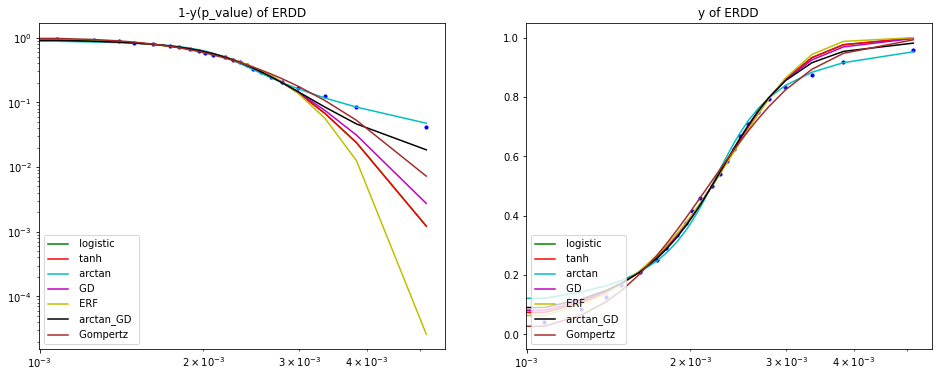

Factor for DM-GEO: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.00022067112656827813, 0.00028326252747469955, 0.00031075962886469797, 0.00033722170420490925, 0.0003693517349838273, 0.00038993161899764095, 0.00041441253633081344, 0.00043053987558387333, 0.0004492030347445167, 0.0004678286604578523, 0.00048171868516551624, 0.0004987613102186878, 0.0005249492867842699, 0.0005514088710370148, 0.0005758465550025488, 0.0006077052475344037, 0.0006423222043425116, 0.0006826821757181996, 0.0007299688102338711, 0.0008068529506414768, 0.0009072054632940417, 0.0010553242072043588, 0.0015749857844350199]
For  GEO  :
curve_fit parameter on  logistic :  [5.22479527 0.76967766]
curve_fit parameter on  tanh :  [5.22479744 0.38483791]
curve_fit parameter on  arctan :  [5.15934205 0.77120717]
curve_fit parameter on  GD :  [5.21539456 0.31288037]
curve_fit parameter on  ERF :  [5.23718769 0.32805005]
curve_fit para

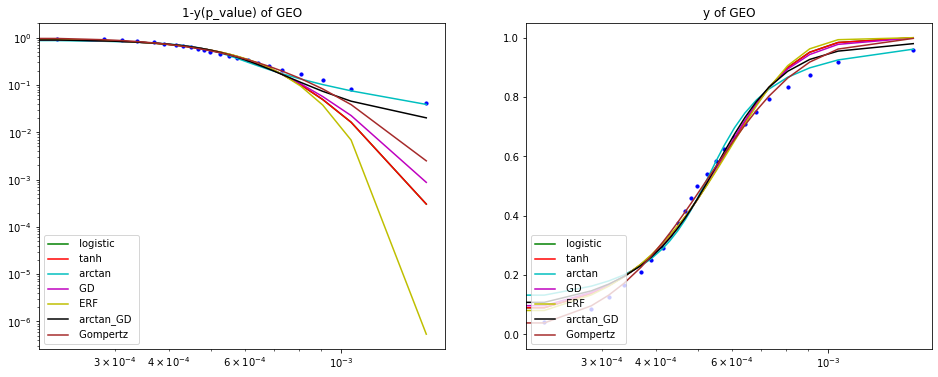

Factor for DM-GEOGD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21]
binned_data:  [0.00022740215264195114, 0.0005200964447540927, 0.0006406202913629203, 0.0007603644470695298, 0.0008149083937883631, 0.0008797721756159543, 0.0009372604226075655, 0.0010090845040341785, 0.0010943170191209674, 0.0012377863241113173, 0.0013906437719978667, 0.0015484237626649821, 0.0017730286309429002, 0.0020008896084253228, 0.0023356171553943765, 0.0027801216255994338, 0.003337315886551138, 0.0042707865830246584, 0.005411996419709266, 0.008705443458020736, 0.014621195718494906, 0.02863342187807518, 0.14191068955673442]
For  GEOGD  :
curve_fit parameter on  logistic :  [0.19314282 9.75701484]
curve_fit parameter on  tanh :  [0.19314275 4.87851112]
curve_fit parameter on  arctan :  [0.18265426 9.46285072]
curve_fit parameter on  GD :  [0.19172077 3.942679  ]
curve_fit parameter on  ERF :  [0.19523415 4.17568183]
curve_fit parameter on  arc

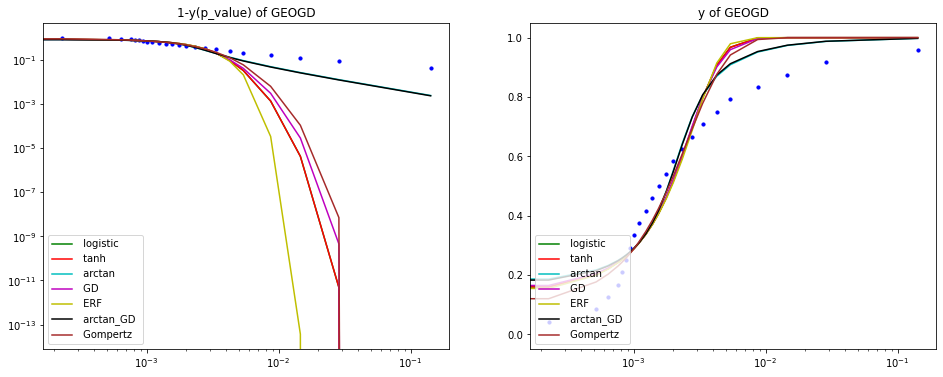

Factor for DM-HGG: 0.1
items in each bin:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15]
binned_data:  [0.014240761527233935, 0.026237473140339904, 0.03191335855334455, 0.03764382084756629, 0.042522096576268785, 0.048504212933190974, 0.05523073875074534, 0.05957838672887935, 0.0679041585917001, 0.07379180583796494, 0.08353683974822709, 0.09490774056036434, 0.11428187027586828, 0.14384888456680145, 0.20203221959901393, 0.4885544868526846]
For  HGG  :
curve_fit parameter on  logistic :  [0.68568215 3.59665144]
curve_fit parameter on  tanh :  [0.68568211 1.79832599]
curve_fit parameter on  arctan :  [0.66947367 3.55228186]
curve_fit parameter on  GD :  [0.68339493 1.45931504]
curve_fit parameter on  ERF :  [0.68874772 1.53758006]
curve_fit parameter on  arctan_GD :  [0.67472553 2.05532235 0.5653283 ]
curve_fit parameter on  Gompertz :  [1.25183432 2.42163072]


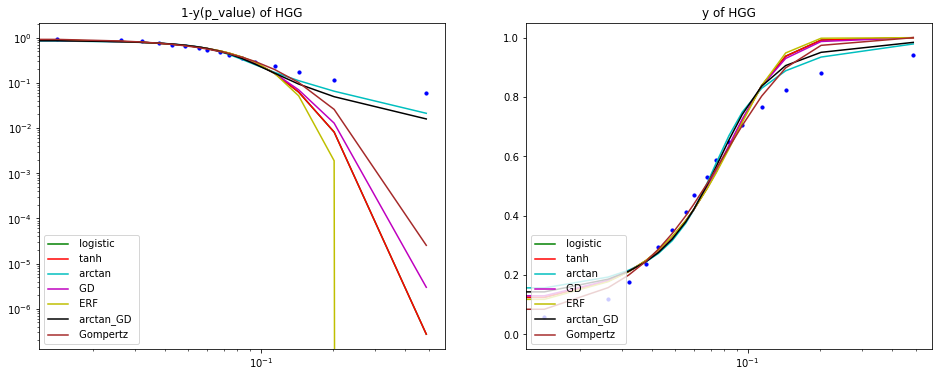

Factor for DM-SF: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0004455365029289293, 0.0005836894671453221, 0.0006413016884780543, 0.0006796963584943458, 0.000719870664227423, 0.0007558576359066013, 0.0007982217168705826, 0.0008406872907931042, 0.0008788329659044195, 0.0009192382164930113, 0.0009494795574153592, 0.0009866493325991605, 0.0010454894028070786, 0.0010859232186852764, 0.001145202870517551, 0.0012201091931145142, 0.0012796343335940855, 0.0013282022850166536, 0.00140228992826992, 0.0015817052922733465, 0.0016817039217205594, 0.001984987806300788, 0.003488128675356393]
For  SF  :
curve_fit parameter on  logistic :  [1.03094085 3.9289249 ]
curve_fit parameter on  tanh :  [1.03094038 1.96446607]
curve_fit parameter on  arctan :  [1.01912458 3.87724585]
curve_fit parameter on  GD :  [1.0292009 1.5950247]
curve_fit parameter on  ERF :  [1.03328914 1.67716967]
curve_fit parameter on  arctan_GD

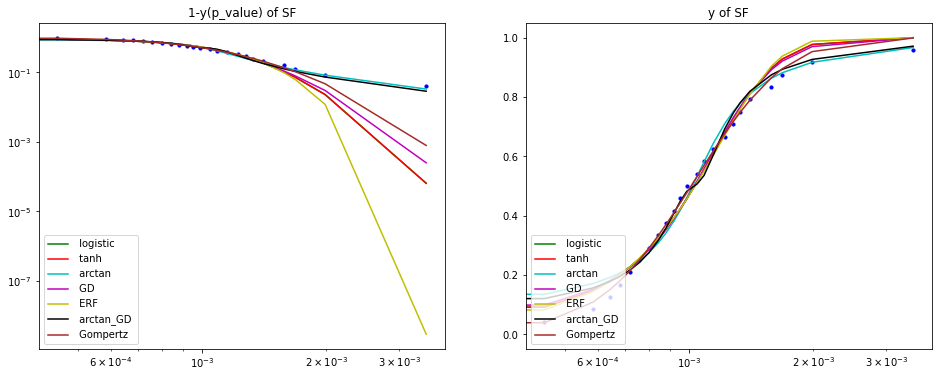

Factor for DM-SFDD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21]
binned_data:  [0.003776496415314018, 0.004614144418992037, 0.004989338193857645, 0.005181456320132318, 0.0054436465422096686, 0.005789703061761054, 0.006104132399622389, 0.006398862418479894, 0.006706193309453212, 0.007011579329954737, 0.007238239884885377, 0.007410438184177719, 0.007573239085256218, 0.007778010614032175, 0.008067963311937652, 0.008484707607048066, 0.008967756794503822, 0.009457236304418415, 0.010138581186745139, 0.010872922250288254, 0.01210046244491569, 0.014161486712842956, 0.023664195845902757]
For  SFDD  :
curve_fit parameter on  logistic :  [0.75283336 6.29534334]
curve_fit parameter on  tanh :  [0.75283336 3.14767213]
curve_fit parameter on  arctan :  [0.74680067 6.40177216]
curve_fit parameter on  GD :  [0.75188088 2.56328296]
curve_fit parameter on  ERF :  [0.75414635 2.68006987]
curve_fit parameter on  arctan_GD :  [0.74945

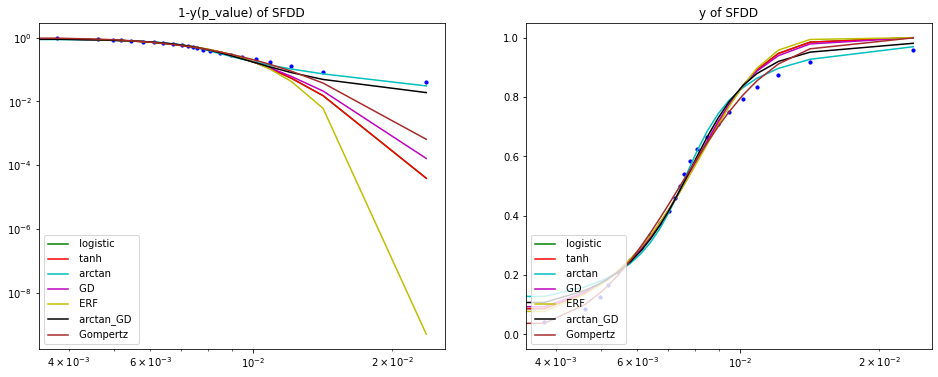

Factor for DM-Sticky: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0019435218001172955, 0.002365163528178876, 0.002625658106291884, 0.002835127239576674, 0.00296477481623362, 0.0031735478392555523, 0.0033026167717475604, 0.003435366320134679, 0.0035300877261809447, 0.003690455151662736, 0.0038587047940327507, 0.003983531596988412, 0.004076245184145726, 0.004187656300038272, 0.004330289703435961, 0.004580410574465814, 0.004706415679284346, 0.004848687642308388, 0.005029193041398815, 0.0053393049615310054, 0.005986637103413388, 0.006920144725043865, 0.012633029860612478]
For  Sticky  :
curve_fit parameter on  logistic :  [ 0.39929216 12.82248884]
curve_fit parameter on  tanh :  [0.39929218 6.41124214]
curve_fit parameter on  arctan :  [ 0.39821299 12.62188151]
curve_fit parameter on  GD :  [0.39915378 5.2031849 ]
curve_fit parameter on  ERF :  [0.39947579 5.47942275]
curve_fit parameter on  arctan_G

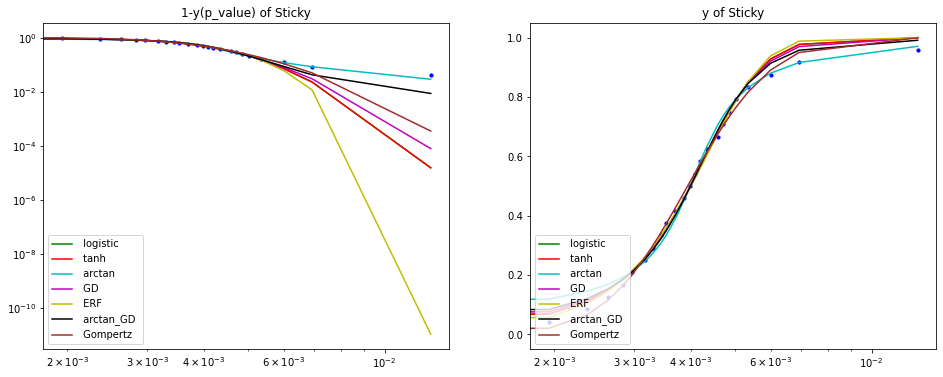

Factor for EC-ER: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [0.00023475339364692393, 0.0003295094228806803, 0.00039716146507462816, 0.00045792990295923596, 0.0005350001517643326, 0.000579452748358593, 0.0006113723967112016, 0.0006508966286806737, 0.0006982105933780797, 0.0007309777211499075, 0.00076129440619951, 0.0007937410467869327, 0.0008292328064867272, 0.0008702901843510867, 0.0009216464532088378, 0.0009994589875586288, 0.0010916465456474091, 0.0011547293514884318, 0.0011992058800126396, 0.0012645286742016596, 0.0013943232229192085, 0.0017790249176440115, 0.007592238051976526]
For  ER  :
curve_fit parameter on  logistic :  [0.827452   4.03788029]
curve_fit parameter on  tanh :  [0.82745199 2.01893894]
curve_fit parameter on  arctan :  [0.81549451 4.08313249]
curve_fit parameter on  GD :  [0.82572216 1.64546141]
curve_fit parameter on  ERF :  [0.82940436 1.71885843]
curve_fit parameter on  ar

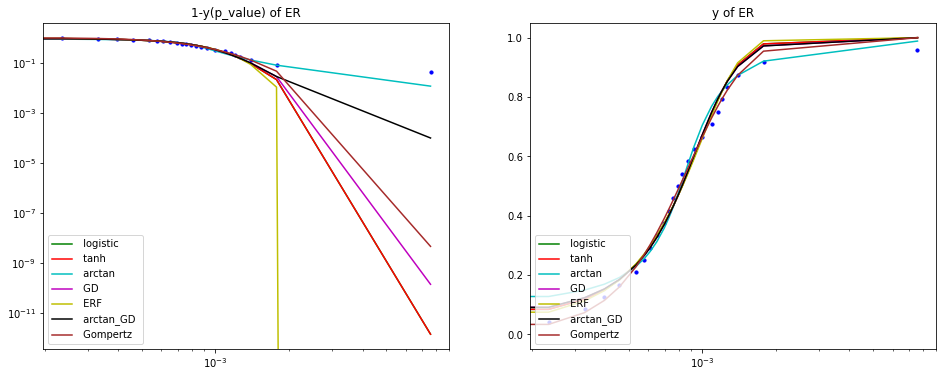

Factor for EC-ERDD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0029325192320127733, 0.003571767075866258, 0.003833335506586544, 0.004129502080081473, 0.004377018524961751, 0.004651182482657979, 0.004918160480964495, 0.005123917021454163, 0.005347985425809509, 0.0054778697568434965, 0.005646163888541799, 0.005854815829062115, 0.006088467682018915, 0.006336156377451437, 0.006583104110380042, 0.006784593552135601, 0.007099635525980044, 0.007418203999309758, 0.007680348802977531, 0.008000187952663924, 0.008697355417646968, 0.009612574823092596, 0.015988259084192435]
For  ERDD  :
curve_fit parameter on  logistic :  [0.59715438 8.25714692]
curve_fit parameter on  tanh :  [0.59715432 4.12857364]
curve_fit parameter on  arctan :  [0.5943787  8.14715589]
curve_fit parameter on  GD :  [0.596752   3.35584613]
curve_fit parameter on  ERF :  [0.59769066 3.52049485]
curve_fit parameter on  arctan_GD :  [0.596

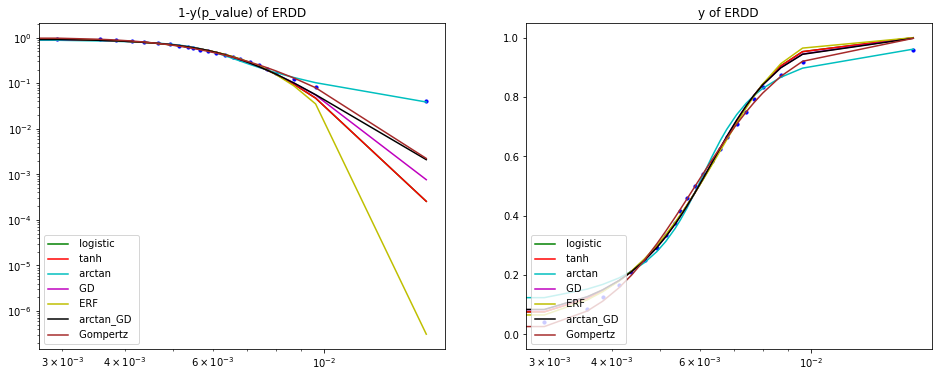

Factor for EC-GEO: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0020194001650077117, 0.0024699503542365874, 0.002693888186019092, 0.002923633535365612, 0.003194927222006122, 0.0034960667500102487, 0.0036515759929632925, 0.0037688089048067076, 0.003956193191370495, 0.004136308077819502, 0.004319617454085553, 0.004512043618276513, 0.004720905789899996, 0.0049295101780935, 0.00513931253179454, 0.005389599661699242, 0.0056790988280899166, 0.006117051947265902, 0.006515468013144924, 0.007057530279140472, 0.0075117075232240356, 0.00865469750028329, 0.016468882445186486]
For  GEO  :
curve_fit parameter on  logistic :  [0.46480324 8.55065094]
curve_fit parameter on  tanh :  [0.46480339 4.27532007]
curve_fit parameter on  arctan :  [0.45985166 8.56976877]
curve_fit parameter on  GD :  [0.46397715 3.48375328]
curve_fit parameter on  ERF :  [0.4659675  3.63270861]
curve_fit parameter on  arctan_GD :  [0.4632

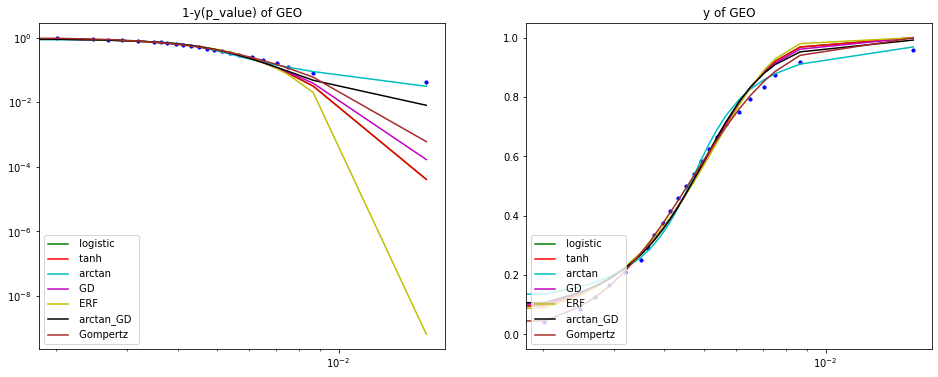

Factor for EC-GEOGD: 0.1
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0031730318689885463, 0.003959250014998115, 0.00444350899355419, 0.004831924115375988, 0.005252771148020681, 0.00568922316920564, 0.005953097290913311, 0.006288088943576914, 0.006977215543910651, 0.007510218869406035, 0.008259058280390476, 0.009180632886355825, 0.010452024014859966, 0.01157953963789113, 0.01292857298302635, 0.013990471201505787, 0.015786079651286294, 0.01759974711683244, 0.02047411156851613, 0.023224504943750453, 0.026382241901429078, 0.038814795907473214, 0.11366587970774779]
For  GEOGD  :
curve_fit parameter on  logistic :  [ 0.10742031 20.7460797 ]
curve_fit parameter on  tanh :  [ 0.10742029 10.37304511]
curve_fit parameter on  arctan :  [ 0.10326961 20.29402791]
curve_fit parameter on  GD :  [0.10680759 8.4070087 ]
curve_fit parameter on  ERF :  [0.10830499 8.85801792]
curve_fit parameter on  arctan_GD :  [ 0.104

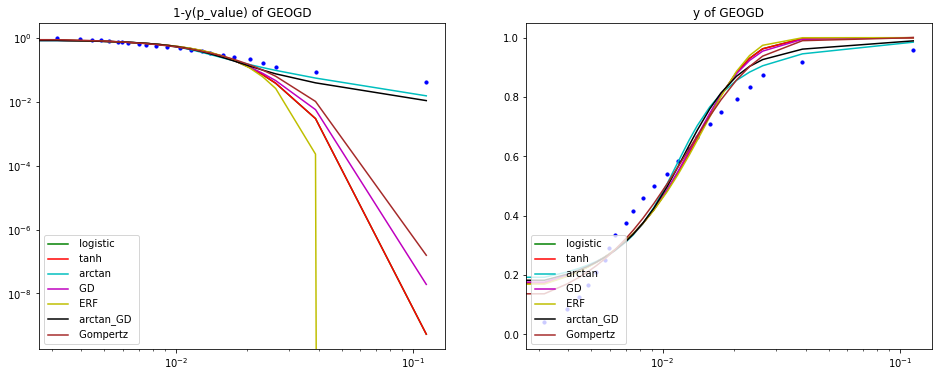

Factor for EC-HGG: 0.1
items in each bin:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15]
binned_data:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
For  HGG  :
curve_fit parameter on  logistic :  [0.12061369 0.97593958]
curve_fit parameter on  tanh :  [0.06030684 0.97593958]
curve_fit parameter on  arctan :  [0.09447732 0.98078227]
curve_fit parameter on  GD :  [0.04538916 1.01928811]
curve_fit parameter on  ERF :  [0.05092246 1.02409032]
curve_fit parameter on  arctan_GD :  [0.06270825 1.00026461 0.47584491]
curve_fit parameter on  Gompertz :  [-0.2826656  1.       ]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_8044/887273584.py:106: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[0].set_xscale('log')
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\shiqi jiang\AppData\Roaming\Python\Python38\site-packages\matplotlib_inline\backend_inline.py:234: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


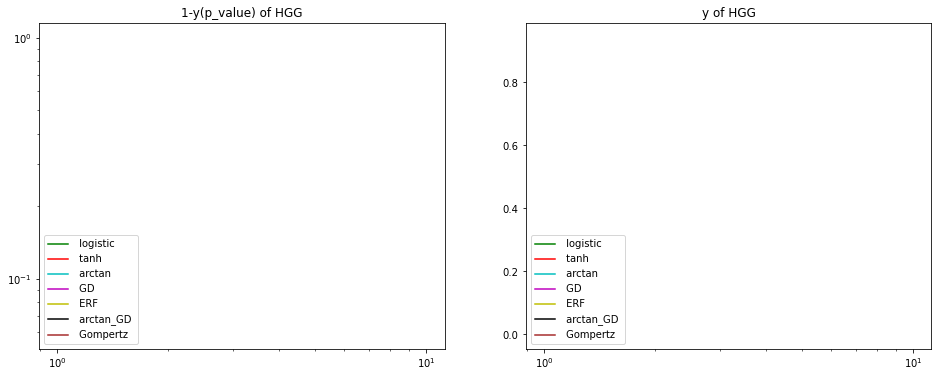

Factor for EC-SF: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [0.002812155815538528, 0.003625472858826026, 0.003983360652839886, 0.004267446606104858, 0.004459288911165215, 0.0046513442702377904, 0.00479216005663732, 0.004940575744569389, 0.005121643012977659, 0.005280724351602528, 0.005424994282771508, 0.005672917231546158, 0.005863656799543777, 0.006020078137125052, 0.006277155082288776, 0.006449142145328826, 0.006699647736144446, 0.007028109713248308, 0.007331445477214994, 0.0077763499286709215, 0.00829553092804949, 0.009199184184270874, 0.012867222662692754]
For  SF  :
curve_fit parameter on  logistic :  [5.75005223 0.93032016]
curve_fit parameter on  tanh :  [5.75005277 0.46515976]
curve_fit parameter on  arctan :  [5.71571859 0.9178888 ]
curve_fit parameter on  GD :  [5.74453697 0.37782011]
curve_fit parameter on  ERF :  [5.7577428  0.39667764]
curve_fit parameter on  arctan_GD :  [5.74046445

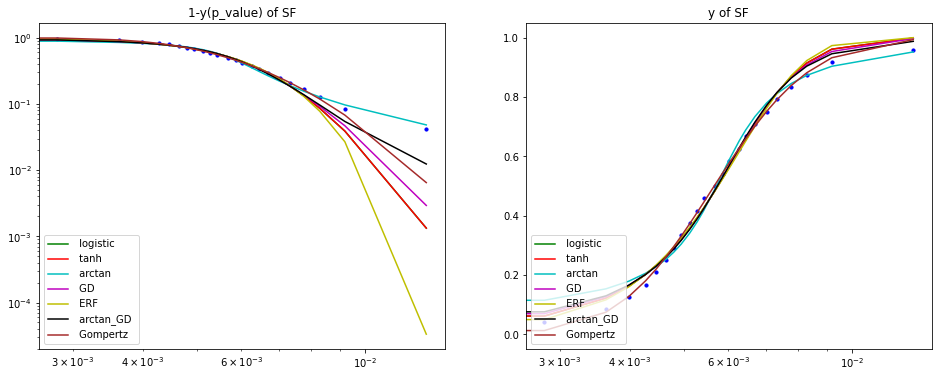

Factor for EC-SFDD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21]
binned_data:  [0.019832877189847328, 0.02834656036284462, 0.03122997549826663, 0.03403620884037726, 0.036658524461179336, 0.039612047140596574, 0.04157571037930599, 0.04300956909243834, 0.04407758019968994, 0.04585468373963709, 0.0482750147155367, 0.05061290107409892, 0.05279990774954846, 0.05459090077370187, 0.056850336461110394, 0.05945589882424656, 0.06255746197969082, 0.06627551337001623, 0.07105451763668673, 0.07610062079993611, 0.08700002520264041, 0.10167538596898759, 0.18557635742402426]
For  SFDD  :
curve_fit parameter on  logistic :  [5.16695992 0.81335829]
curve_fit parameter on  tanh :  [5.16696269 0.40667794]
curve_fit parameter on  arctan :  [5.12308456 0.80762999]
curve_fit parameter on  GD :  [5.16026107 0.33048868]
curve_fit parameter on  ERF :  [5.17586172 0.34691041]
curve_fit parameter on  arctan_GD :  [5.14813804 0.39013359 0.778

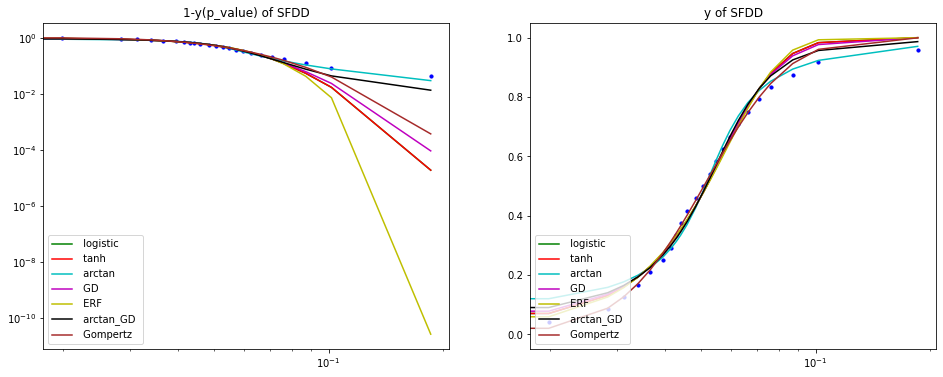

Factor for EC-Sticky: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.006555623288867338, 0.007848968047210983, 0.008438486903586574, 0.008835263356418861, 0.009425810455721632, 0.010034061841667241, 0.01042718384872342, 0.010870450629347703, 0.011169096723646594, 0.011741993360044336, 0.01217750191472688, 0.012656655902929727, 0.013032848558299061, 0.013484427453670815, 0.013950488737112215, 0.014314612943976348, 0.014921788673274998, 0.015710699549364576, 0.01634337621229497, 0.017384425191033098, 0.01866642561139476, 0.02090922261431886, 0.031000597400002366]
For  Sticky  :
curve_fit parameter on  logistic :  [1.27319816 3.94616475]
curve_fit parameter on  tanh :  [1.27319816 1.97308222]
curve_fit parameter on  arctan :  [1.2686576 3.8968248]
curve_fit parameter on  GD :  [1.27243005 1.60327191]
curve_fit parameter on  ERF :  [1.27439114 1.68286732]
curve_fit parameter on  arctan_GD :  [ 1.2679447

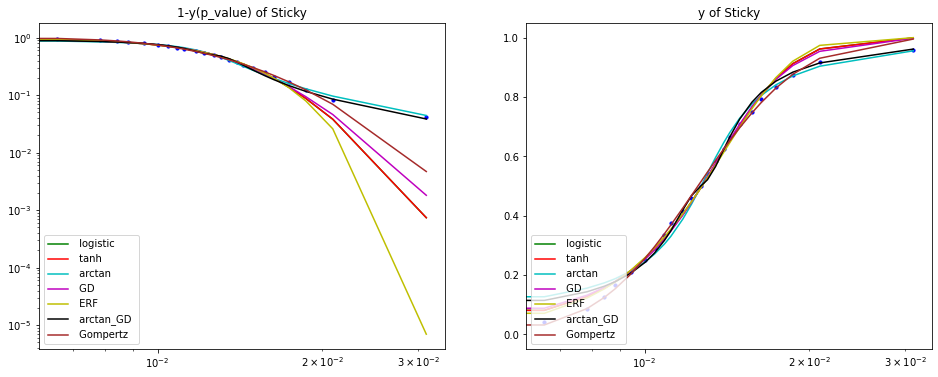

Factor for HS-ER: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [8.574036247121381e-06, 1.2350947220569772e-05, 1.3727837485697364e-05, 1.5194788763419497e-05, 1.7726089946332432e-05, 1.9788409974478358e-05, 2.1006163268370498e-05, 2.2303132860755322e-05, 2.347071041158843e-05, 2.4465593540383845e-05, 2.6112252165639498e-05, 2.8154531495096823e-05, 2.978030881815281e-05, 3.094235512436009e-05, 3.316510249922713e-05, 3.5797385804474796e-05, 3.853805265942345e-05, 4.259350041933684e-05, 4.6269935629380647e-05, 5.198876090196568e-05, 6.363073638033931e-05, 9.056889132359931e-05, 0.000421136466309169]
For  ER  :
curve_fit parameter on  logistic :  [ 0.29377203 10.28276769]
curve_fit parameter on  tanh :  [0.29377216 5.14137322]
curve_fit parameter on  arctan :  [ 0.28854931 10.22232021]
curve_fit parameter on  GD :  [0.29298464 4.17984732]
curve_fit parameter on  ERF :  [0.29482041 4.38301019]
curve_fit

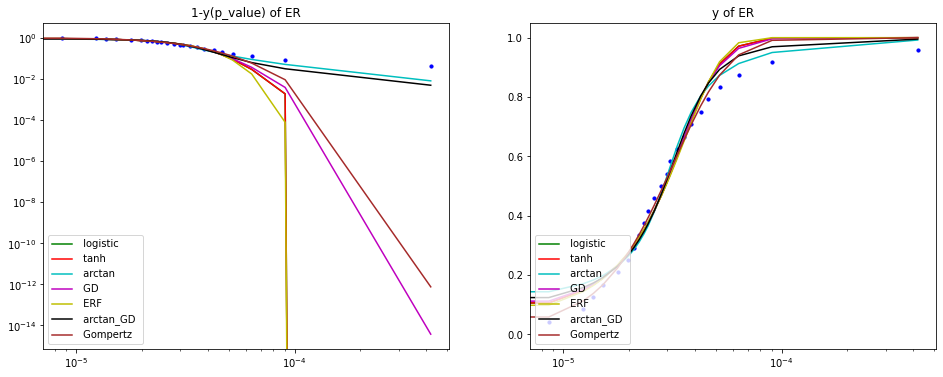

Factor for HS-ERDD: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0008182203788422535, 0.0010061712559289782, 0.0011343160575954998, 0.00124969757627708, 0.0013046015068953907, 0.0014143516267847694, 0.001530582385365966, 0.0015951308976658585, 0.0016622681739378849, 0.0017288451317221717, 0.001848294560617207, 0.0019348779499462206, 0.0019836206671552514, 0.0020788335954460115, 0.0021609931899625977, 0.0022628542495326666, 0.0023736471023948795, 0.0025031028039154564, 0.0026826936077235346, 0.002838149697028325, 0.0031353226475410883, 0.0037430164354523643, 0.00850690188886005]
For  ERDD  :
curve_fit parameter on  logistic :  [1.94698514 2.07382617]
curve_fit parameter on  tanh :  [1.94698504 1.0369128 ]
curve_fit parameter on  arctan :  [1.93592575 2.05268981]
curve_fit parameter on  GD :  [1.9451957  0.84302533]
curve_fit parameter on  ERF :  [1.94951516 0.88450775]
curve_fit parameter on  arct

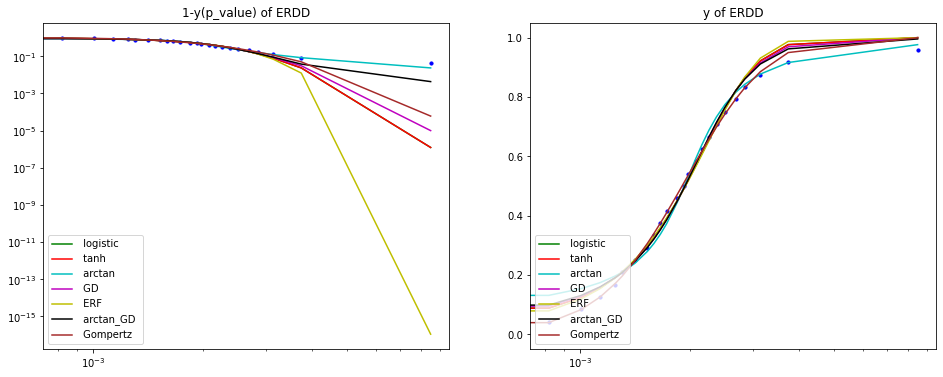

Factor for HS-GEO: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [9.772784610238227e-05, 0.00013192450199291724, 0.00014580559755547, 0.0001569922786022747, 0.00016716463792013902, 0.0001793059946410065, 0.0001901762377495374, 0.00020417218091261027, 0.00021628213404842038, 0.00022452749986612045, 0.0002340437103582081, 0.0002475035376375796, 0.0002598645671478993, 0.00027138060974553097, 0.0002865529835509081, 0.0003007809186697505, 0.0003250859997811419, 0.0003559757330749119, 0.00039022131545959947, 0.0004300135830857077, 0.0004946393736537447, 0.0005798751787286988, 0.0008714930290983822]
For  GEO  :
curve_fit parameter on  logistic :  [2.57749858 1.35549696]
curve_fit parameter on  tanh :  [2.57749511 0.67775301]
curve_fit parameter on  arctan :  [2.53612473 1.36810554]
curve_fit parameter on  GD :  [2.57110711 0.55155123]
curve_fit parameter on  ERF :  [2.58632563 0.57697601]
curve_fit paramet

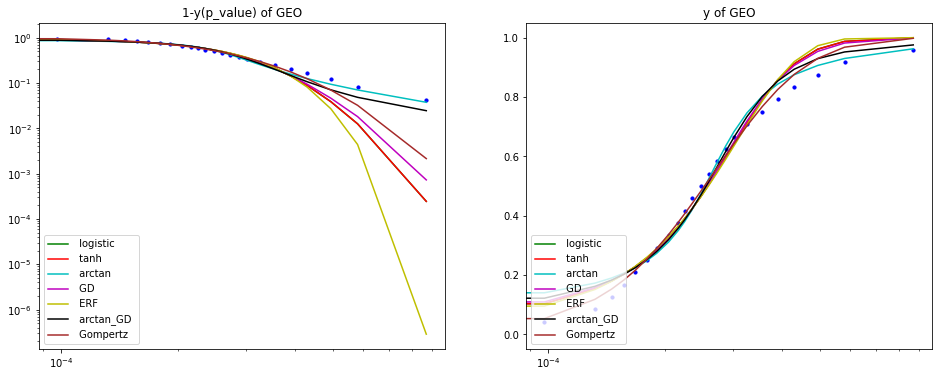

Factor for HS-GEOGD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [0.00014331131842561606, 0.00020637040762358784, 0.00025093610482597147, 0.00027645964987764584, 0.00030051792789290486, 0.000322940117511295, 0.00035987982055338296, 0.00039419276840638265, 0.0004272849258597705, 0.000479362801256432, 0.0005412699951177427, 0.0006252171813926963, 0.0007541938119920808, 0.0008664741931299053, 0.000996288693137881, 0.0011956691958292587, 0.0015603880680407367, 0.0019714314696450573, 0.0025712003277379523, 0.003858986025004535, 0.006661252572906546, 0.012380231570898367, 0.03687275547716218]
For  GEOGD  :
curve_fit parameter on  logistic :  [ 0.08262321 21.10613057]
curve_fit parameter on  tanh :  [ 0.08262319 10.5530722 ]
curve_fit parameter on  arctan :  [ 0.07760785 20.46316263]
curve_fit parameter on  GD :  [0.08197964 8.51335664]
curve_fit parameter on  ERF :  [0.08357277 9.05441592]
curve_fit param

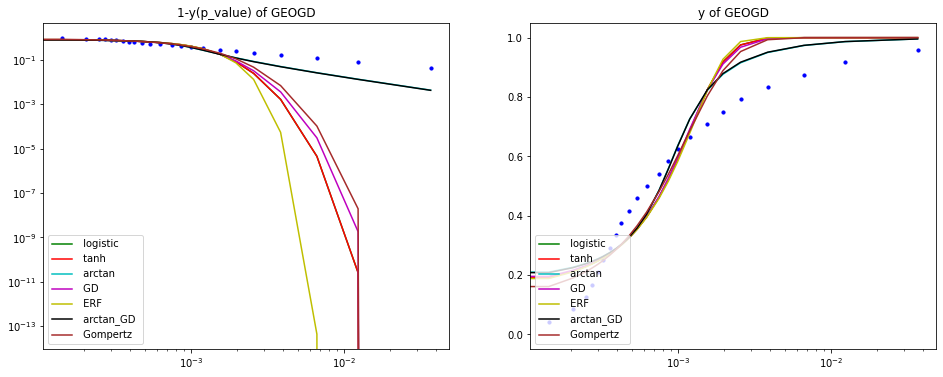

Factor for HS-HGG: 0.1
items in each bin:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9]
binned_data:  [0.032470485777490135, 0.047476989051882176, 0.053287679546154175, 0.06138461229331843, 0.07041160588506064, 0.07921297625028895, 0.09135106149487507, 0.10870072650473336, 0.16641425057793197, 0.22014037864414587, 0.4952847129527199]
For  HGG  :
curve_fit parameter on  logistic :  [0.88027074 2.8966    ]
curve_fit parameter on  tanh :  [0.88027168 1.44829439]
curve_fit parameter on  arctan :  [0.84460928 3.035906  ]
curve_fit parameter on  GD :  [0.87398473 1.18852032]
curve_fit parameter on  ERF :  [0.89205167 1.20431241]
curve_fit parameter on  arctan_GD :  [0.84572015 2.42930849 0.22162988]
curve_fit parameter on  Gompertz :  [1.29642565 1.90725361]


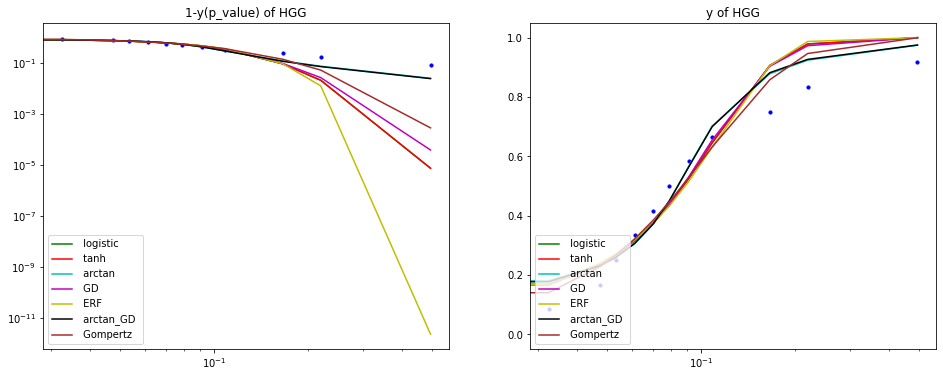

Factor for HS-SF: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [7.337761656109279e-05, 9.26024059789544e-05, 0.00010310309922244933, 0.00010979580980778766, 0.00011615358313727966, 0.00012094493431141509, 0.0001245865571315969, 0.00012880537331092325, 0.0001372278544989085, 0.00014378148665185754, 0.00014696735307409588, 0.00015307379082219426, 0.0001583861557120851, 0.00016513352872248166, 0.00017487946263080177, 0.00018065223155745277, 0.00018673696064931412, 0.00019484561170720534, 0.00020339246675748942, 0.0002211137066082547, 0.00024133558990144802, 0.000275363552546505, 0.00040581186540834325]
For  SF  :
curve_fit parameter on  logistic :  [1.56569393 2.97564243]
curve_fit parameter on  tanh :  [1.56569394 1.48782104]
curve_fit parameter on  arctan :  [1.5554332 2.9165386]
curve_fit parameter on  GD :  [1.56422949 1.20659545]
curve_fit parameter on  ERF :  [1.56773142 1.27207812]
curve_fit pa

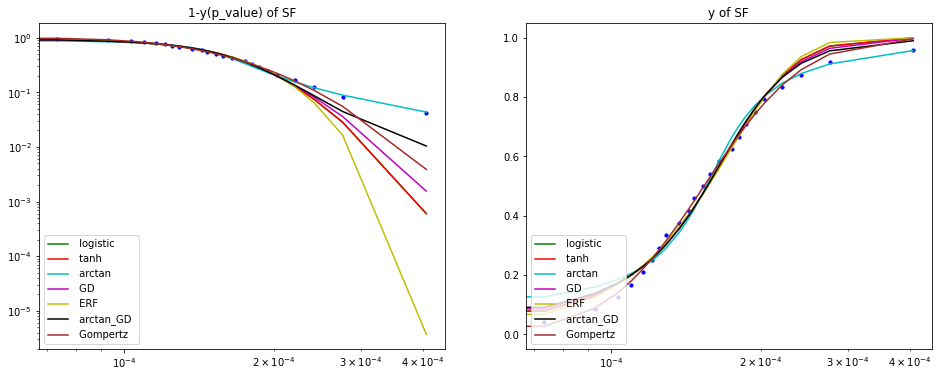

Factor for HS-SFDD: 0.1
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21]
binned_data:  [0.004757724157705794, 0.005825302144957244, 0.006374028837638255, 0.006984049028202485, 0.0077370725572232105, 0.008701585843578722, 0.009531790962581312, 0.010041023658974186, 0.010724595121253906, 0.011593259232921099, 0.012557010322597898, 0.013534101274469303, 0.015334788272560268, 0.016778775633595075, 0.01817869835756132, 0.019955007058796537, 0.022757258768356856, 0.026028741806759324, 0.03210053762785997, 0.03986249913182921, 0.05174354752666868, 0.0814087720009206, 0.20899126366279472]
For  SFDD  :
curve_fit parameter on  logistic :  [ 0.15521873 15.32405928]
curve_fit parameter on  tanh :  [0.15521885 7.66201178]
curve_fit parameter on  arctan :  [ 0.15053289 14.73905552]
curve_fit parameter on  GD :  [0.15464187 6.17958619]
curve_fit parameter on  ERF :  [0.1559543  6.60168489]
curve_fit parameter on  arctan_GD :  [ 0.1513528

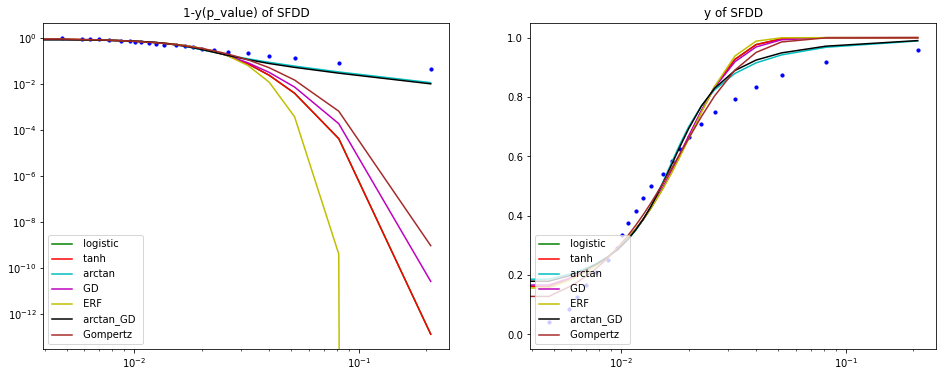

Factor for HS-Sticky: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0011535143419721268, 0.0013791530754442578, 0.001537512503662282, 0.0016500633881015574, 0.0017418136026012595, 0.0017981526493590625, 0.0018453660892602008, 0.0019103676443984812, 0.001998222197092744, 0.002072435865552912, 0.002153712553006642, 0.002202768926933064, 0.002290365820651708, 0.002367685583955785, 0.0024634515914235522, 0.0025433698092375435, 0.0026271914358362465, 0.0027546862831856708, 0.0029045180922324205, 0.003019771736998016, 0.0032244735921935067, 0.0035306384597961317, 0.0043867409855191985]
For  Sticky  :
curve_fit parameter on  logistic :  [2.25030719 2.32284782]
curve_fit parameter on  tanh :  [2.25030725 1.16142409]
curve_fit parameter on  arctan :  [2.2375794  2.30076837]
curve_fit parameter on  GD :  [2.24829117 0.9436642 ]
curve_fit parameter on  ERF :  [2.25305018 0.99101612]
curve_fit parameter on  a

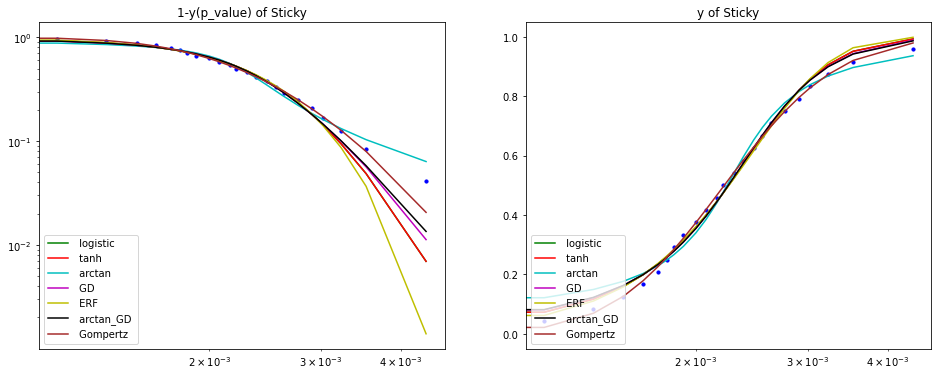

Factor for MM-ER: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [2.3995262013806295e-05, 3.3649605553423936e-05, 3.8792600136814996e-05, 4.173115801658482e-05, 4.4266320870270735e-05, 4.67619998610748e-05, 4.9958469232935315e-05, 5.214757573973367e-05, 5.413143099971306e-05, 5.5474317022353245e-05, 5.773650714605079e-05, 6.0257196959651445e-05, 6.386856510284709e-05, 6.665676946823707e-05, 6.952876388165105e-05, 7.28253069075361e-05, 7.708671227545822e-05, 8.290526656045606e-05, 8.918808093549304e-05, 9.756663438463383e-05, 0.00010757999942889549, 0.0001231098877262716, 0.0004269575195619951]
For  ER  :
curve_fit parameter on  logistic :  [0.63044306 6.32932541]
curve_fit parameter on  tanh :  [0.63044308 3.16466198]
curve_fit parameter on  arctan :  [0.62220886 6.35118285]
curve_fit parameter on  GD :  [0.62913933 2.57701552]
curve_fit parameter on  ERF :  [0.63224452 2.68960154]
curve_fit paramete

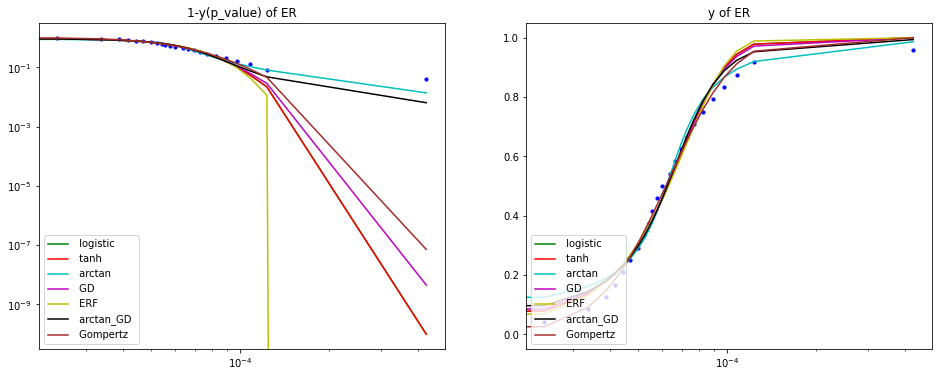

Factor for MM-ERDD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.006009926811194336, 0.007125545126290157, 0.007705675886607421, 0.008228198436162919, 0.008843120714914898, 0.009240015095942723, 0.009548415835632366, 0.009936829811616714, 0.010282172168897747, 0.010621618093237521, 0.011132143541901104, 0.01152167423107236, 0.011895983624298605, 0.012313643296899207, 0.013016791651738689, 0.013664329416207283, 0.014370782784240038, 0.015114245071911588, 0.016009373799497177, 0.017040371539787803, 0.0190497311451707, 0.02262094890549753, 0.04103556006895809]
For  ERDD  :
curve_fit parameter on  logistic :  [1.18653069 3.83952813]
curve_fit parameter on  tanh :  [1.18653074 1.91976375]
curve_fit parameter on  arctan :  [1.17327677 3.80887706]
curve_fit parameter on  GD :  [1.18457631 1.55880938]
curve_fit parameter on  ERF :  [1.18900495 1.64068585]
curve_fit parameter on  arctan_GD :  [ 1.18160676 

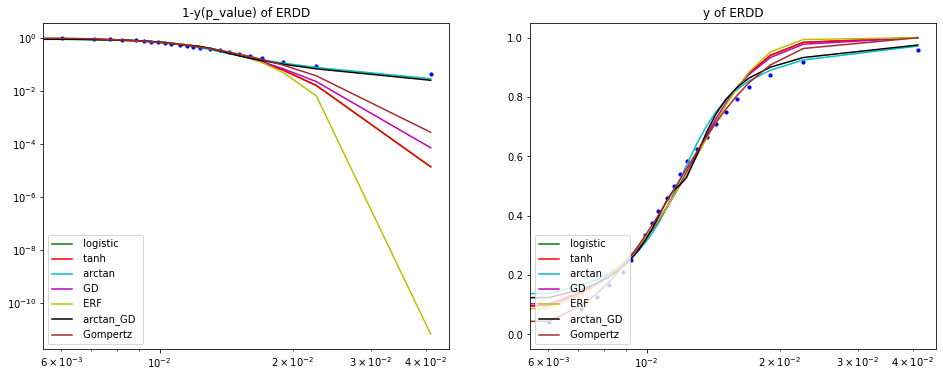

Factor for MM-GEO: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [2.793947760030587e-05, 3.968585253345266e-05, 4.8207643405596496e-05, 5.541051095270138e-05, 5.9913283155266094e-05, 6.520172304081612e-05, 7.054280090891176e-05, 7.396895470102672e-05, 7.727680085894606e-05, 8.269568067237256e-05, 8.764460041933067e-05, 9.145828415274146e-05, 9.727621226237544e-05, 0.0001044479199694794, 0.00011281749507766796, 0.00012095948890171302, 0.00012812301775222835, 0.00014079682323134792, 0.00015290068313798588, 0.00017100025711101413, 0.00019050616284019728, 0.00023649979084389882, 0.000505274577560194]
For  GEO  :
curve_fit parameter on  logistic :  [0.98234841 3.07883918]
curve_fit parameter on  tanh :  [0.9823485  1.53941923]
curve_fit parameter on  arctan :  [0.96203423 3.07486587]
curve_fit parameter on  GD :  [0.97931815 1.25261527]
curve_fit parameter on  ERF :  [0.98636734 1.31057088]
curve_fit par

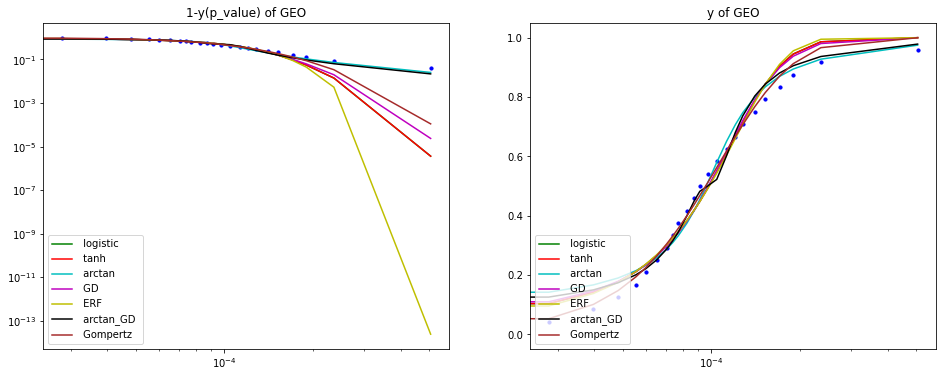

Factor for MM-GEOGD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [6.793765159704787e-05, 9.70083358892156e-05, 0.00012073626731738743, 0.0001366483515344871, 0.00015028353866779117, 0.00016522461923324725, 0.000176577130022095, 0.00019500618742435193, 0.0002200559522666811, 0.0002520363132862563, 0.0002716092448810818, 0.0003053833078747182, 0.0003539320077600746, 0.0004020622311326587, 0.0004449037836334171, 0.0005288441407836827, 0.0006111675510526533, 0.0007788248385721686, 0.001015085756624264, 0.0013988476238770851, 0.002121967963255335, 0.00418767301000611, 0.01350891475862872]
For  GEOGD  :
curve_fit parameter on  logistic :  [3.71946582e-02 5.19540436e+01]
curve_fit parameter on  tanh :  [ 0.03719468 25.97699373]
curve_fit parameter on  arctan :  [3.56421688e-02 4.93292000e+01]
curve_fit parameter on  GD :  [ 0.03701953 20.886798  ]
curve_fit parameter on  ERF :  [ 0.03741858 22.46192624]
cu

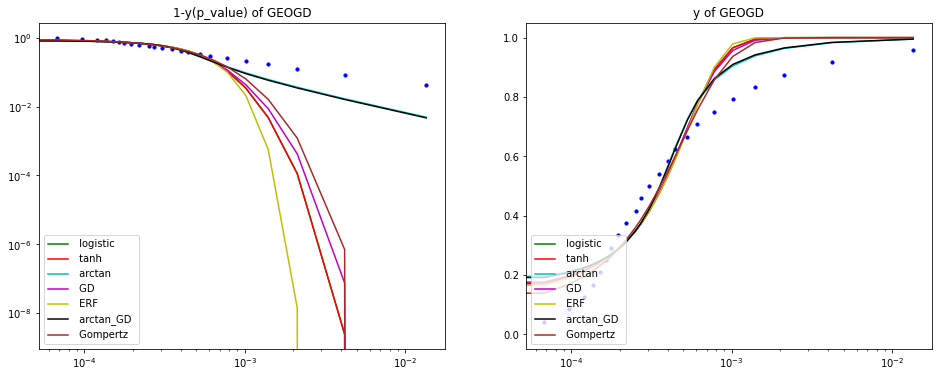

Factor for MM-HGG: 0.01
items in each bin:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15]
binned_data:  [0.010681354066095017, 0.02093218804487993, 0.02675352599529928, 0.030212532505162183, 0.03254609755318894, 0.038095776734037363, 0.04156223419533049, 0.04440166775198953, 0.048373475842520317, 0.056907904777568366, 0.07014327270038515, 0.09045865612073237, 0.11288262007288405, 0.1417297942913693, 0.17849086417730725, 0.5239247603211141]
For  HGG  :
curve_fit parameter on  logistic :  [5.68610854 0.36780685]
curve_fit parameter on  tanh :  [5.68608557 0.18390538]
curve_fit parameter on  arctan :  [5.26457719 0.39667698]
curve_fit parameter on  GD :  [5.62879622 0.1502502 ]
curve_fit parameter on  ERF :  [5.75968199 0.15589364]
curve_fit parameter on  arctan_GD :  [ 5.77069606  1.39388972 -1.9751211 ]
curve_fit parameter on  Gompertz :  [1.06012735 0.25931701]


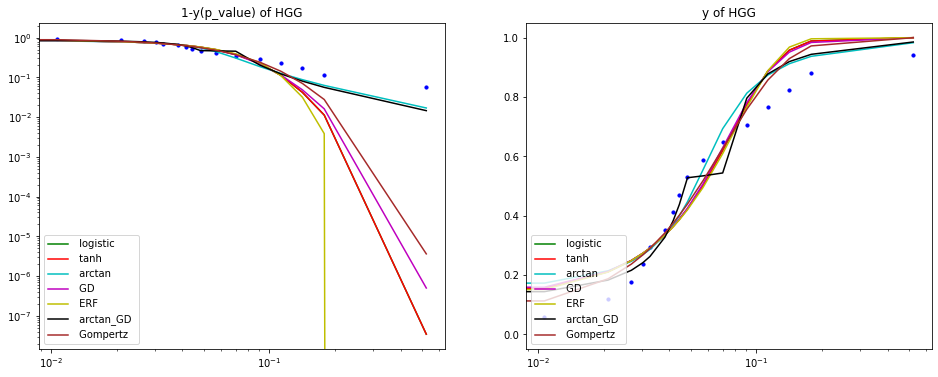

Factor for MM-SF: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [6.016000926019412e-05, 7.508598769794239e-05, 8.460876936318076e-05, 8.843353954169568e-05, 9.554797703840594e-05, 9.900330040354647e-05, 0.00010169044223314588, 0.00010453209835069636, 0.00010934971622696016, 0.00011381319148749272, 0.00011855067076631526, 0.00012113322109838657, 0.0001250239897497071, 0.00013054952047090432, 0.00013460499428948137, 0.00014046001332581375, 0.0001470399746886005, 0.0001561779431630715, 0.00016843932687190416, 0.00018177152739715888, 0.00020269645059616643, 0.00023566457213867594, 0.00035162470653888673]
For  SF  :
curve_fit parameter on  logistic :  [1.24575175 3.86699517]
curve_fit parameter on  tanh :  [1.24575187 1.9334963 ]
curve_fit parameter on  arctan :  [1.23405479 3.87490451]
curve_fit parameter on  GD :  [1.24395083 1.57163602]
curve_fit parameter on  ERF :  [1.24823275 1.64790819]
curve_fit 

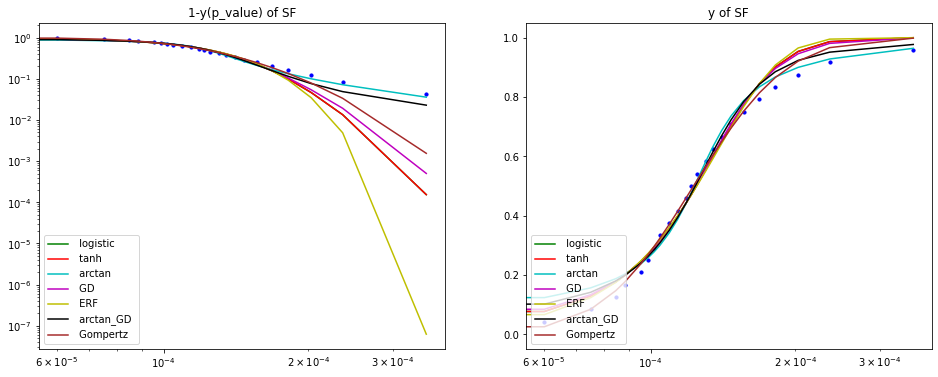

Factor for MM-SFDD: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.004240525955521238, 0.005498896575056034, 0.006229421687320439, 0.0066033425710531925, 0.006988270006463012, 0.007406181290186533, 0.00791817088782844, 0.008322469233065358, 0.0087583252681594, 0.009238489064436008, 0.009932103888099146, 0.010683632689533493, 0.011592970502826662, 0.012299827573492711, 0.013446666829101698, 0.015451158461127119, 0.01793927929750169, 0.02058460399588962, 0.024433065344242572, 0.02775224376890953, 0.03398949442675544, 0.0458932592319974, 0.09253344940088196]
For  SFDD  :
curve_fit parameter on  logistic :  [12.17813034  0.20949077]
curve_fit parameter on  tanh :  [12.17812174  0.10474564]
curve_fit parameter on  arctan :  [11.58645241  0.21721514]
curve_fit parameter on  GD :  [12.09608783  0.08523519]
curve_fit parameter on  ERF :  [12.2903024   0.08901016]
curve_fit parameter on  arctan_GD :  [12.04

C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_8044/1337051760.py:32: RuntimeWarning: overflow encountered in power
  m = np.e**(-np.e**(b-c*x))


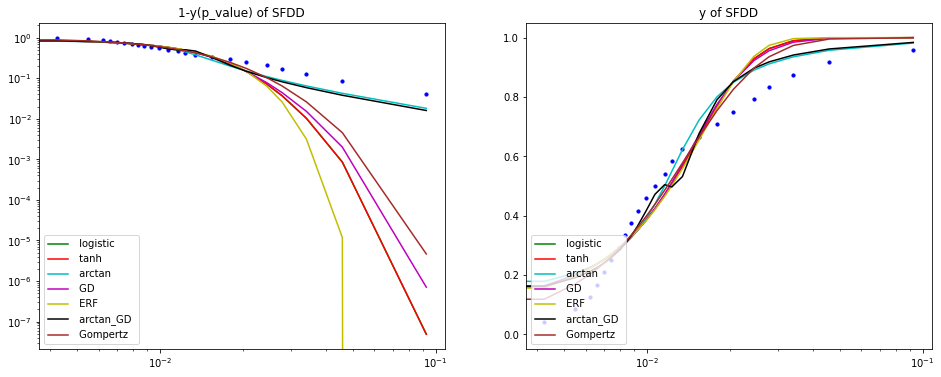

Factor for MM-Sticky: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0019579990354693217, 0.0022500245294046987, 0.0023645424940800784, 0.0024786296344530435, 0.0026200108236183557, 0.002735522201196328, 0.002838233249286607, 0.002933732185027063, 0.0030146398145515455, 0.003093082660840493, 0.003167489521509088, 0.0032289934750170555, 0.003344911999879507, 0.0034439059746335034, 0.0035366270812653435, 0.0036575054872324663, 0.0038232472748279595, 0.003982510652414203, 0.004178811355965076, 0.004396584936404828, 0.004753508347296866, 0.005057793059771008, 0.006201190250856468]
For  Sticky  :
curve_fit parameter on  logistic :  [3.31167092 1.79343814]
curve_fit parameter on  tanh :  [3.31167075 0.89671946]
curve_fit parameter on  arctan :  [3.28855658 1.81176576]
curve_fit parameter on  GD :  [3.30812759 0.73027807]
curve_fit parameter on  ERF :  [3.31651699 0.76256553]
curve_fit parameter on  arcta

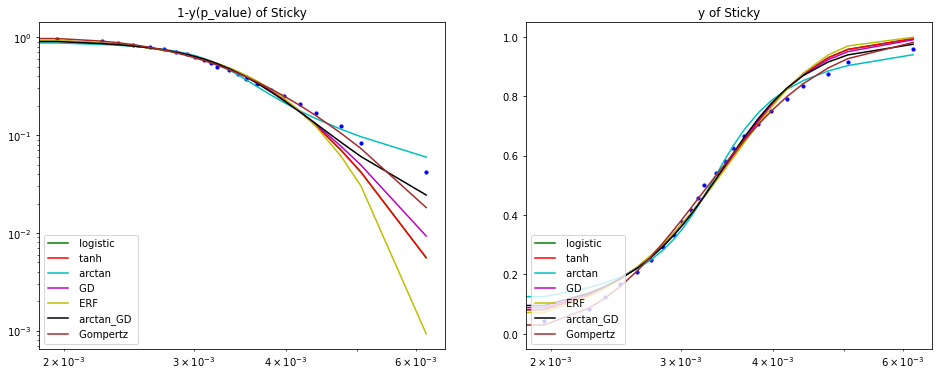

Factor for RN-ER: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [5.072395836476875e-05, 6.508621069372167e-05, 7.095051187286861e-05, 7.544261823072683e-05, 7.962647874222536e-05, 8.444157486813588e-05, 8.839326242652397e-05, 9.171956798509718e-05, 9.541577691503572e-05, 9.836273462144026e-05, 0.00010239714076155748, 0.00010770745202439699, 0.00011113500813305857, 0.00011839987306524941, 0.0001255203549732965, 0.0001303165097274306, 0.00014061019316810518, 0.00014773705052290126, 0.00015592777943290053, 0.0001688822339940812, 0.00019082720569902508, 0.0002549918292851969, 0.0017916082444003525]
For  ER  :
curve_fit parameter on  logistic :  [ 0.11232958 36.33406201]
curve_fit parameter on  tanh :  [ 0.11232959 18.16702084]
curve_fit parameter on  arctan :  [ 0.11073612 35.72256092]
curve_fit parameter on  GD :  [ 0.11209774 14.73389971]
curve_fit parameter on  ERF :  [ 0.11262343 15.54378083]
curve_f

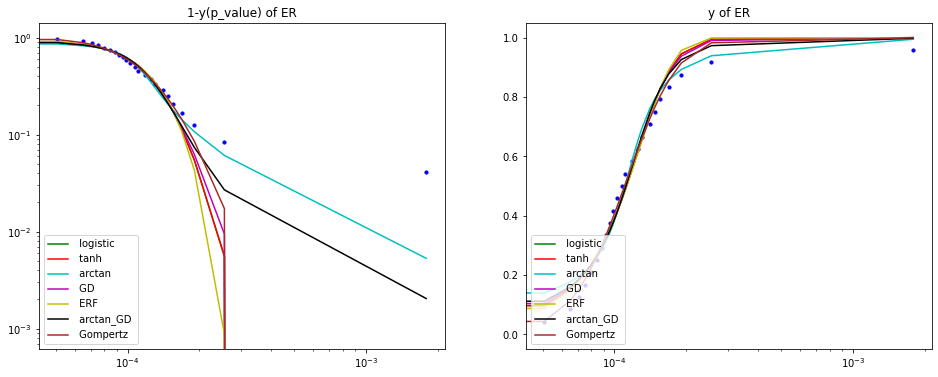

Factor for RN-ERDD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.00687114549391245, 0.008685151676729447, 0.00942843295184785, 0.010208222490297585, 0.010747597477495876, 0.011402193440731899, 0.012039403116696767, 0.012689692429199095, 0.01341749376862228, 0.014022296704256561, 0.014543818209950175, 0.014907693313389737, 0.015320758524831257, 0.015878882400419354, 0.01689082786881767, 0.0179305721028634, 0.019152681832126806, 0.02033191506265086, 0.02146168833362589, 0.023705137103816096, 0.026727172857490922, 0.035448254986864644, 0.06547189129166894]
For  ERDD  :
curve_fit parameter on  logistic :  [1.54342055 2.64790908]
curve_fit parameter on  tanh :  [1.54342054 1.32395429]
curve_fit parameter on  arctan :  [1.5233107  2.66652041]
curve_fit parameter on  GD :  [1.54046025 1.07666651]
curve_fit parameter on  ERF :  [1.54726185 1.12909236]
curve_fit parameter on  arctan_GD :  [1.53351563 1.363

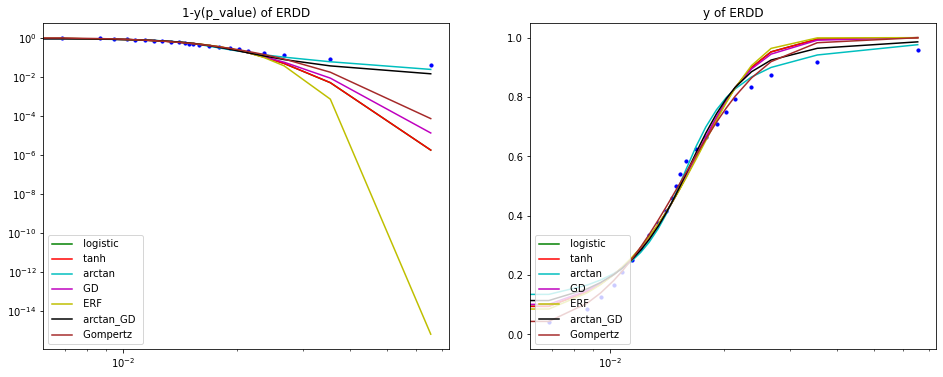

Factor for RN-GEO: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [7.354149118071235e-05, 9.584743264015419e-05, 0.00010795162035050287, 0.00012261788487269519, 0.00013501350799683518, 0.00014406273603712361, 0.00015234472773944006, 0.00016378084850156394, 0.00017692764111720556, 0.00019142983791603814, 0.0002034012276917894, 0.00021042967066134575, 0.000220243200224479, 0.00023519834951357804, 0.00025247813328537676, 0.0002686664181671741, 0.0002941373958491135, 0.00032570496599599783, 0.0003718341187718759, 0.00041119169737071796, 0.000462061106131033, 0.0005335795876874011, 0.0010495788580980043]
For  GEO  :
curve_fit parameter on  logistic :  [2.23524784 1.32392941]
curve_fit parameter on  tanh :  [2.23524215 0.66197128]
curve_fit parameter on  arctan :  [2.18470785 1.34861737]
curve_fit parameter on  GD :  [2.2272018  0.53976905]
curve_fit parameter on  ERF :  [2.24693824 0.56139153]
curve_fit p

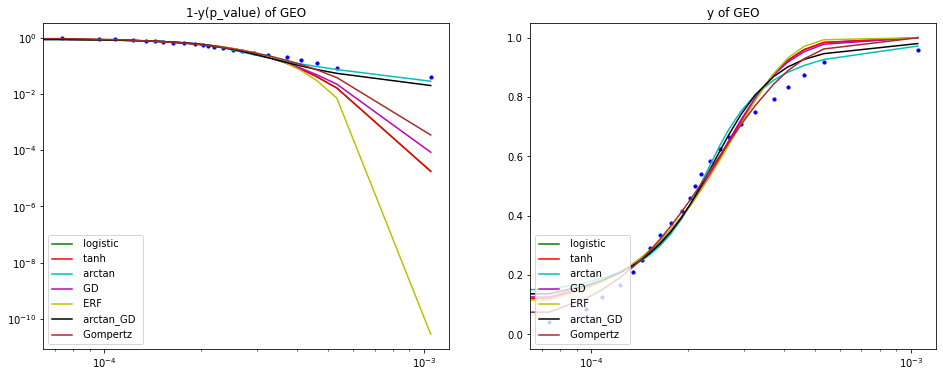

Factor for RN-GEOGD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0009335729126923328, 0.001149438234081776, 0.0013720954156900252, 0.0015593826448952845, 0.0017051245545403675, 0.0018302383704590828, 0.0019941590844942975, 0.0021677549255815216, 0.0023307508462690678, 0.002537056742101821, 0.0028007560541460047, 0.003115693316642246, 0.0034561384811269092, 0.003925507600214194, 0.004500055663754308, 0.004936270719590296, 0.0055753004334703595, 0.006411443764456971, 0.007443769240318381, 0.009126145344722817, 0.010977539274880063, 0.016941644912749194, 0.04605488341949459]
For  GEOGD  :
curve_fit parameter on  logistic :  [0.36897219 5.70649229]
curve_fit parameter on  tanh :  [0.36897081 2.85327259]
curve_fit parameter on  arctan :  [0.35275062 5.57010804]
curve_fit parameter on  GD :  [0.36686608 2.30618424]
curve_fit parameter on  ERF :  [0.37171557 2.45033129]
curve_fit parameter on  arctan_GD

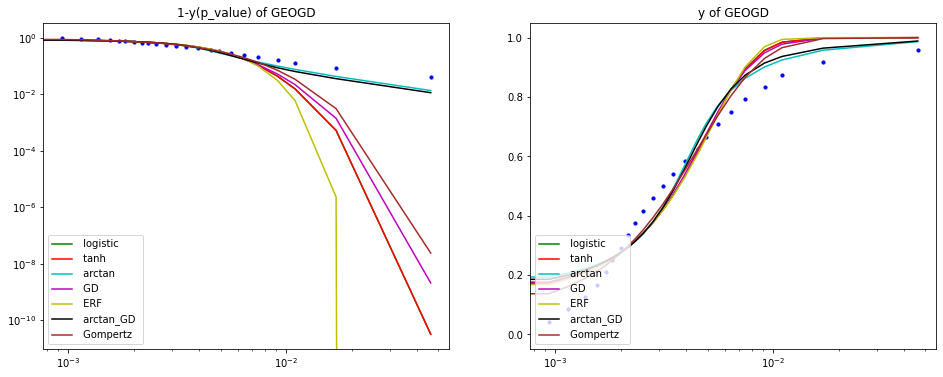

Factor for RN-HGG: 0.1
items in each bin:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15]
binned_data:  [0.0064738847141977834, 0.008883854812241392, 0.010540823271440252, 0.013217972875596546, 0.01525879270344626, 0.018799363884038044, 0.020933952960828898, 0.024661626232226123, 0.029115231254310366, 0.03474850533920105, 0.040762211825233916, 0.048591999194126094, 0.06412563205013826, 0.10091538288271447, 0.15896396668901372, 0.5058261609245536]
For  HGG  :
curve_fit parameter on  logistic :  [0.31125156 6.42278407]
curve_fit parameter on  tanh :  [0.31125196 3.21138284]
curve_fit parameter on  arctan :  [0.30157333 6.03061899]
curve_fit parameter on  GD :  [0.31016955 2.58215303]
curve_fit parameter on  ERF :  [0.31252578 2.78149959]
curve_fit parameter on  arctan_GD :  [0.30348434 4.09325933 0.40081668]
curve_fit parameter on  Gompertz :  [0.95225012 4.3879969 ]


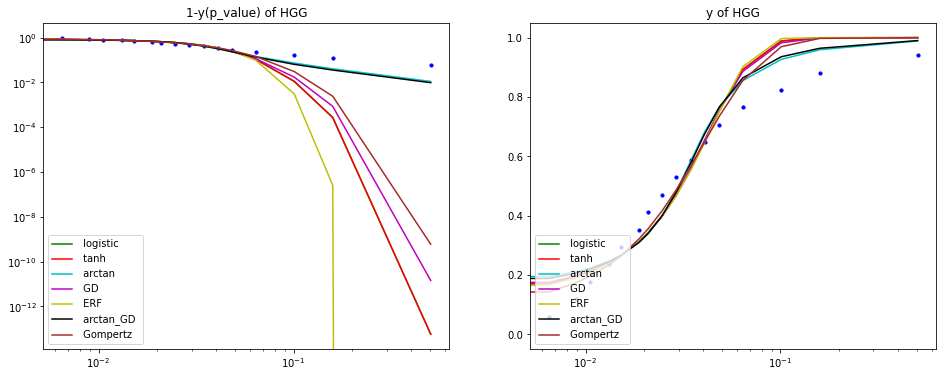

Factor for RN-SF: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0008303305248354761, 0.0010186832318247396, 0.0011208733422434294, 0.001196463698330603, 0.001254135011831377, 0.001300517710560918, 0.0013582518499681716, 0.0014212022717212656, 0.0014696324715393263, 0.0015345723212616604, 0.0015789074249720246, 0.0016312654066762424, 0.0016918162300814368, 0.0017361892598818636, 0.0017963862949213981, 0.0019003935530118074, 0.0020237663813159243, 0.002138819024121225, 0.0022961364920740636, 0.002497598395844406, 0.002737363252935456, 0.003159974483738898, 0.004325662697543716]
For  SF  :
curve_fit parameter on  logistic :  [1.67918644 2.76407334]
curve_fit parameter on  tanh :  [1.67918642 1.38203681]
curve_fit parameter on  arctan :  [1.65875593 2.81102291]
curve_fit parameter on  GD :  [1.67602731 1.12504962]
curve_fit parameter on  ERF :  [1.68348434 1.17596657]
curve_fit parameter on  arctan_GD

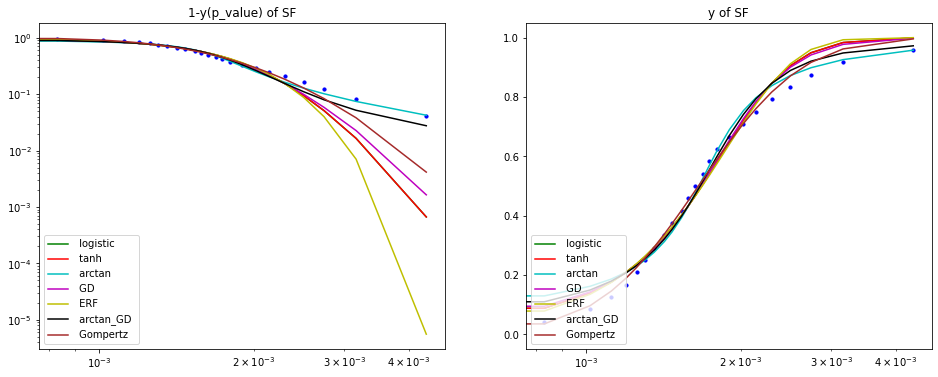

Factor for RN-SFDD: 0.1
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21]
binned_data:  [0.010878373899600564, 0.015111843792131742, 0.01626497004910086, 0.01807546371072309, 0.019709525071693986, 0.02089040260045918, 0.022039979370031108, 0.023387254688761613, 0.024806604676387654, 0.0265236055002224, 0.02816883589224141, 0.030495156486173645, 0.03244514269898566, 0.03496048712001108, 0.03821471803542029, 0.0427200064566839, 0.05075111900007752, 0.05663799974208525, 0.06707466350697822, 0.0812624522807179, 0.10334603075675637, 0.1351266039330671, 0.27510188448881073]
For  SFDD  :
curve_fit parameter on  logistic :  [0.34082989 7.55785801]
curve_fit parameter on  tanh :  [0.34082867 3.77897432]
curve_fit parameter on  arctan :  [0.32659592 7.67961886]
curve_fit parameter on  GD :  [0.33886337 3.06857892]
curve_fit parameter on  ERF :  [0.34337124 3.22639516]
curve_fit parameter on  arctan_GD :  [0.32774409 5.89101589 0.2611

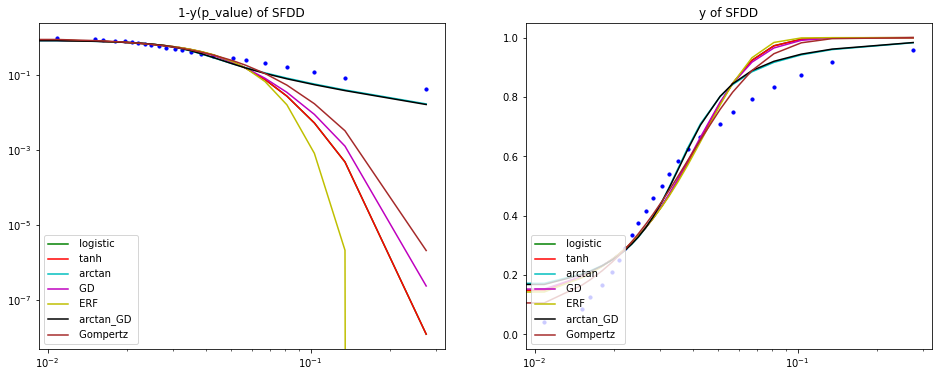

Factor for RN-Sticky: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.009304022049317935, 0.010840805320404665, 0.011775780203218074, 0.01243311292065906, 0.013014547625225968, 0.013405982321660487, 0.01377711751305037, 0.014246034482774301, 0.01466519002164595, 0.015080118807598691, 0.015695493489490578, 0.016280686077228775, 0.016892059851829736, 0.017407455285033062, 0.017982854814238707, 0.018577724977877696, 0.0190543154074187, 0.019597374091115578, 0.020374476473826324, 0.021293671134921158, 0.02305284952652159, 0.026107713338665767, 0.037225710332951634]
For  Sticky  :
curve_fit parameter on  logistic :  [1.64623521 3.50831639]
curve_fit parameter on  tanh :  [1.64623517 1.75415953]
curve_fit parameter on  arctan :  [1.64101808 3.3783587 ]
curve_fit parameter on  GD :  [1.64548431 1.41985382]
curve_fit parameter on  ERF :  [1.64729529 1.50347129]
curve_fit parameter on  arctan_GD :  [1.6451956

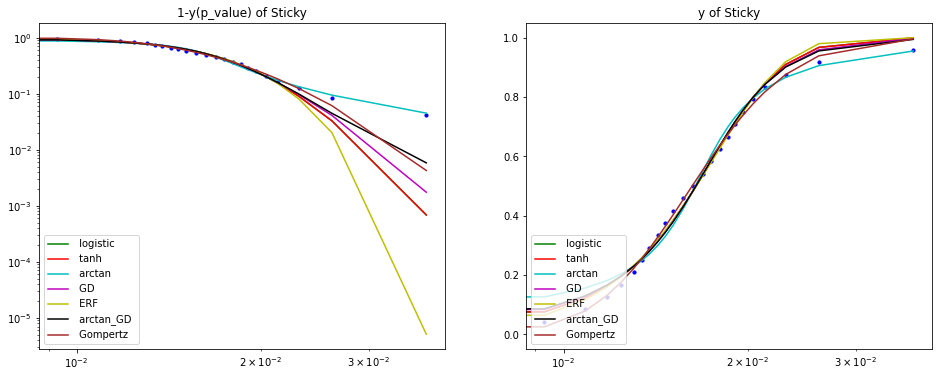

Factor for SC-ER: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [1.01105827163435e-05, 1.622445293750702e-05, 2.0081647730843943e-05, 2.1925278936445103e-05, 2.3976575422613596e-05, 2.750403034810523e-05, 2.9606817659745315e-05, 3.096478016969797e-05, 3.349194570674982e-05, 3.613764214703969e-05, 3.861507432486566e-05, 4.065883690077839e-05, 4.2515142879318086e-05, 4.5644426668531166e-05, 4.7745282798010125e-05, 5.059514768720446e-05, 5.355223040028933e-05, 5.664983450335034e-05, 6.299531490838374e-05, 6.894760405064547e-05, 7.730295490415565e-05, 9.247596334440492e-05, 0.00021913088886361953]
For  ER  :
curve_fit parameter on  logistic :  [0.41691919 7.43161318]
curve_fit parameter on  tanh :  [0.41691917 3.71580851]
curve_fit parameter on  arctan :  [0.41319442 7.36947949]
curve_fit parameter on  GD :  [0.41632331 3.02368142]
curve_fit parameter on  ERF :  [0.41781106 3.16308842]
curve_fit paramet

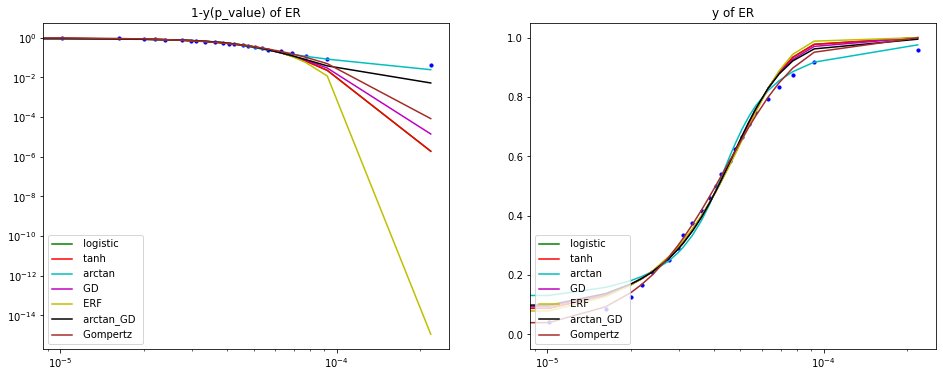

Factor for SC-ERDD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0012809493093696952, 0.0015802734936993738, 0.0018086475969698182, 0.0019941813639159267, 0.0021159651678559635, 0.002227804089365185, 0.0023427973091457786, 0.0024903189647543437, 0.002597115426751638, 0.0027322710577928487, 0.0028217051325484317, 0.002967271847713357, 0.0031465796776393782, 0.003270909353511386, 0.0034380816757088816, 0.0036905862951158814, 0.003931440768322358, 0.004199897658437311, 0.0044372291770441285, 0.004886972149775217, 0.005502410998488921, 0.006669984222403764, 0.015279609324623009]
For  ERDD  :
curve_fit parameter on  logistic :  [ 0.31096318 11.88347021]
curve_fit parameter on  tanh :  [0.31096324 5.9417274 ]
curve_fit parameter on  arctan :  [ 0.3063435  11.82990314]
curve_fit parameter on  GD :  [0.31027074 4.82894629]
curve_fit parameter on  ERF :  [0.31185329 5.0710298 ]
curve_fit parameter on  arct

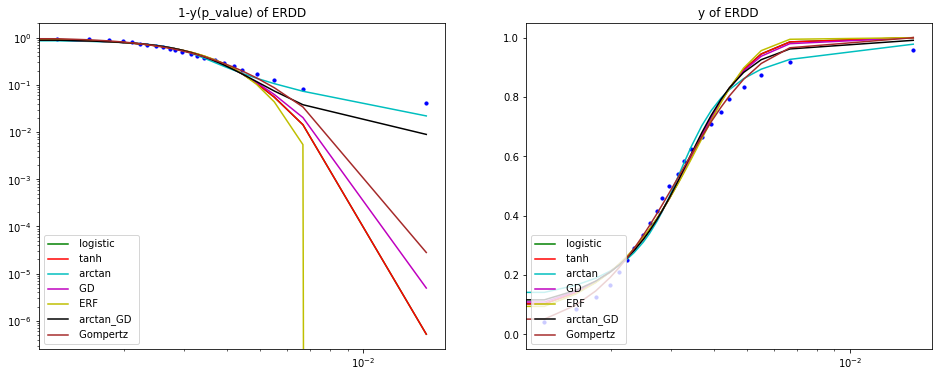

Factor for SC-GEO: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [9.972346310624216e-05, 0.00011787268803827266, 0.00013552853698730358, 0.00015210733868301063, 0.0001655617726720872, 0.00017522640388843396, 0.0001860892645851567, 0.00019411654467846976, 0.00020323564054224795, 0.00021289359456650117, 0.00022064927238988916, 0.0002308846747580544, 0.000243003055158953, 0.0002542818705052335, 0.0002686661938528576, 0.000286634661578065, 0.0003014674257877756, 0.000321413651827779, 0.0003437536051145015, 0.0003818206186636137, 0.0004313936032323869, 0.0005236811253999011, 0.0008646726895687387]
For  GEO  :
curve_fit parameter on  logistic :  [2.41362436 1.54539986]
curve_fit parameter on  tanh :  [2.41362351 0.77270129]
curve_fit parameter on  arctan :  [2.38115961 1.53913589]
curve_fit parameter on  GD :  [2.40898062 0.62789409]
curve_fit parameter on  ERF :  [2.41963707 0.65932243]
curve_fit paramet

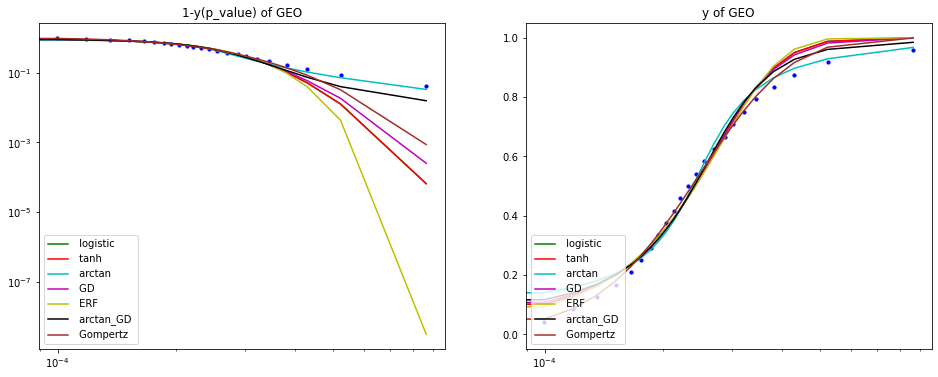

Factor for SC-GEOGD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0002300070590986459, 0.00031018028822156295, 0.00036148065335789276, 0.000395602001500262, 0.0004592739626785017, 0.0005152949829136427, 0.0005790856593695629, 0.0006549829712386182, 0.000761550029115906, 0.0008558774930248096, 0.000980464021726338, 0.001136950772551352, 0.0013356191710571336, 0.0016082574698817304, 0.0019763479374505888, 0.002759868689142869, 0.0037374233334400205, 0.005458083078549788, 0.008276774605564745, 0.012058257578878021, 0.018555977570294244, 0.041851157086155104, 0.13244787979142664]
For  GEOGD  :
curve_fit parameter on  logistic :  [ 0.15825463 10.02632027]
curve_fit parameter on  tanh :  [0.15825507 5.01313343]
curve_fit parameter on  arctan :  [0.14642646 9.68358635]
curve_fit parameter on  GD :  [0.1570234  4.02722524]
curve_fit parameter on  ERF :  [0.15977762 4.33854731]
curve_fit parameter on  arct

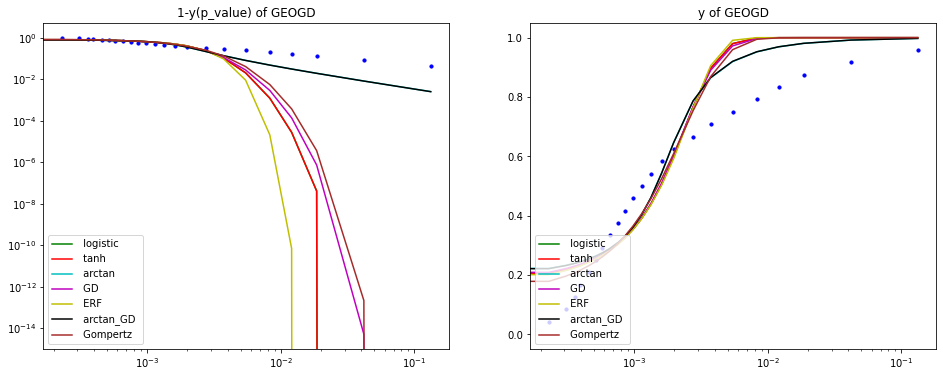

Factor for SC-HGG: 0.1
items in each bin:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15]
binned_data:  [0.03654350551958461, 0.048868097812370746, 0.05976326847923874, 0.0685795825148047, 0.07624279254675734, 0.08431856856174001, 0.09307847460936053, 0.10088246582185109, 0.10621775620294617, 0.11210347823118204, 0.11804773595194187, 0.12794259433875718, 0.1404000789558938, 0.1576352844175796, 0.18912187197759878, 0.302100566161933]
For  HGG  :
curve_fit parameter on  logistic :  [1.03594036 3.36364844]
curve_fit parameter on  tanh :  [1.03594037 1.68182406]
curve_fit parameter on  arctan :  [1.03346977 3.38528345]
curve_fit parameter on  GD :  [1.03547255 1.3703322 ]
curve_fit parameter on  ERF :  [1.03690388 1.42856253]
curve_fit parameter on  arctan_GD :  [1.03459634 1.54872628 0.83473871]
curve_fit parameter on  Gompertz :  [1.91157431 2.24722831]


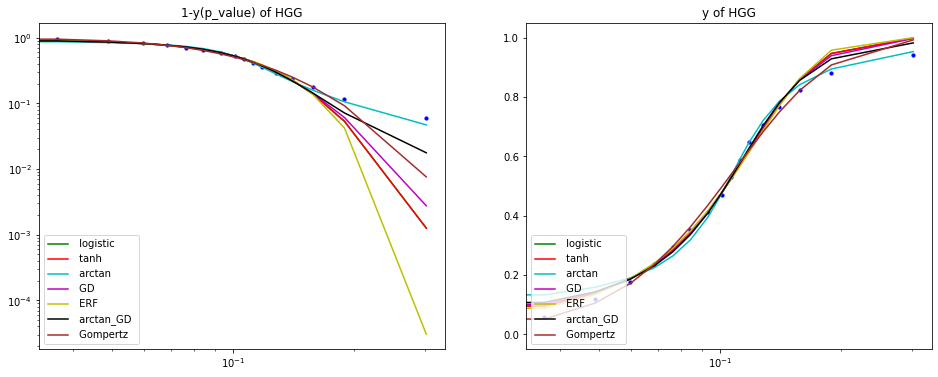

Factor for SC-SF: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.00011820717756249661, 0.00014504681405493326, 0.0001598525455245324, 0.00017502235306405143, 0.0001858076057397473, 0.0001968352395281466, 0.0002053882174545309, 0.00021119282675674314, 0.00021967039018640363, 0.0002281034230309784, 0.0002367822638953695, 0.00024460928968992533, 0.0002535736759316255, 0.0002631653095644291, 0.00027328892181647504, 0.00028963410346765614, 0.000306599499941914, 0.000323473909206197, 0.00033791974382518336, 0.0003580847886616345, 0.0004089693661924432, 0.0004968110291906756, 0.0007157398931494676]
For  SF  :
curve_fit parameter on  logistic :  [2.52073581 1.79715854]
curve_fit parameter on  tanh :  [2.5207355  0.89857993]
curve_fit parameter on  arctan :  [2.49432779 1.79361213]
curve_fit parameter on  GD :  [2.51695282 0.72984926]
curve_fit parameter on  ERF :  [2.52531976 0.76785665]
curve_fit paramet

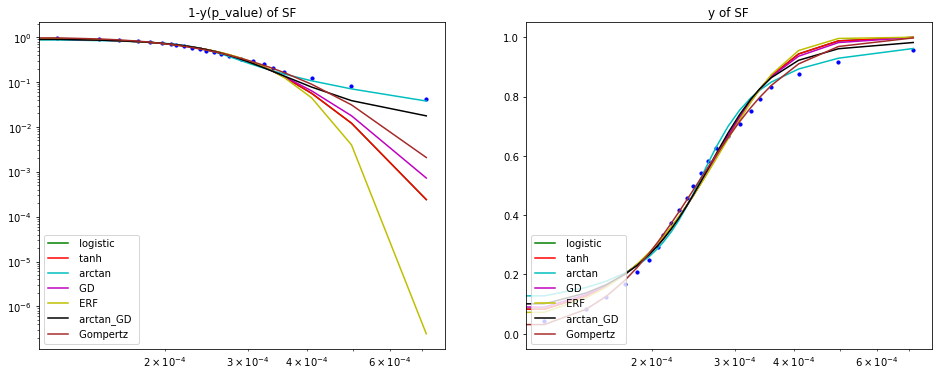

Factor for SC-SFDD: 0.1
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21]
binned_data:  [0.00562861319677586, 0.007598632928891179, 0.008431407014588312, 0.008946819392571328, 0.009502707621942653, 0.010221643674653103, 0.010939322907937447, 0.011405516214295796, 0.012252449563953861, 0.013007397869709409, 0.014137089931637242, 0.015529991704198758, 0.01710180786904193, 0.018981835200497302, 0.021059182130450264, 0.022892894951922014, 0.026049532307946346, 0.029407109125154637, 0.03510061873876117, 0.03905285569559364, 0.046317940272215065, 0.06298560024581308, 0.2119579766606132]
For  SFDD  :
curve_fit parameter on  logistic :  [ 0.17958358 13.28404471]
curve_fit parameter on  tanh :  [0.17958364 6.6420154 ]
curve_fit parameter on  arctan :  [ 0.17220263 13.20785311]
curve_fit parameter on  GD :  [0.17855058 5.38630189]
curve_fit parameter on  ERF :  [0.18105552 5.66614374]
curve_fit parameter on  arctan_GD :  [0.17386203 

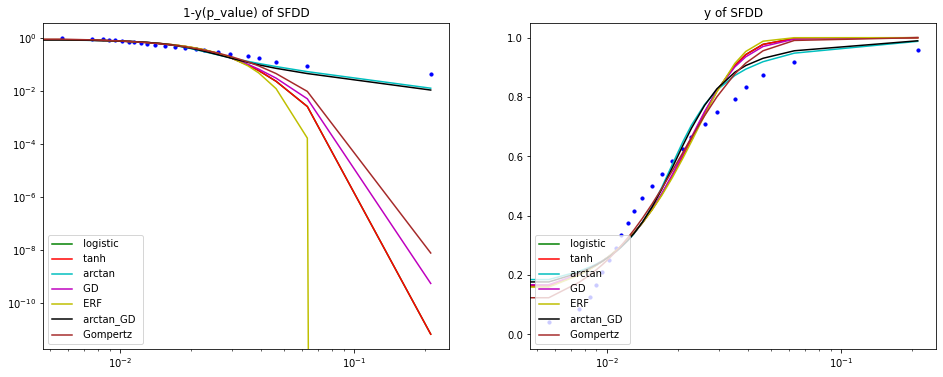

Factor for SC-Sticky: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0016914602838434588, 0.001992823566434932, 0.002109897169207739, 0.0021846045325137277, 0.002240004353651337, 0.002301183620999701, 0.0023586783858897645, 0.002413133818705047, 0.0024642687679286668, 0.0025110292180937632, 0.0025689027192645443, 0.002625217705627447, 0.0026957939119646637, 0.0027970256515104344, 0.002890192321110112, 0.0029800143146386567, 0.0031219675631487154, 0.0032462723904399158, 0.0033679556606407766, 0.003580146020149619, 0.0038270972910241998, 0.004227504830776269, 0.005384335473785566]
For  Sticky  :
curve_fit parameter on  logistic :  [2.71260563 2.4237366 ]
curve_fit parameter on  tanh :  [2.71260523 1.21186962]
curve_fit parameter on  arctan :  [2.68534073 2.41685659]
curve_fit parameter on  GD :  [2.70858929 0.98419113]
curve_fit parameter on  ERF :  [2.71783376 1.0337773 ]
curve_fit parameter on  arc

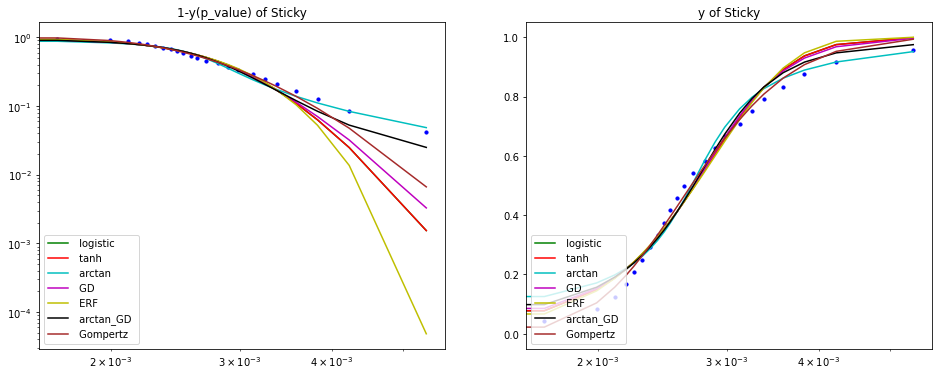

Factor for SP-ER: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.00012826607313594785, 0.0001559413735008798, 0.00017494551924152106, 0.00019825915969119524, 0.00021149697818516474, 0.00022831151673807155, 0.00024306137643647033, 0.00025269201690017044, 0.00026545418226034135, 0.00027719034696814125, 0.00028565716056614434, 0.00029435937648256854, 0.0003064094223742501, 0.00031909476015344677, 0.0003320282853787497, 0.00034332898036081104, 0.00035978424691663144, 0.0003796060211304385, 0.00039583059968764515, 0.0004152310337678764, 0.00044567901854914577, 0.0004950237848559462, 0.0010735759568132326]
For  ER  :
curve_fit parameter on  logistic :  [3.00016877 1.49305033]
curve_fit parameter on  tanh :  [3.00016867 0.74652511]
curve_fit parameter on  arctan :  [2.98797732 1.49205644]
curve_fit parameter on  GD :  [2.99828357 0.60827601]
curve_fit parameter on  ERF :  [3.00268459 0.63457887]
curve_fi

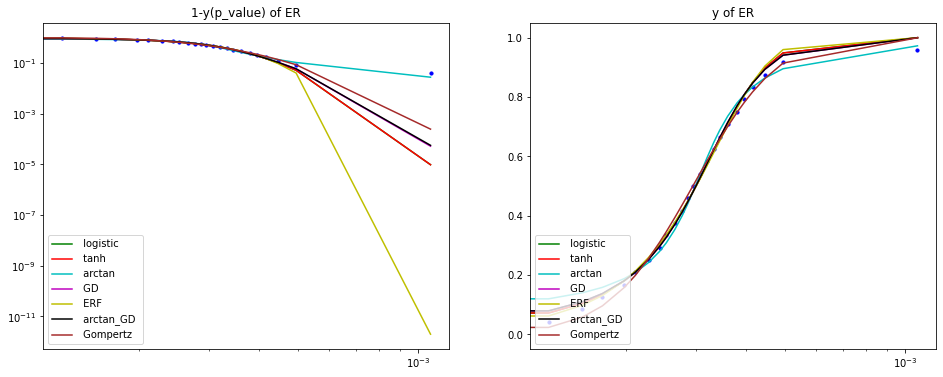

Factor for SP-ERDD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.010374992072989987, 0.012677719493536617, 0.013953447121058423, 0.014656043048673727, 0.015429327771777161, 0.01622856910007385, 0.017136718558219848, 0.017818579909569268, 0.01839538038498046, 0.019207742684883664, 0.02002248064155286, 0.020663151565146694, 0.021377357481640866, 0.02269077681338806, 0.023765552723485704, 0.024703306724336647, 0.025298320102237204, 0.026203342285311643, 0.028040850952073607, 0.03058458455602701, 0.034185278078459856, 0.04277539851190448, 0.08140305514363304]
For  ERDD  :
curve_fit parameter on  logistic :  [2.12539927 2.1623592 ]
curve_fit parameter on  tanh :  [2.12539898 1.08118101]
curve_fit parameter on  arctan :  [2.11158841 2.09467855]
curve_fit parameter on  GD :  [2.12359203 0.87518981]
curve_fit parameter on  ERF :  [2.12782383 0.92716322]
curve_fit parameter on  arctan_GD :  [2.12067533 0.9

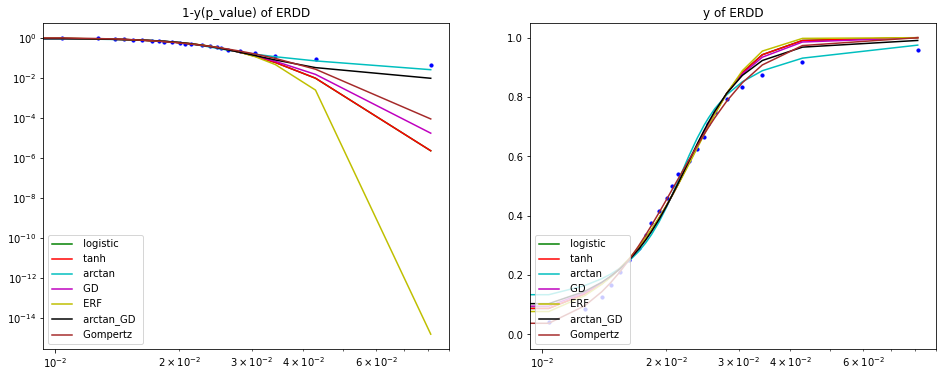

Factor for SP-GEO: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0004436712189710003, 0.0005226521558334006, 0.0005934770585294096, 0.0006286925719163562, 0.0006740384938394018, 0.0007076611126114787, 0.0007454540304824189, 0.0007902376104983154, 0.0008157685490824577, 0.00084582943057965, 0.0008784420804092245, 0.0009174868819055617, 0.00095407687384297, 0.0009921589846157144, 0.0010330513012006778, 0.001068868723287583, 0.001122803874309185, 0.0012000202794867152, 0.0012731858095182463, 0.001363262821831183, 0.0015442379956504052, 0.0017996811094900343, 0.003274868953048358]
For  GEO  :
curve_fit parameter on  logistic :  [0.93778413 4.67779862]
curve_fit parameter on  tanh :  [0.93778415 2.33889907]
curve_fit parameter on  arctan :  [0.93044317 4.64514021]
curve_fit parameter on  GD :  [0.93666014 1.90059956]
curve_fit parameter on  ERF :  [0.93931075 1.99617307]
curve_fit parameter on  arctan_

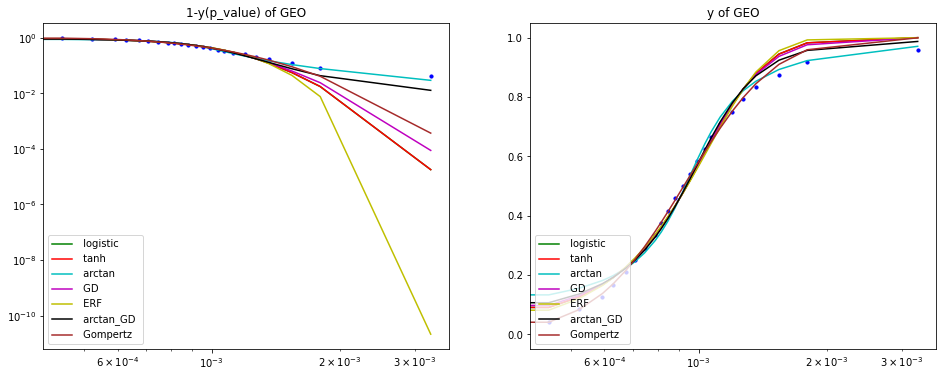

Factor for SP-GEOGD: 0.1
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0009440675958882213, 0.0012772716016736013, 0.0013693750412483029, 0.0015068798006926864, 0.0016320224261363156, 0.0017237301189117198, 0.0018261025685658962, 0.0019896153757768074, 0.0021274872574521186, 0.0023326203927375544, 0.002657942291493775, 0.0029895444070720117, 0.003602456353017418, 0.004116013434387527, 0.004782461550255042, 0.005986924611998698, 0.0072674289996971985, 0.008899036703951804, 0.012270132066997442, 0.016653858140598575, 0.02459948111917727, 0.038167661963542134, 0.12620165656324678]
For  GEOGD  :
curve_fit parameter on  logistic :  [4.04666329e-02 4.44158744e+01]
curve_fit parameter on  tanh :  [ 0.04046662 22.20795293]
curve_fit parameter on  arctan :  [3.78366875e-02 4.33645219e+01]
curve_fit parameter on  GD :  [ 0.04017421 17.87551028]
curve_fit parameter on  ERF :  [ 0.04080837 19.20044704]
curve_fit pa

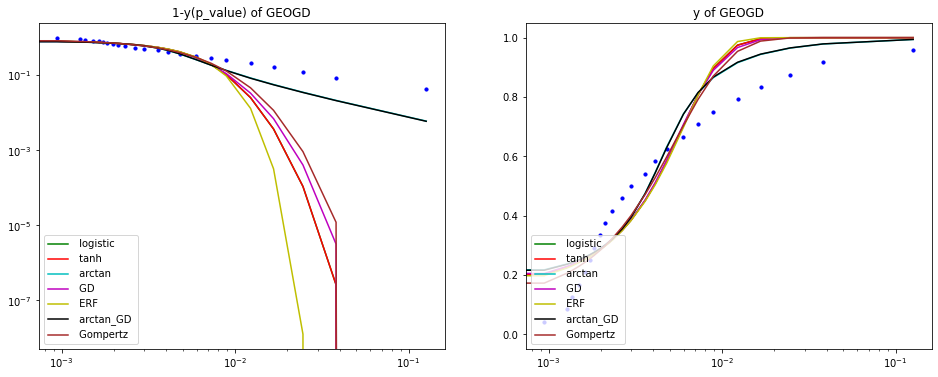

Factor for SP-HGG: 0.1
items in each bin:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15]
binned_data:  [0.018154555374581306, 0.02439155565285284, 0.028482215918319093, 0.03380950210888638, 0.03822384165084483, 0.04382981646272062, 0.048012730053260934, 0.05445536305991889, 0.06026289804298962, 0.07122305567837117, 0.08399080210609614, 0.10206842082479554, 0.1345504608115941, 0.1877591090327716, 0.25494891198286995, 0.5690718215702686]
For  HGG  :
curve_fit parameter on  logistic :  [0.66574906 3.29871463]
curve_fit parameter on  tanh :  [0.66575178 1.64933899]
curve_fit parameter on  arctan :  [0.6381119  3.22903585]
curve_fit parameter on  GD :  [0.66276922 1.32954263]
curve_fit parameter on  ERF :  [0.66924661 1.42379959]
curve_fit parameter on  arctan_GD :  [0.64175719 2.33223775 0.32697759]
curve_fit parameter on  Gompertz :  [1.08914079 2.24237965]


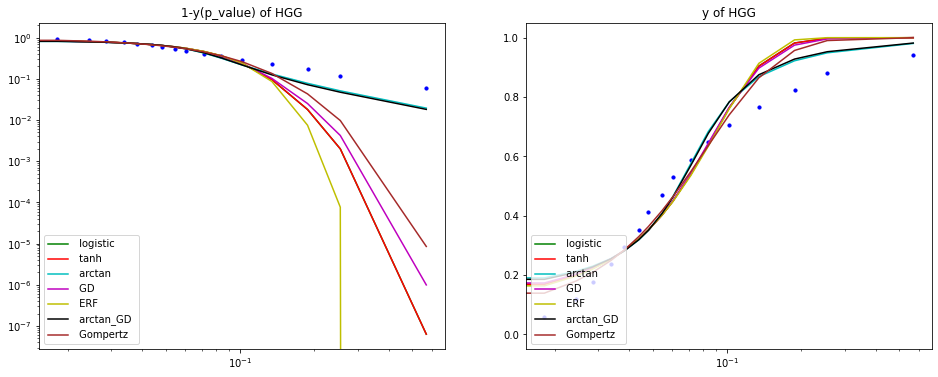

Factor for SP-SF: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0006971033789846972, 0.0009319752919256355, 0.0010020422633290709, 0.0011136915568382324, 0.0011734387245345877, 0.001228921214490543, 0.0012702094382152642, 0.0013265850667281821, 0.0013839205013961046, 0.0014417997545620902, 0.001500767873783706, 0.0015466235093441652, 0.0016167452738739458, 0.0016990913280150574, 0.001753077478715188, 0.0018306778199028368, 0.0018833450875879823, 0.0019682798146817555, 0.002103299774249067, 0.0022238587803601376, 0.0024624382029609796, 0.0028049645133744216, 0.003958546701783647]
For  SF  :
curve_fit parameter on  logistic :  [1.58791195 2.90759057]
curve_fit parameter on  tanh :  [1.58791197 1.45379513]
curve_fit parameter on  arctan :  [1.57832846 2.85558238]
curve_fit parameter on  GD :  [1.58649776 1.17961117]
curve_fit parameter on  ERF :  [1.58989983 1.24192009]
curve_fit parameter on  arctan

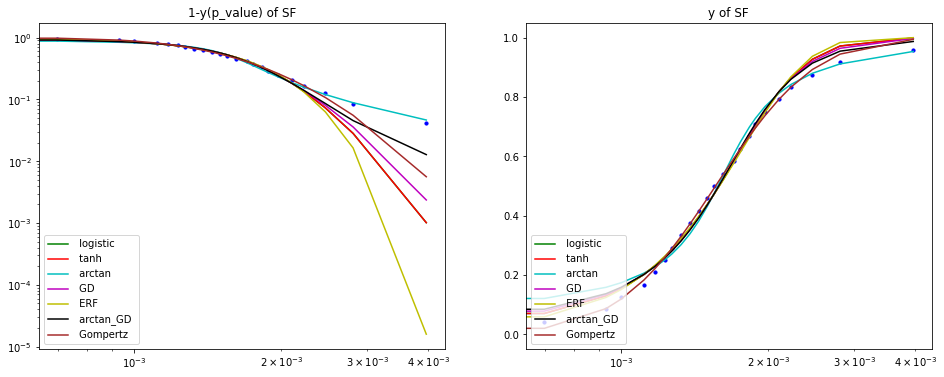

Factor for SP-SFDD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21]
binned_data:  [0.008226492653039182, 0.01127237928994606, 0.01249179104545382, 0.013159769355413187, 0.01399930195545232, 0.014743932210116061, 0.015666434834256768, 0.016313606832292524, 0.016908911623035695, 0.0177271891060171, 0.018560106243883105, 0.019587194454691485, 0.02074447834265293, 0.021624357274368147, 0.022644375666151247, 0.024407288183224417, 0.025658146829989268, 0.02771820228588814, 0.031242228250385525, 0.03539497846068752, 0.0413236594270459, 0.05202394204634896, 0.11458997170347976]
For  SFDD  :
curve_fit parameter on  logistic :  [2.0546834  1.78630905]
curve_fit parameter on  tanh :  [2.05468113 0.89315964]
curve_fit parameter on  arctan :  [2.0227669 1.7629814]
curve_fit parameter on  GD :  [2.05020686 0.72383784]
curve_fit parameter on  ERF :  [2.06076406 0.76411549]
curve_fit parameter on  arctan_GD :  [2.03341781 1.01934106

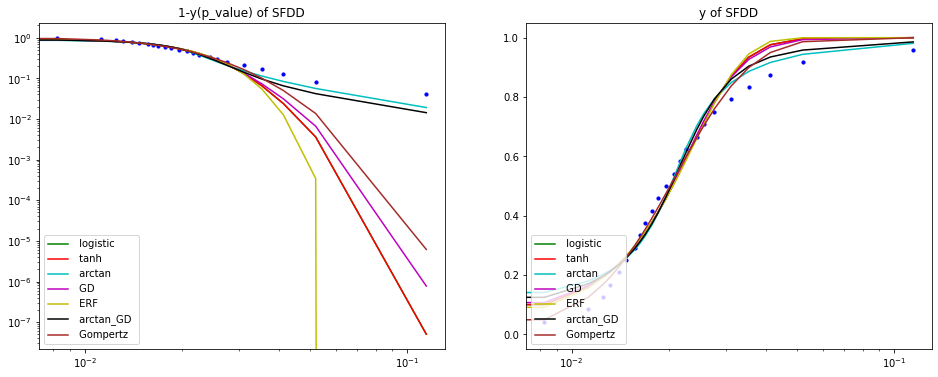

Factor for SP-Sticky: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.011382613023456438, 0.013683617759167684, 0.014928014738312935, 0.01571493828768257, 0.01644770303744444, 0.017174228254117366, 0.01786191638706095, 0.018450711495288676, 0.018941287380084177, 0.019507970115307374, 0.0200467431398837, 0.020782342037872773, 0.021345433015671912, 0.022030701844015285, 0.02262778558860707, 0.02329165078528537, 0.024113414797853585, 0.02545253888770361, 0.02625203766880995, 0.027023651634195338, 0.028453043304336807, 0.03189691462382735, 0.04019852379618449]
For  Sticky  :
curve_fit parameter on  logistic :  [2.09722834 2.80703838]
curve_fit parameter on  tanh :  [2.09722842 1.40351919]
curve_fit parameter on  arctan :  [2.08850541 2.77866359]
curve_fit parameter on  GD :  [2.09588082 1.14024325]
curve_fit parameter on  ERF :  [2.0989559  1.19817215]
curve_fit parameter on  arctan_GD :  [2.09544611 1.1

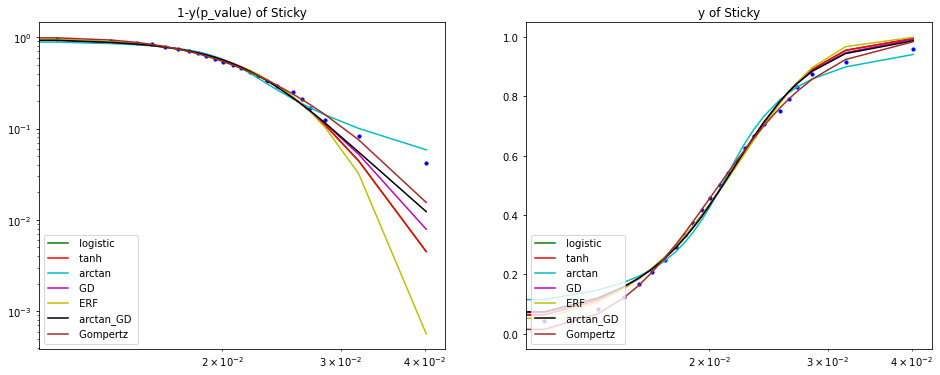

In [24]:
for S in Species:
    df_S = data_frame(S)
    for i in range(len(Classes[:-1])):
        data_i = data_distance(data(df_S,Classes[:-1][i]))
        factor_i = get_factor(data_i)
        print("Factor for {}-{}: {}".format(S,Classes[:-1][i],factor_i))
        sigmoids_for_class(data_i, Classes[:-1][i], factor_i, functions, colors,binning=True)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


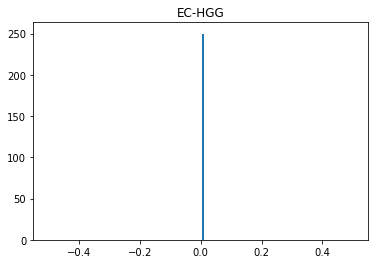

In [12]:
# EC-HGG all 0s after normalization
df_EC = data_frame("EC")
ec_hgg = data_distance(data(df_EC,"HGG"))
print(ec_hgg)
plot_data_distance(ec_hgg, "EC-HGG")

## Best Sigmoid fitted to binned data wrt original data

In [20]:
def sigmoid_to_ori(data, species, name, factor, func, p_control=None, gmean=False):
    binned_x, binned_y = binning_xy(data_binning(data,gmean=gmean))
    ori_x, ori_y = empirical_CDF(data, name)
    
    f,ax = plt.subplots(1,2,figsize=(16,6))
    ax[0].set_title('P-value: Binned '+species+'-'+name)
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].scatter(binned_x,1-binned_y, color='r',s=10)

    ax[1].set_title('P-value: Original '+species+'-'+name)
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].scatter(ori_x,1-ori_y, color='r',s=10)
    
    p = auto_curve_fit(data,binned_x,binned_y, factor,func,p_control=p_control)
    binned_y2 =  func(binned_x/factor, *p)
    ori_y2 = func(ori_x/factor, *p)
    
    print("P-val Error at the furthest tail of Binned Y: ",binned_y2[-1]-binned_y[-1])
    print("P-val Error at the furthest tail of Original Y: ",ori_y2[-1]-ori_y[-1])    # (1-ori_y[-1]) - (1-ori_y2[-1]) = ori_y2[-1]-ori_y1[-1]
    
    ax[0].plot(binned_x, 1-binned_y2, color='b', label=str(func)[9:-22])
    ax[1].plot(ori_x, 1-ori_y2, color='b',label=str(func)[9:-22])
    ax[0].legend(loc='lower left')
    ax[1].legend(loc='lower left')
    plt.show()
    return

Species:  AT
Factor for AT-ER: 1e-05
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [1.086280590305347e-05, 1.5485703526428142e-05, 2.019659334544122e-05, 2.462750241359776e-05, 2.917611446615245e-05, 3.3463621430509686e-05, 3.873844532887376e-05, 4.0488722814818385e-05, 4.2648937666230734e-05, 4.4673570655667445e-05, 4.6117281099309485e-05, 4.783421621912026e-05, 5.0339253508758155e-05, 5.3522389455066104e-05, 5.6875205240236556e-05, 6.130537583390435e-05, 6.675036295774041e-05, 7.296061821094876e-05, 7.799883418996967e-05, 8.409752614755949e-05, 9.908389854174012e-05, 0.0001299936777736, 0.00041906947798248757]
curve_fit parameter on  arctan :  [4.99318686 0.60992837]
P-val Error at the furthest tail of Binned Y:  0.027538114569740424
P-val Error at the furthest tail of Original Y:  -0.0009469048362649168


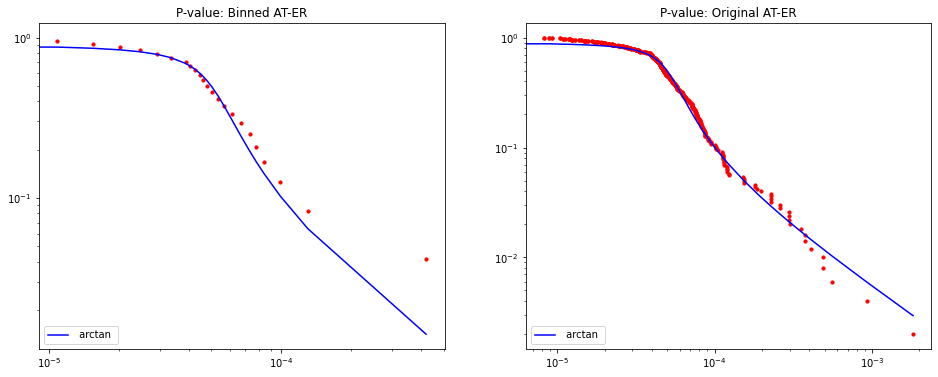

Factor for AT-ERDD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0031758847545208854, 0.004277816744535443, 0.004769437448824761, 0.005154322811140677, 0.0058010958801809846, 0.006329436475444272, 0.006798499621501558, 0.007373610651193811, 0.008218845248584152, 0.008800658796488456, 0.009611257806046157, 0.010229884291325448, 0.010886993077526436, 0.011707851269802323, 0.012454102000309825, 0.013263480998779144, 0.01464427810126265, 0.015806992687822156, 0.01744210301399909, 0.018827708294642722, 0.020774941720771756, 0.025159192011062436, 0.04690535407386832]
curve_fit parameter on  arctan :  [1.05559788 2.51593788]
P-val Error at the furthest tail of Binned Y:  0.006998468115444245
P-val Error at the furthest tail of Original Y:  -0.008713767446427823


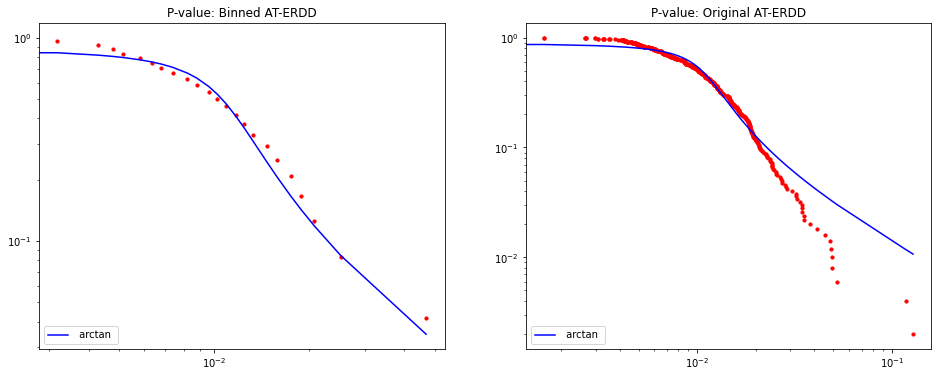

Factor for AT-GEO: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [8.450032232475552e-05, 9.88869936927653e-05, 0.00011685175573471299, 0.00012709750993083696, 0.00013415832835594226, 0.0001455399118505989, 0.00015806430473986298, 0.00016855401968514413, 0.00017973441356335776, 0.0001903489515646219, 0.00020189044764912356, 0.0002098764275920204, 0.000225541420781397, 0.00023927330896674796, 0.0002599857410730945, 0.00028006206295256474, 0.0003006528551292089, 0.00032143025118592405, 0.00035503764104818713, 0.0003999429319586306, 0.0004703123065254638, 0.0005748502051889289, 0.001137363402920848]
curve_fit parameter on  arctan :  [2.21920906 1.32532057]
P-val Error at the furthest tail of Binned Y:  0.015489807503703323
P-val Error at the furthest tail of Original Y:  -0.005175816598964822


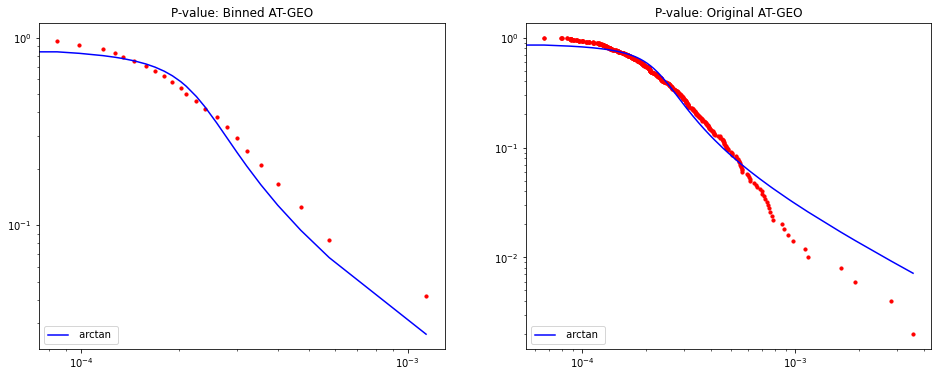

Factor for AT-GEOGD: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.00010170984419168844, 0.00012211584894140554, 0.00013489003085871037, 0.00015158008927764122, 0.00016517057652412842, 0.00018165915019925674, 0.0002005030969313127, 0.00022902772628199865, 0.00025639601359769956, 0.00028666045588759265, 0.0003176723452757374, 0.0003598727153482594, 0.0004034171234033893, 0.00044903822993352596, 0.0005200670626162152, 0.0006010677498253293, 0.0007277938876395159, 0.0008817744860812784, 0.0011856590955835365, 0.0017841903358115317, 0.0023869955601130747, 0.004574626686315653, 0.011639141227660271]
curve_fit parameter on  arctan :  [0.40922295 4.32666737]
P-val Error at the furthest tail of Binned Y:  0.03511640401933713
P-val Error at the furthest tail of Original Y:  -0.0009499618240453866


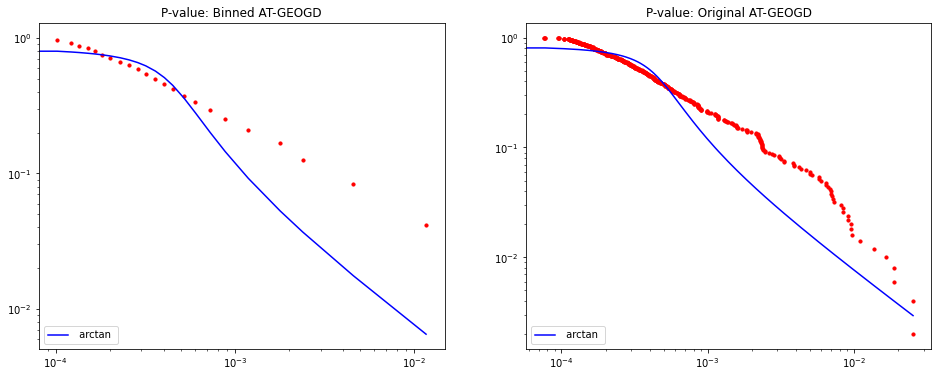

Factor for AT-HGG: 0.1
items in each bin:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15]
binned_data:  [0.03181400251572308, 0.041282381551055104, 0.04868783238603909, 0.0548837807392126, 0.06300482717178135, 0.06873587424314495, 0.07568462094077491, 0.08580076464317891, 0.09518293192296415, 0.10867444524706318, 0.12263366188866756, 0.1489658932464197, 0.17799054260056998, 0.21297991809134195, 0.253896845468488, 0.44735094218427557]
curve_fit parameter on  arctan :  [0.97574538 2.35623172]
P-val Error at the furthest tail of Binned Y:  0.02038880346135774
P-val Error at the furthest tail of Original Y:  -0.019459211894891415


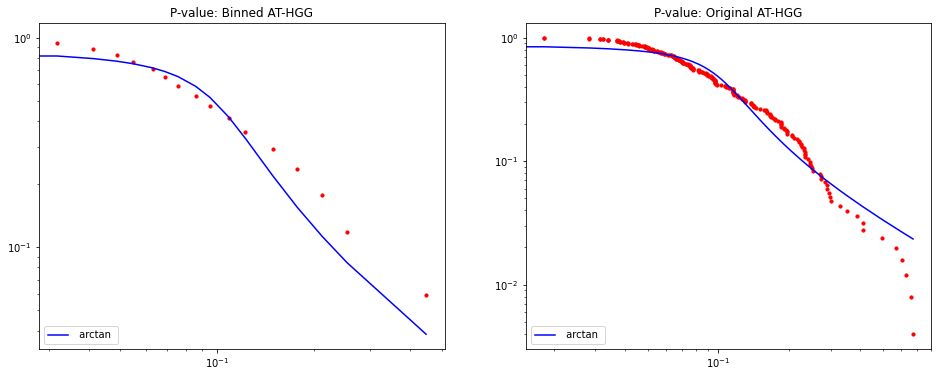

Factor for AT-SF: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [0.00013566339222981016, 0.00017486931119427187, 0.0001884638925695141, 0.00020110050632290118, 0.0002123618582219867, 0.00022045409346387013, 0.0002266659483870964, 0.00023643132834012023, 0.0002487169655125159, 0.0002616653617936598, 0.00027506415474923225, 0.00028392086884787077, 0.00029568028600073995, 0.00030885965481052766, 0.00032648536601931935, 0.00034696017051109716, 0.00036250953343718956, 0.00038062702639646376, 0.00040207696297742297, 0.0004315542455461374, 0.0004695646373727145, 0.0005406974275502944, 0.0008234153213515486]
curve_fit parameter on  arctan :  [2.90944193 1.40479058]
P-val Error at the furthest tail of Binned Y:  -0.0006367059070468972
P-val Error at the furthest tail of Original Y:  -0.009802544396722457


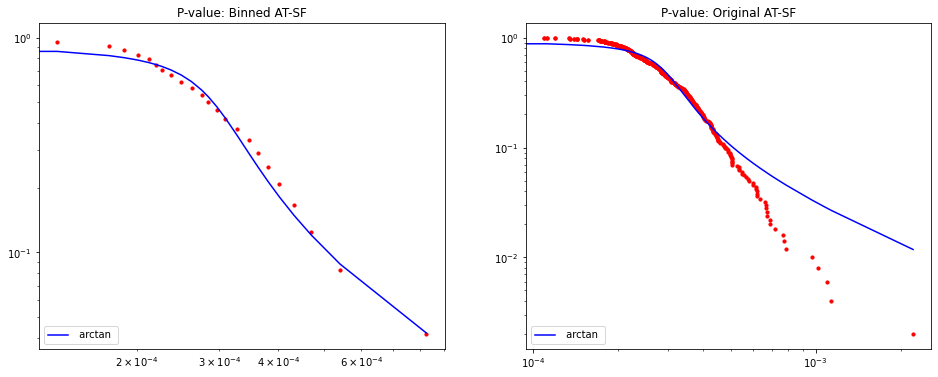

Factor for AT-SFDD: 0.1
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.005276547428645904, 0.0070606054044205745, 0.00789459835185334, 0.008760942029645268, 0.00968871081234932, 0.010754779983763516, 0.01180025628540614, 0.012610484317537118, 0.013214011290848104, 0.013881083387259557, 0.014749492710883456, 0.015645128726620047, 0.016383814132220606, 0.01774924387801238, 0.019138524702792196, 0.02117512858020939, 0.023699066647229306, 0.026701363898755204, 0.02932260806076719, 0.03363465426653322, 0.04479633179320766, 0.06398694163190759, 0.16837525556586916]
curve_fit parameter on  arctan :  [ 0.16505616 16.36330446]
P-val Error at the furthest tail of Binned Y:  0.02886478212031418
P-val Error at the furthest tail of Original Y:  -0.0019326639083682151


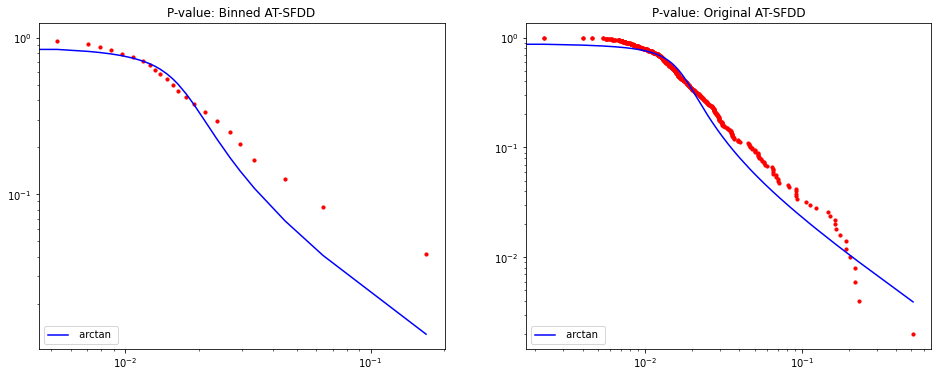

Factor for AT-Sticky: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0032016844168821098, 0.0037345978045930715, 0.0040742602262939095, 0.004291273391973335, 0.0043973935681283416, 0.004547449158754947, 0.004743289737624017, 0.004895883820022594, 0.005054969755190115, 0.005246783749164899, 0.005424913581729261, 0.005539414804983166, 0.005780802083311756, 0.00603490679314948, 0.006257775792045739, 0.006646340880037335, 0.006886301116030353, 0.007200831661630905, 0.007550906308645545, 0.007989378725275149, 0.00870913181691955, 0.009734908902017536, 0.012560304649351664]
curve_fit parameter on  arctan :  [5.71007098 0.86372475]
P-val Error at the furthest tail of Binned Y:  -0.011628084500093006
P-val Error at the furthest tail of Original Y:  -0.027574332013515557


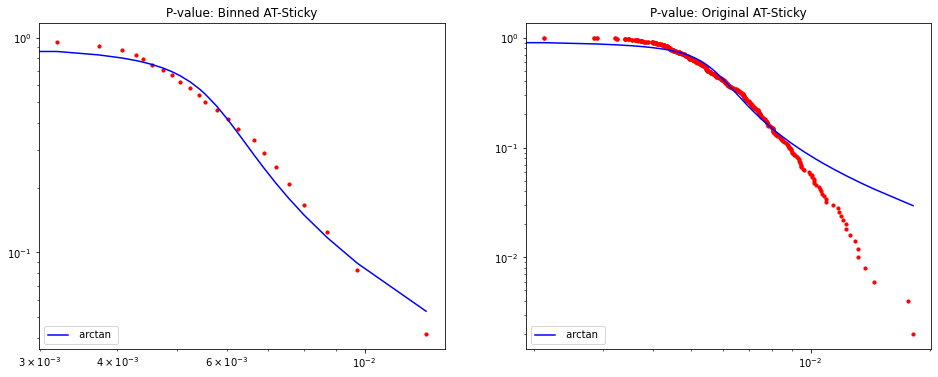

Species:  CE
Factor for CE-ER: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [5.467544019904848e-05, 8.047458050544976e-05, 9.369292105546995e-05, 0.00010773837679965295, 0.00011843326379607184, 0.00013521232300196738, 0.00014583951143746964, 0.0001566244126099535, 0.0001681436656643695, 0.00017493108986922024, 0.0001804028083939712, 0.000188643928279529, 0.00020011076179041407, 0.00021105332583730107, 0.00021902760243218238, 0.0002300054924208689, 0.00025228439103701513, 0.00026944404045572734, 0.0002982289937437145, 0.0003199673007562195, 0.00034732856115955095, 0.00045333334358253763, 0.0009606517445608706]
curve_fit parameter on  arctan :  [1.94403202 1.70710855]
P-val Error at the furthest tail of Binned Y:  0.01737958109282456
P-val Error at the furthest tail of Original Y:  -0.005091175917485646


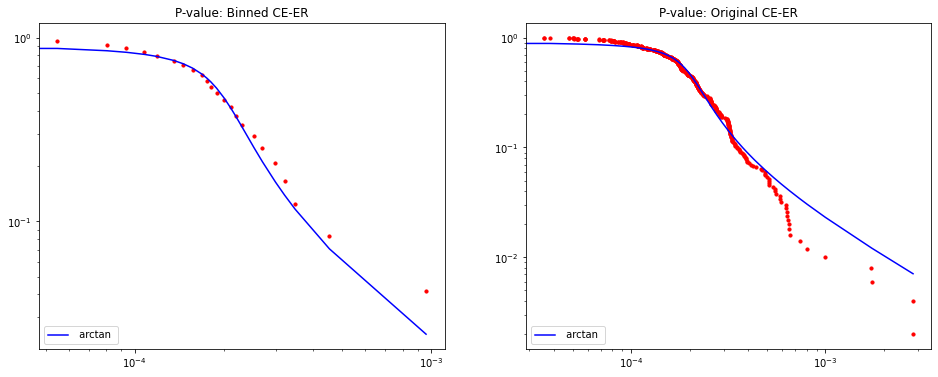

Factor for CE-ERDD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.005450885635041624, 0.0065276215090261875, 0.007292907484637608, 0.007725036175740885, 0.008055040720727023, 0.00852610572588208, 0.009020720610437665, 0.009365690607631007, 0.009783321607125419, 0.01007549211466997, 0.010411793588761197, 0.010906535975075859, 0.011307588913135286, 0.011930178604625431, 0.012581210358660304, 0.013209578303543579, 0.013819207654841893, 0.014965812168814136, 0.015966993492981616, 0.01752647479347353, 0.01948639045599876, 0.023378783868690557, 0.04925476266896397]
curve_fit parameter on  arctan :  [1.12137361 3.63648897]
P-val Error at the furthest tail of Binned Y:  0.018696673955418963
P-val Error at the furthest tail of Original Y:  -0.002053421016131929


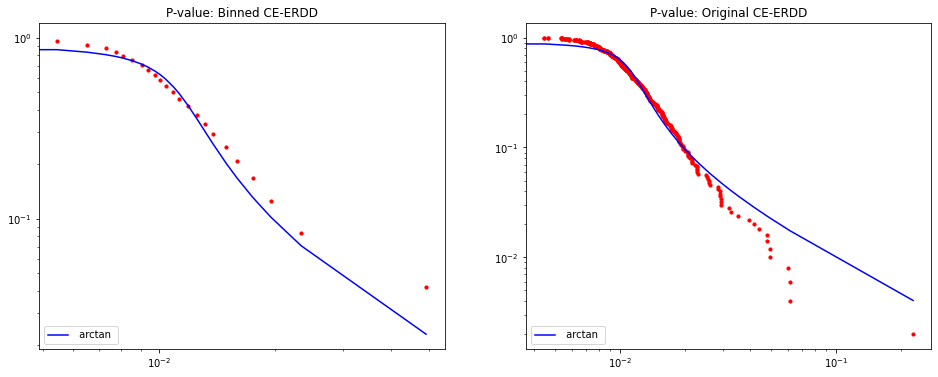

Factor for CE-GEO: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [0.000687734354034566, 0.0009271618516108324, 0.001041454396356254, 0.0011473707120883024, 0.0012262318459194163, 0.0012851538397946826, 0.0013274330740212375, 0.0014036614551506436, 0.0014635700362012978, 0.0015297967270057264, 0.0015869970590134562, 0.0016330234763147814, 0.001702395035677657, 0.0017798239768957323, 0.001892721647368925, 0.001983174317720202, 0.0020289700526720557, 0.0021071546596590626, 0.0022661770265868845, 0.002471588537721014, 0.002693489917082002, 0.0032419072831852904, 0.004462816772607084]
curve_fit parameter on  arctan :  [1.67447049 2.52818326]
P-val Error at the furthest tail of Binned Y:  -0.0031879221934817403
P-val Error at the furthest tail of Original Y:  -0.02560411926198647


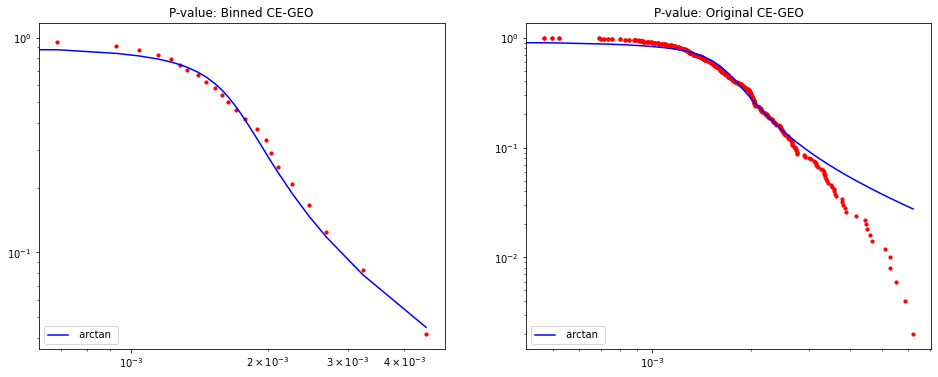

Factor for CE-GEOGD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0008973894874257128, 0.0011457798260232147, 0.001289463291765579, 0.0014217175696829105, 0.0015391803756615882, 0.0016349326828040494, 0.0017339838661736236, 0.001825783088560944, 0.0020028568377920522, 0.002179849904529667, 0.002342885422362477, 0.0025246712656795942, 0.0027674292661614085, 0.0030632635832616197, 0.0035676427453040097, 0.004019916761637601, 0.004603214235840629, 0.005489083121721927, 0.006271124711426189, 0.007364324876868316, 0.009178123173825008, 0.011852196354428038, 0.03623925148886926]
curve_fit parameter on  arctan :  [0.28638781 7.35621265]
P-val Error at the furthest tail of Binned Y:  0.02870891267646214
P-val Error at the furthest tail of Original Y:  -0.0010821101975955205


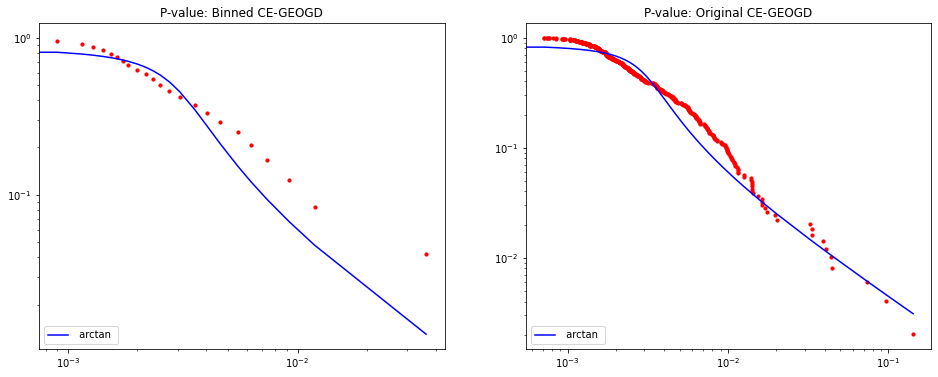

Factor for CE-HGG: 0.01
items in each bin:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15]
binned_data:  [0.015969918876409153, 0.02086786314515343, 0.02388263054617101, 0.026293836873475886, 0.02906286205172634, 0.03125958256699789, 0.034565076386872486, 0.03825631266425719, 0.04370928802656177, 0.05251654325738006, 0.06567948390398873, 0.0808409709406106, 0.10182156542097726, 0.1299305856772495, 0.18476185980382648, 0.45768877484051035]
curve_fit parameter on  arctan :  [4.80252394 0.41307615]
P-val Error at the furthest tail of Binned Y:  0.0400352103595909
P-val Error at the furthest tail of Original Y:  -0.0005275756955812616


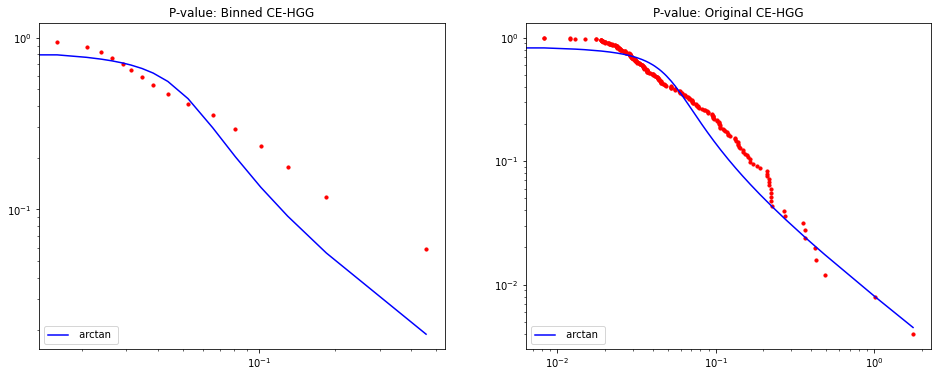

Factor for CE-SF: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0004590960188074009, 0.0005637363427591436, 0.000609598960095452, 0.0006800502287594257, 0.0007277077820856833, 0.0007604911314325446, 0.0007901297440982094, 0.000823400049245684, 0.0008423057981285031, 0.000867978605410678, 0.0008959962916479674, 0.0009255273888473161, 0.000952368873546437, 0.000995993612779888, 0.0010380940480022047, 0.0010825612333744093, 0.0011256722899137708, 0.001185702616267614, 0.0012593639020305667, 0.001345548297554033, 0.0015094100736265533, 0.0017993151812095206, 0.0024379212205331703]
curve_fit parameter on  arctan :  [9.43662909 0.5117897 ]
P-val Error at the furthest tail of Binned Y:  0.000278541566783308
P-val Error at the furthest tail of Original Y:  -0.017014499417306372


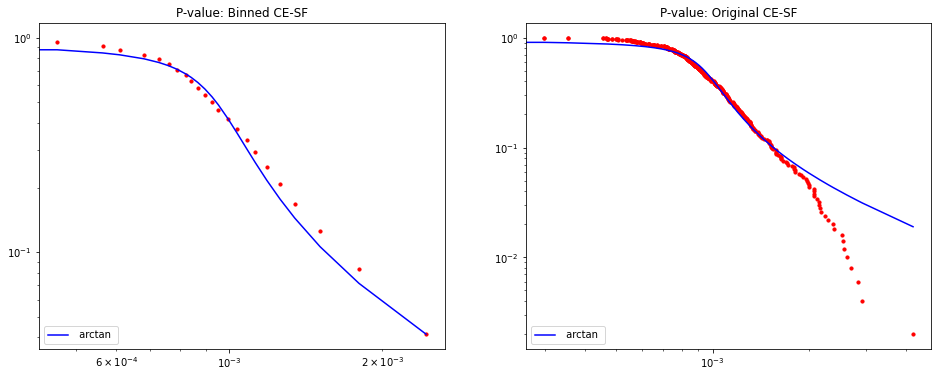

Factor for CE-SFDD: 0.1
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21]
binned_data:  [0.00930020151666805, 0.010363285525378635, 0.011282057522512238, 0.012524082426844779, 0.013597422646395513, 0.014285608440251145, 0.015430116695504682, 0.016492754951954593, 0.01762232649754401, 0.01852134400078224, 0.019964053832317898, 0.021877238662279582, 0.023734222879586972, 0.02511208765105848, 0.02708190627430849, 0.02969150646346437, 0.03475289811885764, 0.04069011668995651, 0.04568218870278803, 0.05232014211900216, 0.06388087398747283, 0.08650706070711517, 0.26307080708219427]
curve_fit parameter on  arctan :  [ 0.23234197 10.83208823]
P-val Error at the furthest tail of Binned Y:  0.02942027601755781
P-val Error at the furthest tail of Original Y:  -0.00047956790398850924


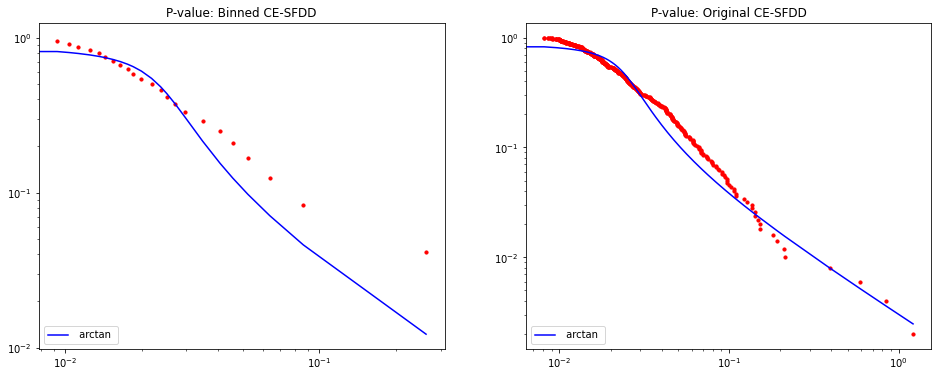

Factor for CE-Sticky: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [0.004506913996926661, 0.005160342833521333, 0.005650946631711933, 0.005921372643429166, 0.00614740423314416, 0.0065638699924136035, 0.006792928873610899, 0.0069932905874009335, 0.0072025404796388255, 0.007483896226542122, 0.007693390655254189, 0.007910555908058125, 0.00818527266931838, 0.008420621774086963, 0.008736235749199982, 0.009072560906296644, 0.009321335987737604, 0.009685171553279066, 0.010127633512691938, 0.010572837771755418, 0.011431617877834935, 0.012818339098981845, 0.015568335902638926]
curve_fit parameter on  arctan :  [8.00698713e+01 6.89045920e-02]
P-val Error at the furthest tail of Binned Y:  -0.01869385601073137
P-val Error at the furthest tail of Original Y:  -0.02955876864089757


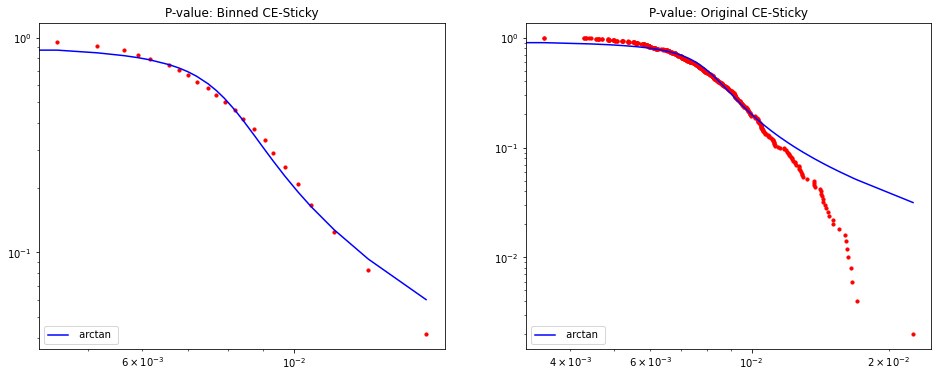

Species:  DM
Factor for DM-ER: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [3.673097115004504e-05, 5.1843991582398254e-05, 5.893561122949209e-05, 6.986155667799493e-05, 7.530091126436087e-05, 7.968907769972812e-05, 8.507854485233822e-05, 8.927319621284304e-05, 9.42982335672369e-05, 0.00010124743826312745, 0.00010637499153204306, 0.0001108692641058695, 0.00011428043294763163, 0.00011895981053924863, 0.00012527212264270887, 0.0001329774339316897, 0.0001410583486477137, 0.00014967533644438913, 0.00016022956305038598, 0.00017567149647954925, 0.0001932789172496633, 0.00022473828225678857, 0.0006651030746132734]
curve_fit parameter on  arctan :  [ 0.11172677 32.38521556]
P-val Error at the furthest tail of Binned Y:  0.023923438339737646
P-val Error at the furthest tail of Original Y:  -0.0004065338839536192


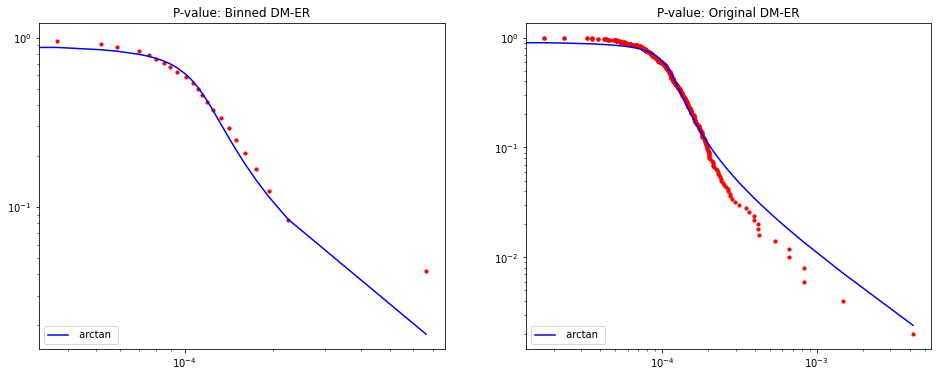

Factor for DM-ERDD: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0010773001326346613, 0.0012603430271350975, 0.0013969182783720969, 0.0014933803391349654, 0.001612178275283895, 0.0017357153973468508, 0.0018057753475190245, 0.0018914240503952685, 0.0019612129928963697, 0.002014828550345415, 0.002086528667058739, 0.0021873257173030255, 0.00226929230986507, 0.002332544101564317, 0.002403634734463063, 0.0024646024076844875, 0.00255502992768426, 0.002663551941502126, 0.002787875616902235, 0.00299125753255541, 0.0033469720078895143, 0.003824684162792095, 0.0051403594781855135]
curve_fit parameter on  arctan :  [2.1884232  2.25038171]
P-val Error at the furthest tail of Binned Y:  -0.00589294046209099
P-val Error at the furthest tail of Original Y:  -0.024368033547454537


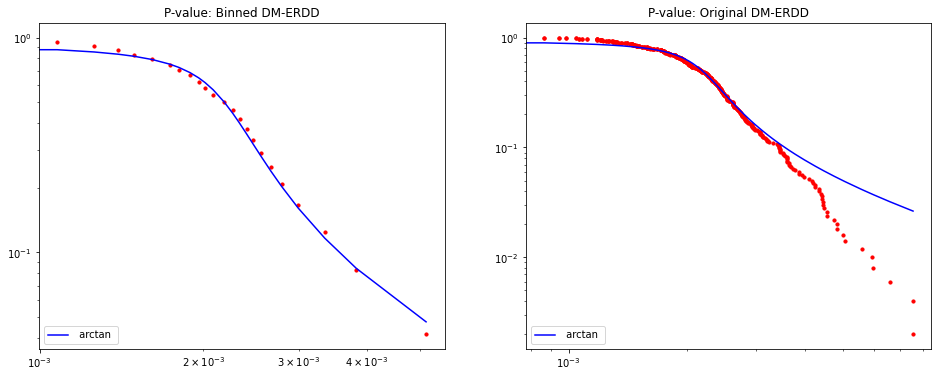

Factor for DM-GEO: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.00022067112656827813, 0.00028326252747469955, 0.00031075962886469797, 0.00033722170420490925, 0.0003693517349838273, 0.00038993161899764095, 0.00041441253633081344, 0.00043053987558387333, 0.0004492030347445167, 0.0004678286604578523, 0.00048171868516551624, 0.0004987613102186878, 0.0005249492867842699, 0.0005514088710370148, 0.0005758465550025488, 0.0006077052475344037, 0.0006423222043425116, 0.0006826821757181996, 0.0007299688102338711, 0.0008068529506414768, 0.0009072054632940417, 0.0010553242072043588, 0.0015749857844350199]
curve_fit parameter on  arctan :  [5.15934205 0.77120717]
P-val Error at the furthest tail of Binned Y:  0.002886846365102058
P-val Error at the furthest tail of Original Y:  -0.018153361617367025


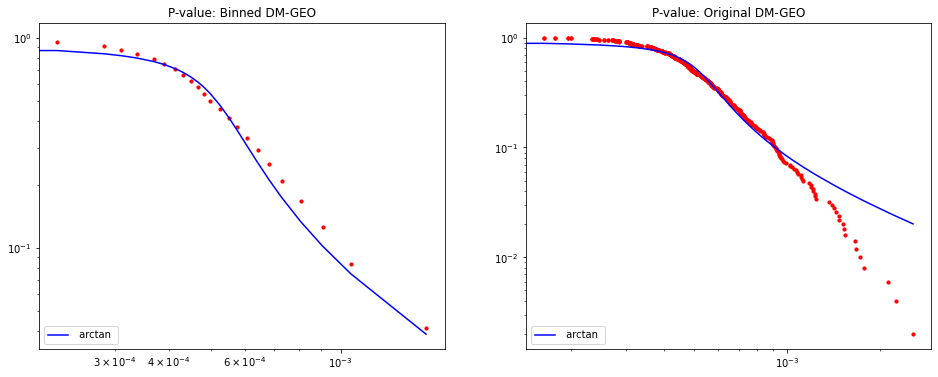

Factor for DM-GEOGD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21]
binned_data:  [0.00022740215264195114, 0.0005200964447540927, 0.0006406202913629203, 0.0007603644470695298, 0.0008149083937883631, 0.0008797721756159543, 0.0009372604226075655, 0.0010090845040341785, 0.0010943170191209674, 0.0012377863241113173, 0.0013906437719978667, 0.0015484237626649821, 0.0017730286309429002, 0.0020008896084253228, 0.0023356171553943765, 0.0027801216255994338, 0.003337315886551138, 0.0042707865830246584, 0.005411996419709266, 0.008705443458020736, 0.014621195718494906, 0.02863342187807518, 0.14191068955673442]
curve_fit parameter on  arctan :  [0.18265426 9.46285072]
P-val Error at the furthest tail of Binned Y:  0.03926545242478319
P-val Error at the furthest tail of Original Y:  0.0008532351007930483


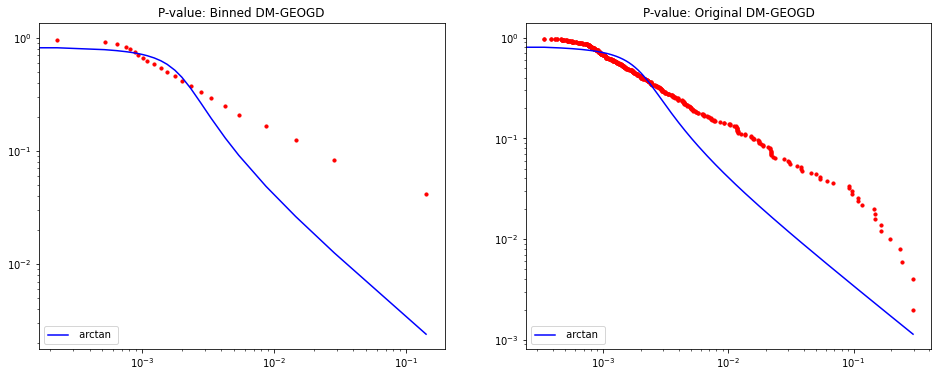

Factor for DM-HGG: 0.1
items in each bin:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15]
binned_data:  [0.014240761527233935, 0.026237473140339904, 0.03191335855334455, 0.03764382084756629, 0.042522096576268785, 0.048504212933190974, 0.05523073875074534, 0.05957838672887935, 0.0679041585917001, 0.07379180583796494, 0.08353683974822709, 0.09490774056036434, 0.11428187027586828, 0.14384888456680145, 0.20203221959901393, 0.4885544868526846]
curve_fit parameter on  arctan :  [0.66947367 3.55228186]
P-val Error at the furthest tail of Binned Y:  0.03760131924996879
P-val Error at the furthest tail of Original Y:  -0.004469496521753102


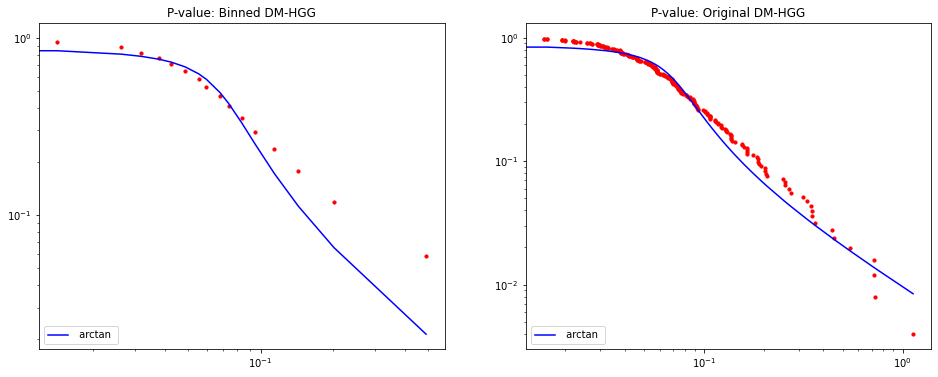

Factor for DM-SF: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0004455365029289293, 0.0005836894671453221, 0.0006413016884780543, 0.0006796963584943458, 0.000719870664227423, 0.0007558576359066013, 0.0007982217168705826, 0.0008406872907931042, 0.0008788329659044195, 0.0009192382164930113, 0.0009494795574153592, 0.0009866493325991605, 0.0010454894028070786, 0.0010859232186852764, 0.001145202870517551, 0.0012201091931145142, 0.0012796343335940855, 0.0013282022850166536, 0.00140228992826992, 0.0015817052922733465, 0.0016817039217205594, 0.001984987806300788, 0.003488128675356393]
curve_fit parameter on  arctan :  [1.01912458 3.87724585]
P-val Error at the furthest tail of Binned Y:  0.008535807108530746
P-val Error at the furthest tail of Original Y:  -0.005750621039508408


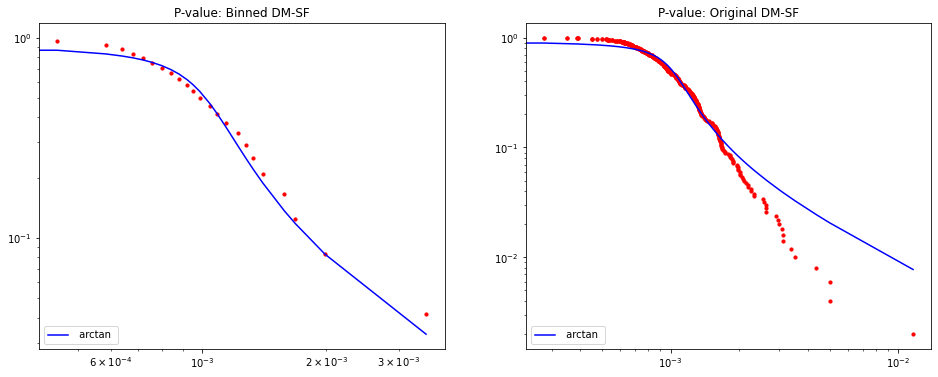

Factor for DM-SFDD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21]
binned_data:  [0.003776496415314018, 0.004614144418992037, 0.004989338193857645, 0.005181456320132318, 0.0054436465422096686, 0.005789703061761054, 0.006104132399622389, 0.006398862418479894, 0.006706193309453212, 0.007011579329954737, 0.007238239884885377, 0.007410438184177719, 0.007573239085256218, 0.007778010614032175, 0.008067963311937652, 0.008484707607048066, 0.008967756794503822, 0.009457236304418415, 0.010138581186745139, 0.010872922250288254, 0.01210046244491569, 0.014161486712842956, 0.023664195845902757]
curve_fit parameter on  arctan :  [0.74680067 6.40177216]
P-val Error at the furthest tail of Binned Y:  0.011061420634625674
P-val Error at the furthest tail of Original Y:  -0.006337046478947395


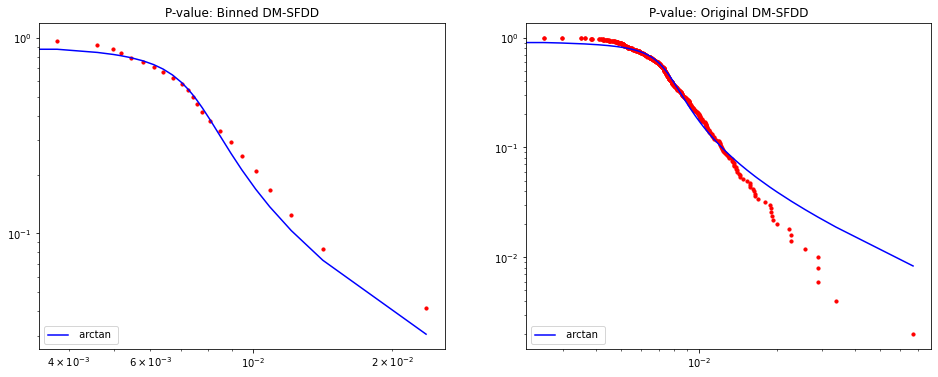

Factor for DM-Sticky: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0019435218001172955, 0.002365163528178876, 0.002625658106291884, 0.002835127239576674, 0.00296477481623362, 0.0031735478392555523, 0.0033026167717475604, 0.003435366320134679, 0.0035300877261809447, 0.003690455151662736, 0.0038587047940327507, 0.003983531596988412, 0.004076245184145726, 0.004187656300038272, 0.004330289703435961, 0.004580410574465814, 0.004706415679284346, 0.004848687642308388, 0.005029193041398815, 0.0053393049615310054, 0.005986637103413388, 0.006920144725043865, 0.012633029860612478]
curve_fit parameter on  arctan :  [ 0.39821299 12.62188151]
P-val Error at the furthest tail of Binned Y:  0.012596004659832682
P-val Error at the furthest tail of Original Y:  -0.004322074298921619


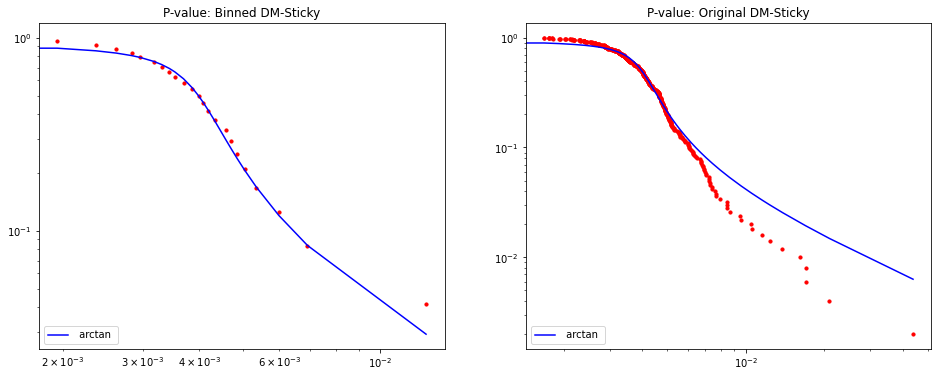

Species:  EC
Factor for EC-ER: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [0.00023475339364692393, 0.0003295094228806803, 0.00039716146507462816, 0.00045792990295923596, 0.0005350001517643326, 0.000579452748358593, 0.0006113723967112016, 0.0006508966286806737, 0.0006982105933780797, 0.0007309777211499075, 0.00076129440619951, 0.0007937410467869327, 0.0008292328064867272, 0.0008702901843510867, 0.0009216464532088378, 0.0009994589875586288, 0.0010916465456474091, 0.0011547293514884318, 0.0011992058800126396, 0.0012645286742016596, 0.0013943232229192085, 0.0017790249176440115, 0.007592238051976526]
curve_fit parameter on  arctan :  [0.81549451 4.08313249]
P-val Error at the furthest tail of Binned Y:  0.030168022461005917
P-val Error at the furthest tail of Original Y:  2.4548906399912696e-06


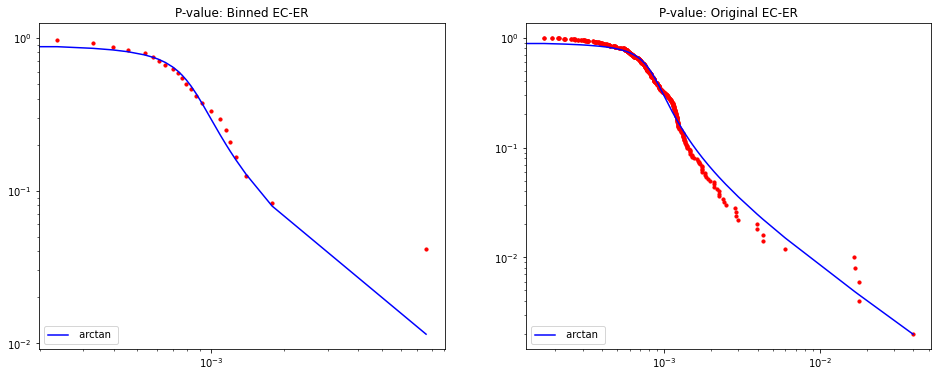

Factor for EC-ERDD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0029325192320127733, 0.003571767075866258, 0.003833335506586544, 0.004129502080081473, 0.004377018524961751, 0.004651182482657979, 0.004918160480964495, 0.005123917021454163, 0.005347985425809509, 0.0054778697568434965, 0.005646163888541799, 0.005854815829062115, 0.006088467682018915, 0.006336156377451437, 0.006583104110380042, 0.006784593552135601, 0.007099635525980044, 0.007418203999309758, 0.007680348802977531, 0.008000187952663924, 0.008697355417646968, 0.009612574823092596, 0.015988259084192435]
curve_fit parameter on  arctan :  [0.5943787  8.14715589]
P-val Error at the furthest tail of Binned Y:  0.002961482372025981
P-val Error at the furthest tail of Original Y:  -0.0037732406485506687


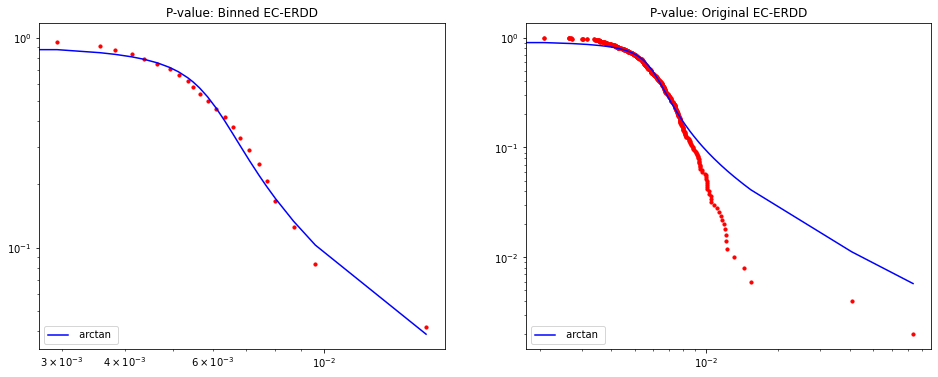

Factor for EC-GEO: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0020194001650077117, 0.0024699503542365874, 0.002693888186019092, 0.002923633535365612, 0.003194927222006122, 0.0034960667500102487, 0.0036515759929632925, 0.0037688089048067076, 0.003956193191370495, 0.004136308077819502, 0.004319617454085553, 0.004512043618276513, 0.004720905789899996, 0.0049295101780935, 0.00513931253179454, 0.005389599661699242, 0.0056790988280899166, 0.006117051947265902, 0.006515468013144924, 0.007057530279140472, 0.0075117075232240356, 0.00865469750028329, 0.016468882445186486]
curve_fit parameter on  arctan :  [0.45985166 8.56976877]
P-val Error at the furthest tail of Binned Y:  0.01047606086313524
P-val Error at the furthest tail of Original Y:  -0.005781598334259064


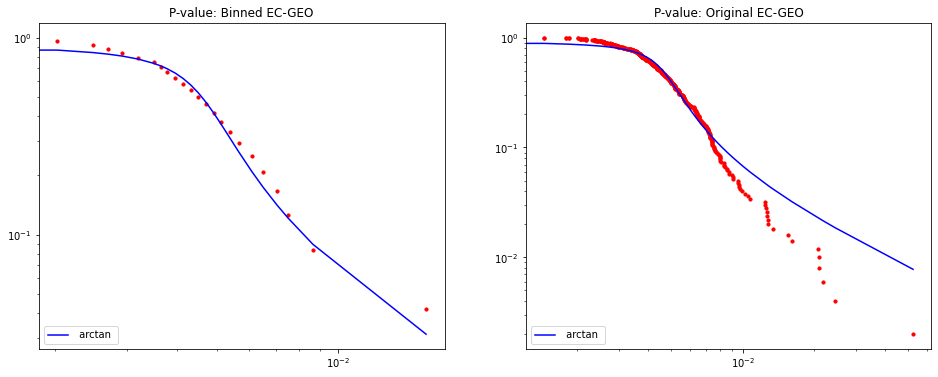

Factor for EC-GEOGD: 0.1
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0031730318689885463, 0.003959250014998115, 0.00444350899355419, 0.004831924115375988, 0.005252771148020681, 0.00568922316920564, 0.005953097290913311, 0.006288088943576914, 0.006977215543910651, 0.007510218869406035, 0.008259058280390476, 0.009180632886355825, 0.010452024014859966, 0.01157953963789113, 0.01292857298302635, 0.013990471201505787, 0.015786079651286294, 0.01759974711683244, 0.02047411156851613, 0.023224504943750453, 0.026382241901429078, 0.038814795907473214, 0.11366587970774779]
curve_fit parameter on  arctan :  [ 0.10326961 20.29402791]
P-val Error at the furthest tail of Binned Y:  0.026500035258892773
P-val Error at the furthest tail of Original Y:  -0.00023353291943839505


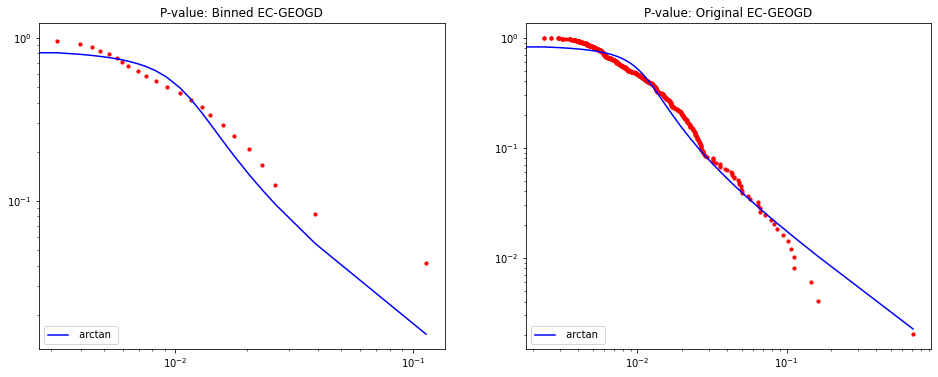

Factor for EC-HGG: 0.1
items in each bin:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15]
binned_data:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
curve_fit parameter on  arctan :  [0.09447732 0.98078227]
P-val Error at the furthest tail of Binned Y:  -0.4705876159822772
P-val Error at the furthest tail of Original Y:  -0.525442891425788


C:\Users\shiqi jiang\AppData\Roaming\Python\Python38\site-packages\matplotlib_inline\backend_inline.py:234: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


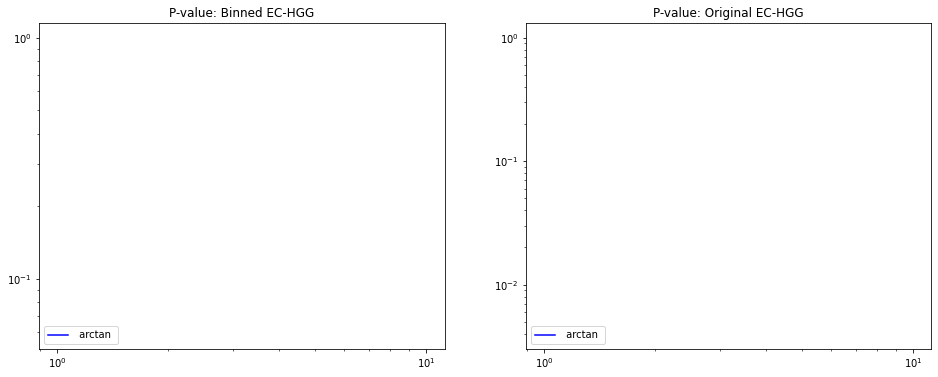

Factor for EC-SF: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [0.002812155815538528, 0.003625472858826026, 0.003983360652839886, 0.004267446606104858, 0.004459288911165215, 0.0046513442702377904, 0.00479216005663732, 0.004940575744569389, 0.005121643012977659, 0.005280724351602528, 0.005424994282771508, 0.005672917231546158, 0.005863656799543777, 0.006020078137125052, 0.006277155082288776, 0.006449142145328826, 0.006699647736144446, 0.007028109713248308, 0.007331445477214994, 0.0077763499286709215, 0.00829553092804949, 0.009199184184270874, 0.012867222662692754]
curve_fit parameter on  arctan :  [5.71571859 0.9178888 ]
P-val Error at the furthest tail of Binned Y:  -0.006454525331283656
P-val Error at the furthest tail of Original Y:  -0.014267222164979776


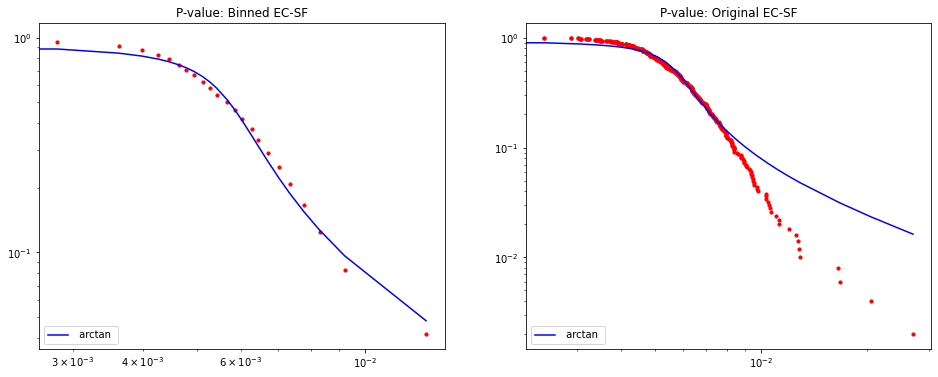

Factor for EC-SFDD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21]
binned_data:  [0.019832877189847328, 0.02834656036284462, 0.03122997549826663, 0.03403620884037726, 0.036658524461179336, 0.039612047140596574, 0.04157571037930599, 0.04300956909243834, 0.04407758019968994, 0.04585468373963709, 0.0482750147155367, 0.05061290107409892, 0.05279990774954846, 0.05459090077370187, 0.056850336461110394, 0.05945589882424656, 0.06255746197969082, 0.06627551337001623, 0.07105451763668673, 0.07610062079993611, 0.08700002520264041, 0.10167538596898759, 0.18557635742402426]
curve_fit parameter on  arctan :  [5.12308456 0.80762999]
P-val Error at the furthest tail of Binned Y:  0.01241239089518753
P-val Error at the furthest tail of Original Y:  -0.010031015586385528


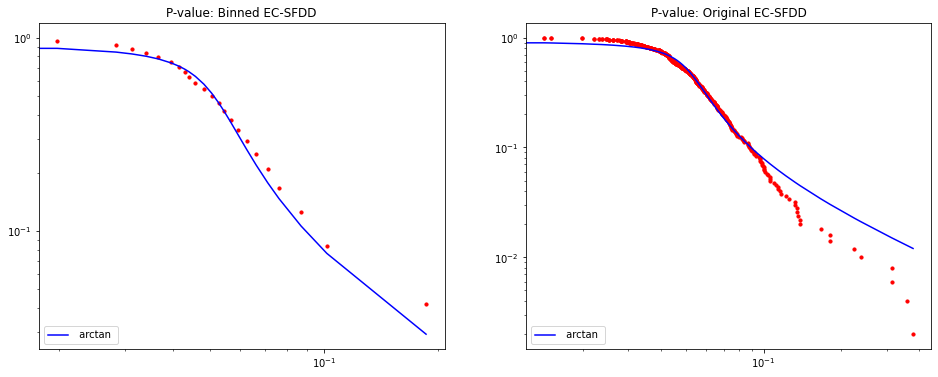

Factor for EC-Sticky: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.006555623288867338, 0.007848968047210983, 0.008438486903586574, 0.008835263356418861, 0.009425810455721632, 0.010034061841667241, 0.01042718384872342, 0.010870450629347703, 0.011169096723646594, 0.011741993360044336, 0.01217750191472688, 0.012656655902929727, 0.013032848558299061, 0.013484427453670815, 0.013950488737112215, 0.014314612943976348, 0.014921788673274998, 0.015710699549364576, 0.01634337621229497, 0.017384425191033098, 0.01866642561139476, 0.02090922261431886, 0.031000597400002366]
curve_fit parameter on  arctan :  [1.2686576 3.8968248]
P-val Error at the furthest tail of Binned Y:  -0.0026469400496665907
P-val Error at the furthest tail of Original Y:  -0.014408130064438751


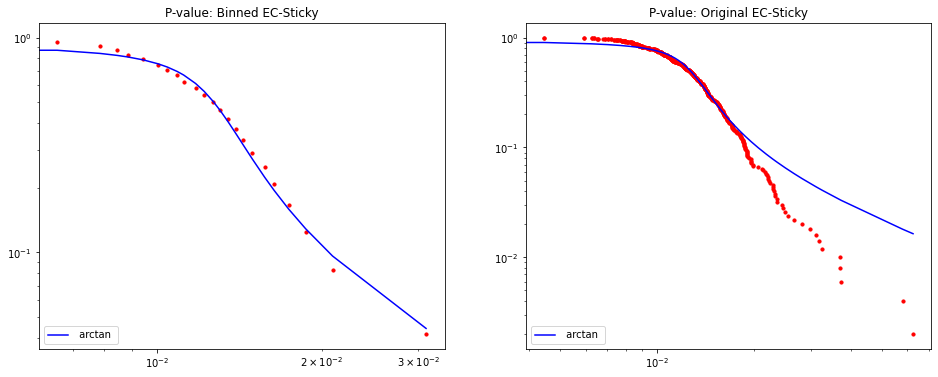

Species:  HS
Factor for HS-ER: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [8.574036247121381e-06, 1.2350947220569772e-05, 1.3727837485697364e-05, 1.5194788763419497e-05, 1.7726089946332432e-05, 1.9788409974478358e-05, 2.1006163268370498e-05, 2.2303132860755322e-05, 2.347071041158843e-05, 2.4465593540383845e-05, 2.6112252165639498e-05, 2.8154531495096823e-05, 2.978030881815281e-05, 3.094235512436009e-05, 3.316510249922713e-05, 3.5797385804474796e-05, 3.853805265942345e-05, 4.259350041933684e-05, 4.6269935629380647e-05, 5.198876090196568e-05, 6.363073638033931e-05, 9.056889132359931e-05, 0.000421136466309169]
curve_fit parameter on  arctan :  [ 0.28854931 10.22232021]
P-val Error at the furthest tail of Binned Y:  0.03373046347538933
P-val Error at the furthest tail of Original Y:  0.0010845782020407757


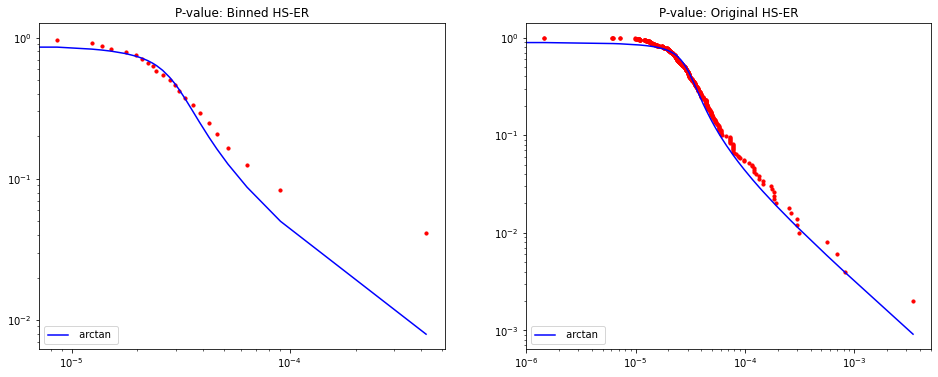

Factor for HS-ERDD: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0008182203788422535, 0.0010061712559289782, 0.0011343160575954998, 0.00124969757627708, 0.0013046015068953907, 0.0014143516267847694, 0.001530582385365966, 0.0015951308976658585, 0.0016622681739378849, 0.0017288451317221717, 0.001848294560617207, 0.0019348779499462206, 0.0019836206671552514, 0.0020788335954460115, 0.0021609931899625977, 0.0022628542495326666, 0.0023736471023948795, 0.0025031028039154564, 0.0026826936077235346, 0.002838149697028325, 0.0031353226475410883, 0.0037430164354523643, 0.00850690188886005]
curve_fit parameter on  arctan :  [1.93592575 2.05268981]
P-val Error at the furthest tail of Binned Y:  0.0181105831338213
P-val Error at the furthest tail of Original Y:  -0.002467854888155152


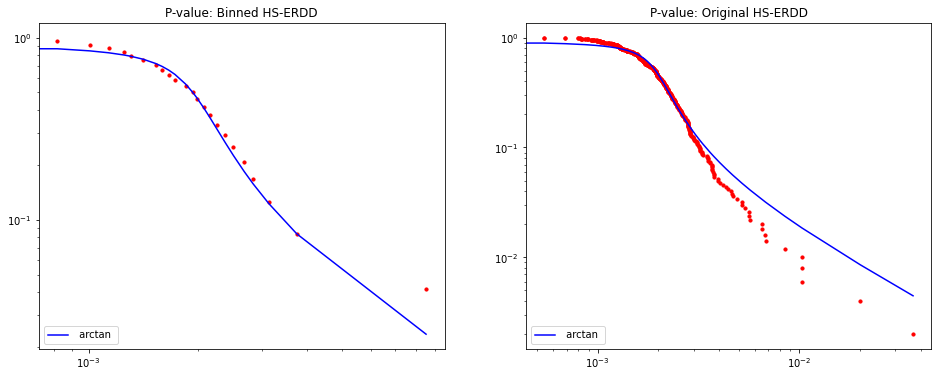

Factor for HS-GEO: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [9.772784610238227e-05, 0.00013192450199291724, 0.00014580559755547, 0.0001569922786022747, 0.00016716463792013902, 0.0001793059946410065, 0.0001901762377495374, 0.00020417218091261027, 0.00021628213404842038, 0.00022452749986612045, 0.0002340437103582081, 0.0002475035376375796, 0.0002598645671478993, 0.00027138060974553097, 0.0002865529835509081, 0.0003007809186697505, 0.0003250859997811419, 0.0003559757330749119, 0.00039022131545959947, 0.0004300135830857077, 0.0004946393736537447, 0.0005798751787286988, 0.0008714930290983822]
curve_fit parameter on  arctan :  [2.53612473 1.36810554]
P-val Error at the furthest tail of Binned Y:  0.0041855696411920995
P-val Error at the furthest tail of Original Y:  -0.016202328148626544


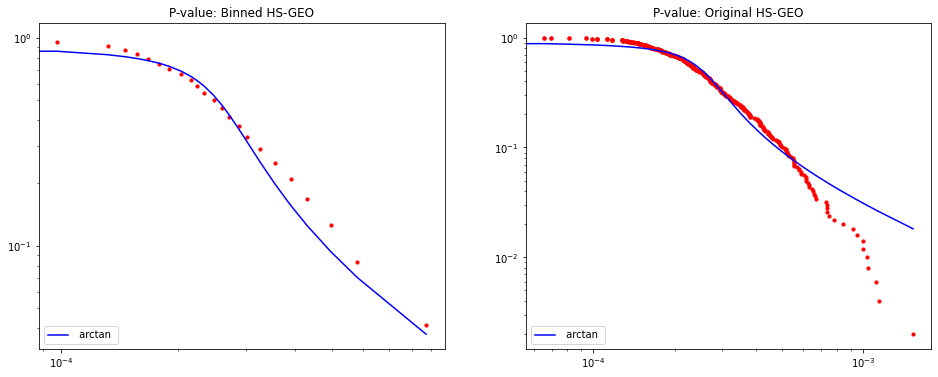

Factor for HS-GEOGD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [0.00014331131842561606, 0.00020637040762358784, 0.00025093610482597147, 0.00027645964987764584, 0.00030051792789290486, 0.000322940117511295, 0.00035987982055338296, 0.00039419276840638265, 0.0004272849258597705, 0.000479362801256432, 0.0005412699951177427, 0.0006252171813926963, 0.0007541938119920808, 0.0008664741931299053, 0.000996288693137881, 0.0011956691958292587, 0.0015603880680407367, 0.0019714314696450573, 0.0025712003277379523, 0.003858986025004535, 0.006661252572906546, 0.012380231570898367, 0.03687275547716218]
curve_fit parameter on  arctan :  [ 0.07760785 20.46316263]
P-val Error at the furthest tail of Binned Y:  0.0373575959850968
P-val Error at the furthest tail of Original Y:  0.0006801720682075851


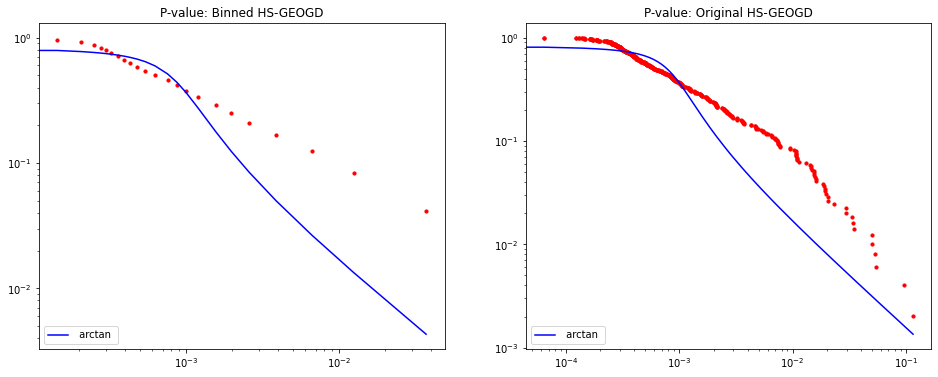

Factor for HS-HGG: 0.1
items in each bin:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9]
binned_data:  [0.032470485777490135, 0.047476989051882176, 0.053287679546154175, 0.06138461229331843, 0.07041160588506064, 0.07921297625028895, 0.09135106149487507, 0.10870072650473336, 0.16641425057793197, 0.22014037864414587, 0.4952847129527199]
curve_fit parameter on  arctan :  [0.84460928 3.035906  ]
P-val Error at the furthest tail of Binned Y:  0.05786631017333066
P-val Error at the furthest tail of Original Y:  -0.0014547236497585159


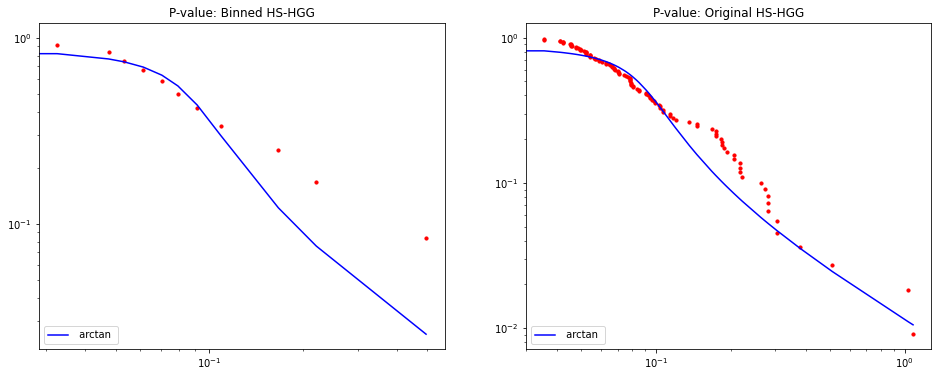

Factor for HS-SF: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [7.337761656109279e-05, 9.26024059789544e-05, 0.00010310309922244933, 0.00010979580980778766, 0.00011615358313727966, 0.00012094493431141509, 0.0001245865571315969, 0.00012880537331092325, 0.0001372278544989085, 0.00014378148665185754, 0.00014696735307409588, 0.00015307379082219426, 0.0001583861557120851, 0.00016513352872248166, 0.00017487946263080177, 0.00018065223155745277, 0.00018673696064931412, 0.00019484561170720534, 0.00020339246675748942, 0.0002211137066082547, 0.00024133558990144802, 0.000275363552546505, 0.00040581186540834325]
curve_fit parameter on  arctan :  [1.5554332 2.9165386]
P-val Error at the furthest tail of Binned Y:  -0.001672526216412562
P-val Error at the furthest tail of Original Y:  -0.027039298007935142


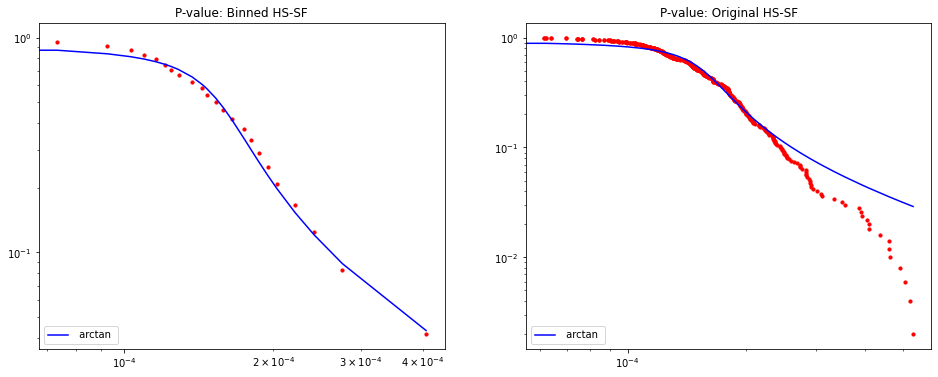

Factor for HS-SFDD: 0.1
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21]
binned_data:  [0.004757724157705794, 0.005825302144957244, 0.006374028837638255, 0.006984049028202485, 0.0077370725572232105, 0.008701585843578722, 0.009531790962581312, 0.010041023658974186, 0.010724595121253906, 0.011593259232921099, 0.012557010322597898, 0.013534101274469303, 0.015334788272560268, 0.016778775633595075, 0.01817869835756132, 0.019955007058796537, 0.022757258768356856, 0.026028741806759324, 0.03210053762785997, 0.03986249913182921, 0.05174354752666868, 0.0814087720009206, 0.20899126366279472]
curve_fit parameter on  arctan :  [ 0.15053289 14.73905552]
P-val Error at the furthest tail of Binned Y:  0.030535503825491417
P-val Error at the furthest tail of Original Y:  -0.0033588942946771727


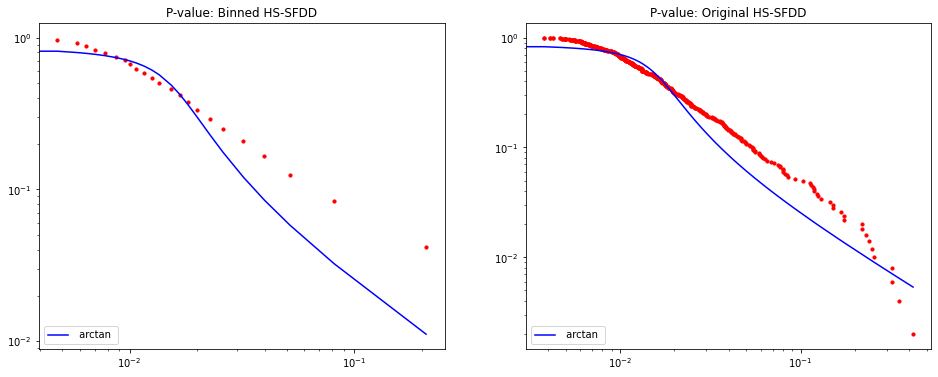

Factor for HS-Sticky: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0011535143419721268, 0.0013791530754442578, 0.001537512503662282, 0.0016500633881015574, 0.0017418136026012595, 0.0017981526493590625, 0.0018453660892602008, 0.0019103676443984812, 0.001998222197092744, 0.002072435865552912, 0.002153712553006642, 0.002202768926933064, 0.002290365820651708, 0.002367685583955785, 0.0024634515914235522, 0.0025433698092375435, 0.0026271914358362465, 0.0027546862831856708, 0.0029045180922324205, 0.003019771736998016, 0.0032244735921935067, 0.0035306384597961317, 0.0043867409855191985]
curve_fit parameter on  arctan :  [2.2375794  2.30076837]
P-val Error at the furthest tail of Binned Y:  -0.021850300693290636
P-val Error at the furthest tail of Original Y:  -0.025817180396395578


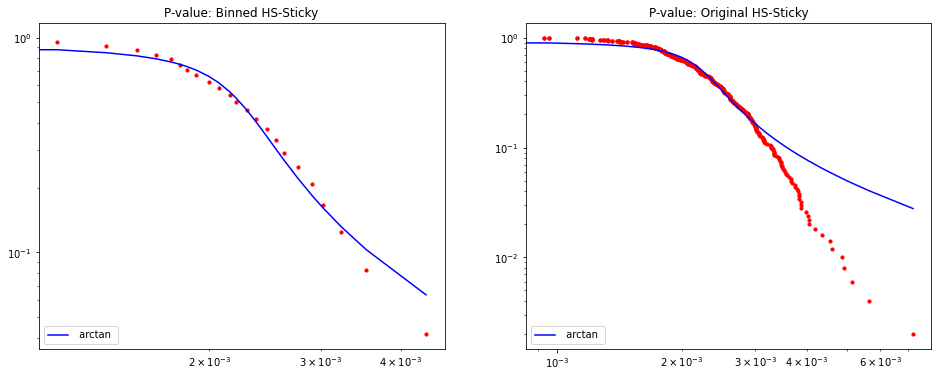

Species:  MM
Factor for MM-ER: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [2.3995262013806295e-05, 3.3649605553423936e-05, 3.8792600136814996e-05, 4.173115801658482e-05, 4.4266320870270735e-05, 4.67619998610748e-05, 4.9958469232935315e-05, 5.214757573973367e-05, 5.413143099971306e-05, 5.5474317022353245e-05, 5.773650714605079e-05, 6.0257196959651445e-05, 6.386856510284709e-05, 6.665676946823707e-05, 6.952876388165105e-05, 7.28253069075361e-05, 7.708671227545822e-05, 8.290526656045606e-05, 8.918808093549304e-05, 9.756663438463383e-05, 0.00010757999942889549, 0.0001231098877262716, 0.0004269575195619951]
curve_fit parameter on  arctan :  [0.62220886 6.35118285]
P-val Error at the furthest tail of Binned Y:  0.027934262660127884
P-val Error at the furthest tail of Original Y:  0.0007150637985271491


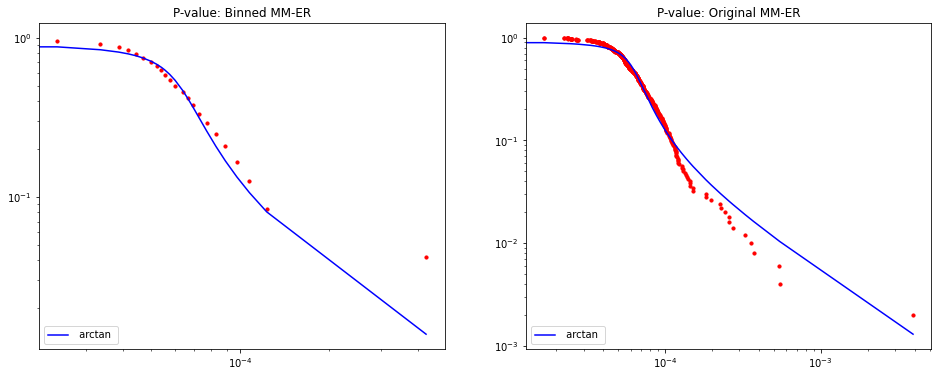

Factor for MM-ERDD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.006009926811194336, 0.007125545126290157, 0.007705675886607421, 0.008228198436162919, 0.008843120714914898, 0.009240015095942723, 0.009548415835632366, 0.009936829811616714, 0.010282172168897747, 0.010621618093237521, 0.011132143541901104, 0.01152167423107236, 0.011895983624298605, 0.012313643296899207, 0.013016791651738689, 0.013664329416207283, 0.014370782784240038, 0.015114245071911588, 0.016009373799497177, 0.017040371539787803, 0.0190497311451707, 0.02262094890549753, 0.04103556006895809]
curve_fit parameter on  arctan :  [1.17327677 3.80887706]
P-val Error at the furthest tail of Binned Y:  0.013222968139008362
P-val Error at the furthest tail of Original Y:  -0.0060085404628735795


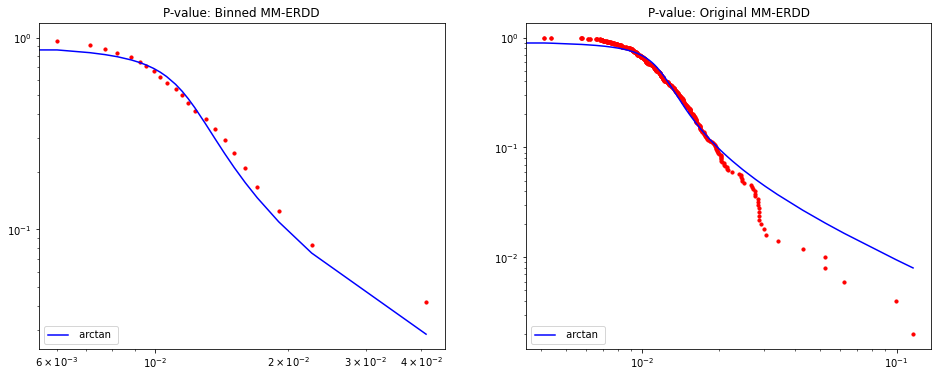

Factor for MM-GEO: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [2.793947760030587e-05, 3.968585253345266e-05, 4.8207643405596496e-05, 5.541051095270138e-05, 5.9913283155266094e-05, 6.520172304081612e-05, 7.054280090891176e-05, 7.396895470102672e-05, 7.727680085894606e-05, 8.269568067237256e-05, 8.764460041933067e-05, 9.145828415274146e-05, 9.727621226237544e-05, 0.0001044479199694794, 0.00011281749507766796, 0.00012095948890171302, 0.00012812301775222835, 0.00014079682323134792, 0.00015290068313798588, 0.00017100025711101413, 0.00019050616284019728, 0.00023649979084389882, 0.000505274577560194]
curve_fit parameter on  arctan :  [0.96203423 3.07486587]
P-val Error at the furthest tail of Binned Y:  0.016413688250224046
P-val Error at the furthest tail of Original Y:  -0.001997521657255197


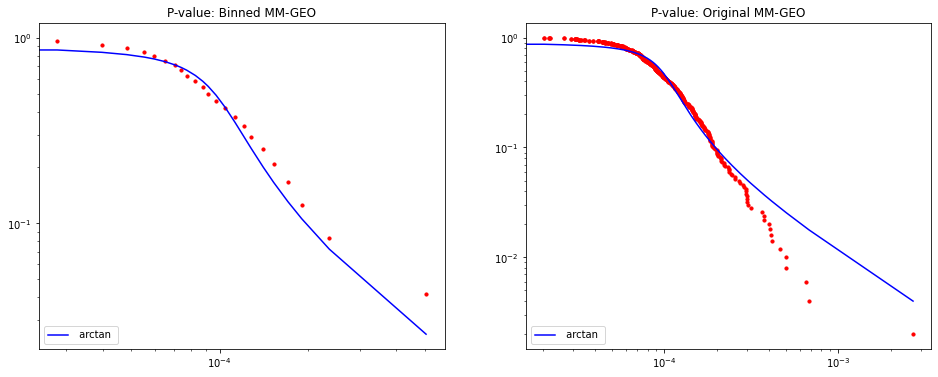

Factor for MM-GEOGD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [6.793765159704787e-05, 9.70083358892156e-05, 0.00012073626731738743, 0.0001366483515344871, 0.00015028353866779117, 0.00016522461923324725, 0.000176577130022095, 0.00019500618742435193, 0.0002200559522666811, 0.0002520363132862563, 0.0002716092448810818, 0.0003053833078747182, 0.0003539320077600746, 0.0004020622311326587, 0.0004449037836334171, 0.0005288441407836827, 0.0006111675510526533, 0.0007788248385721686, 0.001015085756624264, 0.0013988476238770851, 0.002121967963255335, 0.00418767301000611, 0.01350891475862872]
curve_fit parameter on  arctan :  [3.56421688e-02 4.93292000e+01]
P-val Error at the furthest tail of Binned Y:  0.036760937290905904
P-val Error at the furthest tail of Original Y:  0.0008725772414504007


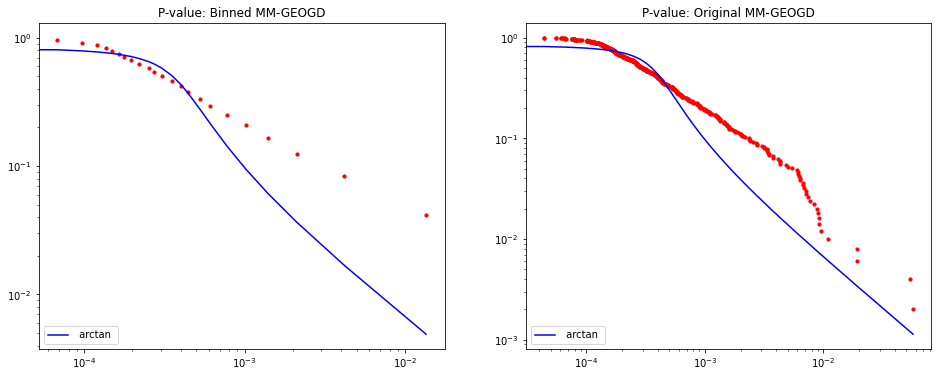

Factor for MM-HGG: 0.01
items in each bin:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15]
binned_data:  [0.010681354066095017, 0.02093218804487993, 0.02675352599529928, 0.030212532505162183, 0.03254609755318894, 0.038095776734037363, 0.04156223419533049, 0.04440166775198953, 0.048373475842520317, 0.056907904777568366, 0.07014327270038515, 0.09045865612073237, 0.11288262007288405, 0.1417297942913693, 0.17849086417730725, 0.5239247603211141]
curve_fit parameter on  arctan :  [5.26457719 0.39667698]
P-val Error at the furthest tail of Binned Y:  0.04181286242093263
P-val Error at the furthest tail of Original Y:  -0.0008465706681917151


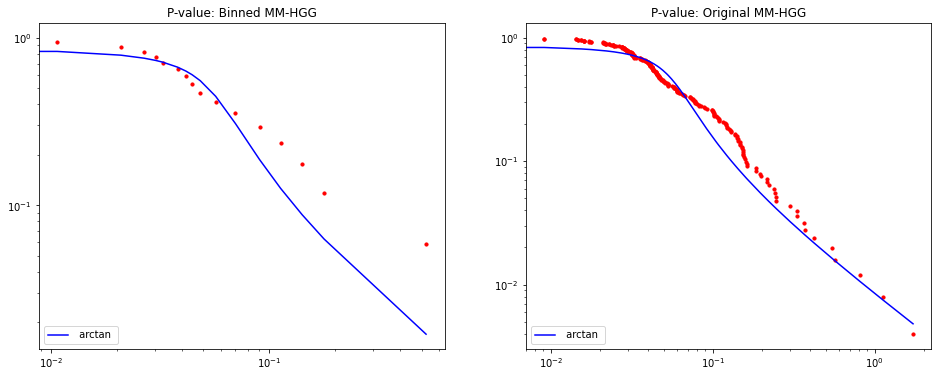

Factor for MM-SF: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [6.016000926019412e-05, 7.508598769794239e-05, 8.460876936318076e-05, 8.843353954169568e-05, 9.554797703840594e-05, 9.900330040354647e-05, 0.00010169044223314588, 0.00010453209835069636, 0.00010934971622696016, 0.00011381319148749272, 0.00011855067076631526, 0.00012113322109838657, 0.0001250239897497071, 0.00013054952047090432, 0.00013460499428948137, 0.00014046001332581375, 0.0001470399746886005, 0.0001561779431630715, 0.00016843932687190416, 0.00018177152739715888, 0.00020269645059616643, 0.00023566457213867594, 0.00035162470653888673]
curve_fit parameter on  arctan :  [1.23405479 3.87490451]
P-val Error at the furthest tail of Binned Y:  0.005824360979901355
P-val Error at the furthest tail of Original Y:  -0.014818353611647517


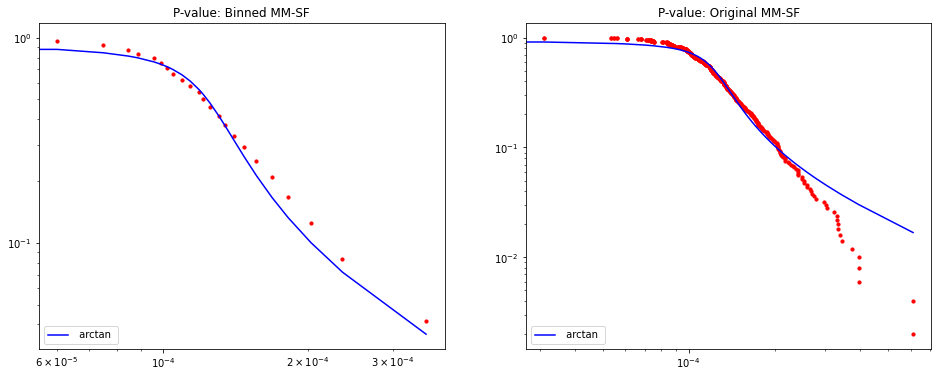

Factor for MM-SFDD: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.004240525955521238, 0.005498896575056034, 0.006229421687320439, 0.0066033425710531925, 0.006988270006463012, 0.007406181290186533, 0.00791817088782844, 0.008322469233065358, 0.0087583252681594, 0.009238489064436008, 0.009932103888099146, 0.010683632689533493, 0.011592970502826662, 0.012299827573492711, 0.013446666829101698, 0.015451158461127119, 0.01793927929750169, 0.02058460399588962, 0.024433065344242572, 0.02775224376890953, 0.03398949442675544, 0.0458932592319974, 0.09253344940088196]
curve_fit parameter on  arctan :  [11.58645241  0.21721514]
P-val Error at the furthest tail of Binned Y:  0.023582783406807306
P-val Error at the furthest tail of Original Y:  -0.00580194872579165


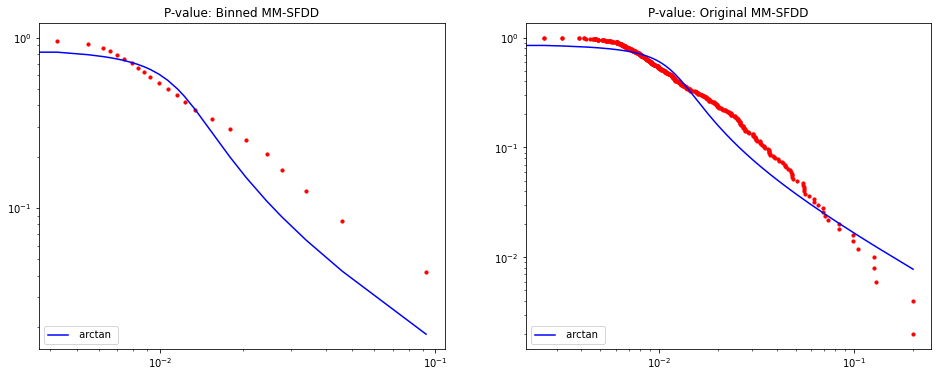

Factor for MM-Sticky: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0019579990354693217, 0.0022500245294046987, 0.0023645424940800784, 0.0024786296344530435, 0.0026200108236183557, 0.002735522201196328, 0.002838233249286607, 0.002933732185027063, 0.0030146398145515455, 0.003093082660840493, 0.003167489521509088, 0.0032289934750170555, 0.003344911999879507, 0.0034439059746335034, 0.0035366270812653435, 0.0036575054872324663, 0.0038232472748279595, 0.003982510652414203, 0.004178811355965076, 0.004396584936404828, 0.004753508347296866, 0.005057793059771008, 0.006201190250856468]
curve_fit parameter on  arctan :  [3.28855658 1.81176576]
P-val Error at the furthest tail of Binned Y:  -0.01794657866199645
P-val Error at the furthest tail of Original Y:  -0.03176470570238732


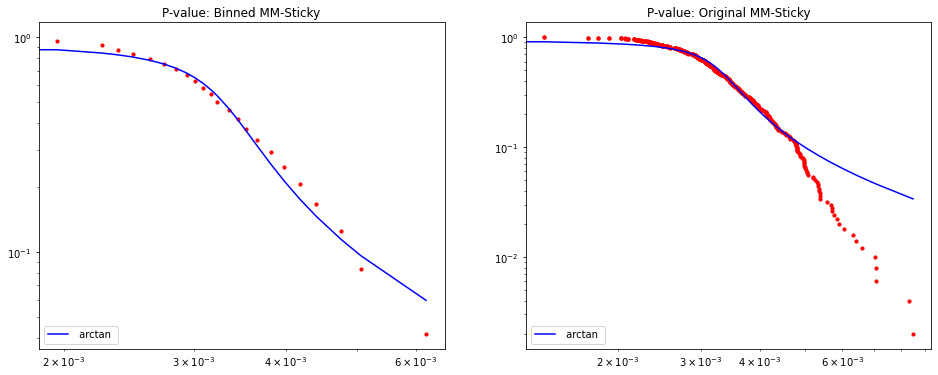

Species:  RN
Factor for RN-ER: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [5.072395836476875e-05, 6.508621069372167e-05, 7.095051187286861e-05, 7.544261823072683e-05, 7.962647874222536e-05, 8.444157486813588e-05, 8.839326242652397e-05, 9.171956798509718e-05, 9.541577691503572e-05, 9.836273462144026e-05, 0.00010239714076155748, 0.00010770745202439699, 0.00011113500813305857, 0.00011839987306524941, 0.0001255203549732965, 0.0001303165097274306, 0.00014061019316810518, 0.00014773705052290126, 0.00015592777943290053, 0.0001688822339940812, 0.00019082720569902508, 0.0002549918292851969, 0.0017916082444003525]
curve_fit parameter on  arctan :  [ 0.11073612 35.72256092]
P-val Error at the furthest tail of Binned Y:  0.03636597284012477
P-val Error at the furthest tail of Original Y:  9.498675767993792e-05


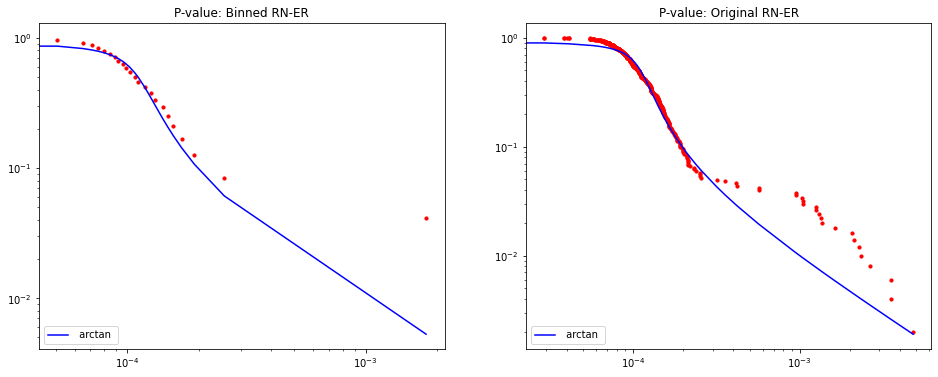

Factor for RN-ERDD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.00687114549391245, 0.008685151676729447, 0.00942843295184785, 0.010208222490297585, 0.010747597477495876, 0.011402193440731899, 0.012039403116696767, 0.012689692429199095, 0.01341749376862228, 0.014022296704256561, 0.014543818209950175, 0.014907693313389737, 0.015320758524831257, 0.015878882400419354, 0.01689082786881767, 0.0179305721028634, 0.019152681832126806, 0.02033191506265086, 0.02146168833362589, 0.023705137103816096, 0.026727172857490922, 0.035448254986864644, 0.06547189129166894]
curve_fit parameter on  arctan :  [1.5233107  2.66652041]
P-val Error at the furthest tail of Binned Y:  0.01794957856535928
P-val Error at the furthest tail of Original Y:  -0.002311342660546334


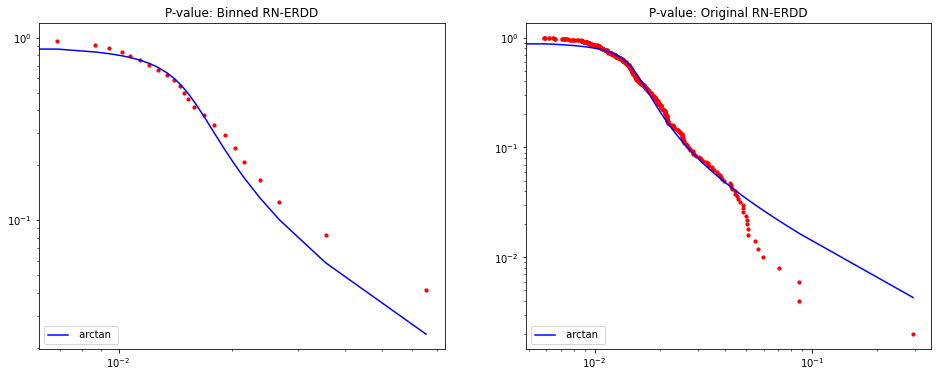

Factor for RN-GEO: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [7.354149118071235e-05, 9.584743264015419e-05, 0.00010795162035050287, 0.00012261788487269519, 0.00013501350799683518, 0.00014406273603712361, 0.00015234472773944006, 0.00016378084850156394, 0.00017692764111720556, 0.00019142983791603814, 0.0002034012276917894, 0.00021042967066134575, 0.000220243200224479, 0.00023519834951357804, 0.00025247813328537676, 0.0002686664181671741, 0.0002941373958491135, 0.00032570496599599783, 0.0003718341187718759, 0.00041119169737071796, 0.000462061106131033, 0.0005335795876874011, 0.0010495788580980043]
curve_fit parameter on  arctan :  [2.18470785 1.34861737]
P-val Error at the furthest tail of Binned Y:  0.013342605757682313
P-val Error at the furthest tail of Original Y:  -0.005566345533658534


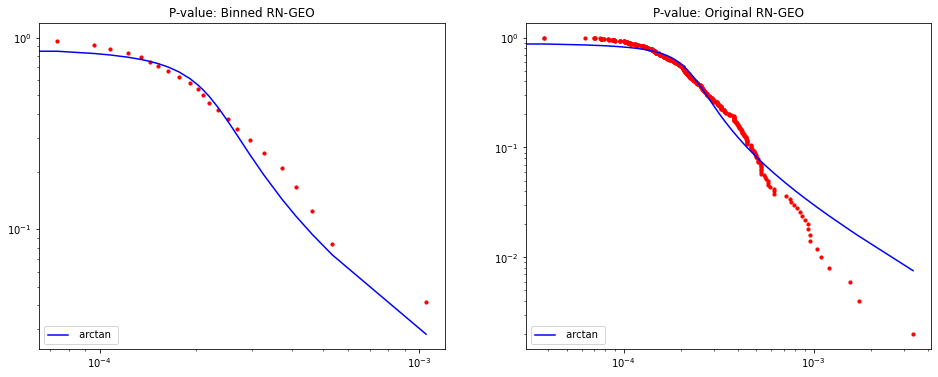

Factor for RN-GEOGD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0009335729126923328, 0.001149438234081776, 0.0013720954156900252, 0.0015593826448952845, 0.0017051245545403675, 0.0018302383704590828, 0.0019941590844942975, 0.0021677549255815216, 0.0023307508462690678, 0.002537056742101821, 0.0028007560541460047, 0.003115693316642246, 0.0034561384811269092, 0.003925507600214194, 0.004500055663754308, 0.004936270719590296, 0.0055753004334703595, 0.006411443764456971, 0.007443769240318381, 0.009126145344722817, 0.010977539274880063, 0.016941644912749194, 0.04605488341949459]
curve_fit parameter on  arctan :  [0.35275062 5.57010804]
P-val Error at the furthest tail of Binned Y:  0.028237158126054873
P-val Error at the furthest tail of Original Y:  -0.0025596854842877548


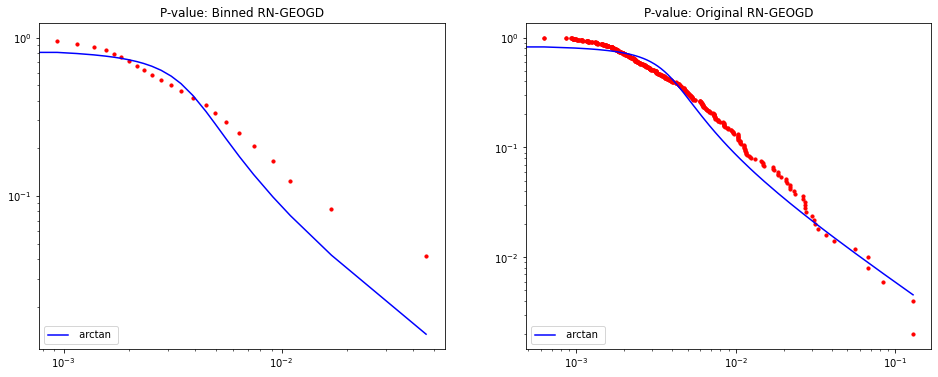

Factor for RN-HGG: 0.1
items in each bin:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15]
binned_data:  [0.0064738847141977834, 0.008883854812241392, 0.010540823271440252, 0.013217972875596546, 0.01525879270344626, 0.018799363884038044, 0.020933952960828898, 0.024661626232226123, 0.029115231254310366, 0.03474850533920105, 0.040762211825233916, 0.048591999194126094, 0.06412563205013826, 0.10091538288271447, 0.15896396668901372, 0.5058261609245536]
curve_fit parameter on  arctan :  [0.30157333 6.03061899]
P-val Error at the furthest tail of Binned Y:  0.047731584316022535
P-val Error at the furthest tail of Original Y:  -0.0006597991261122482


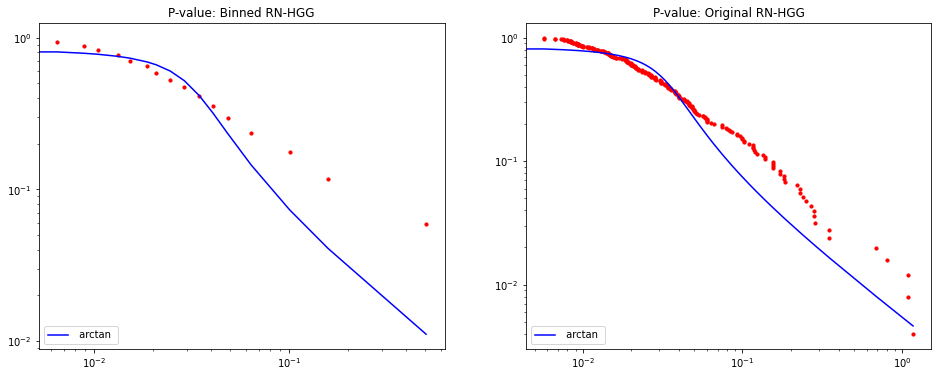

Factor for RN-SF: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0008303305248354761, 0.0010186832318247396, 0.0011208733422434294, 0.001196463698330603, 0.001254135011831377, 0.001300517710560918, 0.0013582518499681716, 0.0014212022717212656, 0.0014696324715393263, 0.0015345723212616604, 0.0015789074249720246, 0.0016312654066762424, 0.0016918162300814368, 0.0017361892598818636, 0.0017963862949213981, 0.0019003935530118074, 0.0020237663813159243, 0.002138819024121225, 0.0022961364920740636, 0.002497598395844406, 0.002737363252935456, 0.003159974483738898, 0.004325662697543716]
curve_fit parameter on  arctan :  [1.65875593 2.81102291]
P-val Error at the furthest tail of Binned Y:  -0.0005439520615162508
P-val Error at the furthest tail of Original Y:  -0.0163937990420715


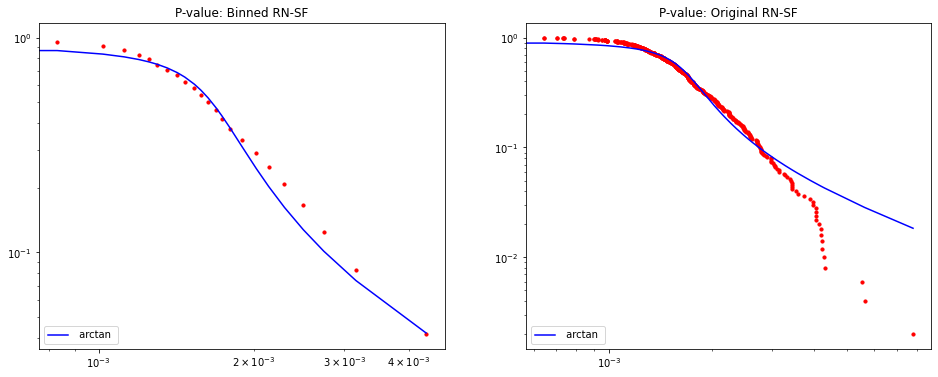

Factor for RN-SFDD: 0.1
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21]
binned_data:  [0.010878373899600564, 0.015111843792131742, 0.01626497004910086, 0.01807546371072309, 0.019709525071693986, 0.02089040260045918, 0.022039979370031108, 0.023387254688761613, 0.024806604676387654, 0.0265236055002224, 0.02816883589224141, 0.030495156486173645, 0.03244514269898566, 0.03496048712001108, 0.03821471803542029, 0.0427200064566839, 0.05075111900007752, 0.05663799974208525, 0.06707466350697822, 0.0812624522807179, 0.10334603075675637, 0.1351266039330671, 0.27510188448881073]
curve_fit parameter on  arctan :  [0.32659592 7.67961886]
P-val Error at the furthest tail of Binned Y:  0.024586779600672126
P-val Error at the furthest tail of Original Y:  -0.0031556490409887505


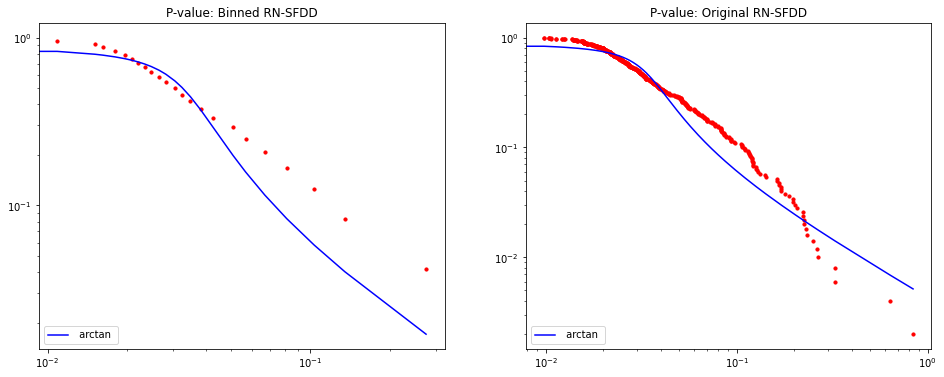

Factor for RN-Sticky: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.009304022049317935, 0.010840805320404665, 0.011775780203218074, 0.01243311292065906, 0.013014547625225968, 0.013405982321660487, 0.01377711751305037, 0.014246034482774301, 0.01466519002164595, 0.015080118807598691, 0.015695493489490578, 0.016280686077228775, 0.016892059851829736, 0.017407455285033062, 0.017982854814238707, 0.018577724977877696, 0.0190543154074187, 0.019597374091115578, 0.020374476473826324, 0.021293671134921158, 0.02305284952652159, 0.026107713338665767, 0.037225710332951634]
curve_fit parameter on  arctan :  [1.64101808 3.3783587 ]
P-val Error at the furthest tail of Binned Y:  -0.003296291822697639
P-val Error at the furthest tail of Original Y:  -0.014450221214324266


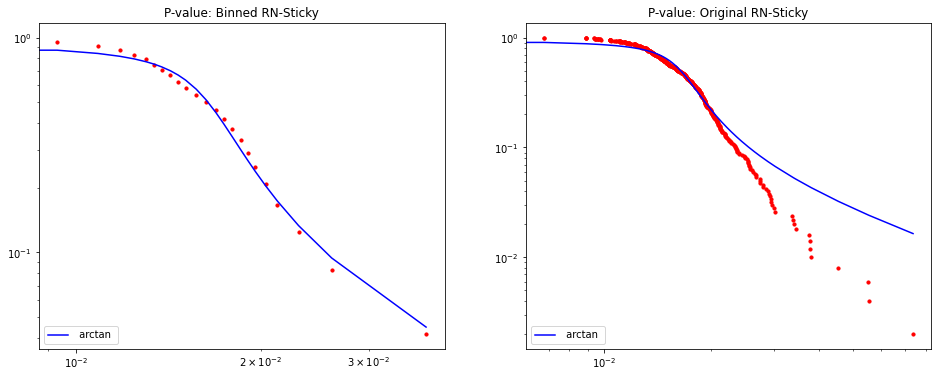

Species:  SC
Factor for SC-ER: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [1.01105827163435e-05, 1.622445293750702e-05, 2.0081647730843943e-05, 2.1925278936445103e-05, 2.3976575422613596e-05, 2.750403034810523e-05, 2.9606817659745315e-05, 3.096478016969797e-05, 3.349194570674982e-05, 3.613764214703969e-05, 3.861507432486566e-05, 4.065883690077839e-05, 4.2515142879318086e-05, 4.5644426668531166e-05, 4.7745282798010125e-05, 5.059514768720446e-05, 5.355223040028933e-05, 5.664983450335034e-05, 6.299531490838374e-05, 6.894760405064547e-05, 7.730295490415565e-05, 9.247596334440492e-05, 0.00021913088886361953]
curve_fit parameter on  arctan :  [0.41319442 7.36947949]
P-val Error at the furthest tail of Binned Y:  0.01742219998647243
P-val Error at the furthest tail of Original Y:  -0.0010115433416788555


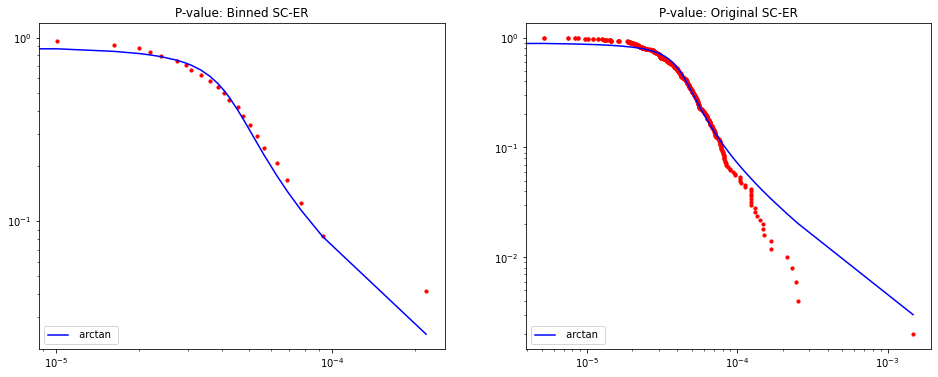

Factor for SC-ERDD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0012809493093696952, 0.0015802734936993738, 0.0018086475969698182, 0.0019941813639159267, 0.0021159651678559635, 0.002227804089365185, 0.0023427973091457786, 0.0024903189647543437, 0.002597115426751638, 0.0027322710577928487, 0.0028217051325484317, 0.002967271847713357, 0.0031465796776393782, 0.003270909353511386, 0.0034380816757088816, 0.0036905862951158814, 0.003931440768322358, 0.004199897658437311, 0.0044372291770441285, 0.004886972149775217, 0.005502410998488921, 0.006669984222403764, 0.015279609324623009]
curve_fit parameter on  arctan :  [ 0.3063435  11.82990314]
P-val Error at the furthest tail of Binned Y:  0.019675817688010855
P-val Error at the furthest tail of Original Y:  -0.0008539975379577847


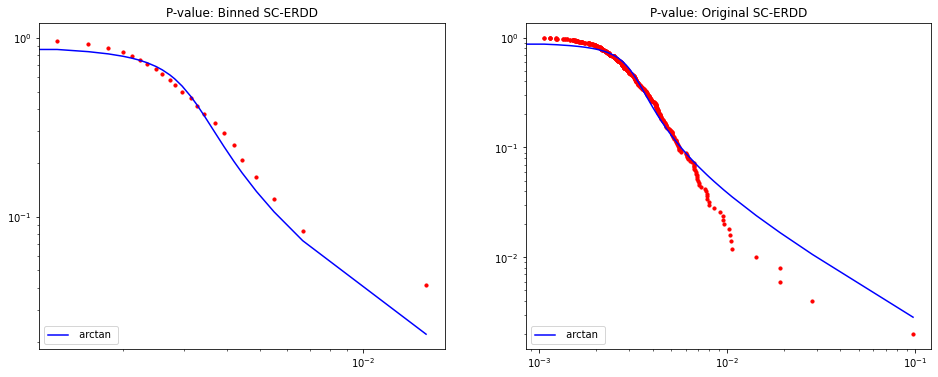

Factor for SC-GEO: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [9.972346310624216e-05, 0.00011787268803827266, 0.00013552853698730358, 0.00015210733868301063, 0.0001655617726720872, 0.00017522640388843396, 0.0001860892645851567, 0.00019411654467846976, 0.00020323564054224795, 0.00021289359456650117, 0.00022064927238988916, 0.0002308846747580544, 0.000243003055158953, 0.0002542818705052335, 0.0002686661938528576, 0.000286634661578065, 0.0003014674257877756, 0.000321413651827779, 0.0003437536051145015, 0.0003818206186636137, 0.0004313936032323869, 0.0005236811253999011, 0.0008646726895687387]
curve_fit parameter on  arctan :  [2.38115961 1.53913589]
P-val Error at the furthest tail of Binned Y:  0.008776707856459676
P-val Error at the furthest tail of Original Y:  -0.013310054943315386


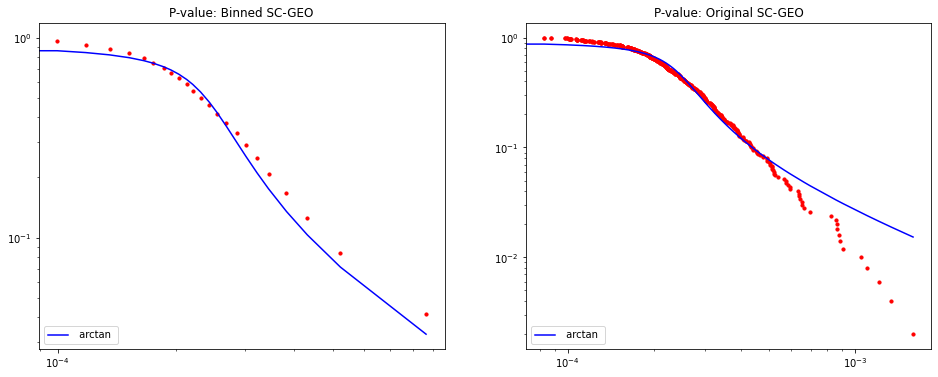

Factor for SC-GEOGD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0002300070590986459, 0.00031018028822156295, 0.00036148065335789276, 0.000395602001500262, 0.0004592739626785017, 0.0005152949829136427, 0.0005790856593695629, 0.0006549829712386182, 0.000761550029115906, 0.0008558774930248096, 0.000980464021726338, 0.001136950772551352, 0.0013356191710571336, 0.0016082574698817304, 0.0019763479374505888, 0.002759868689142869, 0.0037374233334400205, 0.005458083078549788, 0.008276774605564745, 0.012058257578878021, 0.018555977570294244, 0.041851157086155104, 0.13244787979142664]
curve_fit parameter on  arctan :  [0.14642646 9.68358635]
P-val Error at the furthest tail of Binned Y:  0.03915716246801493
P-val Error at the furthest tail of Original Y:  0.0010651501245670936


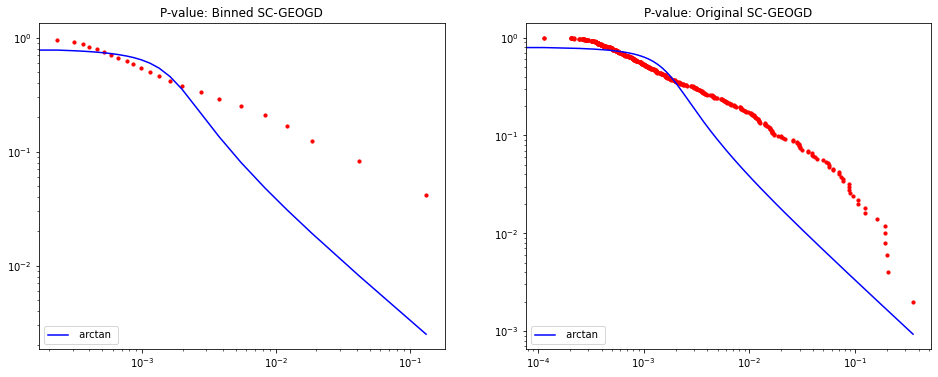

Factor for SC-HGG: 0.1
items in each bin:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15]
binned_data:  [0.03654350551958461, 0.048868097812370746, 0.05976326847923874, 0.0685795825148047, 0.07624279254675734, 0.08431856856174001, 0.09307847460936053, 0.10088246582185109, 0.10621775620294617, 0.11210347823118204, 0.11804773595194187, 0.12794259433875718, 0.1404000789558938, 0.1576352844175796, 0.18912187197759878, 0.302100566161933]
curve_fit parameter on  arctan :  [1.03346977 3.38528345]
P-val Error at the furthest tail of Binned Y:  0.011858719358403325
P-val Error at the furthest tail of Original Y:  -0.00919009248639191


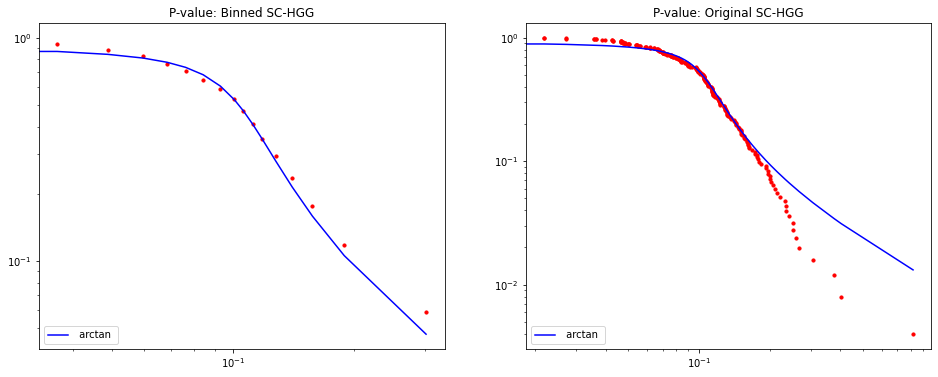

Factor for SC-SF: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.00011820717756249661, 0.00014504681405493326, 0.0001598525455245324, 0.00017502235306405143, 0.0001858076057397473, 0.0001968352395281466, 0.0002053882174545309, 0.00021119282675674314, 0.00021967039018640363, 0.0002281034230309784, 0.0002367822638953695, 0.00024460928968992533, 0.0002535736759316255, 0.0002631653095644291, 0.00027328892181647504, 0.00028963410346765614, 0.000306599499941914, 0.000323473909206197, 0.00033791974382518336, 0.0003580847886616345, 0.0004089693661924432, 0.0004968110291906756, 0.0007157398931494676]
curve_fit parameter on  arctan :  [2.49432779 1.79361213]
P-val Error at the furthest tail of Binned Y:  0.0037881661242765707
P-val Error at the furthest tail of Original Y:  -0.018779484423643522


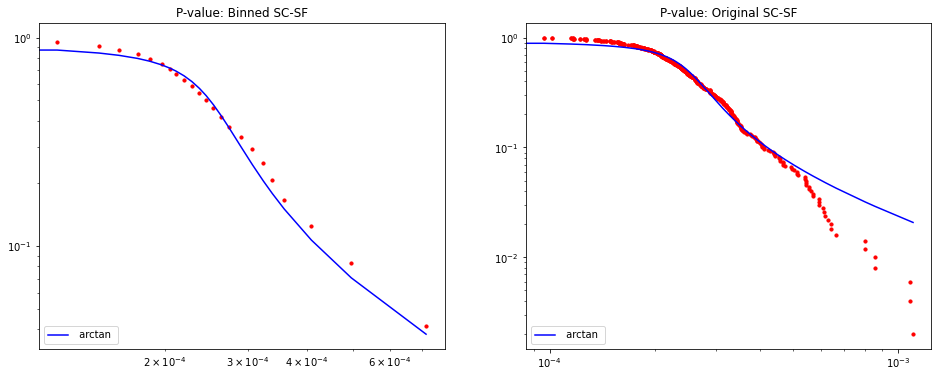

Factor for SC-SFDD: 0.1
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21]
binned_data:  [0.00562861319677586, 0.007598632928891179, 0.008431407014588312, 0.008946819392571328, 0.009502707621942653, 0.010221643674653103, 0.010939322907937447, 0.011405516214295796, 0.012252449563953861, 0.013007397869709409, 0.014137089931637242, 0.015529991704198758, 0.01710180786904193, 0.018981835200497302, 0.021059182130450264, 0.022892894951922014, 0.026049532307946346, 0.029407109125154637, 0.03510061873876117, 0.03905285569559364, 0.046317940272215065, 0.06298560024581308, 0.2119579766606132]
curve_fit parameter on  arctan :  [ 0.17220263 13.20785311]
P-val Error at the furthest tail of Binned Y:  0.029297252032533527
P-val Error at the furthest tail of Original Y:  1.643913854598722e-05


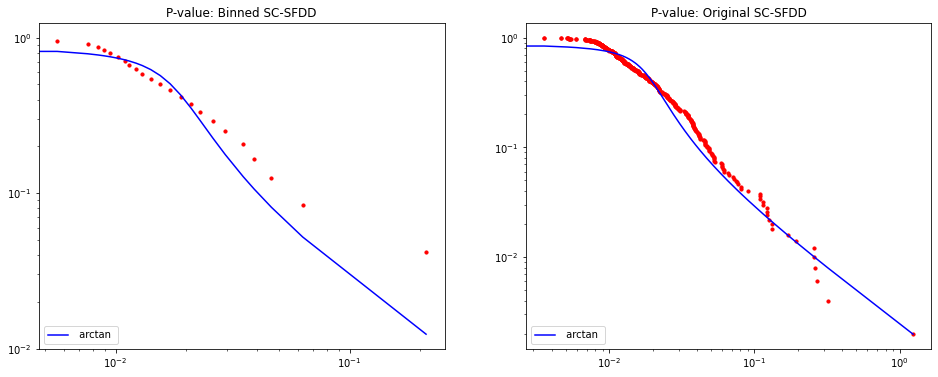

Factor for SC-Sticky: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0016914602838434588, 0.001992823566434932, 0.002109897169207739, 0.0021846045325137277, 0.002240004353651337, 0.002301183620999701, 0.0023586783858897645, 0.002413133818705047, 0.0024642687679286668, 0.0025110292180937632, 0.0025689027192645443, 0.002625217705627447, 0.0026957939119646637, 0.0027970256515104344, 0.002890192321110112, 0.0029800143146386567, 0.0031219675631487154, 0.0032462723904399158, 0.0033679556606407766, 0.003580146020149619, 0.0038270972910241998, 0.004227504830776269, 0.005384335473785566]
curve_fit parameter on  arctan :  [2.68534073 2.41685659]
P-val Error at the furthest tail of Binned Y:  -0.006753823869100395
P-val Error at the furthest tail of Original Y:  -0.02505331272928002


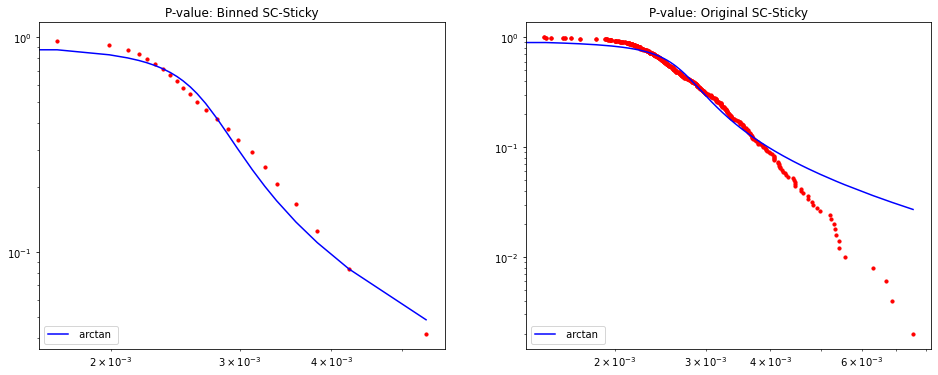

Species:  SP
Factor for SP-ER: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.00012826607313594785, 0.0001559413735008798, 0.00017494551924152106, 0.00019825915969119524, 0.00021149697818516474, 0.00022831151673807155, 0.00024306137643647033, 0.00025269201690017044, 0.00026545418226034135, 0.00027719034696814125, 0.00028565716056614434, 0.00029435937648256854, 0.0003064094223742501, 0.00031909476015344677, 0.0003320282853787497, 0.00034332898036081104, 0.00035978424691663144, 0.0003796060211304385, 0.00039583059968764515, 0.0004152310337678764, 0.00044567901854914577, 0.0004950237848559462, 0.0010735759568132326]
curve_fit parameter on  arctan :  [2.98797732 1.49205644]
P-val Error at the furthest tail of Binned Y:  0.014199890237061252
P-val Error at the furthest tail of Original Y:  -0.00489669618985078


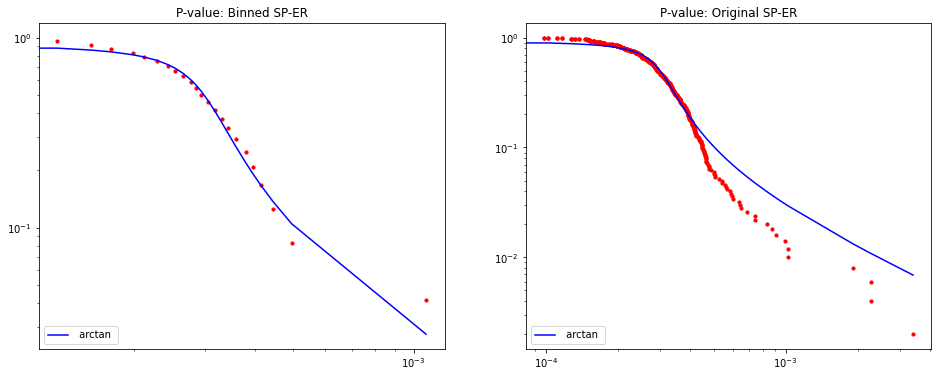

Factor for SP-ERDD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.010374992072989987, 0.012677719493536617, 0.013953447121058423, 0.014656043048673727, 0.015429327771777161, 0.01622856910007385, 0.017136718558219848, 0.017818579909569268, 0.01839538038498046, 0.019207742684883664, 0.02002248064155286, 0.020663151565146694, 0.021377357481640866, 0.02269077681338806, 0.023765552723485704, 0.024703306724336647, 0.025298320102237204, 0.026203342285311643, 0.028040850952073607, 0.03058458455602701, 0.034185278078459856, 0.04277539851190448, 0.08140305514363304]
curve_fit parameter on  arctan :  [2.11158841 2.09467855]
P-val Error at the furthest tail of Binned Y:  0.016512929500354212
P-val Error at the furthest tail of Original Y:  -0.005843585288681563


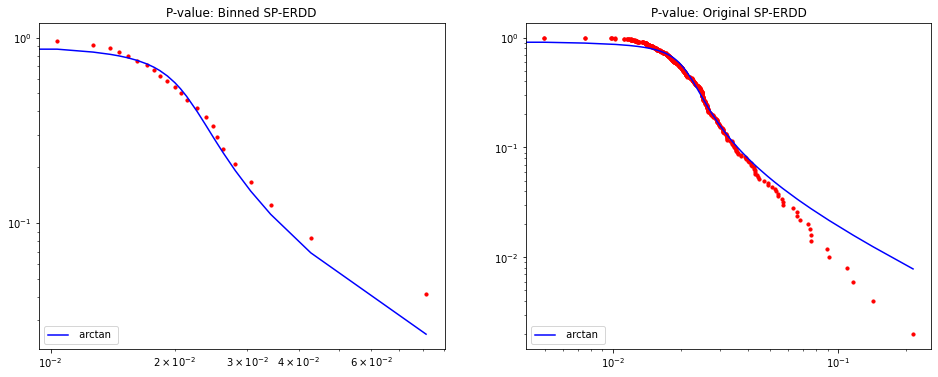

Factor for SP-GEO: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0004436712189710003, 0.0005226521558334006, 0.0005934770585294096, 0.0006286925719163562, 0.0006740384938394018, 0.0007076611126114787, 0.0007454540304824189, 0.0007902376104983154, 0.0008157685490824577, 0.00084582943057965, 0.0008784420804092245, 0.0009174868819055617, 0.00095407687384297, 0.0009921589846157144, 0.0010330513012006778, 0.001068868723287583, 0.001122803874309185, 0.0012000202794867152, 0.0012731858095182463, 0.001363262821831183, 0.0015442379956504052, 0.0017996811094900343, 0.003274868953048358]
curve_fit parameter on  arctan :  [0.93044317 4.64514021]
P-val Error at the furthest tail of Binned Y:  0.012519348924104556
P-val Error at the furthest tail of Original Y:  -0.00337772980631712


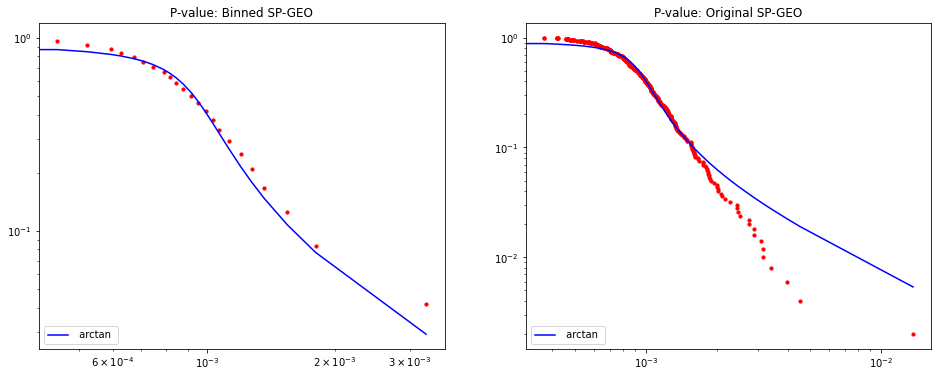

Factor for SP-GEOGD: 0.1
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0009440675958882213, 0.0012772716016736013, 0.0013693750412483029, 0.0015068798006926864, 0.0016320224261363156, 0.0017237301189117198, 0.0018261025685658962, 0.0019896153757768074, 0.0021274872574521186, 0.0023326203927375544, 0.002657942291493775, 0.0029895444070720117, 0.003602456353017418, 0.004116013434387527, 0.004782461550255042, 0.005986924611998698, 0.0072674289996971985, 0.008899036703951804, 0.012270132066997442, 0.016653858140598575, 0.02459948111917727, 0.038167661963542134, 0.12620165656324678]
curve_fit parameter on  arctan :  [3.78366875e-02 4.33645219e+01]
P-val Error at the furthest tail of Binned Y:  0.03567125558699058
P-val Error at the furthest tail of Original Y:  0.0011037980421275684


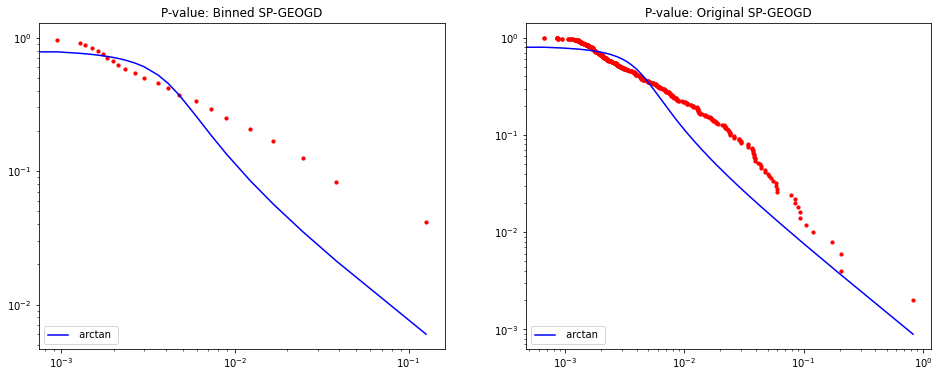

Factor for SP-HGG: 0.1
items in each bin:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15]
binned_data:  [0.018154555374581306, 0.02439155565285284, 0.028482215918319093, 0.03380950210888638, 0.03822384165084483, 0.04382981646272062, 0.048012730053260934, 0.05445536305991889, 0.06026289804298962, 0.07122305567837117, 0.08399080210609614, 0.10206842082479554, 0.1345504608115941, 0.1877591090327716, 0.25494891198286995, 0.5690718215702686]
curve_fit parameter on  arctan :  [0.6381119  3.22903585]
P-val Error at the furthest tail of Binned Y:  0.03933770321402519
P-val Error at the furthest tail of Original Y:  -0.00415047271005109


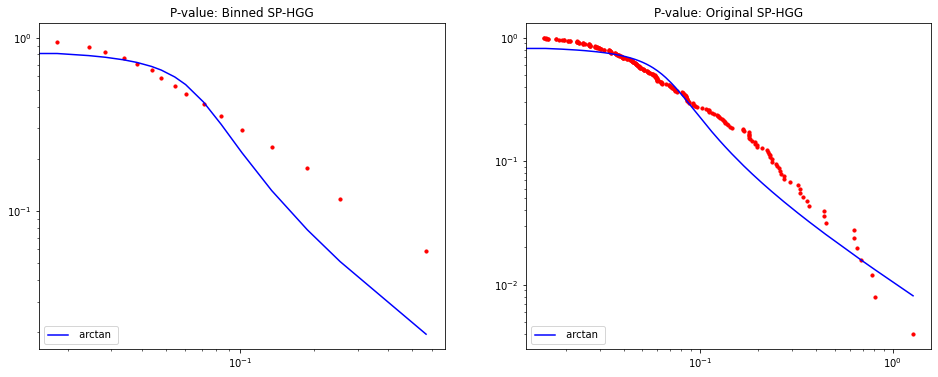

Factor for SP-SF: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0006971033789846972, 0.0009319752919256355, 0.0010020422633290709, 0.0011136915568382324, 0.0011734387245345877, 0.001228921214490543, 0.0012702094382152642, 0.0013265850667281821, 0.0013839205013961046, 0.0014417997545620902, 0.001500767873783706, 0.0015466235093441652, 0.0016167452738739458, 0.0016990913280150574, 0.001753077478715188, 0.0018306778199028368, 0.0018833450875879823, 0.0019682798146817555, 0.002103299774249067, 0.0022238587803601376, 0.0024624382029609796, 0.0028049645133744216, 0.003958546701783647]
curve_fit parameter on  arctan :  [1.57832846 2.85558238]
P-val Error at the furthest tail of Binned Y:  -0.004831313485899158
P-val Error at the furthest tail of Original Y:  -0.021058717979515196


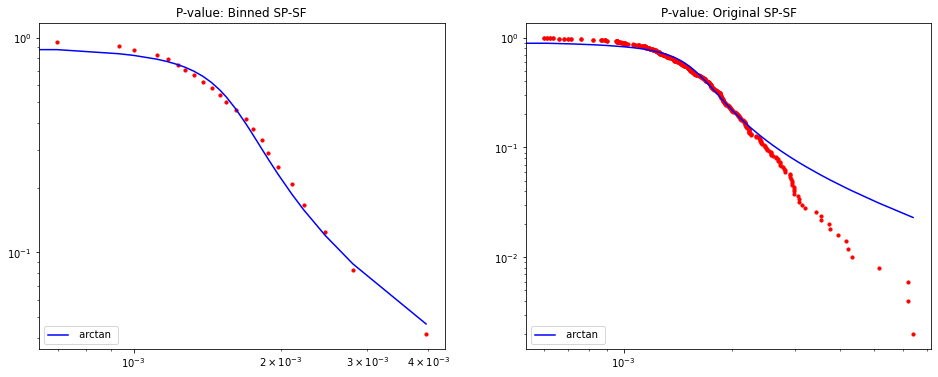

Factor for SP-SFDD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21]
binned_data:  [0.008226492653039182, 0.01127237928994606, 0.01249179104545382, 0.013159769355413187, 0.01399930195545232, 0.014743932210116061, 0.015666434834256768, 0.016313606832292524, 0.016908911623035695, 0.0177271891060171, 0.018560106243883105, 0.019587194454691485, 0.02074447834265293, 0.021624357274368147, 0.022644375666151247, 0.024407288183224417, 0.025658146829989268, 0.02771820228588814, 0.031242228250385525, 0.03539497846068752, 0.0413236594270459, 0.05202394204634896, 0.11458997170347976]
curve_fit parameter on  arctan :  [2.0227669 1.7629814]
P-val Error at the furthest tail of Binned Y:  0.022555746409861466
P-val Error at the furthest tail of Original Y:  -0.0037118027757316874


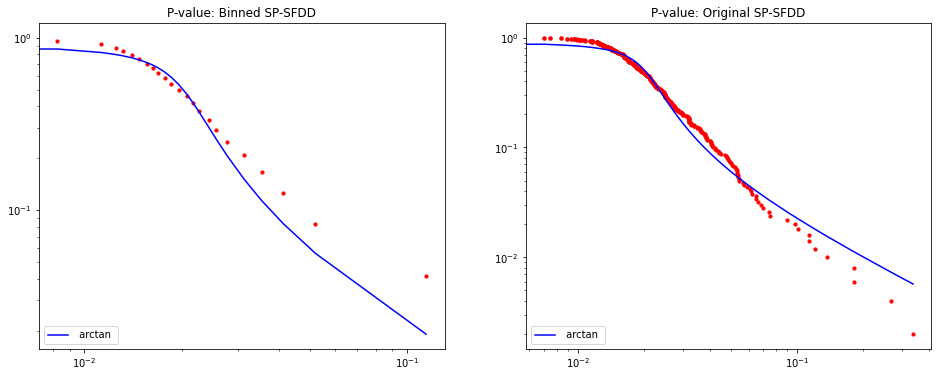

Factor for SP-Sticky: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.011382613023456438, 0.013683617759167684, 0.014928014738312935, 0.01571493828768257, 0.01644770303744444, 0.017174228254117366, 0.01786191638706095, 0.018450711495288676, 0.018941287380084177, 0.019507970115307374, 0.0200467431398837, 0.020782342037872773, 0.021345433015671912, 0.022030701844015285, 0.02262778558860707, 0.02329165078528537, 0.024113414797853585, 0.02545253888770361, 0.02625203766880995, 0.027023651634195338, 0.028453043304336807, 0.03189691462382735, 0.04019852379618449]
curve_fit parameter on  arctan :  [2.08850541 2.77866359]
P-val Error at the furthest tail of Binned Y:  -0.01697433225710443
P-val Error at the furthest tail of Original Y:  -0.0316543959209713


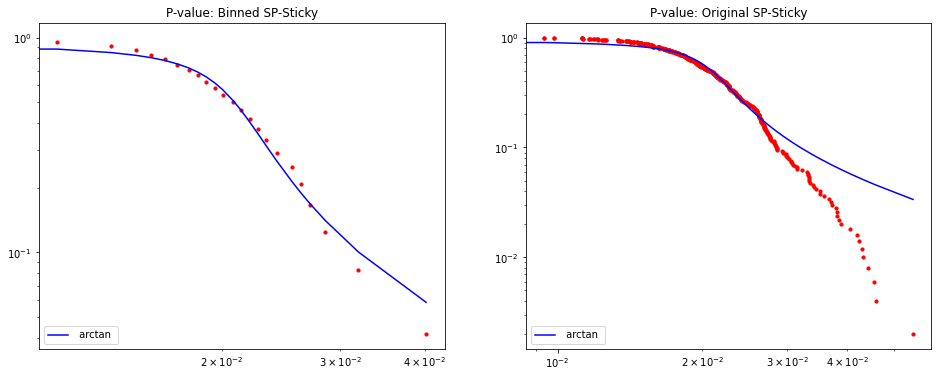

In [25]:
#np.mean
for S in Species:
    print("Species: ",S)
    df_S = data_frame(S)
    for i in range(len(Classes[:-1])):
        data_i = data_distance(data(df_S,Classes[:-1][i]))
        factor_i = get_factor(data_i)
        print("Factor for {}-{}: {}".format(S,Classes[:-1][i],factor_i))
        sigmoid_to_ori(data_i, S, Classes[:-1][i], factor_i, arctan,p_control=None,gmean=False)

Species:  AT
Factor for AT-ER: 1e-05
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [1.076587464057889e-05, 1.5411433160179646e-05, 2.0152761816842787e-05, 2.457540770690451e-05, 2.914880572467283e-05, 3.3441247013932584e-05, 3.872832203951388e-05, 4.048533043844193e-05, 4.264455780800603e-05, 4.467158310877065e-05, 4.6114695657275816e-05, 4.7830611697803996e-05, 5.0327792934393426e-05, 5.351469226248511e-05, 5.687023495886087e-05, 6.128615029554029e-05, 6.672239958174316e-05, 7.294462972846757e-05, 7.798313825042749e-05, 8.407655075127191e-05, 9.87804510610411e-05, 0.00012837495119445984, 0.0003485042830401135]
curve_fit parameter on  arctan :  [4.99219033 0.60993286]
P-val Error at the furthest tail of Binned Y:  0.02420571115750636
P-val Error at the furthest tail of Original Y:  -0.0009468665999867731


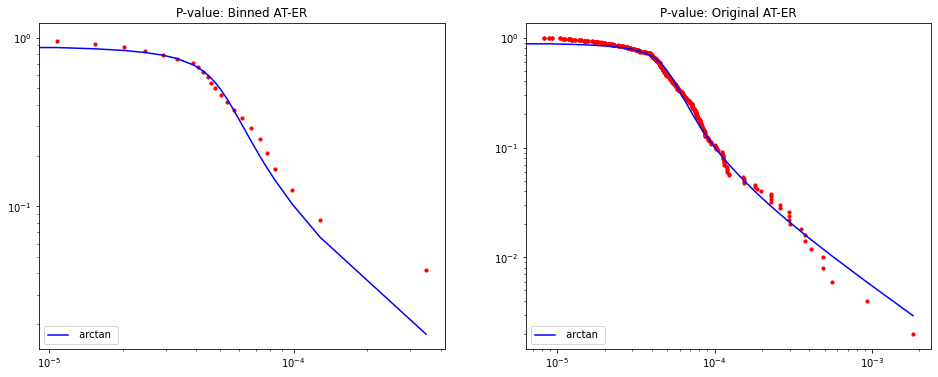

Factor for AT-ERDD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.003093033317151415, 0.0042765048768397115, 0.004767867377361355, 0.005152728841845286, 0.005798051616946196, 0.006326477486374524, 0.006796343498759861, 0.0073713105025870335, 0.0082134516747358, 0.008798449043438765, 0.00960832231113045, 0.010228654946165434, 0.010885463680339238, 0.011704725569317882, 0.012452301611809618, 0.013259010882542136, 0.01464289608781486, 0.015800903974202942, 0.017431162550043674, 0.018825236104369383, 0.020754649349868592, 0.025102463609158767, 0.04270078012556299]
curve_fit parameter on  arctan :  [1.0552113  2.51587398]
P-val Error at the furthest tail of Binned Y:  0.0025105235782524327
P-val Error at the furthest tail of Original Y:  -0.008713688942988629


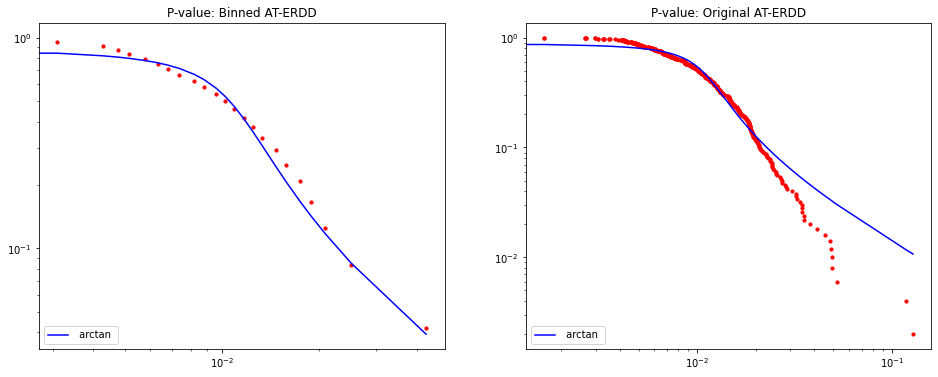

Factor for AT-GEO: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [8.420248380363349e-05, 9.876252778814987e-05, 0.00011675508100038712, 0.00012708466118115057, 0.00013413627795164995, 0.00014550555081430515, 0.00015801822584544586, 0.00016852514115849775, 0.00017969709976719102, 0.0001903351929899253, 0.00020185702705065523, 0.00020985148912922662, 0.00022550859509687252, 0.0002391959079150175, 0.00025995873634670954, 0.000279992059150323, 0.00030060261733708826, 0.00032128461690176136, 0.00035484311647339514, 0.0003996758639006337, 0.0004699091587092569, 0.000573446125598445, 0.000993949852539739]
curve_fit parameter on  arctan :  [2.21866635 1.32587152]
P-val Error at the furthest tail of Binned Y:  0.010670441211689696
P-val Error at the furthest tail of Original Y:  -0.005172719490755817


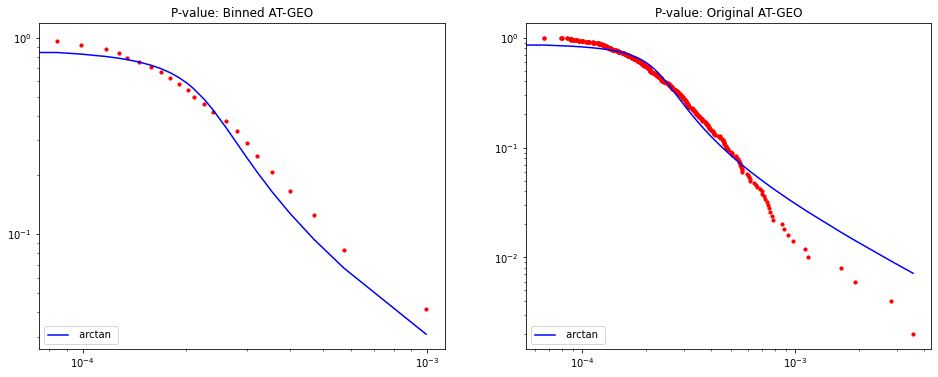

Factor for AT-GEOGD: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.00010071745481493696, 0.00012205707702226667, 0.00013480565499603774, 0.00015149974155882534, 0.0001651423060021734, 0.00018158160094351137, 0.00020044494750568525, 0.00022884382453537477, 0.00025626296346502645, 0.000286543013605955, 0.0003174892647656096, 0.0003596131928862695, 0.00040315182595201883, 0.0004487633233530447, 0.0005197080916694503, 0.0006003780568976064, 0.0007260426188501466, 0.0008804126572318599, 0.0011811347618025342, 0.00176430344197988, 0.0023818758423080565, 0.004419245675638505, 0.010552544664447557]
curve_fit parameter on  arctan :  [0.40892527 4.32975772]
P-val Error at the furthest tail of Binned Y:  0.03442032923384908
P-val Error at the furthest tail of Original Y:  -0.0009478241770537466


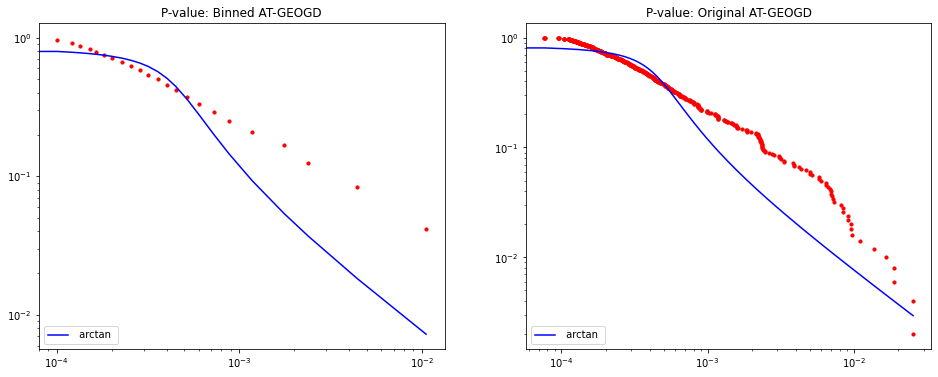

Factor for AT-HGG: 0.1
items in each bin:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15]
binned_data:  [0.0311190100012648, 0.04120971622113657, 0.04865730642159171, 0.05484276546570789, 0.062961554716315, 0.06871532210639711, 0.07566933171495845, 0.08572258458645729, 0.09517173396641818, 0.10847802603694334, 0.12250823239507606, 0.14862837436079732, 0.1777640542719987, 0.21256801236402, 0.25320022983953216, 0.42628439891627057]
curve_fit parameter on  arctan :  [0.97454838 2.36007849]
P-val Error at the furthest tail of Binned Y:  0.018032345102030778
P-val Error at the furthest tail of Original Y:  -0.019416318671446442


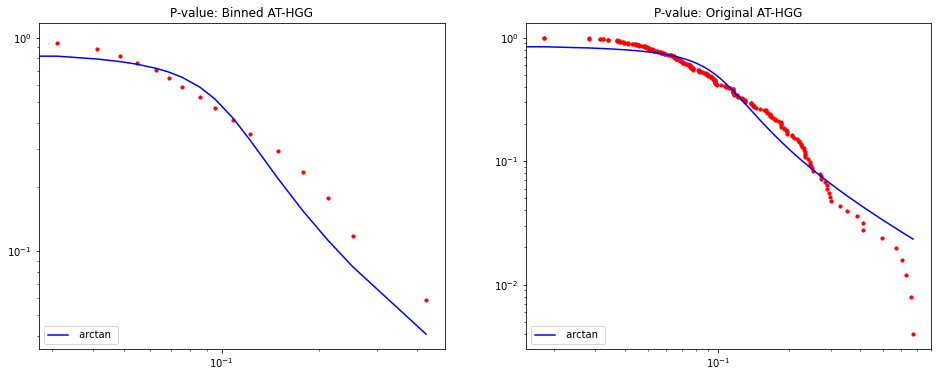

Factor for AT-SF: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [0.00013477090800327276, 0.00017483465782212236, 0.00018840217544659448, 0.00020106925549440467, 0.00021233915817649905, 0.0002204440046498599, 0.0002266567865045141, 0.00023640003832323207, 0.0002487040299160703, 0.000261614833796961, 0.0002750437956579125, 0.0002839152462151795, 0.0002956597535302783, 0.00030883421202345095, 0.00032641511341588236, 0.0003469413188911087, 0.0003624846027215626, 0.00038058479493968716, 0.00040199762339004403, 0.00043149626490670846, 0.00046923156224459736, 0.000539532597336709, 0.0007789748446245443]
curve_fit parameter on  arctan :  [2.90899746 1.40540537]
P-val Error at the furthest tail of Binned Y:  -0.004413403195443921
P-val Error at the furthest tail of Original Y:  -0.009797113102206434


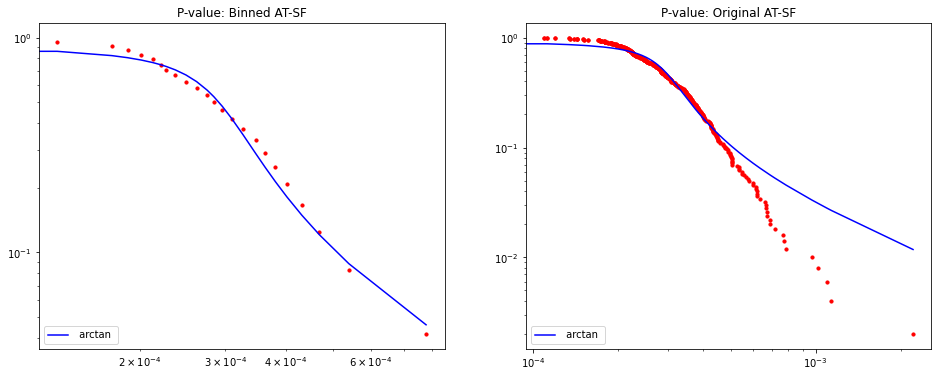

Factor for AT-SFDD: 0.1
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.005099387973277196, 0.007056267149376307, 0.007889631397947074, 0.008756558182932974, 0.009682841918244872, 0.010749806684624079, 0.011796325378484287, 0.012608597155296183, 0.013212842404159514, 0.013879117295924007, 0.014747340762223705, 0.01564395031780141, 0.01638173362096837, 0.017742526992969188, 0.019133267475192135, 0.0211625862810578, 0.023684569197820613, 0.026684193737564383, 0.029313377164713588, 0.03358423129956445, 0.044423106648408296, 0.0634430547461717, 0.15262090878759804]
curve_fit parameter on  arctan :  [ 0.16500111 16.35612681]
P-val Error at the furthest tail of Binned Y:  0.02737926085225073
P-val Error at the furthest tail of Original Y:  -0.001934344079971284


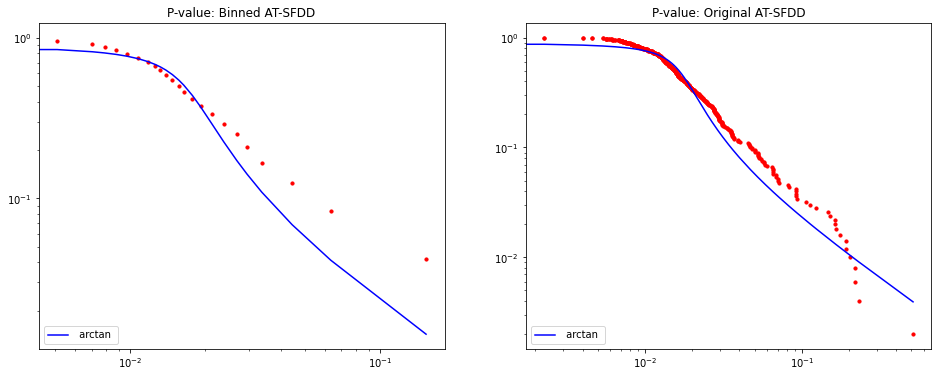

Factor for AT-Sticky: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0031703034544995454, 0.0037337497111613856, 0.004073685514322888, 0.0042910459027512594, 0.004397347569822862, 0.004547075459778867, 0.004742868293768542, 0.004895755385562333, 0.005054679383956369, 0.005246492167320808, 0.005424826479155986, 0.00553918527656812, 0.00578039904004019, 0.006034582322440162, 0.0062570346638740814, 0.006645628414306107, 0.006885836045691492, 0.007199943625599551, 0.007549968132560029, 0.007988089338507112, 0.00870562990621994, 0.009726631023302856, 0.012418433924685493]
curve_fit parameter on  arctan :  [5.70944611 0.86356128]
P-val Error at the furthest tail of Binned Y:  -0.012738708531979337
P-val Error at the furthest tail of Original Y:  -0.027578419035555135


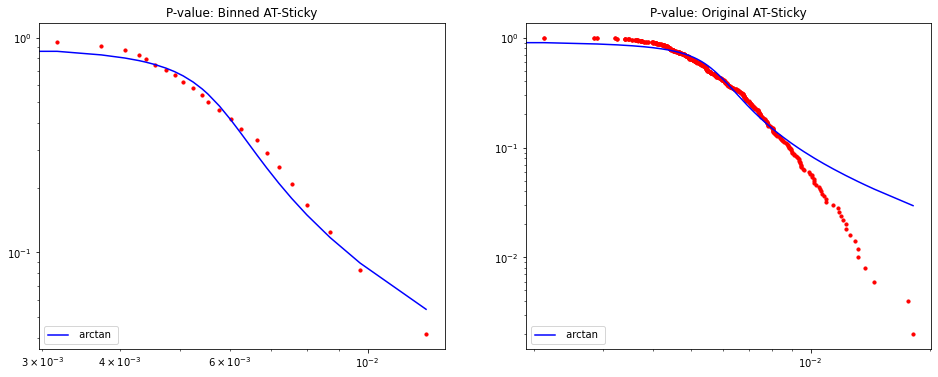

Species:  CE
Factor for CE-ER: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [5.36191271960775e-05, 8.035547308827789e-05, 9.364941724654925e-05, 0.00010767526884103076, 0.0001183564313518433, 0.00013516185869811605, 0.00014582702538437503, 0.0001565765471060978, 0.00016810586622543016, 0.00017492254863147967, 0.00018040013739135534, 0.00018859719563734412, 0.0002000712758920344, 0.00021103576605083118, 0.00021901748242828003, 0.00022996315284850834, 0.00025221820795726167, 0.0002693744027064064, 0.00029797756334770165, 0.0003199485423372738, 0.00034693694041915173, 0.00045026060519937284, 0.0008144379313334409]
curve_fit parameter on  arctan :  [1.94363127 1.70728404]
P-val Error at the furthest tail of Binned Y:  0.011687916306393986
P-val Error at the furthest tail of Original Y:  -0.005090339767910512


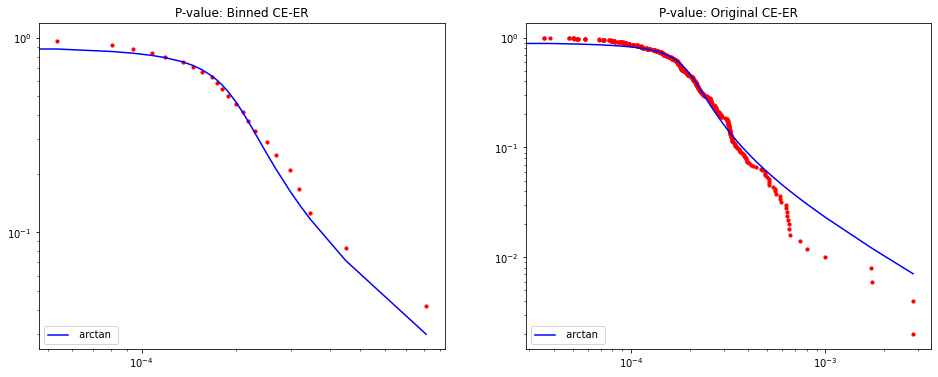

Factor for CE-ERDD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.005429471488036072, 0.0065253112686606786, 0.007291468482611442, 0.007724230662426535, 0.008054769430859001, 0.008523770244896322, 0.009020532493065947, 0.009364647666029208, 0.009782959836098844, 0.01007509726471712, 0.010410898234875331, 0.010905509613925411, 0.011307127330911439, 0.01192885575926177, 0.012579619098553539, 0.013208805519500964, 0.013816887847893774, 0.014963087876819882, 0.015965153177246467, 0.017517183853056863, 0.019474076495756477, 0.023287762532729298, 0.04226224982047865]
curve_fit parameter on  arctan :  [1.12124043 3.63730975]
P-val Error at the furthest tail of Binned Y:  0.013555474393368239
P-val Error at the furthest tail of Original Y:  -0.002052482395212385


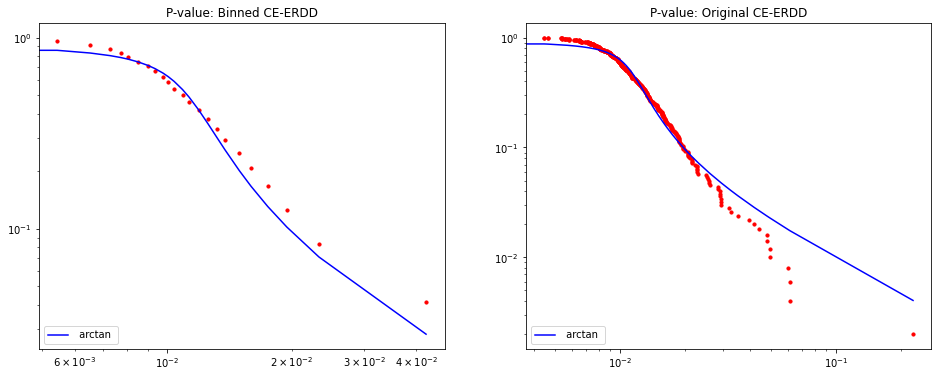

Factor for CE-GEO: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0006748731407819749, 0.0009268268592919072, 0.001040832326159573, 0.0011470784858786983, 0.0012260040299460152, 0.001285112684345364, 0.0013273268701159506, 0.0014035220202379657, 0.0014633786927575766, 0.001529739856854114, 0.0015868724097498192, 0.0016329534749593734, 0.0017022818771361041, 0.0017795684223396704, 0.0018924786740937098, 0.001983131898229916, 0.0020289280204594698, 0.0021067787025571363, 0.0022655594954047345, 0.00247094928256756, 0.0026924731412296486, 0.0032370112686134623, 0.004396430368033606]
curve_fit parameter on  arctan :  [1.67425433 2.52746562]
P-val Error at the furthest tail of Binned Y:  -0.004276205518692233
P-val Error at the furthest tail of Original Y:  -0.025610612585147408


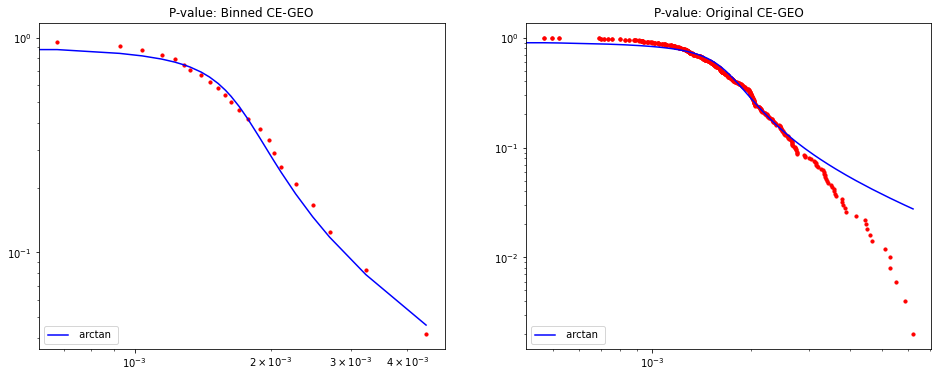

Factor for CE-GEOGD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0008899028553980324, 0.001145107377882612, 0.0012886151866929232, 0.0014209081542429234, 0.001538959514385992, 0.0016343469652095452, 0.0017339016271378544, 0.001825284157925615, 0.002002019652421269, 0.002179472775792537, 0.002342063508836541, 0.0025240196488221524, 0.002766315590200381, 0.003059868458457389, 0.0035666954170650842, 0.004016349370610447, 0.0046011891288887975, 0.005484390507762529, 0.006265478300201442, 0.007354404807409308, 0.009149724987397443, 0.011780108895047036, 0.028020580779652877]
curve_fit parameter on  arctan :  [0.28622289 7.36044398]
P-val Error at the furthest tail of Binned Y:  0.02449382014196766
P-val Error at the furthest tail of Original Y:  -0.0010802902125309766


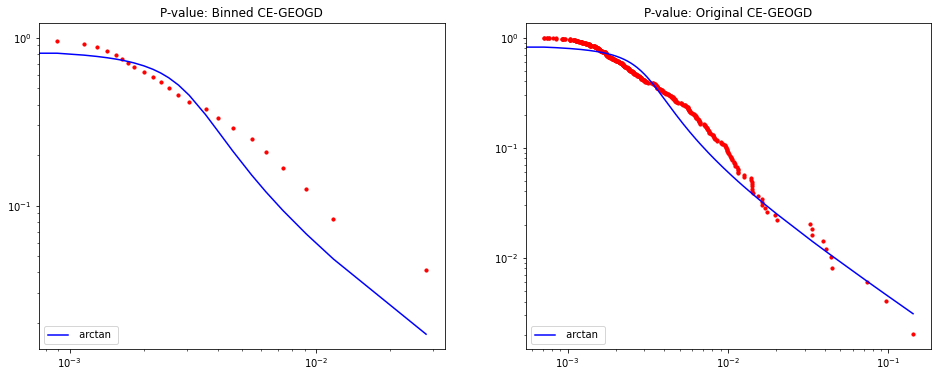

Factor for CE-HGG: 0.01
items in each bin:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15]
binned_data:  [0.015388912162327266, 0.0208479634887585, 0.023876909678589422, 0.026276688384987503, 0.029059635928967736, 0.031248963675723333, 0.03455413480699958, 0.03822050008554431, 0.043694209857663556, 0.052351959567696865, 0.06555512120219488, 0.08055220281797039, 0.10169013153819977, 0.1294843503261481, 0.1830011813553946, 0.3682560737386595]
curve_fit parameter on  arctan :  [4.79181059 0.41414752]
P-val Error at the furthest tail of Binned Y:  0.03487569939521318
P-val Error at the furthest tail of Original Y:  -0.0005156666642462948


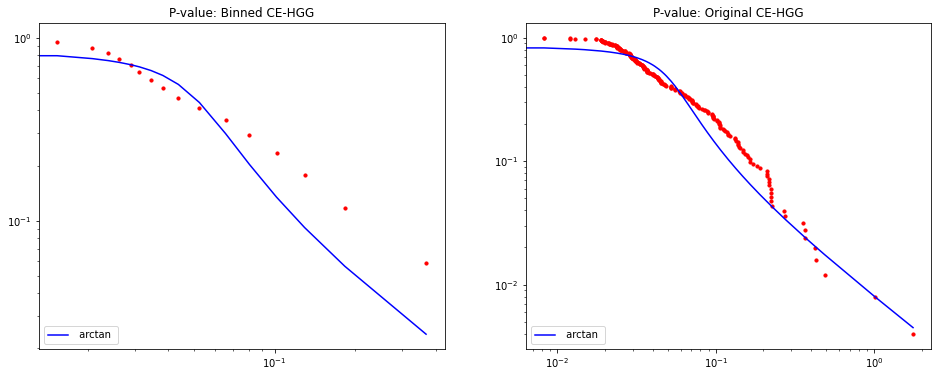

Factor for CE-SF: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0004532128794394597, 0.0005635914415316202, 0.00060943996994593, 0.0006796280603812236, 0.0007276373674396533, 0.0007604652163211275, 0.0007900765568706565, 0.0008233665725010454, 0.0008422791690599252, 0.000867952427556774, 0.0008959448499044536, 0.0009254833437134281, 0.0009523182066401825, 0.000995901128661159, 0.0010379612678835192, 0.0010824978984109188, 0.001125575090698742, 0.001185563010542558, 0.001259109839505704, 0.001345170492788404, 0.0015085202310434727, 0.0017947323099206038, 0.002401113047993985]
curve_fit parameter on  arctan :  [9.43565588 0.51167242]
P-val Error at the furthest tail of Binned Y:  -0.0007613483696731205
P-val Error at the furthest tail of Original Y:  -0.017018282123726136


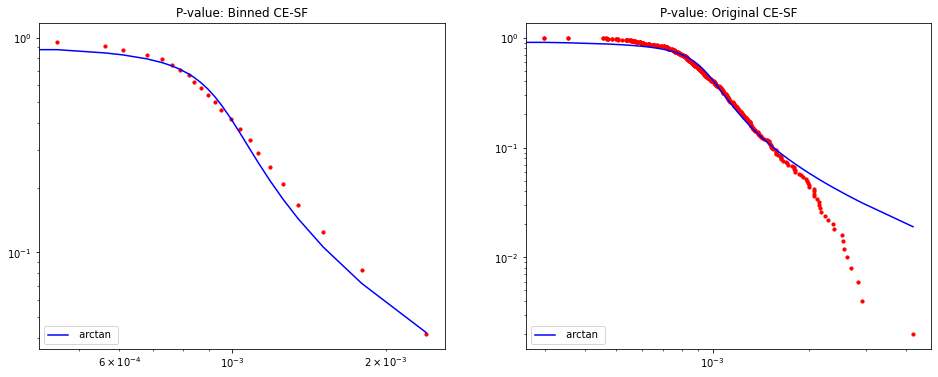

Factor for CE-SFDD: 0.1
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21]
binned_data:  [0.009279540483977557, 0.010360330694010291, 0.011277771888411338, 0.01251826104560552, 0.013596634687997315, 0.014282588976924296, 0.015427335447102964, 0.01648799484983415, 0.017620589171679277, 0.018518287850720978, 0.019950460453360505, 0.021872927633432373, 0.023729261579939, 0.02510924593869765, 0.027072212768252238, 0.029678593088533843, 0.034725848068510964, 0.04065075332099896, 0.04565673690820432, 0.05227159245819991, 0.0637504828598608, 0.08602356220318177, 0.19303506548461874]
curve_fit parameter on  arctan :  [ 0.23227574 10.83465432]
P-val Error at the furthest tail of Binned Y:  0.02438239482688831
P-val Error at the furthest tail of Original Y:  -0.0004789687861275205


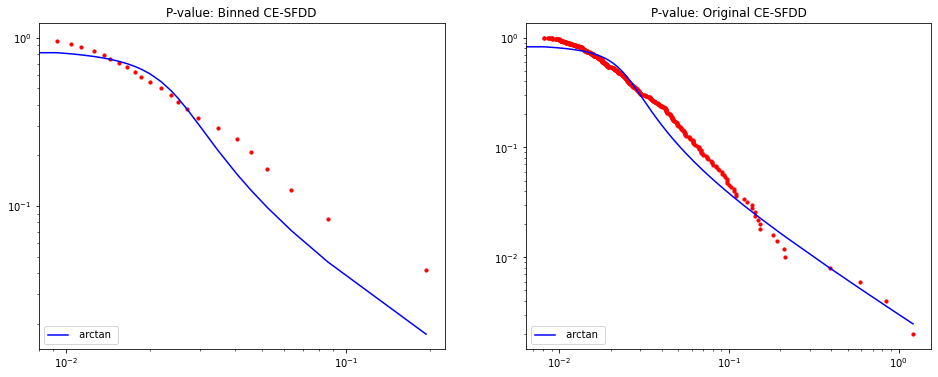

Factor for CE-Sticky: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [0.004490125865151255, 0.005157246550272111, 0.005649815164618577, 0.005921171312782832, 0.0061463979955268385, 0.006563553251429682, 0.006792651892174398, 0.006993114554364189, 0.007202296943843278, 0.0074835353962469315, 0.007693146345920478, 0.007910259768220773, 0.00818504536200337, 0.008420133394883277, 0.008735652532409035, 0.009072103284795114, 0.009320816702961811, 0.009684453446145831, 0.010126003087231005, 0.01057203637915316, 0.011424860630051024, 0.012807843592114818, 0.015478517778125823]
curve_fit parameter on  arctan :  [8.00641065e+01 6.89097600e-02]
P-val Error at the furthest tail of Binned Y:  -0.019392834242825785
P-val Error at the furthest tail of Original Y:  -0.029555178653834613


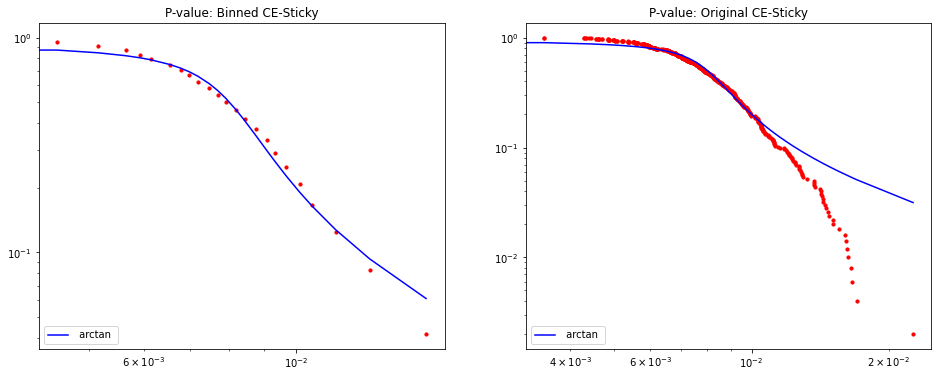

Species:  DM
Factor for DM-ER: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [3.536495998251501e-05, 5.181605431303378e-05, 5.88908268855494e-05, 6.98187537737573e-05, 7.528658614097827e-05, 7.967230683401498e-05, 8.507138854620099e-05, 8.925474210029522e-05, 9.42935016316045e-05, 0.00010121787526079889, 0.000106371489096034, 0.00011085740479931976, 0.00011427820769065525, 0.00011895456590687766, 0.00012525053812900664, 0.00013296475747268596, 0.00014103312666621998, 0.0001496423209109662, 0.0001602021880473605, 0.00017559840884216814, 0.00019320006610610972, 0.0002240928378790915, 0.00048200180486228296]
curve_fit parameter on  arctan :  [ 0.11170783 32.36416619]
P-val Error at the furthest tail of Binned Y:  0.01516738316344246
P-val Error at the furthest tail of Original Y:  -0.00040808528614144635


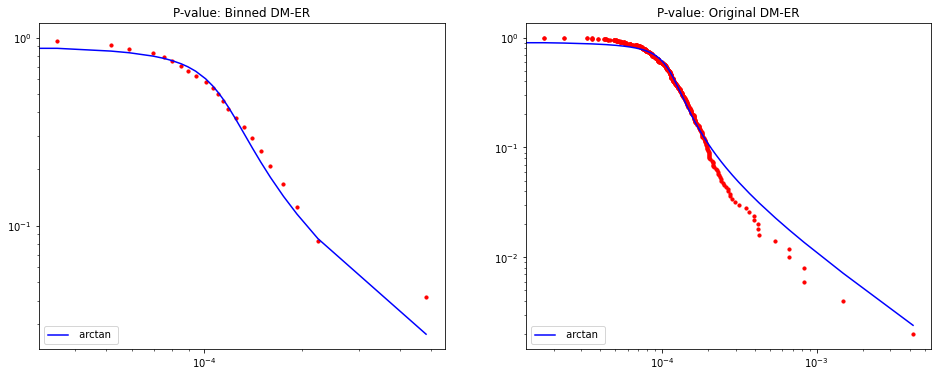

Factor for DM-ERDD: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.001071866556917352, 0.0012597448888897055, 0.0013961032264548172, 0.0014930942225024498, 0.0016117312785282466, 0.0017356471797323402, 0.0018055445288630827, 0.0018913077944733027, 0.0019611491313317447, 0.0020147800774745284, 0.0020862314313721793, 0.002187132436014598, 0.0022692156706631923, 0.0023324469948394102, 0.0024035605381474865, 0.002464534613956524, 0.002554795220817651, 0.002663301148066582, 0.002787619753271946, 0.0029902814873748146, 0.003344055249387629, 0.003817551027276715, 0.0050581389060998854]
curve_fit parameter on  arctan :  [2.18821795 2.25051366]
P-val Error at the furthest tail of Binned Y:  -0.0072282627066595495
P-val Error at the furthest tail of Original Y:  -0.02436548865744359


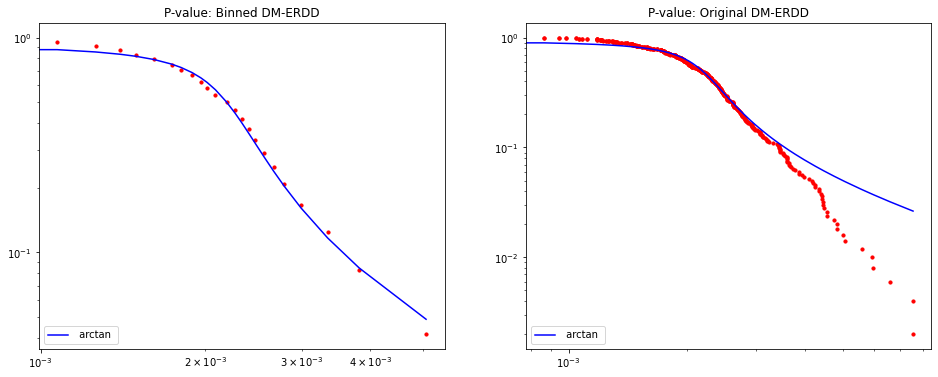

Factor for DM-GEO: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0002185251709017211, 0.00028300270574520037, 0.00031071880561257733, 0.0003369466338341063, 0.0003693076591440383, 0.00038986936737671265, 0.0004143615971001363, 0.0004305163355488053, 0.0004491659817160317, 0.0004678044853038186, 0.0004817016342547726, 0.0004987114897835938, 0.0005248799528038381, 0.0005513578996557756, 0.000575769318407272, 0.0006076667998973889, 0.0006422316465518042, 0.0006825020438201411, 0.0007297803923568382, 0.0008063593675582579, 0.0009068649183097557, 0.0010524172200342874, 0.0015415404727515294]
curve_fit parameter on  arctan :  [5.15860251 0.77118665]
P-val Error at the furthest tail of Binned Y:  0.0016371133301694707
P-val Error at the furthest tail of Original Y:  -0.018153169798130975


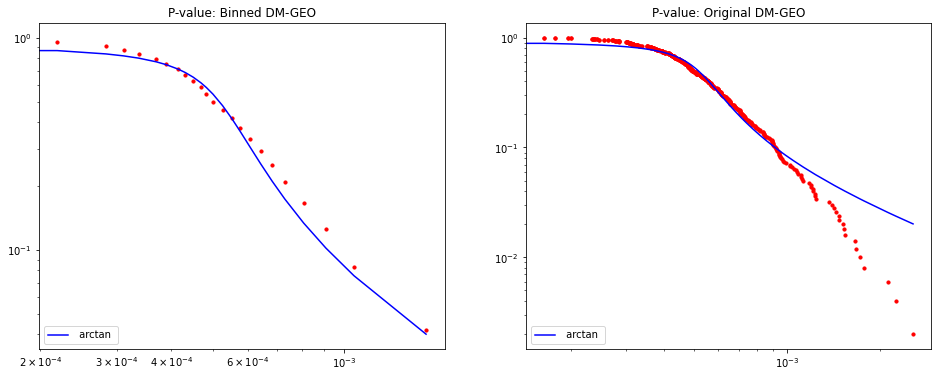

Factor for DM-GEOGD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21]
binned_data:  [0.0, 0.0005191730269845848, 0.0006389999510363991, 0.0007601881589050968, 0.0008146749346959043, 0.0008794627314580393, 0.000937159380987212, 0.001008691875516948, 0.0010935442856129561, 0.001237115372530999, 0.0013899007096819665, 0.0015469118591373639, 0.0017719219717271639, 0.0019995530299320345, 0.002334005796802626, 0.0027764115119836724, 0.003328008371472698, 0.00426159254472353, 0.005391119112368178, 0.008540512359569803, 0.014413996342049493, 0.027428336502986414, 0.12498190035753344]
curve_fit parameter on  arctan :  [0.18239863 9.3843577 ]
P-val Error at the furthest tail of Binned Y:  0.03891261291508463
P-val Error at the furthest tail of Original Y:  0.0008437199518529503


D:\anaconda\anaconda\lib\site-packages\scipy\stats\stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


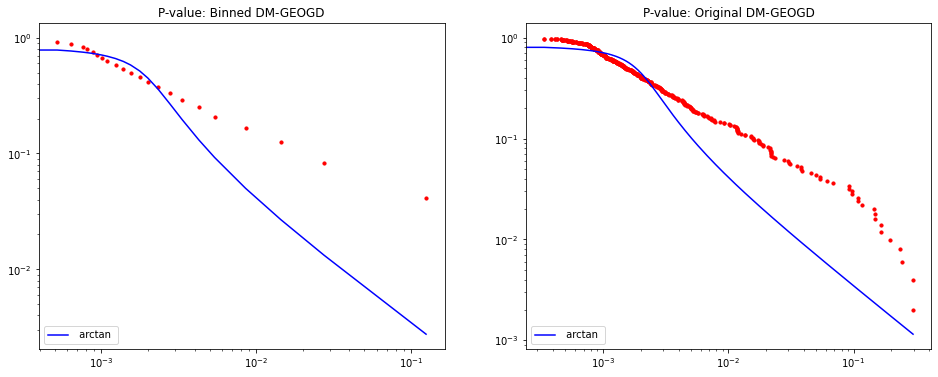

Factor for DM-HGG: 0.1
items in each bin:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15]
binned_data:  [0.0, 0.02610466747050515, 0.031878752731832896, 0.037626960627387775, 0.04247490286633109, 0.04844679299037755, 0.055212624634832945, 0.0595451468823441, 0.06788253165302784, 0.07376877515660143, 0.08342641744420695, 0.09475868748547055, 0.11407733626794042, 0.14334622833287528, 0.20012503483545804, 0.445829759545231]
curve_fit parameter on  arctan :  [0.66833847 3.49156411]
P-val Error at the furthest tail of Binned Y:  0.03481470432422684
P-val Error at the furthest tail of Original Y:  -0.004615239852688635


D:\anaconda\anaconda\lib\site-packages\scipy\stats\stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


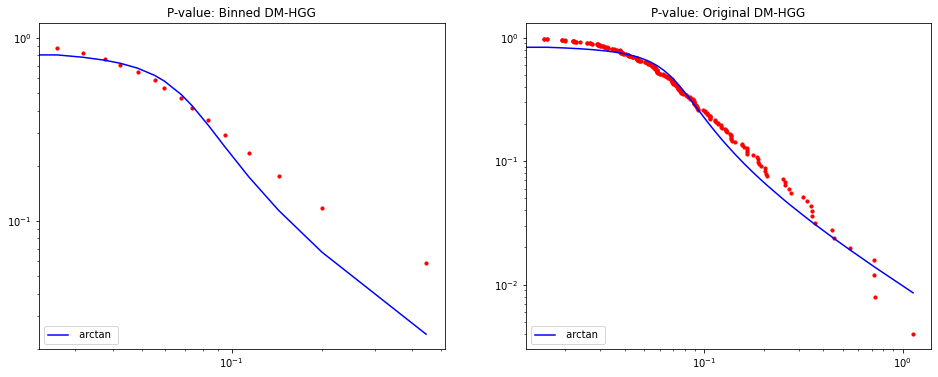

Factor for DM-SF: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0004375412813906469, 0.0005830182328211178, 0.0006411327450590823, 0.0006796316950057807, 0.0007197750973237929, 0.0007557714551676024, 0.0007981490912500887, 0.0008406276397769145, 0.0008787495181175842, 0.0009191756844648114, 0.0009494116992564097, 0.0009865446211312476, 0.0010453632507945296, 0.0010858771733691756, 0.0011449569091874084, 0.0012199250941104705, 0.001279553235201686, 0.0013281612269093626, 0.001401701078145563, 0.0015813524423783933, 0.0016810021807280638, 0.0019818908750833344, 0.0031916515920719047]
curve_fit parameter on  arctan :  [1.01894485 3.8767691 ]
P-val Error at the furthest tail of Binned Y:  0.004052537744512752
P-val Error at the furthest tail of Original Y:  -0.0057514419506730086


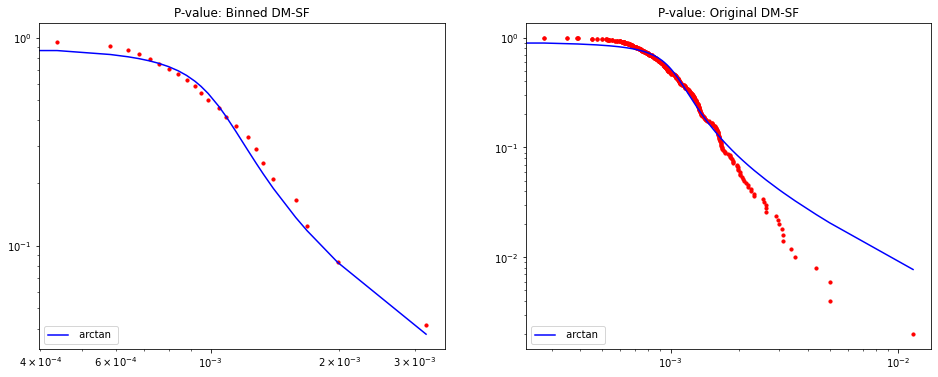

Factor for DM-SFDD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21]
binned_data:  [0.003729862912879651, 0.004611698720483585, 0.004988536245554236, 0.005181010407757633, 0.005442865492945921, 0.005788583340355185, 0.006103417184948976, 0.006398141720943428, 0.006705707350309058, 0.007011191138061222, 0.007237895143256156, 0.007410237507559398, 0.007573071183884565, 0.007777636338130408, 0.008067067494884964, 0.008483695050030254, 0.008966127839952934, 0.009455607331841184, 0.01013711453606674, 0.01087053008088763, 0.01209294292511285, 0.014135715878517105, 0.022157468349318043]
curve_fit parameter on  arctan :  [0.74672003 6.39997841]
P-val Error at the furthest tail of Binned Y:  0.00793699403567183
P-val Error at the furthest tail of Original Y:  -0.006339267329366738


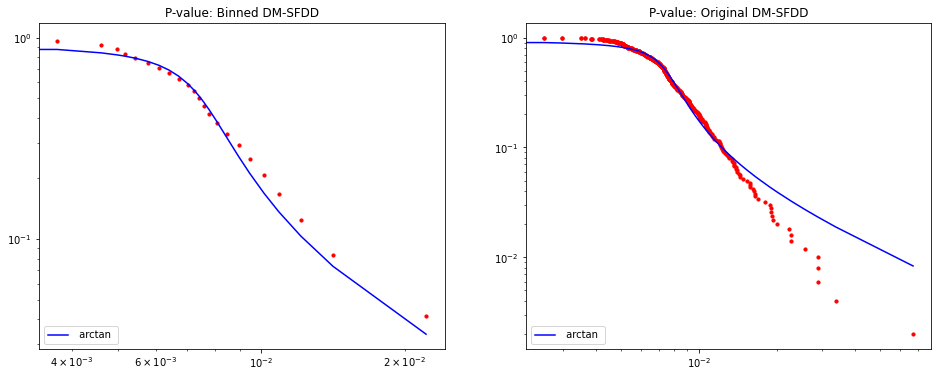

Factor for DM-Sticky: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0019355970654165709, 0.002364310705537419, 0.002624920660003077, 0.0028345735092221874, 0.0029643525398963316, 0.0031729540360160785, 0.0033024102276636757, 0.0034352692265990467, 0.003529963604921865, 0.0036901670768102065, 0.003858561466575975, 0.003983376479037159, 0.004076112517335862, 0.004187530338900042, 0.0043299045916727515, 0.004579939419649649, 0.004706260398226552, 0.004848483771931434, 0.0050287781126184756, 0.005336897556447168, 0.005982860037706824, 0.006913917510862373, 0.011257090944532554]
curve_fit parameter on  arctan :  [ 0.39818103 12.62550389]
P-val Error at the furthest tail of Binned Y:  0.0071487477078092665
P-val Error at the furthest tail of Original Y:  -0.004320211486616099


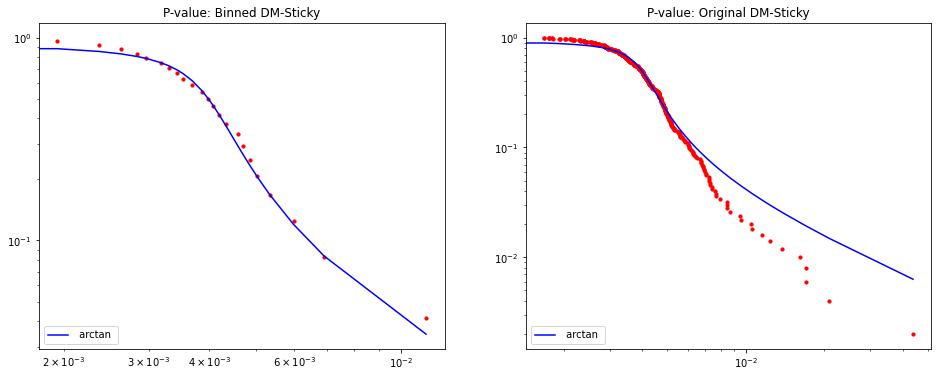

Species:  EC
Factor for EC-ER: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [0.00023198668282190438, 0.00032864957764318153, 0.0003967905734019792, 0.0004574926243190902, 0.0005343528748427881, 0.000579384631750452, 0.0006113050533924693, 0.000650644441244954, 0.0006981564313055525, 0.0007308581707972396, 0.0007612471361821946, 0.0007936193345722722, 0.000829178643516532, 0.0008701901684680673, 0.0009215480943003399, 0.0009989641609872192, 0.0010913264731113206, 0.0011546617940146817, 0.0011991468437713405, 0.0012640327376151883, 0.0013932982615941756, 0.001770555713404158, 0.004748285090627496]
curve_fit parameter on  arctan :  [0.81534217 4.08187787]
P-val Error at the furthest tail of Binned Y:  0.021864545429569615
P-val Error at the furthest tail of Original Y:  1.847532771992455e-06


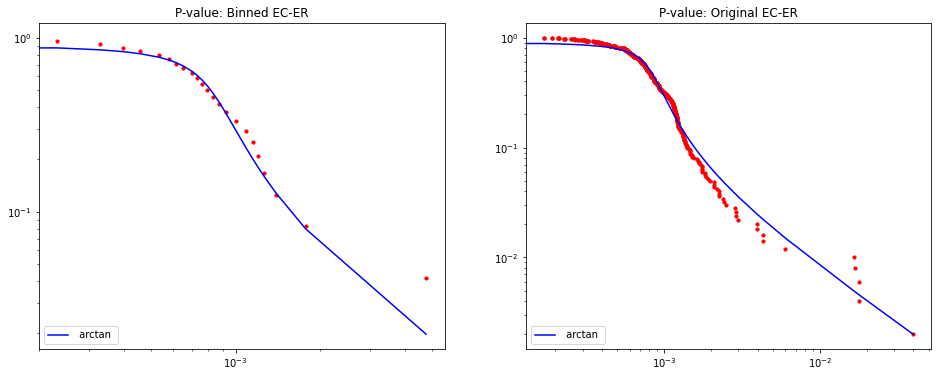

Factor for EC-ERDD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0029042894062550257, 0.0035712689120604426, 0.0038324123101474853, 0.0041289565340347665, 0.004375810207826469, 0.004650713627913223, 0.004917668022134621, 0.005123620927391419, 0.005347703783570992, 0.005477772288709531, 0.0056458604455514655, 0.005854669196670064, 0.0060880051104500125, 0.006335580054404243, 0.006582873046339571, 0.006784134077453196, 0.007099054890705699, 0.007417872769551983, 0.0076799125008989635, 0.007999281300679423, 0.008693106136991114, 0.009607111827447596, 0.013423470212841553]
curve_fit parameter on  arctan :  [0.59429318 8.1577948 ]
P-val Error at the furthest tail of Binned Y:  -0.01003465724223973
P-val Error at the furthest tail of Original Y:  -0.00376564563490267


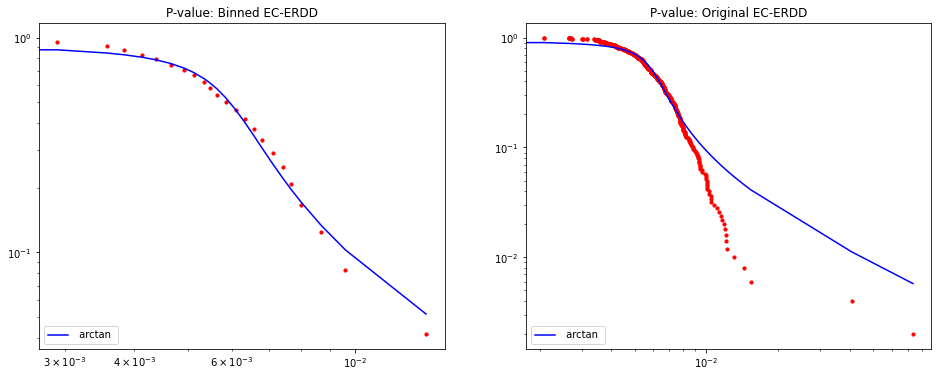

Factor for EC-GEO: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.002004705088710175, 0.002468643279067683, 0.002692631966035331, 0.0029230455771046943, 0.003193418207471023, 0.003495433545334166, 0.0036513987886936322, 0.003768501006437384, 0.003955598937053767, 0.004136138653143452, 0.0043193756370646045, 0.004511647449679407, 0.004720424974002475, 0.004929208774890581, 0.005139106107709393, 0.005388872730403745, 0.005678724625856381, 0.006114592950662686, 0.006514582577220646, 0.007055681614874701, 0.007509510343033427, 0.008635936989260387, 0.014975184783177687]
curve_fit parameter on  arctan :  [0.45978866 8.57125172]
P-val Error at the furthest tail of Binned Y:  0.006029619123855023
P-val Error at the furthest tail of Original Y:  -0.005780150672890394


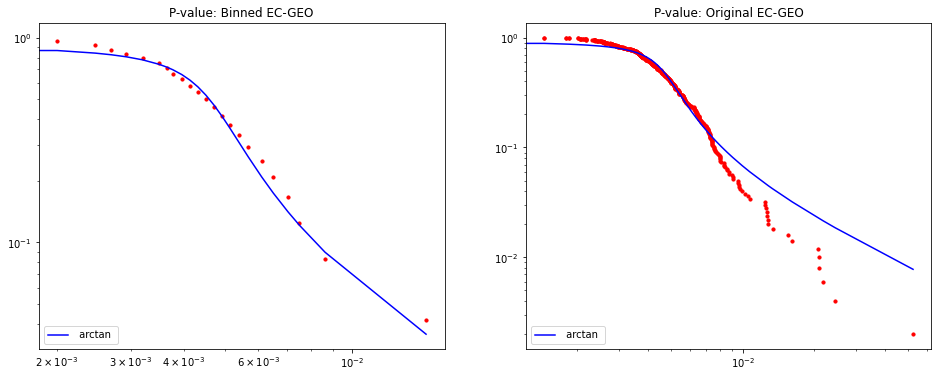

Factor for EC-GEOGD: 0.1
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0031450628185692078, 0.003957235604776012, 0.004441214957124561, 0.004829648427871577, 0.005251087777514248, 0.005688501052137272, 0.005952625264300372, 0.006284961323046059, 0.0069747963216619515, 0.007508314698639939, 0.0082562321833069, 0.009169561367591606, 0.010446580005115738, 0.01157176425454703, 0.012925047090284823, 0.013979442597499713, 0.015776086726084482, 0.017580399721783636, 0.02046176775663452, 0.023202687814458736, 0.026366092498890537, 0.03826771938980922, 0.08773374110163969]
curve_fit parameter on  arctan :  [ 0.10320262 20.30592011]
P-val Error at the furthest tail of Binned Y:  0.02144457636279873
P-val Error at the furthest tail of Original Y:  -0.00023219137805363665


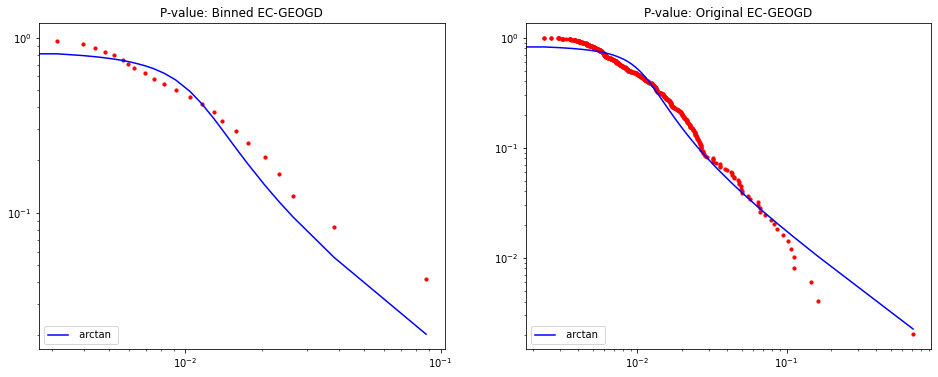

Factor for EC-HGG: 0.1
items in each bin:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15]
binned_data:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
curve_fit parameter on  arctan :  [0.09447732 0.98078227]
P-val Error at the furthest tail of Binned Y:  -0.4705876159822772
P-val Error at the furthest tail of Original Y:  -0.525442891425788


D:\anaconda\anaconda\lib\site-packages\scipy\stats\stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
C:\Users\shiqi jiang\AppData\Roaming\Python\Python38\site-packages\matplotlib_inline\backend_inline.py:234: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


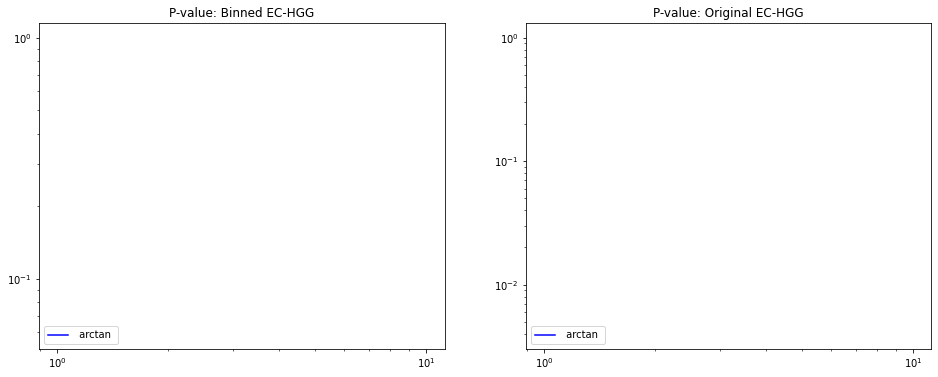

Factor for EC-SF: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0, 0.0036226783083693256, 0.003982416907204865, 0.004266939762495711, 0.004458474203834609, 0.004651133097978926, 0.004792010829317054, 0.004940164527729062, 0.005121371331348772, 0.005280598844495064, 0.005424727209982827, 0.005672499103114906, 0.005863503387055701, 0.006019597284845874, 0.006276790692685952, 0.006448863620893546, 0.006699138727422922, 0.007027832659078718, 0.00733046943234743, 0.007775186779847447, 0.008293366450074776, 0.009194742729246233, 0.012386986964432113]
curve_fit parameter on  arctan :  [5.71354044 0.90342847]
P-val Error at the furthest tail of Binned Y:  -0.010653628411735339
P-val Error at the furthest tail of Original Y:  -0.014525445221782896


D:\anaconda\anaconda\lib\site-packages\scipy\stats\stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


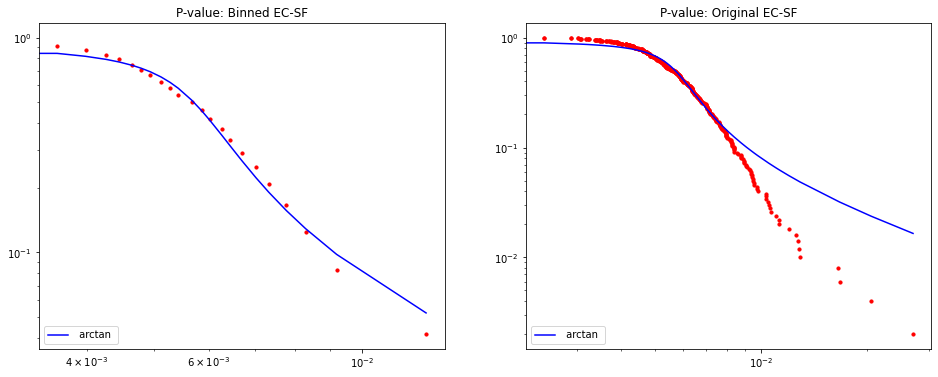

Factor for EC-SFDD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21]
binned_data:  [0.0, 0.028321516791411903, 0.031216615266812343, 0.03402835419883277, 0.03664936158217881, 0.03960771797542488, 0.0415723305480015, 0.043008608582328536, 0.044076160963460356, 0.045850042899688276, 0.048270244889148856, 0.05060780996265041, 0.05279577343392693, 0.05458947438416745, 0.056844229406039844, 0.05944919802302773, 0.06254948651304085, 0.06626568135848537, 0.07103980914888583, 0.07607783765255895, 0.08692147946949112, 0.10153923195422031, 0.17082348219562032]
curve_fit parameter on  arctan :  [5.12083829 0.7953735 ]
P-val Error at the furthest tail of Binned Y:  0.008331606516617573
P-val Error at the furthest tail of Original Y:  -0.010215271236933221


D:\anaconda\anaconda\lib\site-packages\scipy\stats\stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


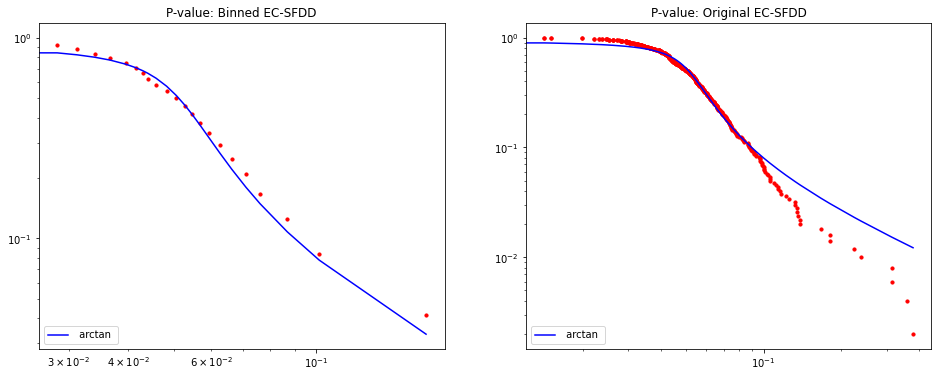

Factor for EC-Sticky: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.006499210616348898, 0.007846365946483523, 0.008437883313897755, 0.008834576054558705, 0.00942257163879083, 0.010033228030744166, 0.010426853125400204, 0.010869763327786209, 0.011168731854210051, 0.011740007027375212, 0.012177260846221085, 0.012655829931449536, 0.013032460117366954, 0.013483690341347542, 0.013950032239176166, 0.014314239744559, 0.01491912627211882, 0.015709656217048135, 0.016342066651841604, 0.01737954932452895, 0.018664269806629805, 0.020868809448865853, 0.029643340648149843]
curve_fit parameter on  arctan :  [1.2685198  3.89745683]
P-val Error at the furthest tail of Binned Y:  -0.00613125534724146
P-val Error at the furthest tail of Original Y:  -0.014405021162826381


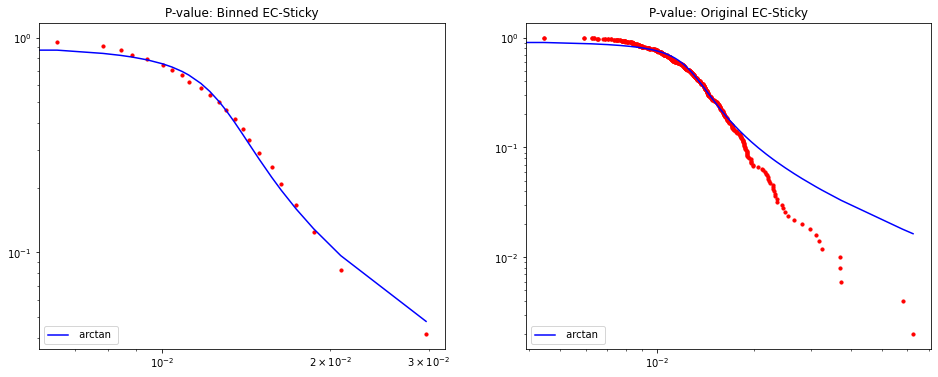

Species:  HS
Factor for HS-ER: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [7.685799052309303e-06, 1.2326386859392484e-05, 1.3726656808795468e-05, 1.518380449280817e-05, 1.771172309084997e-05, 1.9786716680245623e-05, 2.100109338521865e-05, 2.2298894548569014e-05, 2.3469494433111303e-05, 2.4463369490436568e-05, 2.6103375220981592e-05, 2.814983633992331e-05, 2.9777415504259796e-05, 3.0940418660453106e-05, 3.315660613333941e-05, 3.578666512253456e-05, 3.852678584066559e-05, 4.256486018676692e-05, 4.624672807308027e-05, 5.1936174588778214e-05, 6.333666464696368e-05, 8.92381148730563e-05, 0.00025804134103047597]
curve_fit parameter on  arctan :  [ 0.28845358 10.19890584]
P-val Error at the furthest tail of Binned Y:  0.02805771042544236
P-val Error at the furthest tail of Original Y:  0.0010824883373390382


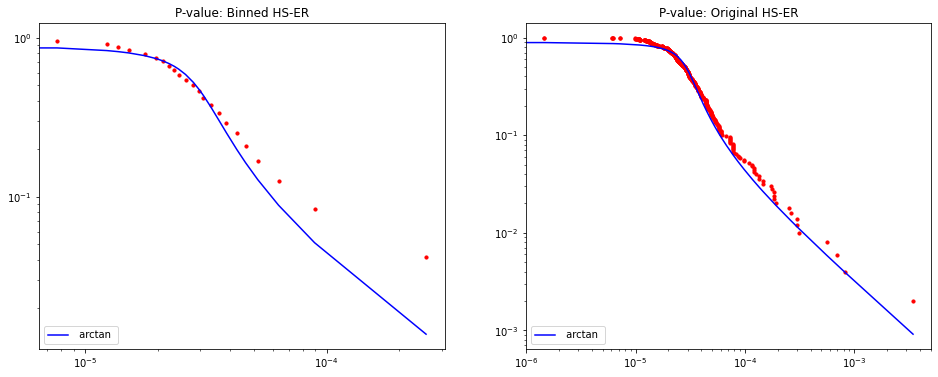

Factor for HS-ERDD: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0008098202928209954, 0.0010056615936087545, 0.0011330998514460266, 0.0012495123504446964, 0.0013044367122429638, 0.001413784088613709, 0.0015302939480526323, 0.0015950751282862372, 0.001662107424437641, 0.0017286986282000038, 0.0018479026328483018, 0.0019347770143796827, 0.001983534812340065, 0.0020786062729931756, 0.0021608222780947093, 0.0022626172258632775, 0.002373286430292438, 0.0025026663425845334, 0.0026819828720892414, 0.0028379521291362455, 0.0031332599483781948, 0.003736809862619882, 0.0070993708198396855]
curve_fit parameter on  arctan :  [1.93563626 2.0525137 ]
P-val Error at the furthest tail of Binned Y:  0.011722215065893993
P-val Error at the furthest tail of Original Y:  -0.0024682006500004183


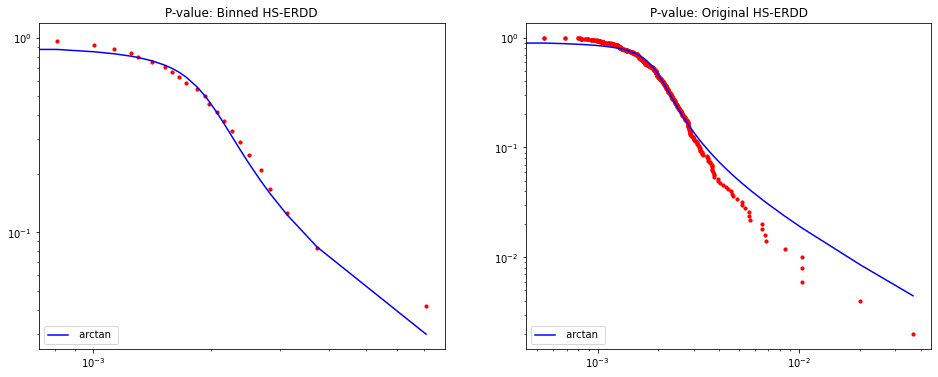

Factor for HS-GEO: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [9.59919724003625e-05, 0.00013187259108295797, 0.00014575757661661643, 0.00015697286351451208, 0.0001671035235760992, 0.000179286522194833, 0.00019015067141112994, 0.00020412642094912466, 0.00021627393125188329, 0.0002245078637278326, 0.00023403194098139068, 0.0002474351786821558, 0.0002598415381856142, 0.00027137246056360866, 0.00028650533717588557, 0.00030074222616157433, 0.0003249956333730897, 0.00035588735888143606, 0.0003899442457523061, 0.00042982963624364903, 0.0004940900954901879, 0.0005790568085539171, 0.0008477573696768172]
curve_fit parameter on  arctan :  [2.53565169 1.36787361]
P-val Error at the furthest tail of Binned Y:  0.0026993883655760387
P-val Error at the furthest tail of Original Y:  -0.016204734281803468


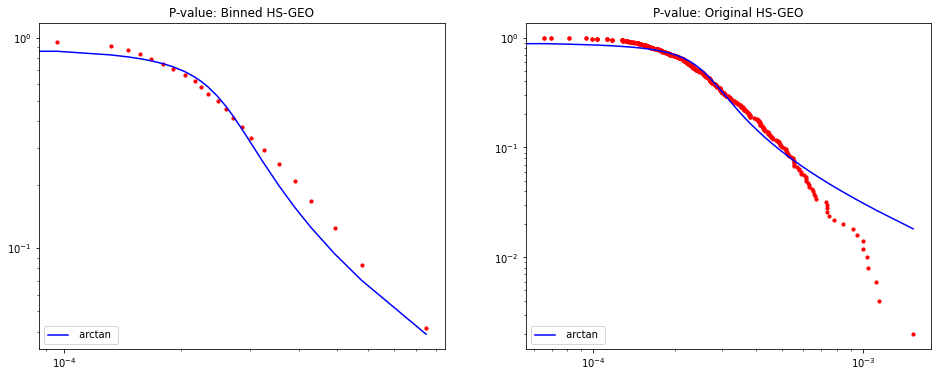

Factor for HS-GEOGD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0001390149136121756, 0.0002054252047808403, 0.0002508928148774055, 0.000276367051836406, 0.00030048191269169133, 0.00032281912794304766, 0.00035963616199125194, 0.00039407344502322394, 0.0004270931147634979, 0.00047898541372974683, 0.0005407731482790004, 0.0006241218603475803, 0.0007530632468690953, 0.0008660716482045371, 0.0009953997625325587, 0.0011928154367656899, 0.0015549450419550723, 0.0019672577796274768, 0.0025630594830090172, 0.0038050541001992955, 0.006606714509414031, 0.012187382306929062, 0.030820493459861667]
curve_fit parameter on  arctan :  [ 0.07751421 20.48168745]
P-val Error at the furthest tail of Binned Y:  0.036494543208046015
P-val Error at the furthest tail of Original Y:  0.0006814061945379368


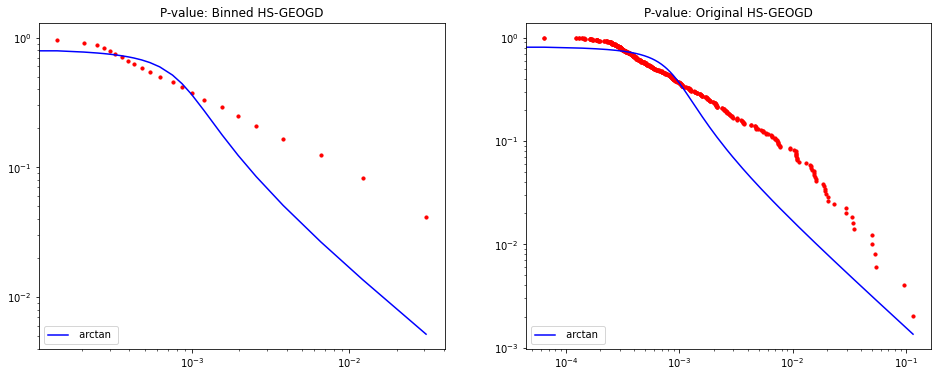

Factor for HS-HGG: 0.1
items in each bin:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9]
binned_data:  [0.0, 0.04744921431344144, 0.05326991043392675, 0.061298009917348455, 0.07035771333239879, 0.07920659404242623, 0.09122953733660864, 0.1085012199784226, 0.1655485604102094, 0.21862204507054098, 0.425112973111786]
curve_fit parameter on  arctan :  [0.84384099 2.8546139 ]
P-val Error at the furthest tail of Binned Y:  0.05072184877245978
P-val Error at the furthest tail of Original Y:  -0.00212305669434254


D:\anaconda\anaconda\lib\site-packages\scipy\stats\stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


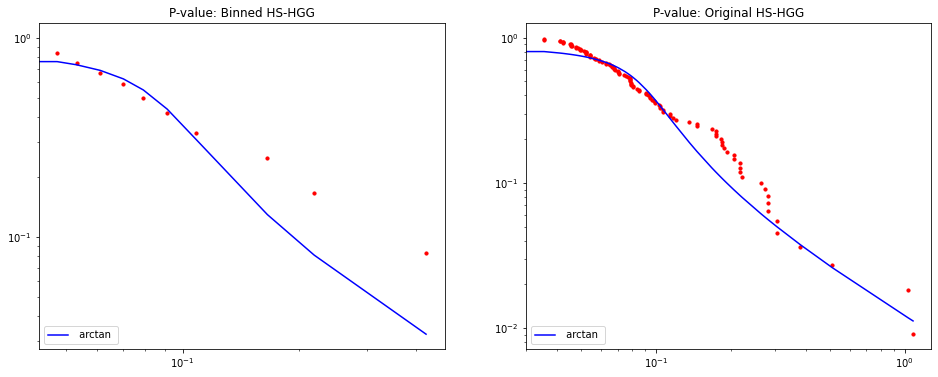

Factor for HS-SF: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [7.294535369912703e-05, 9.254423325749442e-05, 0.0001030703466273464, 0.00010978730058821546, 0.0001161385656382248, 0.00012093839421321868, 0.00012458118590781181, 0.00012879843512657457, 0.00013719054582703, 0.0001437770169881576, 0.00014696188372127303, 0.00015306161308420031, 0.00015837246114936204, 0.0001651267130446002, 0.0001748530164828644, 0.0001806500301091416, 0.00018671772649867552, 0.0001948360397369318, 0.00020337183057926022, 0.00022100440729295678, 0.00024125518410902274, 0.0002750411405952979, 0.0003993857211215496]
curve_fit parameter on  arctan :  [1.55526314 2.91657072]
P-val Error at the furthest tail of Binned Y:  -0.002796513875256257
P-val Error at the furthest tail of Original Y:  -0.027037670056454077


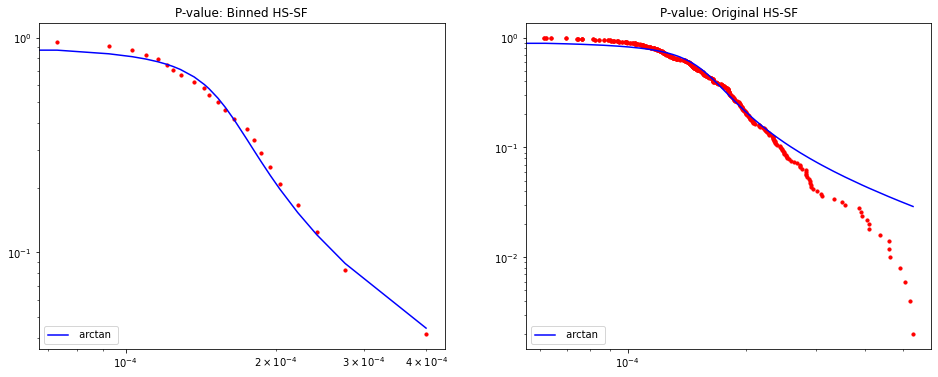

Factor for HS-SFDD: 0.1
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21]
binned_data:  [0.0047315538606228, 0.005820349580169623, 0.006372206340783111, 0.006980395161620996, 0.007734332028545163, 0.008695100155299215, 0.00953028980229671, 0.010039387788383435, 0.010722382097578326, 0.01159124489453431, 0.012550857151859692, 0.013529752473727001, 0.015325096346985726, 0.016775296459859656, 0.018172359710945173, 0.019945767351930967, 0.02274516326885832, 0.02599430151088638, 0.03200433870867995, 0.03979771011701742, 0.05155539807681838, 0.07973777065476889, 0.1943607328735967]
curve_fit parameter on  arctan :  [ 0.15046916 14.74495626]
P-val Error at the furthest tail of Binned Y:  0.029633333916296967
P-val Error at the furthest tail of Original Y:  -0.0033566688793409405


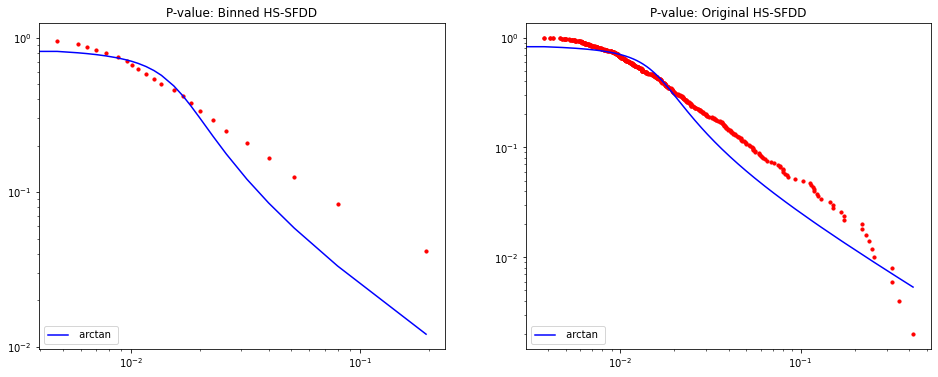

Factor for HS-Sticky: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0011483016230161994, 0.0013780916414851518, 0.0015373552658377392, 0.0016498108368966972, 0.00174170867933162, 0.0017981056600107714, 0.0018452769093835935, 0.0019102545126630816, 0.001997943255422102, 0.0020723020012957355, 0.002153667507095549, 0.0022027366275804467, 0.002290084795742423, 0.0023676357856635896, 0.002463281056193716, 0.0025432112796454184, 0.0026270960065007476, 0.002754342453864, 0.0029043343338738333, 0.0030196051309954747, 0.0032233492721743364, 0.003528999092358866, 0.004326000859703636]
curve_fit parameter on  arctan :  [2.23737099 2.30131381]
P-val Error at the furthest tail of Binned Y:  -0.02362553716586302
P-val Error at the furthest tail of Original Y:  -0.025809458461504287


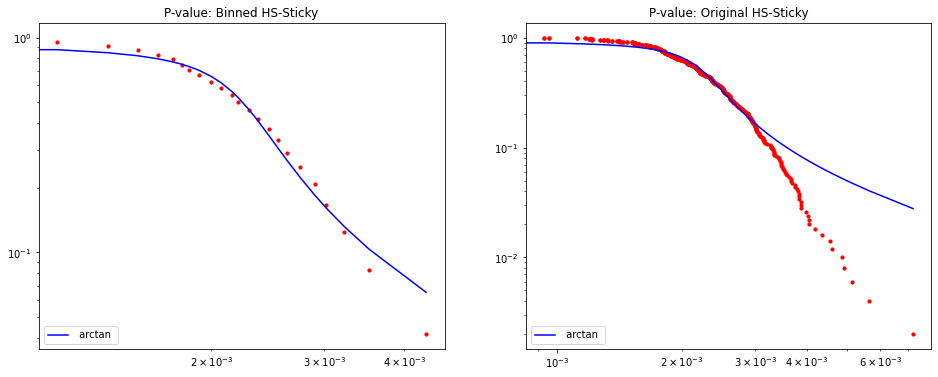

Species:  MM
Factor for MM-ER: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [2.3822130340951404e-05, 3.3559529020795305e-05, 3.8774125707995634e-05, 4.1725875249732246e-05, 4.425443125716768e-05, 4.675629175538623e-05, 4.994980424094347e-05, 5.2144697679522106e-05, 5.4130001391211905e-05, 5.547216220986396e-05, 5.773190886719664e-05, 6.02477240814199e-05, 6.385835673249092e-05, 6.665373330815613e-05, 6.952211228189696e-05, 7.281885597738605e-05, 7.70746331266244e-05, 8.288586296143864e-05, 8.916675681571831e-05, 9.753893228616533e-05, 0.00010750825189721422, 0.0001229072618323648, 0.0002635404513817581]
curve_fit parameter on  arctan :  [0.62213056 6.34958073]
P-val Error at the furthest tail of Binned Y:  0.016817108119691726
P-val Error at the furthest tail of Original Y:  0.0007147381634239336


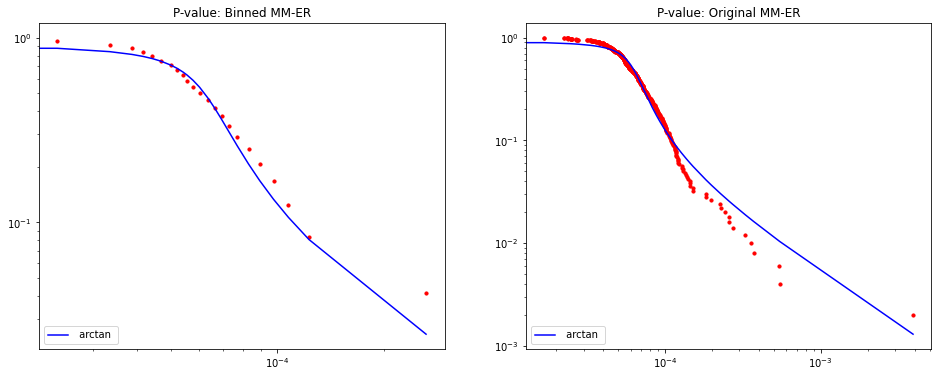

Factor for MM-ERDD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.005930724039618108, 0.0071239105310430635, 0.007703675973329998, 0.008227620142803115, 0.00884050779821664, 0.009239481209015032, 0.009548189964607186, 0.009936248839248941, 0.010281903776642877, 0.010619980491706862, 0.011131801380110934, 0.011520653481824057, 0.01189550401818642, 0.012312120831475015, 0.013014974199572765, 0.013662932081291356, 0.014369742564917643, 0.015111878297278739, 0.016007439737787114, 0.017035948948864097, 0.019033919319434663, 0.022519561373660582, 0.03675357562433461]
curve_fit parameter on  arctan :  [1.17310589 3.80840378]
P-val Error at the furthest tail of Binned Y:  0.008386184509107664
P-val Error at the furthest tail of Original Y:  -0.006009403790300016


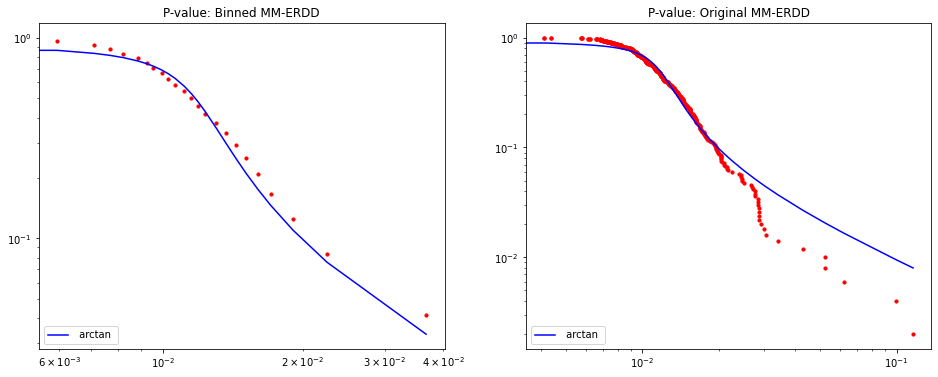

Factor for MM-GEO: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [2.7568202606288186e-05, 3.947931239977117e-05, 4.815275257204249e-05, 5.5374045204843824e-05, 5.9902241829189456e-05, 6.518328992175914e-05, 7.052723161245087e-05, 7.396435092295148e-05, 7.726049333442178e-05, 8.268267612262947e-05, 8.763852241878499e-05, 9.144469073447908e-05, 9.726131442825225e-05, 0.00010442278107031561, 0.00011280173195938926, 0.00012093358543552078, 0.00012810810370546928, 0.00014075372665788656, 0.00015283633442308465, 0.00017087963139429885, 0.0001903709634879686, 0.00023524120343414542, 0.0004197426305960167]
curve_fit parameter on  arctan :  [0.96178723 3.07526468]
P-val Error at the furthest tail of Binned Y:  0.009784207495190711
P-val Error at the furthest tail of Original Y:  -0.0019969657787779482


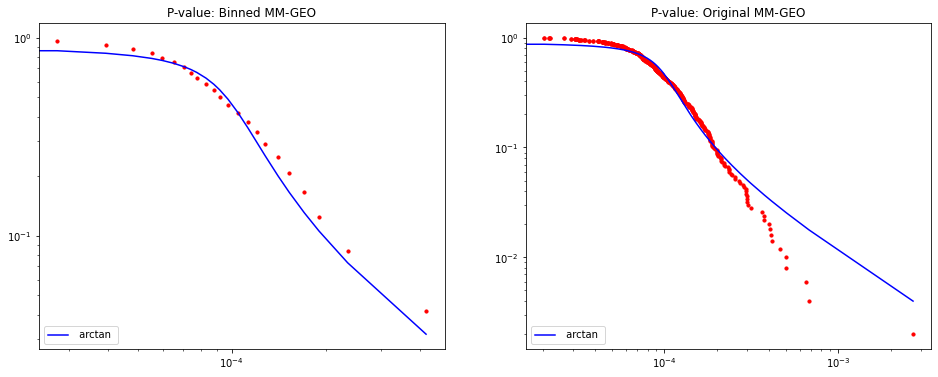

Factor for MM-GEOGD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21, 21, 21]
binned_data:  [6.694694266834129e-05, 9.650845071549754e-05, 0.00012056538806282242, 0.0001366109570447386, 0.0001502271569105428, 0.00016516487670556847, 0.00017654428157931897, 0.0001949130709511719, 0.00021987495926781257, 0.0002519634762416629, 0.00027151660022318465, 0.00030516615998726844, 0.000353457919560312, 0.0004018793728770861, 0.00044461130856081094, 0.0005282276523962603, 0.0006105526377852479, 0.0007760642973181592, 0.0010110968590787246, 0.0013942427936003033, 0.0020909890530718856, 0.004079444288435258, 0.01021483738220867]
curve_fit parameter on  arctan :  [3.56153098e-02 4.93511119e+01]
P-val Error at the furthest tail of Binned Y:  0.035125230883570224
P-val Error at the furthest tail of Original Y:  0.0008730867452956259


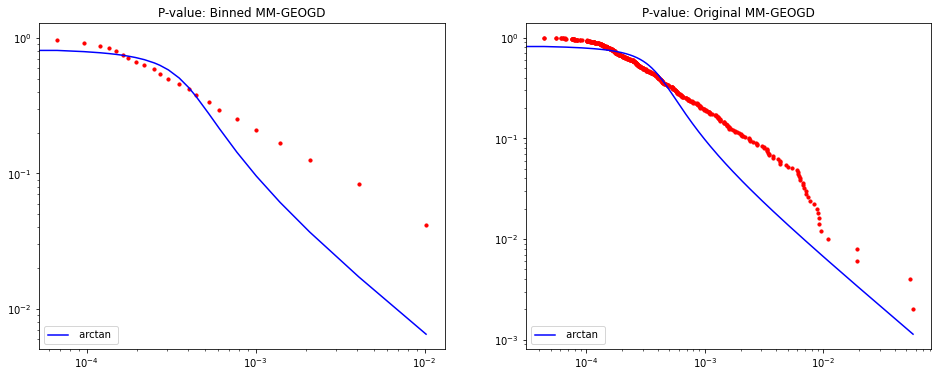

Factor for MM-HGG: 0.01
items in each bin:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15]
binned_data:  [0.0, 0.02081544266399756, 0.026707374227387334, 0.03019364243347524, 0.03253423088848854, 0.038060156961476174, 0.04155598377369825, 0.04439002950166201, 0.048344688022931306, 0.056836932309095284, 0.06991216671875014, 0.09002863182036568, 0.1126229669758579, 0.14150594798849395, 0.17691294698691862, 0.43011164816284325]
curve_fit parameter on  arctan :  [5.25909948 0.38906946]
P-val Error at the furthest tail of Binned Y:  0.03718575413595504
P-val Error at the furthest tail of Original Y:  -0.0009405393818260332


D:\anaconda\anaconda\lib\site-packages\scipy\stats\stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


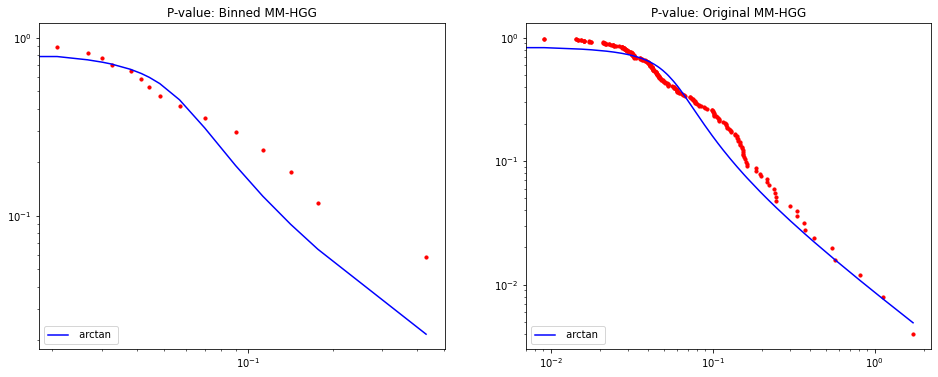

Factor for MM-SF: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [5.885400083647221e-05, 7.504316709656906e-05, 8.460091224725499e-05, 8.841679509378451e-05, 9.553530945674437e-05, 9.89990269035703e-05, 0.00010168850545067591, 0.00010452390339221069, 0.00010933933006665657, 0.0001138090945511714, 0.00011854761753595254, 0.00012113017635790932, 0.00012501664692527427, 0.00013054089798575865, 0.0001345991893517564, 0.00014044665013571096, 0.0001470223835774398, 0.00015614582862063609, 0.0001684084291991631, 0.00018168796644868016, 0.00020261055335869888, 0.00023520119911806783, 0.0003418436332150514]
curve_fit parameter on  arctan :  [1.23392782 3.87246068]
P-val Error at the furthest tail of Binned Y:  0.004212634211569033
P-val Error at the furthest tail of Original Y:  -0.014828508255274153


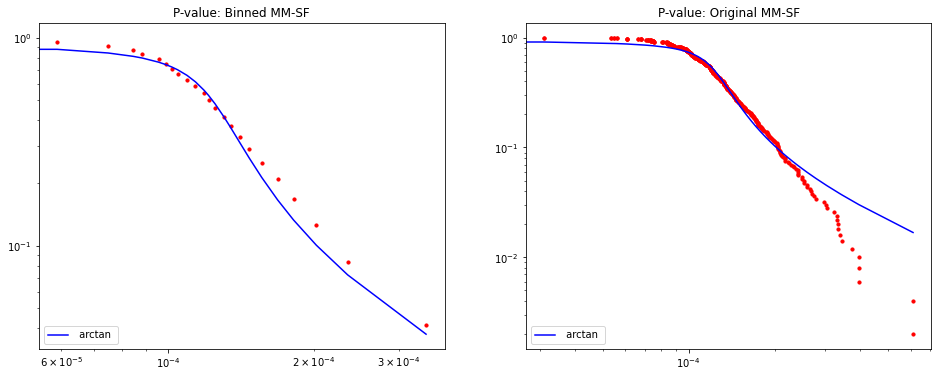

Factor for MM-SFDD: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0041684762914971476, 0.005490031094687739, 0.006228089259326553, 0.0066024184262482594, 0.006986678231982641, 0.007405100877805001, 0.007917280295120583, 0.008321075185112296, 0.008757154446099896, 0.009237207349601921, 0.009930709253580307, 0.010680708387810751, 0.01159135867233148, 0.012296668444949352, 0.013440246530694908, 0.015431216329203475, 0.017923834697252807, 0.020561947342042294, 0.024410354576147777, 0.02771449486535395, 0.03391750106839231, 0.04562847844147368, 0.08525343027922375]
curve_fit parameter on  arctan :  [11.5810251   0.21731876]
P-val Error at the furthest tail of Binned Y:  0.021811009495834366
P-val Error at the furthest tail of Original Y:  -0.005798007110742187


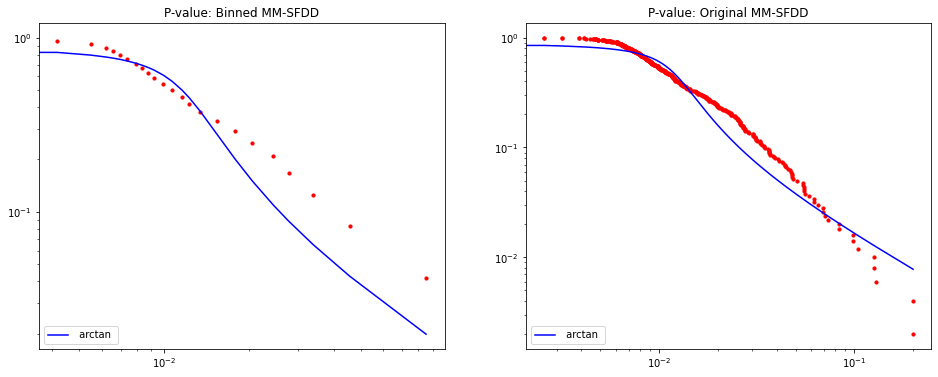

Factor for MM-Sticky: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0019435714204177796, 0.0022496530702402666, 0.002364383218490827, 0.0024783383681458667, 0.0026195632123511975, 0.0027354013858726725, 0.0028379587961570186, 0.0029337015188158743, 0.003014474449328134, 0.0030929939371946145, 0.003167416437309204, 0.003228894615438725, 0.0033446668468338487, 0.00344382608806831, 0.003536472804006149, 0.003657325134124711, 0.003822854214656202, 0.0039821625002528895, 0.004178558664942418, 0.004395561087402424, 0.0047529490513650045, 0.005055871789257962, 0.006141697722332438]
curve_fit parameter on  arctan :  [3.28830779 1.81148314]
P-val Error at the furthest tail of Binned Y:  -0.01916394887057804
P-val Error at the furthest tail of Original Y:  -0.03176832528991613


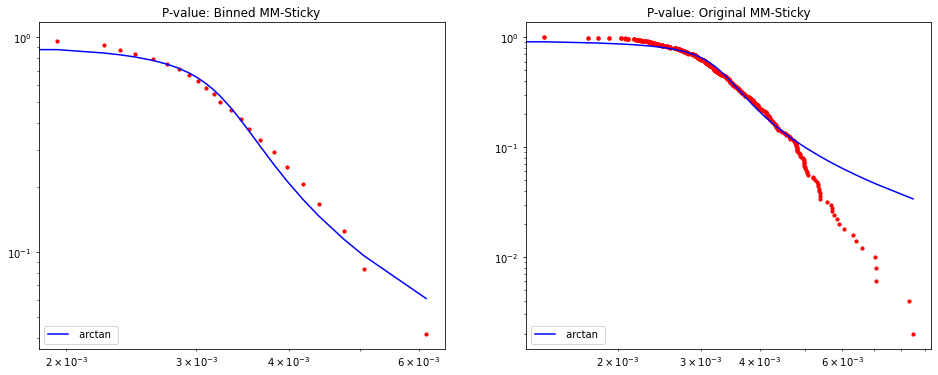

Species:  RN
Factor for RN-ER: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [4.9546526389260024e-05, 6.505021555559129e-05, 7.093170163809916e-05, 7.542944167849673e-05, 7.9600680390217e-05, 8.443164960818673e-05, 8.838645827044766e-05, 9.171766659885838e-05, 9.541151857467283e-05, 9.835821758454254e-05, 0.0001023818104872267, 0.00010770130900660061, 0.00011112983677373655, 0.00011838133140480364, 0.0001255107364536418, 0.0001302923887812512, 0.00014059504589126088, 0.0001477171087770146, 0.0001558863593824613, 0.00016880024093464545, 0.00019067806595950864, 0.0002484453356707855, 0.0015286970340626408]
curve_fit parameter on  arctan :  [ 0.11071677 35.70348499]
P-val Error at the furthest tail of Binned Y:  0.03538010964125149
P-val Error at the furthest tail of Original Y:  9.397894299734144e-05


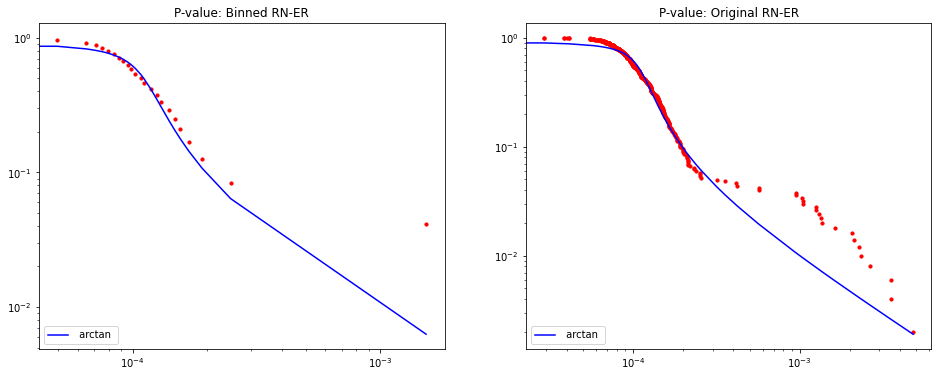

Factor for RN-ERDD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.006837660677403438, 0.008679834998855591, 0.009427053880145133, 0.010205559987833785, 0.01074643616618096, 0.01140143928238754, 0.012036986078133801, 0.012687850851000985, 0.013416519748949755, 0.014021142690253513, 0.014543254399651208, 0.014907469021363771, 0.01532018073855334, 0.01587695826148699, 0.016887956496973926, 0.017927674488559805, 0.01914954647864288, 0.02032780642905996, 0.021460703286011754, 0.02367753190000847, 0.026702197902023894, 0.035223068425708, 0.057411651582668324]
curve_fit parameter on  arctan :  [1.52311869 2.66723953]
P-val Error at the furthest tail of Binned Y:  0.01344797112558449
P-val Error at the furthest tail of Original Y:  -0.002310151649615677


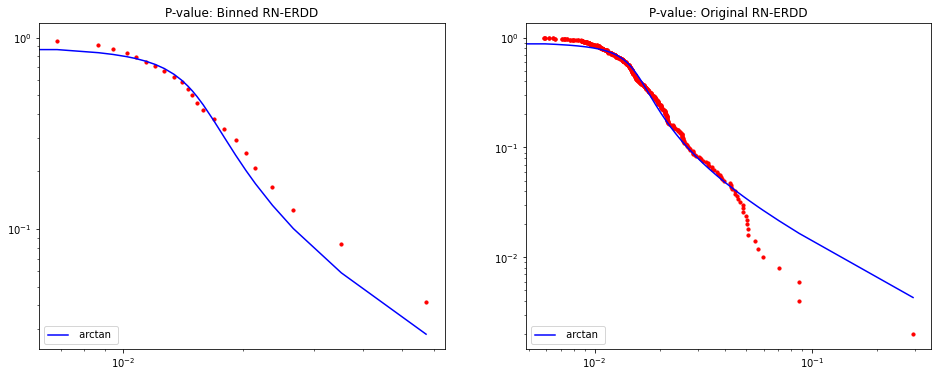

Factor for RN-GEO: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [7.208708512590191e-05, 9.568485183907874e-05, 0.00010789885084959216, 0.00012251321047140876, 0.0001349642322755043, 0.0001440403576411, 0.00015230576615666956, 0.0001637503729997001, 0.0001768498040722794, 0.00019138620012247194, 0.00020337649804141972, 0.0002104198097843535, 0.00022021950648538522, 0.00023515674638767287, 0.0002524246924059663, 0.0002686099955789962, 0.0002939789499043263, 0.0003255651190442756, 0.00037154470278700423, 0.00041101576252550154, 0.0004616484738002431, 0.0005328904160601703, 0.0009578963561461629]
curve_fit parameter on  arctan :  [2.18411436 1.34840541]
P-val Error at the furthest tail of Binned Y:  0.009850297478551373
P-val Error at the furthest tail of Original Y:  -0.0055673900149324496


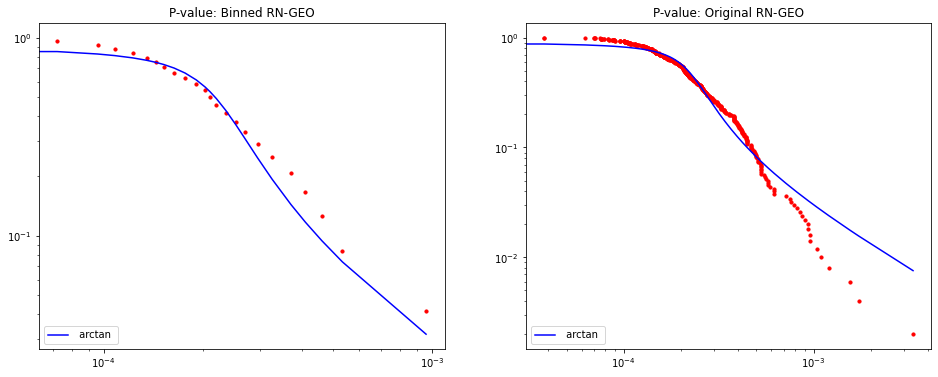

Factor for RN-GEOGD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0009263578990174654, 0.0011479647990091625, 0.0013709273388368825, 0.0015584454052528307, 0.0017048458068380514, 0.0018299173744322603, 0.0019935702627419567, 0.0021671524529814313, 0.0023305032344456598, 0.0025354214315546357, 0.0027998811373869735, 0.003114073726573002, 0.0034538196585739978, 0.003921806206063548, 0.004498106384199472, 0.004934420089993682, 0.00556565374401848, 0.006407326642898967, 0.007436984009454821, 0.009101897273795512, 0.010966927193000712, 0.016643487759755035, 0.03888461306076815]
curve_fit parameter on  arctan :  [0.35250851 5.57459346]
P-val Error at the furthest tail of Binned Y:  0.02553206311177092
P-val Error at the furthest tail of Original Y:  -0.0025559325426314228


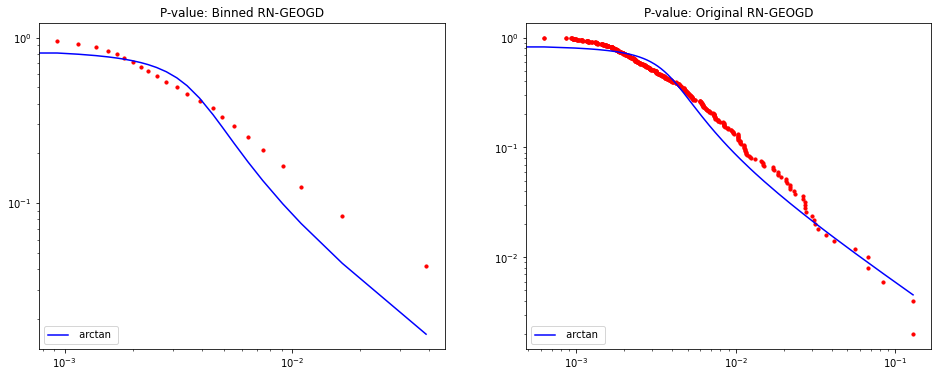

Factor for RN-HGG: 0.1
items in each bin:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15]
binned_data:  [0.0, 0.008877289505801144, 0.010512858299441352, 0.013189306840543114, 0.015243845453095092, 0.018789681112670327, 0.020921225755350326, 0.024622227790803912, 0.02907648937574826, 0.0347099798874206, 0.04070091624707585, 0.04855600030207843, 0.06360764373289549, 0.10018898564300512, 0.1568568887336238, 0.41310989957593086]
curve_fit parameter on  arctan :  [0.3002422 5.9187085]
P-val Error at the furthest tail of Binned Y:  0.04479390951180107
P-val Error at the furthest tail of Original Y:  -0.0007467430439811462


D:\anaconda\anaconda\lib\site-packages\scipy\stats\stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


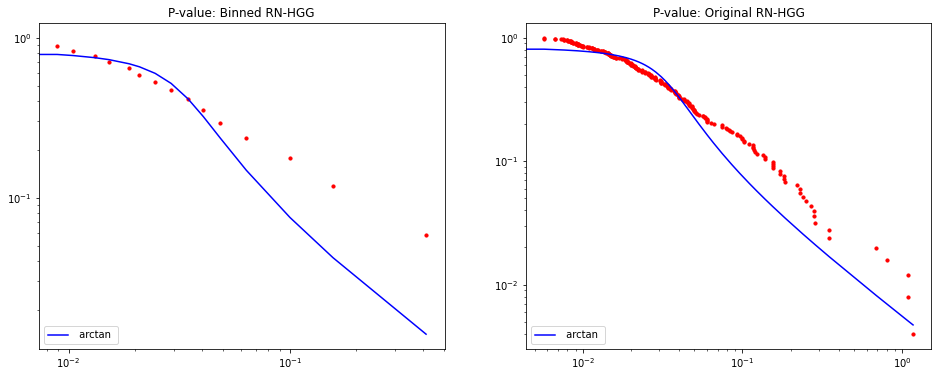

Factor for RN-SF: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0008232613158475374, 0.001017879066284534, 0.0011207005109310783, 0.0011963555258192016, 0.00125400994881455, 0.0013004492835782388, 0.0013581493962959836, 0.0014211293716338681, 0.0014695269650339432, 0.0015344758493157093, 0.0015788660004089278, 0.0016311589007245554, 0.0016917719287206873, 0.0017360884763894496, 0.0017962662363425251, 0.0019001302769364944, 0.002023435197514542, 0.0021384028657870586, 0.0022957081401040937, 0.002496859607136143, 0.00273646203580589, 0.003154552922249001, 0.004248464812839027]
curve_fit parameter on  arctan :  [1.65859335 2.81080001]
P-val Error at the furthest tail of Binned Y:  -0.001787584172136536
P-val Error at the furthest tail of Original Y:  -0.01639476903764514


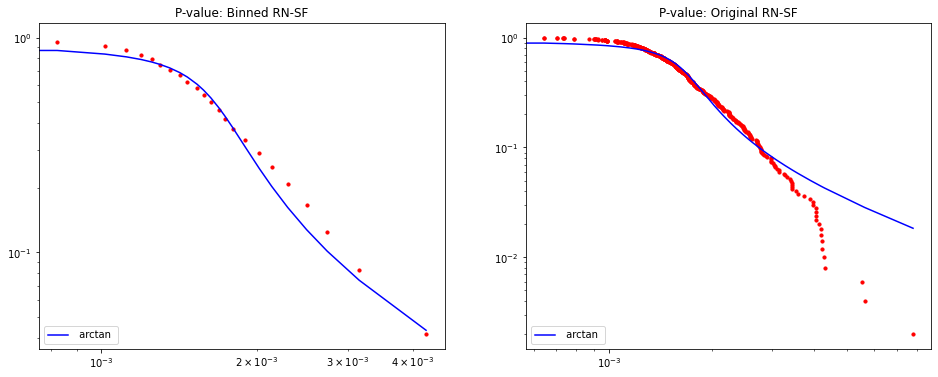

Factor for RN-SFDD: 0.1
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21]
binned_data:  [0.0, 0.015098915814962525, 0.01625972822282327, 0.01806915685154568, 0.0197053725202613, 0.020885854979243394, 0.02203734535758125, 0.023380784352919334, 0.024802686402237258, 0.026519185003570627, 0.028159053086909098, 0.030491271524292866, 0.03243960810108232, 0.034943543744455005, 0.03820337535899291, 0.042682954827981685, 0.05072687424646046, 0.056579858276636065, 0.06699620811252444, 0.08117033618041564, 0.10288840352825518, 0.13400112329138336, 0.24923311366971745]
curve_fit parameter on  arctan :  [0.32643867 7.48432001]
P-val Error at the furthest tail of Binned Y:  0.022055163588036386
P-val Error at the furthest tail of Original Y:  -0.003289847204729912


D:\anaconda\anaconda\lib\site-packages\scipy\stats\stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


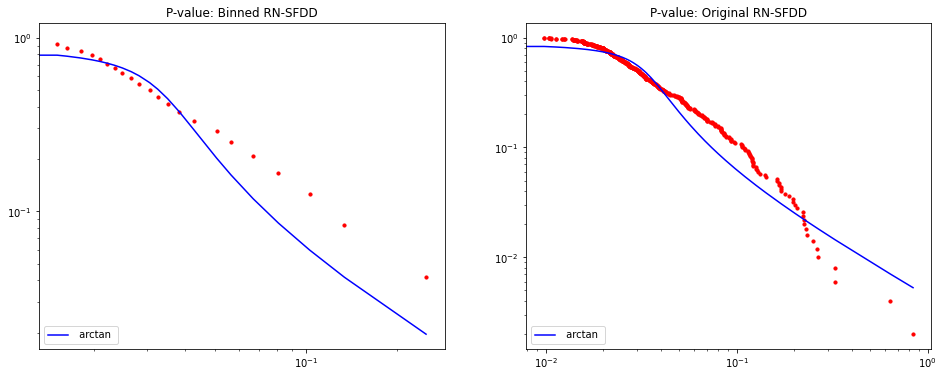

Factor for RN-Sticky: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.009254132692124493, 0.01083534360404466, 0.01177248096354744, 0.012431923071120945, 0.013013393720705587, 0.013405330316511485, 0.013776665037416588, 0.014245466784082743, 0.014664684897235282, 0.015079699021528913, 0.015693878696495696, 0.016279151719719685, 0.016891663240772174, 0.01740634197334005, 0.017982027905800002, 0.01857726425067384, 0.019053796839967642, 0.019595636553800647, 0.020372730157965705, 0.021290666235104255, 0.023043204796323064, 0.026088918379645883, 0.035925464325155546]
curve_fit parameter on  arctan :  [1.64086468 3.37878822]
P-val Error at the furthest tail of Binned Y:  -0.006238658959037857
P-val Error at the furthest tail of Original Y:  -0.014447694321562454


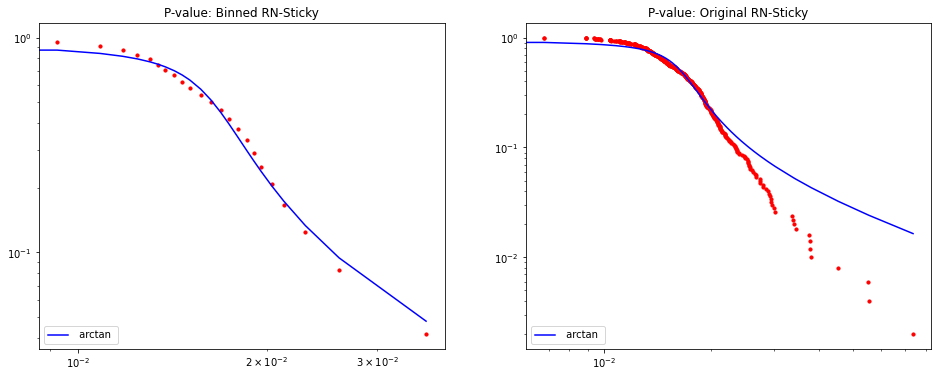

Species:  SC
Factor for SC-ER: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [9.778349617060763e-06, 1.6090843621335577e-05, 2.007305665302249e-05, 2.1921943886462973e-05, 2.3955008455642335e-05, 2.7499175988426206e-05, 2.960032826969559e-05, 3.09616136547782e-05, 3.348505174767371e-05, 3.6127831054646976e-05, 3.860763531449492e-05, 4.065488718855346e-05, 4.2510258178867484e-05, 4.5638606355234034e-05, 4.7740765482209405e-05, 5.058651105533258e-05, 5.354563087568173e-05, 5.6625898305995007e-05, 6.297411694618021e-05, 6.89185319479573e-05, 7.726492471254183e-05, 9.191227016162239e-05, 0.0001686103638389992]
curve_fit parameter on  arctan :  [0.41308342 7.36895766]
P-val Error at the furthest tail of Binned Y:  0.007862381593633505
P-val Error at the furthest tail of Original Y:  -0.0010117330594614504


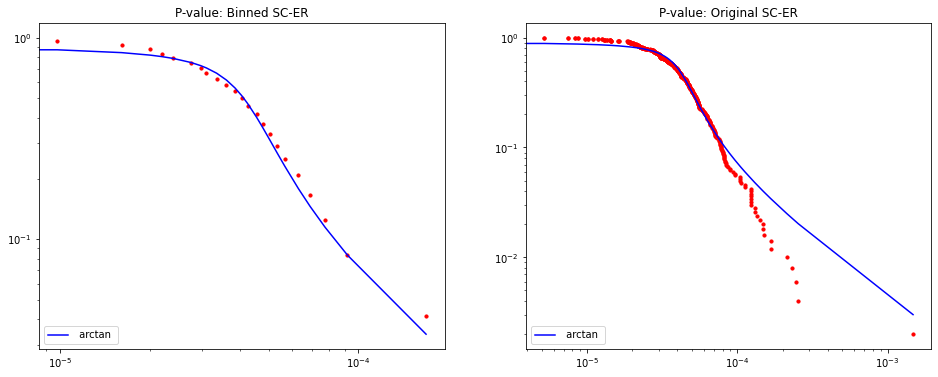

Factor for SC-ERDD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0012737738925092904, 0.0015794009090996243, 0.001806942123059593, 0.001993891648422419, 0.0021158299485650937, 0.002227440259245862, 0.002342675359672097, 0.0024899526413203177, 0.0025968584003185496, 0.002732176785140659, 0.0028214754520765224, 0.002967046405377358, 0.00314614084297651, 0.003270734050070654, 0.00343738134945775, 0.0036899889916007173, 0.0039303144000677, 0.0041996155475311535, 0.0044363044463677, 0.0048837936726755645, 0.005496050112380946, 0.0066617015038549394, 0.011538117302471689]
curve_fit parameter on  arctan :  [ 0.30629241 11.83471949]
P-val Error at the furthest tail of Binned Y:  0.01003589746200595
P-val Error at the furthest tail of Original Y:  -0.0008528223223722708


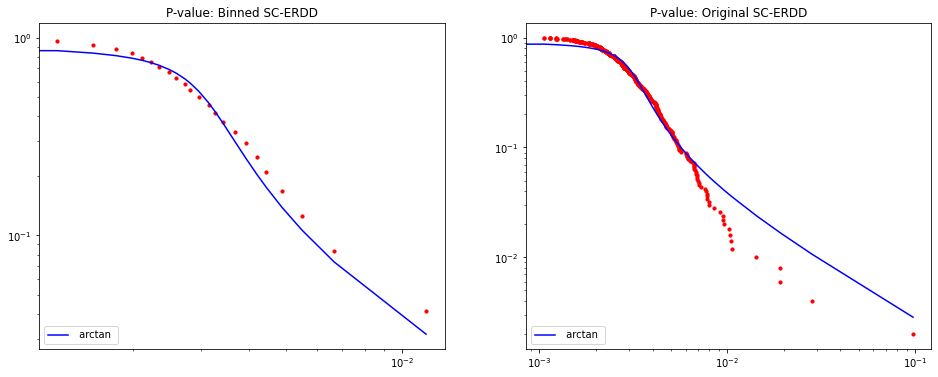

Factor for SC-GEO: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [9.941538131668704e-05, 0.00011774868858103042, 0.00013545166437812383, 0.0001520732758675251, 0.00016552794076507652, 0.00017519944204654465, 0.000186062489602877, 0.00019410737643785962, 0.00020321588995506296, 0.00021287477544011552, 0.00022064190119654593, 0.00023085807008292974, 0.00024298581407900503, 0.0002542550609922692, 0.00026863149074882734, 0.00028658371670716847, 0.0003014321324627245, 0.0003213890241305091, 0.0003436590894983137, 0.00038168875572223016, 0.00043097339923006846, 0.0005226290917727487, 0.0008318116318737853]
curve_fit parameter on  arctan :  [2.38083893 1.53943965]
P-val Error at the furthest tail of Binned Y:  0.006978912379775104
P-val Error at the furthest tail of Original Y:  -0.013306676486435798


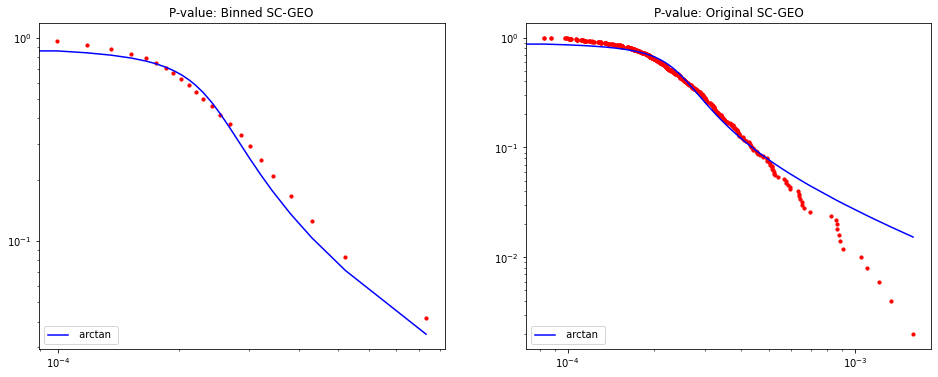

Factor for SC-GEOGD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.00022433369693685115, 0.00030945915622243683, 0.0003614131512250519, 0.00039543054786177895, 0.0004586300486488599, 0.0005149812988486908, 0.0005786756766305455, 0.0006545946220206249, 0.0007610346546902591, 0.0008548637914228565, 0.0009797956099524437, 0.0011353759708710688, 0.001334419130387408, 0.001606665635259282, 0.0019708213618251274, 0.0027392002600977487, 0.003721022685378349, 0.005419863277017243, 0.008205881423359075, 0.012007731681132321, 0.018198497751373468, 0.04038643311793821, 0.11895752070500143]
curve_fit parameter on  arctan :  [0.14612399 9.7132385 ]
P-val Error at the furthest tail of Binned Y:  0.03887765172520952
P-val Error at the furthest tail of Original Y:  0.0010679997392391005


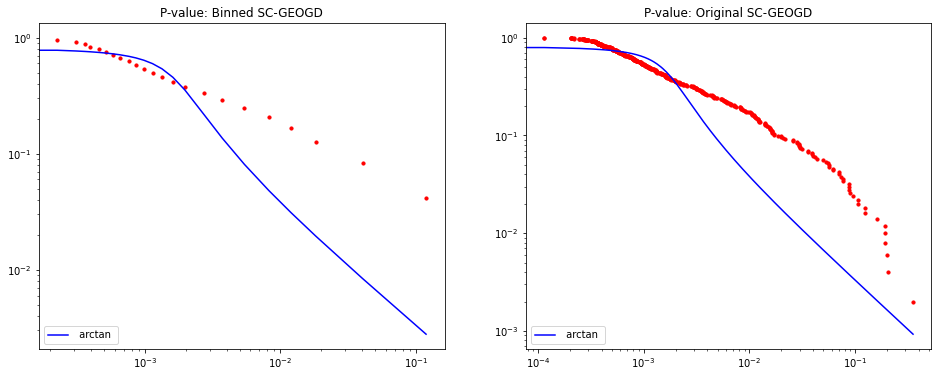

Factor for SC-HGG: 0.1
items in each bin:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15]
binned_data:  [0.035595070999867084, 0.04881851678738895, 0.059620430745201854, 0.06856567099701143, 0.0761978496288639, 0.08428904500942205, 0.0930153836983743, 0.10086332171814133, 0.10620888223882062, 0.11208490301569231, 0.11800535743405653, 0.12790236266706254, 0.14030169936666143, 0.15754321771934515, 0.1887878023096013, 0.28085853616901263]
curve_fit parameter on  arctan :  [1.03303237 3.38493305]
P-val Error at the furthest tail of Binned Y:  0.006342060905685121
P-val Error at the furthest tail of Original Y:  -0.009190648028133075


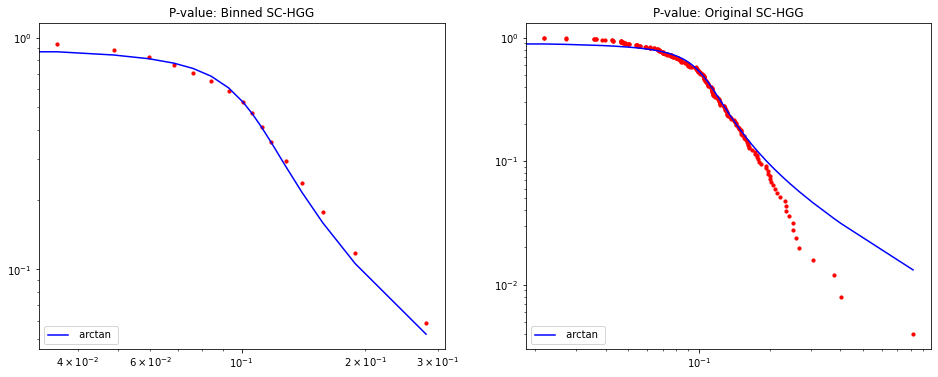

Factor for SC-SF: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.00011769959337245706, 0.0001449295887362501, 0.00015983778899766597, 0.00017497961637307597, 0.00018577478164679773, 0.0001968200801754961, 0.0002053718669928726, 0.00021118292926808804, 0.0002196523380213517, 0.00022809105806850257, 0.0002367728358746295, 0.0002445979696643104, 0.0002535494848017768, 0.00026315916891373365, 0.0002732680658788969, 0.00028959793987924436, 0.000306540173002035, 0.00032343753719321926, 0.0003378799895683829, 0.000357947151743056, 0.0004085570719432818, 0.0004955080351384784, 0.0006968434093438462]
curve_fit parameter on  arctan :  [2.49407223 1.7939834 ]
P-val Error at the furthest tail of Binned Y:  0.002214689510854906
P-val Error at the furthest tail of Original Y:  -0.018774576579763114


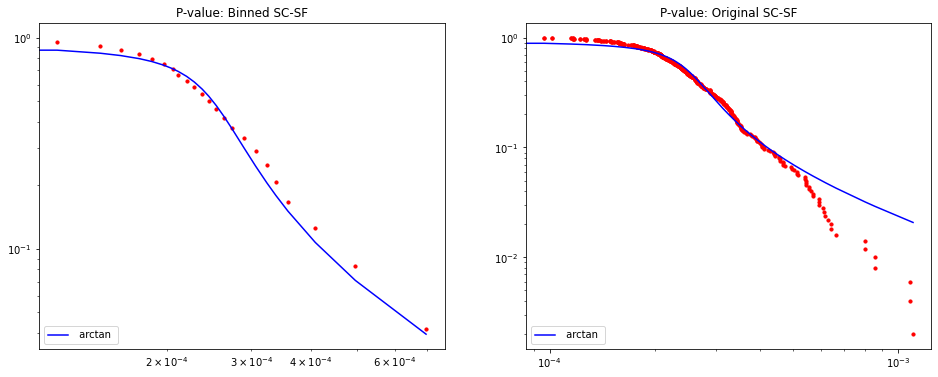

Factor for SC-SFDD: 0.1
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21]
binned_data:  [0.005529443615274872, 0.007592243594595419, 0.008429438073056133, 0.008945519205524029, 0.009501284281130645, 0.010217869981911381, 0.010938473061814587, 0.011403088626859842, 0.012251086141952356, 0.013002788532584025, 0.014132806572706436, 0.015524118057472905, 0.017089742584756717, 0.018973005468870267, 0.021053194796624354, 0.02287194427753022, 0.02603391039814225, 0.02937195555155746, 0.035081399040469204, 0.03902511308148487, 0.046235580071336595, 0.062358437869908086, 0.16343669618081225]
curve_fit parameter on  arctan :  [ 0.1721034  13.21248517]
P-val Error at the furthest tail of Binned Y:  0.025205804681843524
P-val Error at the furthest tail of Original Y:  1.71477928863073e-05


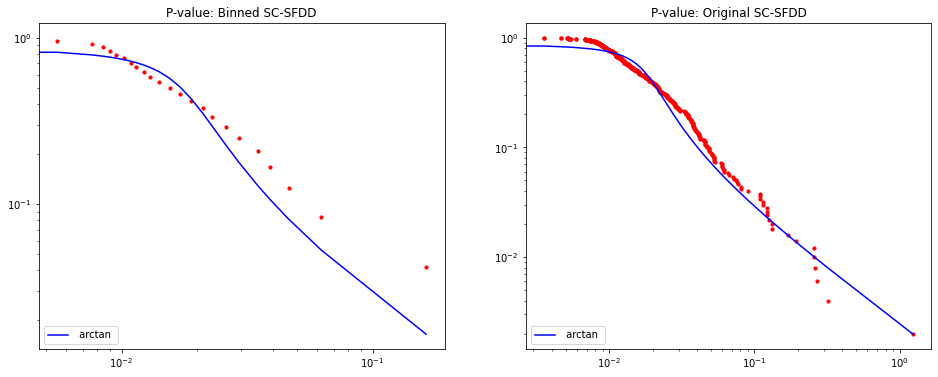

Factor for SC-Sticky: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0016825115115823661, 0.001992545132621457, 0.0021096776897297615, 0.0021845339813201282, 0.0022399846989384995, 0.002301102901901232, 0.002358591409941255, 0.0024130744876060895, 0.0024642229756128148, 0.00251098264358161, 0.0025688386157288468, 0.0026251322433551378, 0.002695732656130516, 0.002796839664165415, 0.0028901153896918152, 0.002979860106490097, 0.003121756143845777, 0.0032461248017467527, 0.003367515246290971, 0.003579714710764461, 0.003825599478265644, 0.004225110122962158, 0.005331594894801876]
curve_fit parameter on  arctan :  [2.68519087 2.416648  ]
P-val Error at the furthest tail of Binned Y:  -0.007705043844760673
P-val Error at the furthest tail of Original Y:  -0.02505480562719109


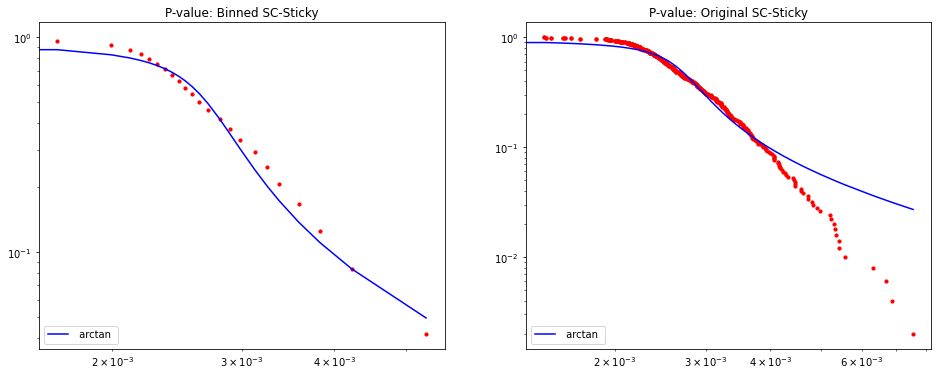

Species:  SP
Factor for SP-ER: 0.0001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.000126956947309736, 0.0001558799757945205, 0.00017482390471153914, 0.0001982059651338654, 0.0002114613249492865, 0.00022824237197527044, 0.0002430346141766145, 0.0002526769384026782, 0.00026543039189084647, 0.00027716989936255683, 0.00028564714231691296, 0.0002943398194524396, 0.0003063851636776314, 0.0003190739840669773, 0.000332017817955319, 0.00034330176688776224, 0.0003597467643602711, 0.00037955855595394944, 0.00039579653769765665, 0.00041519559406555585, 0.0004455829392876237, 0.0004939930269932624, 0.0009183567347347261]
curve_fit parameter on  arctan :  [2.98764054 1.49225829]
P-val Error at the furthest tail of Binned Y:  0.007372918099935566
P-val Error at the furthest tail of Original Y:  -0.004895689173512574


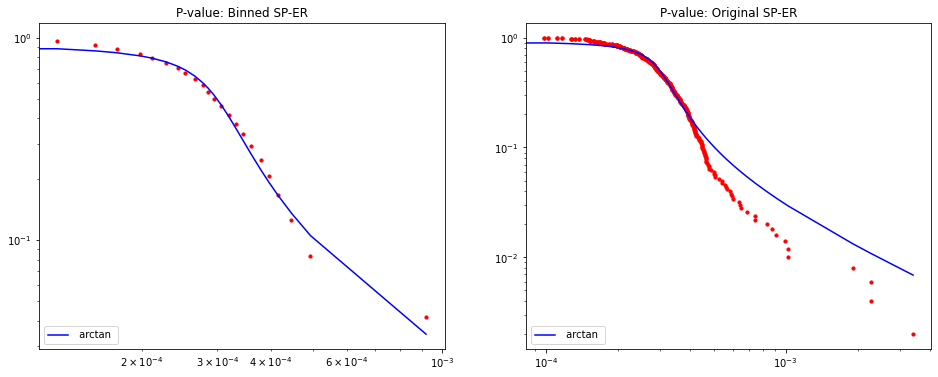

Factor for SP-ERDD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.010074186831389217, 0.012674105140021893, 0.013952081628495185, 0.014653712694914243, 0.015427842887939684, 0.016226091891235833, 0.017134824117369878, 0.017817517283321975, 0.018394794894930934, 0.0192049323053677, 0.020021254432430233, 0.020662120312494286, 0.02137456092442735, 0.022689373599889172, 0.023761487588377744, 0.0247025007801235, 0.025296883933859576, 0.026202234992992707, 0.02803000084002803, 0.030572964702097482, 0.034156089068661674, 0.042638179233372764, 0.0754835439336694]
curve_fit parameter on  arctan :  [2.11122889 2.09258367]
P-val Error at the furthest tail of Binned Y:  0.013761580832985731
P-val Error at the furthest tail of Original Y:  -0.005851284784957889


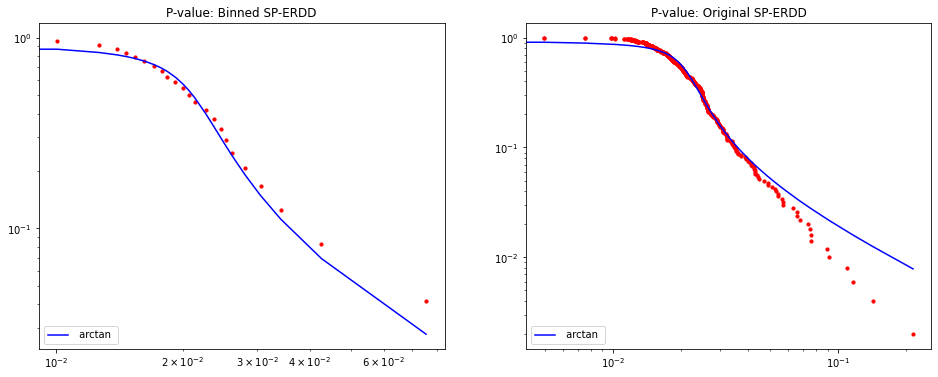

Factor for SP-GEO: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0004424737948317633, 0.0005220840737719295, 0.0005932786146891641, 0.0006286150840290108, 0.0006738548420665986, 0.0007076530179247813, 0.0007452970116688255, 0.0007901369048132428, 0.0008157327335439514, 0.000845809709151225, 0.0008783609159403297, 0.000917410341280155, 0.0009540100552349036, 0.0009921148926786952, 0.001032980317952537, 0.0010687616823358119, 0.0011227158065437834, 0.0011997196081914726, 0.0012729778799370063, 0.0013628093506217877, 0.001543361799508165, 0.001796183510583862, 0.00290359582878165]
curve_fit parameter on  arctan :  [0.93033777 4.64660237]
P-val Error at the furthest tail of Binned Y:  0.007087256676608811
P-val Error at the furthest tail of Original Y:  -0.003375994752885747


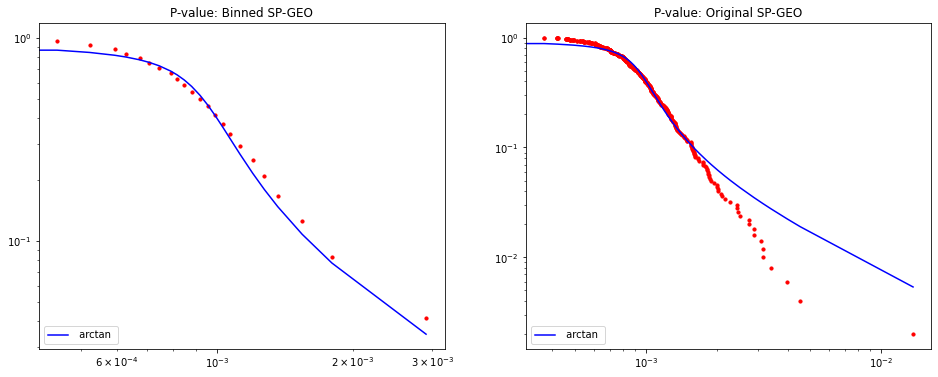

Factor for SP-GEOGD: 0.1
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0009322472192717267, 0.0012766883892990422, 0.0013689782932096814, 0.0015062243899879024, 0.0016315366556818134, 0.0017235796916502445, 0.001825646773578627, 0.001989156148070188, 0.002126795435355533, 0.002331219356871177, 0.0026564382015257827, 0.0029869821325479474, 0.003596641726135858, 0.004112256557857614, 0.0047699367454463034, 0.005979410907229968, 0.00725846585110621, 0.008864205735797333, 0.012236384475986286, 0.01654654616974725, 0.02447657365276047, 0.0379258973092604, 0.09109786439588538]
curve_fit parameter on  arctan :  [3.77796563e-02 4.34519751e+01]
P-val Error at the furthest tail of Binned Y:  0.03327927635429362
P-val Error at the furthest tail of Original Y:  0.0011055999023326102


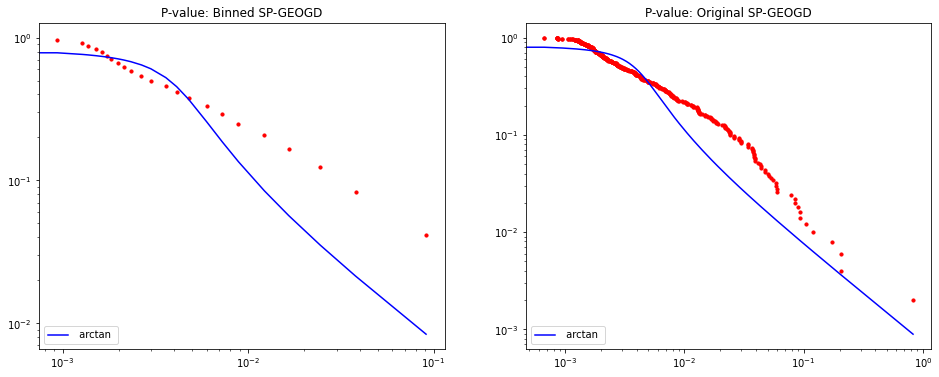

Factor for SP-HGG: 0.1
items in each bin:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15]
binned_data:  [0.018037481480415136, 0.024352844269536173, 0.028451183249062883, 0.033777796546187185, 0.03820602143795783, 0.04380574756703901, 0.04799712548542533, 0.05440637940447386, 0.06024210661982172, 0.07114212749026129, 0.08397092380622934, 0.10159372039712901, 0.13413792608708852, 0.1872277297763498, 0.2537160351424408, 0.5246511866071436]
curve_fit parameter on  arctan :  [0.63748579 3.23441577]
P-val Error at the furthest tail of Binned Y:  0.03750314772955976
P-val Error at the furthest tail of Original Y:  -0.004136556532659874


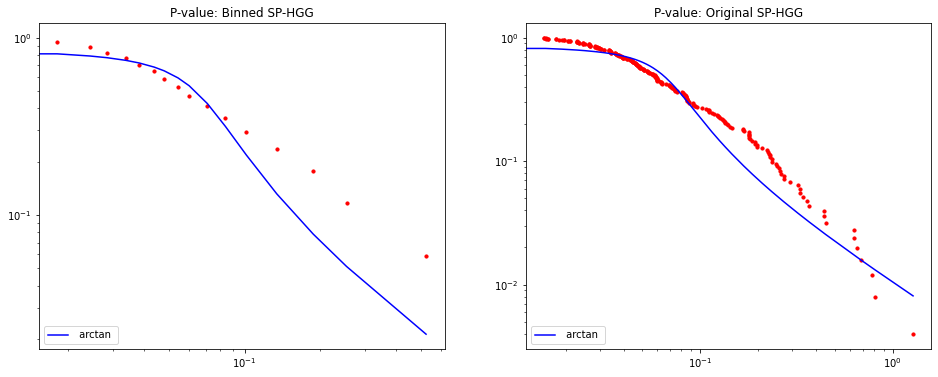

Factor for SP-SF: 0.001
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.0006924342441069774, 0.0009312998825013687, 0.0010018494835413012, 0.0011132626347862972, 0.0011733089246545494, 0.001228836624965905, 0.001270129904218764, 0.0013264371516352542, 0.0013838570606501, 0.0014417371565313096, 0.001500670091230074, 0.0015465382209973034, 0.001616464045108913, 0.0016989877937083127, 0.0017530328720201278, 0.0018304902951323404, 0.0018832874297647977, 0.001968020144825927, 0.0021029542274546066, 0.00222354100453759, 0.002461309668186258, 0.002802760914519009, 0.003832288023236317]
curve_fit parameter on  arctan :  [1.57814431 2.85616957]
P-val Error at the furthest tail of Binned Y:  -0.007382095833470381
P-val Error at the furthest tail of Original Y:  -0.021053118429816498


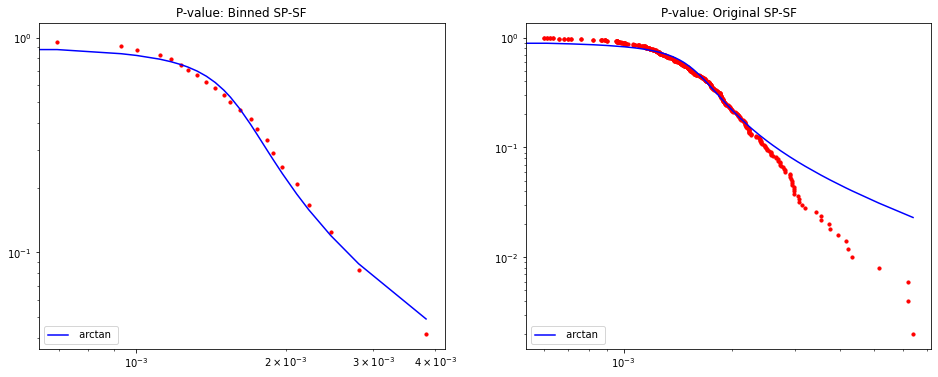

Factor for SP-SFDD: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21]
binned_data:  [0.0, 0.011256953363584425, 0.01249068311072748, 0.013158039722475486, 0.01399784707530499, 0.014741592811504453, 0.015663375264031863, 0.016313054180484052, 0.01690842269698369, 0.017724393585250506, 0.018558539147568356, 0.019584117493276213, 0.020740973131789363, 0.021622609556429098, 0.022641348609618236, 0.024404190411834885, 0.0256530694482082, 0.027710408448351313, 0.031226156120644805, 0.035350063834258615, 0.041257868013022746, 0.051930283722105716, 0.09974747587434489]
curve_fit parameter on  arctan :  [2.02179827 1.7247183 ]
P-val Error at the furthest tail of Binned Y:  0.018501465537957285
P-val Error at the furthest tail of Original Y:  -0.0038381367189870286


D:\anaconda\anaconda\lib\site-packages\scipy\stats\stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


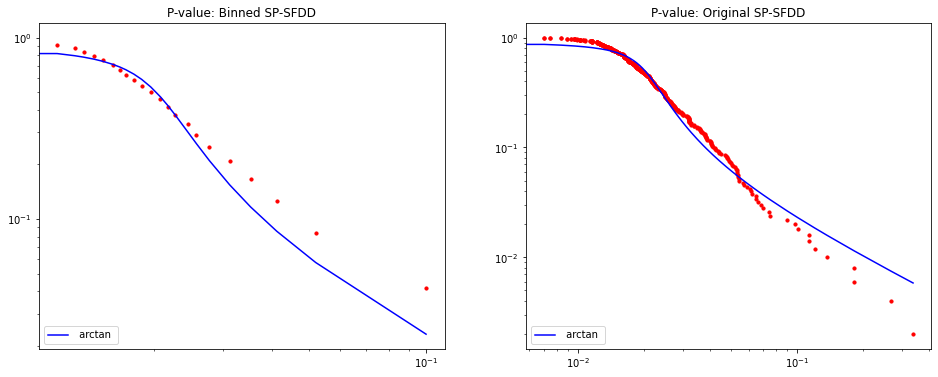

Factor for SP-Sticky: 0.01
items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
binned_data:  [0.011342016520469192, 0.013672004640165837, 0.014925071880456428, 0.015714464638414322, 0.016446491067823046, 0.017173006167909406, 0.017861010732767517, 0.018450330906463405, 0.018940131406989767, 0.019507526065461914, 0.02004567240866417, 0.020780977963216606, 0.02134486876800811, 0.022029347460641797, 0.022627478426869584, 0.023290305844075022, 0.024111474638296607, 0.025449898862430854, 0.026251437291045867, 0.02702224916265233, 0.028444864527289296, 0.03186560027497481, 0.039943081624008836]
curve_fit parameter on  arctan :  [2.08836198 2.77882182]
P-val Error at the furthest tail of Binned Y:  -0.017734637392289088
P-val Error at the furthest tail of Original Y:  -0.03165108158046559


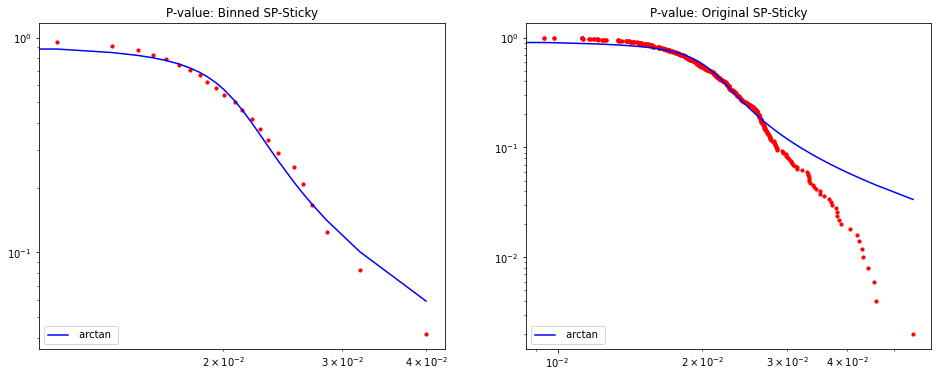

In [26]:
# gmean
for S in Species:
    print("Species: ",S)
    df_S = data_frame(S)
    for i in range(len(Classes[:-1])):
        data_i = data_distance(data(df_S,Classes[:-1][i]))
        factor_i = get_factor(data_i)
        print("Factor for {}-{}: {}".format(S,Classes[:-1][i],factor_i))
        sigmoid_to_ori(data_i, S, Classes[:-1][i], factor_i, arctan,p_control=None,gmean=True)

### AT-SF: fitted curve passes right through the last bin, while it doesn't look that good on original unbinned data

determing error in terms of(giving more weights to) the MSE on the last bin/last 20+ points?

In [27]:
# create bins using y-value. last(n) bin has the very last one point, (n-1)th bin's yvalue range is twice as large as nth bin